## Инструкция для запускающих:
Инстукция предназначена для запуска на сервере 192.168.17.10
1. Убедись, что в качестве kernel'а выбрано raman-spec

Задачи: 
1. Добавить нормировку данных - done
2. Добавить поиск оптимальных параметров - done
3. Обучить модели на декомпозированных данных
4. Добавить в функцию загрузки датасета разделение на фолды + разбиение на трейн/тест
5. Добавить в objective cross_val_score

## Imports

In [62]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pickle
import seaborn as sns

import optuna
from optuna.trial import Trial
# from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# import warnings
# warnings.filterwarnings('ignore')
import yaml

import warnings
warnings.filterwarnings('ignore')

## Data loading/proccessing

Загрузка данных

In [80]:
def data_loading(ga_file, fg_file, needed_data="all"):
    data_ga = pd.read_csv(ga_file)
    data_fg = pd.read_csv(fg_file)
    columns = data_ga.columns.values

    y_fg = data_fg[columns[0]].values
    X_fg = data_fg.drop(columns=columns[0]).values

    y_ga = data_ga[columns[0]].values
    X_ga = data_ga.drop(columns=columns[0]).values

    if needed_data in ["all", 'fg']:
        for index, element in enumerate(set(y_fg)):
            y_fg[y_fg == element] = index
    if needed_data in ["all"]:
        for index, element in enumerate(set(y_ga)):
            y_ga[y_ga == element] = index + len(set(y_fg))
    if needed_data in ["ga"]:
        for index, element in enumerate(set(y_ga)):
            y_ga[y_ga == element] = index
    
    if needed_data == "all":
        y = np.concatenate((y_fg, y_ga), axis=0)
        X = np.concatenate((X_fg, X_ga), axis=0)
    elif needed_data == "fg":
        y = y_fg
        X = X_fg
    elif needed_data == "ga":
        y = y_ga
        X = X_ga
    else:
        raise Exception(f"needed_data can be ['all', 'fg', 'ga'],  but now needed_data={needed_data}")
    return X, y
    
# X, y = data_loading(
#     fg_file="dataSrc/fg3_1-12.csv", 
#     ga_file="dataSrc/ga_2_3_5_6.csv",
# )
# print(X.shape, y.shape)

In [22]:
def make_decomposition(X_data, n_components, decomposition_class=PCA):
    X_decomposed = decomposition_class(n_components=n_components).fit_transform(X_data)
    return X_decomposed

## Применение методов ml

### Parameters setting

In [23]:
def get_needed_params(trial, model_name):
    """
    
    Args:
        trial: specific parameter for optimization with optuna
        model_name: {"XGBoost", "RandomForest", "CatBoost", "SVM", "LDA", "LogisticRegression"}

    Returns:
        model: model class corresponding 'model_name' parameter
        parameters: hyperparameters for corresponding model class, that should be optimized
        
    """
    if model_name == "XGBoost": 
        parameters = {
            "n_estimators": trial.suggest_int('n_estimators', 100, 500), 
            'max_depth': trial.suggest_int('max_depth', 2, 10), 
            'reg_alpha': trial.suggest_uniform('reg_alpha',0,6), 
            'reg_lambda': trial.suggest_uniform('reg_lambda',0,2), 
            'min_child_weight': trial.suggest_int('min_child_weight',0,5),
            'gamma': trial.suggest_uniform('gamma', 0, 4), 
            'learning_rate': trial.suggest_uniform('learning_rate', 1e-4, 1e-1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree',0.4,0.9), 
            'subsample': trial.suggest_uniform('subsample',0.4,0.9),
            'nthread': -1
        }
    elif model_name == "RandomForest": 
        parameters = {
            "n_estimators": trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 6),
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        }
    elif model_name == "CatBoost": 
        parameters = {
            'iterations': trial.suggest_int("iterations", 100, 1000),
            'learning_rate': trial.suggest_float("learning_rate", 1e-4, 1e-1),
            'depth': trial.suggest_int("depth", 0, 4),
            'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0),
            'bootstrap_type': trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
            # 'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0),
            'verbose': False
        }
    elif model_name == "SVM": 
        parameters = {
            'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
            'C': trial.suggest_float("C", 1e-8, 100.0, log = True),
        }
    elif model_name == "LDA": 
        parameters = {
            'solver': trial.suggest_categorical('solver',  ['svd', 'lsqr', 'eigen']),
        }
    elif model_name == "LogisticRegression":     
        parameters = {
            'penalty': trial.suggest_categorical('penalty',  ['l1', 'l2']),
            'C': trial.suggest_float("C", 1.0, 10.0, log=True),
            'tol': trial.suggest_float("tol", 0.0001, 0.01, log=True),
            'fit_intercept': trial.suggest_categorical("fit_intercept", [True, False]),
            'max_iter': trial.suggest_int("max_iter", 100, 1000),
            'solver': trial.suggest_categorical('solver', ['liblinear', 'saga'])
        }
    else:
        raise ValueError("model_name can be only ['XGBoost', 'RandomForest', 'CatBoost', 'SVM', 'LDA', 'LogisticRegression']")
    models = {
        "XGBoost": XGBClassifier,
        "RandomForest": RandomForestClassifier,
        "CatBoost": CatBoostClassifier,
        "SVM": SVC,
        "LDA": LinearDiscriminantAnalysis,
        "LogisticRegression": LogisticRegression,
    }
    # print(parameters)
    return models[model_name], parameters


### Funciton-template for training

In [24]:
# deviding FG data into folds:
def get_mask_for_folds_split(X, y, needed_data='all', random_state=42):
    # kfold split for fg data
    # print(X.shape, y.shape)
    if needed_data in ['all', 'fg']:
        fg_mask = []
        split_df = pd.read_csv("dataSrc/points12.csv")
        for i in range(split_df.shape[0]):
            for index, number in enumerate(split_df.iloc[i].values[1:]):
                fg_mask += [index+1]*number
    if needed_data == 'all':
        # kfold split for ga data
        cv = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
        ga_mask = np.zeros(y[2111:].shape[0])
        for i, (train_index, test_index) in enumerate(cv.split(X[2111:], y[2111:])):
            # print(f"  Test:  index={test_index}")
            ga_mask[test_index] = i+1
        return np.array(fg_mask+ga_mask.tolist())
    elif needed_data == 'fg':
        return np.array(fg_mask)
    elif needed_data == 'ga':
        # kfold split for ga data
        cv = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
        ga_mask = np.zeros(y.shape[0])
        for i, (train_index, test_index) in enumerate(cv.split(X, y)):
            # print(f"  Test:  index={test_index}")
            ga_mask[test_index] = i+1
        return ga_mask
    else:
        raise Exception(f"needed_data can be ['all', 'fg', 'ga'],  but now needed_data={needed_data}")
# mask = get_mask_for_folds_split(X, y)
# mask.shape

In [29]:
needed_data = 'fg'

X, y = data_loading(
    fg_file="dataSrc/fg3_1-12.csv", 
    ga_file="dataSrc/ga_2_3_5_6.csv",
    needed_data=needed_data,
    # triplet=[1, 5, 9]
)

# mask = get_mask_for_folds_split(X, y, needed_data, random_state=42)
# print(mask.shape, mask)
X.shape, y.shape

((2111, 994), (2111,))

In [30]:
# def ml_class_train_template(
#     X,
#     y,
#     model_class,
#     args: dict,
#     k_folds:int = 5,
#     test_size:float = 0.2,
#     method: str = "choice",
#     random_state=None,
#     custom_folds_strategy=True,
# ) -> tuple:
#     models = {
#         f"{i+1}_fold" : None for i in range(k_folds)
#     }

#     train_indexes, test_indexes = train_test_split(
#         np.arange(X.shape[0]),
#         test_size=test_size,
#         stratify=y,
#         random_state=random_state
#     )
#     # print(train_indexes)
#     scaler = MinMaxScaler()
#     X[train_indexes] = scaler.fit_transform(X[train_indexes])
#     X[test_indexes] = scaler.transform(X[test_indexes])
    
#     if method == "choice":
#         y_pred = np.empty((k_folds, y[test_indexes].shape[0]))

#     elif method == "proba":
#         y_pred = np.empty((k_folds, y[test_indexes].shape[0], np.unique(y).shape[0]))
    
#     if not custom_folds_strategy:
#         cv = StratifiedKFold(n_splits=k_folds)
            
#         for i, (train, test) in enumerate(cv.split(X[train_indexes], y[train_indexes])):
#             try:
#                 model = model_class(random_state=random_state, **args)
#             except:
#                 model = model_class(**args)
#             model.fit(X[train_indexes][train], y[train_indexes][train])
#             models[f'{i+1}_fold'] = model
#             if method == "choice":
#                 y_pred[i] = model.predict(X[test_indexes]).reshape(-1)

#             elif method == "proba":
#                 y_pred[i] = model.predict_proba(X[test_indexes])

#     else:
#         folds_mask = get_mask_for_folds_split(X, y)

#         for fold_index in range(1, 6):
#             # print((folds_mask!=fold_index).shape, train_indexes.shape)
#             try:
#                 model = model_class(random_state=random_state, **args)
#             except:
#                 model = model_class(**args)
#             train_folds_mask = folds_mask[train_indexes]
#             model.fit(X[train_indexes][train_folds_mask!=fold_index], 
#                       y[train_indexes][train_folds_mask!=fold_index])
#             models[f'{fold_index}_fold'] = model
#             if method == "choice":
#                 y_pred[fold_index-1] = model.predict(X[test_indexes]).reshape(-1)

#             elif method == "proba":
#                 y_pred[fold_index-1] = model.predict_proba(X[test_indexes])

#     # prediction of final results
#     if method == "choice":
#         y_pred_result = np.empty_like(y[test_indexes])
#         for index in range(y_pred_result.shape[0]):
#             unique_values, counts = np.unique(y_pred[:, index], return_counts=True)
#             y_pred_result[index] = unique_values[counts.argmax()]

#     elif method == "proba":
#         y_pred = y_pred.sum(axis=0)
#         y_pred_result = np.argmax(y_pred, axis=1)
#         y_pred_result[y_pred_result == 0] = -1

#     accuracy = accuracy_score(y[test_indexes], y_pred_result)
#     f1 = f1_score(y[test_indexes], y_pred_result, average="weighted")

#     metrics = {
#         # "precision": precision,
#         # "recall": recall,
#         "accuracy": accuracy,
#         "f1_score": f1
#     }

#     return metrics, models

In [75]:
def train_template_raman(
    X,
    y,
    model_class,
    args: dict,
    k_folds:int = 5,
    test_size:float = 0.2,
    method: str = "choice",
    random_state=None,
    custom_folds_strategy=True,
    needed_data='fg',
    triplet=None
) -> tuple:
    models = {
        f"{i+1}_fold" : None for i in range(k_folds)
    }
    
    train_indexes, test_indexes = train_test_split(
        np.arange(X.shape[0]),
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )
    # print(train_indexes.shape, test_indexes.shape, (train_indexes.shape[0] + test_indexes.shape[0]))
    scaler = MinMaxScaler()
    # print(X.shape, y.shape)
    folds_mask = get_mask_for_folds_split(X, y, needed_data=needed_data)
    X[train_indexes] = scaler.fit_transform(X[train_indexes])
    X[test_indexes] = scaler.transform(X[test_indexes])

    if triplets is not None:
        triplet_indexes = np.where((y == triplet[0]) + (y == triplet[1]) + (y == triplet[2]))
        train_indexes = np.intersect1d(train_indexes, triplet_indexes)
        test_indexes = np.intersect1d(test_indexes, triplet_indexes)
        # print(train_indexes.shape, test_indexes.shape, (train_indexes.shape[0] + test_indexes.shape[0]))
    le = LabelEncoder()
    le.fit(y[triplet_indexes])
    
    f1_scores = []
    accoracy_scores = []
    
    for fold_index in range(1, 6):
        # print((folds_mask!=fold_index).shape, train_indexes.shape)
        try:
            model = model_class(random_state=random_state, **args)
        except:
            model = model_class(**args)
        train_folds_mask = folds_mask[train_indexes]
        
        model.fit(X[train_indexes][train_folds_mask!=fold_index], 
                  le.transform(y[train_indexes][train_folds_mask!=fold_index]))
        models[f'{fold_index}_fold'] = model
        y_pred = model.predict(X[test_indexes]).reshape(-1)
        
        accoracy_scores.append(accuracy_score(le.transform(y[test_indexes]), y_pred))
        f1_scores.append(f1_score(le.transform(y[test_indexes]), y_pred, average="weighted"))
    
    metrics = {
        "accuracy": np.mean(accoracy_scores),
        "f1_score": np.mean(f1_scores)
    }
    
    return metrics, models

### test training

In [44]:
# X, y = data_loading(
#     fg_file="dataSrc/fg3_1-12.csv", 
#     ga_file="dataSrc/ga_2_3_5_6.csv",
#     needed_data='ga',
# )

# # ml_class_train_template(
# #     X,
# #     y,
# #     RandomForestClassifier,
# #     args={
# #         "n_estimators": 10
# #     },
# #     k_folds = 5,
# #     test_size = 0.2,
# #     method = "choice",
# #     random_state=42,
# #     custom_folds_strategy=True
# # )

# metrics, _ = train_template_raman(
#     X,
#     y,
#     RandomForestClassifier,
#     args={
#         "n_estimators": 1000
#     },
#     k_folds = 5,
#     test_size = 0.2,
#     method = "choice",
#     random_state=42,
#     custom_folds_strategy=True,
# )
# metrics

(89, 994) (89,)


{'accuracy': 0.8111111111111111, 'f1_score': 0.7589225589225589}

### Oprimization functionality

In [76]:
models_dict = {
    "XGBoost": XGBClassifier,
    "RandomForest": RandomForestClassifier,
    "CatBoost": CatBoostClassifier,
    "SVM": SVC,
    "LDA": LinearDiscriminantAnalysis,
    "LogisticRegression": LogisticRegression,
}

models = [
    "XGBoost",
    "RandomForest", 
    "CatBoost", 
    "SVM", 
    # "LDA", 
    "LogisticRegression",

]

triplets = {
    "first": [1, 5, 9],
    "second": [2, 6, 10],
    "third": [3, 7, 11],
    "fourth": [4, 8, 12],
}

In [77]:
folder_name = "best_params_triplets"

In [78]:
for needed_data in ['fg']:
    for triplet in ['first', 'second', 'third', 'fourth']:
        metrics_dict = dict()
        for model_name in models:
            def objective(trial, model_name=model_name, random_state=42, needed_data=needed_data):
                model_class, parameters = get_needed_params(trial, model_name)
                # print(model_class)
                print(parameters)
                # data loading
                X, y = data_loading(
                    fg_file="dataSrc/fg3_1-12.csv", 
                    ga_file="dataSrc/ga_2_3_5_6.csv",
                    needed_data=needed_data,
                )
                metrics, _ = train_template_raman(
                    X,
                    y,
                    model_class,
                    args=parameters,
                    k_folds = 5,
                    test_size = 0.2,
                    method = "choice",
                    random_state=random_state,
                    custom_folds_strategy=True,
                    needed_data=needed_data,
                    triplet=triplets[triplet]
                )
                return metrics['f1_score']
    
    
            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials=50)
            print(study.best_trial)
    
            with open(f'{folder_name}/{needed_data}_{triplet}_triplet_{model_name}.yml', 'w') as f:
                yaml.dump(study.best_trial.params, f, default_flow_style=False)
    
            metrics_dict[model_name] = study.best_trial.value
    
            with open(f'{folder_name}/metric_dict_{triplet}_triplet_{needed_data}.yml', 'w') as f:
                yaml.dump(metrics_dict, f, default_flow_style=False)

[I 2023-11-16 23:44:44,256] A new study created in memory with name: no-name-51b8bc3d-40f9-4c3b-917c-ee3308247595


{'n_estimators': 393, 'max_depth': 3, 'reg_alpha': 0.7170929986796095, 'reg_lambda': 0.8247297976290622, 'min_child_weight': 5, 'gamma': 1.1278749582986936, 'learning_rate': 0.024434491422976205, 'colsample_bytree': 0.7789206721136932, 'subsample': 0.523787595403839, 'nthread': -1}


[I 2023-11-16 23:44:49,804] Trial 0 finished with value: 0.9654187494436017 and parameters: {'n_estimators': 393, 'max_depth': 3, 'reg_alpha': 0.7170929986796095, 'reg_lambda': 0.8247297976290622, 'min_child_weight': 5, 'gamma': 1.1278749582986936, 'learning_rate': 0.024434491422976205, 'colsample_bytree': 0.7789206721136932, 'subsample': 0.523787595403839}. Best is trial 0 with value: 0.9654187494436017.


{'n_estimators': 360, 'max_depth': 8, 'reg_alpha': 0.45429101124525273, 'reg_lambda': 1.9840322208095424, 'min_child_weight': 5, 'gamma': 0.9585371367045767, 'learning_rate': 0.05020308569175991, 'colsample_bytree': 0.7896565712764749, 'subsample': 0.790416293345281, 'nthread': -1}


[I 2023-11-16 23:44:54,540] Trial 1 finished with value: 0.9635128211200372 and parameters: {'n_estimators': 360, 'max_depth': 8, 'reg_alpha': 0.45429101124525273, 'reg_lambda': 1.9840322208095424, 'min_child_weight': 5, 'gamma': 0.9585371367045767, 'learning_rate': 0.05020308569175991, 'colsample_bytree': 0.7896565712764749, 'subsample': 0.790416293345281}. Best is trial 0 with value: 0.9654187494436017.


{'n_estimators': 101, 'max_depth': 8, 'reg_alpha': 5.780109521461723, 'reg_lambda': 1.0241907977502316, 'min_child_weight': 2, 'gamma': 0.10460440821875094, 'learning_rate': 0.014575015366285577, 'colsample_bytree': 0.8681958980155148, 'subsample': 0.8736973165692095, 'nthread': -1}


[I 2023-11-16 23:44:58,003] Trial 2 finished with value: 0.9559149428866404 and parameters: {'n_estimators': 101, 'max_depth': 8, 'reg_alpha': 5.780109521461723, 'reg_lambda': 1.0241907977502316, 'min_child_weight': 2, 'gamma': 0.10460440821875094, 'learning_rate': 0.014575015366285577, 'colsample_bytree': 0.8681958980155148, 'subsample': 0.8736973165692095}. Best is trial 0 with value: 0.9654187494436017.


{'n_estimators': 309, 'max_depth': 7, 'reg_alpha': 3.3961043001902103, 'reg_lambda': 0.9418827001132031, 'min_child_weight': 0, 'gamma': 3.5654797157798006, 'learning_rate': 0.05187712413341956, 'colsample_bytree': 0.6453394345797243, 'subsample': 0.8994866016353658, 'nthread': -1}


[I 2023-11-16 23:45:06,409] Trial 3 finished with value: 0.9540655165243617 and parameters: {'n_estimators': 309, 'max_depth': 7, 'reg_alpha': 3.3961043001902103, 'reg_lambda': 0.9418827001132031, 'min_child_weight': 0, 'gamma': 3.5654797157798006, 'learning_rate': 0.05187712413341956, 'colsample_bytree': 0.6453394345797243, 'subsample': 0.8994866016353658}. Best is trial 0 with value: 0.9654187494436017.


{'n_estimators': 111, 'max_depth': 3, 'reg_alpha': 1.3352295522489208, 'reg_lambda': 0.7780064068030472, 'min_child_weight': 5, 'gamma': 0.26228765709741353, 'learning_rate': 0.041116303535764606, 'colsample_bytree': 0.7387736314035378, 'subsample': 0.8016987247944494, 'nthread': -1}


[I 2023-11-16 23:45:08,621] Trial 4 finished with value: 0.9597189661782283 and parameters: {'n_estimators': 111, 'max_depth': 3, 'reg_alpha': 1.3352295522489208, 'reg_lambda': 0.7780064068030472, 'min_child_weight': 5, 'gamma': 0.26228765709741353, 'learning_rate': 0.041116303535764606, 'colsample_bytree': 0.7387736314035378, 'subsample': 0.8016987247944494}. Best is trial 0 with value: 0.9654187494436017.


{'n_estimators': 454, 'max_depth': 6, 'reg_alpha': 5.9799581891239555, 'reg_lambda': 1.5302156279774148, 'min_child_weight': 4, 'gamma': 3.2543791911933098, 'learning_rate': 0.08923592229903514, 'colsample_bytree': 0.8580333891628065, 'subsample': 0.573330171997017, 'nthread': -1}


[I 2023-11-16 23:45:17,221] Trial 5 finished with value: 0.9444692766028918 and parameters: {'n_estimators': 454, 'max_depth': 6, 'reg_alpha': 5.9799581891239555, 'reg_lambda': 1.5302156279774148, 'min_child_weight': 4, 'gamma': 3.2543791911933098, 'learning_rate': 0.08923592229903514, 'colsample_bytree': 0.8580333891628065, 'subsample': 0.573330171997017}. Best is trial 0 with value: 0.9654187494436017.


{'n_estimators': 169, 'max_depth': 5, 'reg_alpha': 2.219058259652711, 'reg_lambda': 0.9000948559127286, 'min_child_weight': 2, 'gamma': 0.11014898345022406, 'learning_rate': 0.0690438578846605, 'colsample_bytree': 0.6014585720077645, 'subsample': 0.8068914497956486, 'nthread': -1}


[I 2023-11-16 23:45:20,353] Trial 6 finished with value: 0.9712202957730508 and parameters: {'n_estimators': 169, 'max_depth': 5, 'reg_alpha': 2.219058259652711, 'reg_lambda': 0.9000948559127286, 'min_child_weight': 2, 'gamma': 0.11014898345022406, 'learning_rate': 0.0690438578846605, 'colsample_bytree': 0.6014585720077645, 'subsample': 0.8068914497956486}. Best is trial 6 with value: 0.9712202957730508.


{'n_estimators': 472, 'max_depth': 6, 'reg_alpha': 1.5656564740383545, 'reg_lambda': 0.993688841124595, 'min_child_weight': 5, 'gamma': 3.7688506771225736, 'learning_rate': 0.04150599812984262, 'colsample_bytree': 0.6685678654442606, 'subsample': 0.7858183228107847, 'nthread': -1}


[I 2023-11-16 23:45:28,089] Trial 7 finished with value: 0.9654305264368148 and parameters: {'n_estimators': 472, 'max_depth': 6, 'reg_alpha': 1.5656564740383545, 'reg_lambda': 0.993688841124595, 'min_child_weight': 5, 'gamma': 3.7688506771225736, 'learning_rate': 0.04150599812984262, 'colsample_bytree': 0.6685678654442606, 'subsample': 0.7858183228107847}. Best is trial 6 with value: 0.9712202957730508.


{'n_estimators': 310, 'max_depth': 6, 'reg_alpha': 2.877818345509998, 'reg_lambda': 0.6312708542141501, 'min_child_weight': 1, 'gamma': 1.299159951317706, 'learning_rate': 0.07849837179491893, 'colsample_bytree': 0.8703796449545439, 'subsample': 0.8530087160313691, 'nthread': -1}


[I 2023-11-16 23:45:36,576] Trial 8 finished with value: 0.9635324238276036 and parameters: {'n_estimators': 310, 'max_depth': 6, 'reg_alpha': 2.877818345509998, 'reg_lambda': 0.6312708542141501, 'min_child_weight': 1, 'gamma': 1.299159951317706, 'learning_rate': 0.07849837179491893, 'colsample_bytree': 0.8703796449545439, 'subsample': 0.8530087160313691}. Best is trial 6 with value: 0.9712202957730508.


{'n_estimators': 396, 'max_depth': 9, 'reg_alpha': 0.2847883653733245, 'reg_lambda': 1.1297806474313812, 'min_child_weight': 4, 'gamma': 1.5779123267415498, 'learning_rate': 0.011644537295379816, 'colsample_bytree': 0.743518823131355, 'subsample': 0.6933454941363382, 'nthread': -1}


[I 2023-11-16 23:45:44,773] Trial 9 finished with value: 0.9616217821457391 and parameters: {'n_estimators': 396, 'max_depth': 9, 'reg_alpha': 0.2847883653733245, 'reg_lambda': 1.1297806474313812, 'min_child_weight': 4, 'gamma': 1.5779123267415498, 'learning_rate': 0.011644537295379816, 'colsample_bytree': 0.743518823131355, 'subsample': 0.6933454941363382}. Best is trial 6 with value: 0.9712202957730508.


{'n_estimators': 201, 'max_depth': 4, 'reg_alpha': 2.7061506020800548, 'reg_lambda': 0.23594492774160747, 'min_child_weight': 2, 'gamma': 2.3924874526354802, 'learning_rate': 0.06668630198303412, 'colsample_bytree': 0.4966269989025205, 'subsample': 0.44756153059927695, 'nthread': -1}


[I 2023-11-16 23:45:48,094] Trial 10 finished with value: 0.961756465927065 and parameters: {'n_estimators': 201, 'max_depth': 4, 'reg_alpha': 2.7061506020800548, 'reg_lambda': 0.23594492774160747, 'min_child_weight': 2, 'gamma': 2.3924874526354802, 'learning_rate': 0.06668630198303412, 'colsample_bytree': 0.4966269989025205, 'subsample': 0.44756153059927695}. Best is trial 6 with value: 0.9712202957730508.


{'n_estimators': 233, 'max_depth': 5, 'reg_alpha': 1.8300861363856644, 'reg_lambda': 0.387505962353194, 'min_child_weight': 3, 'gamma': 2.503048448758958, 'learning_rate': 0.06556796935513039, 'colsample_bytree': 0.6068691854096555, 'subsample': 0.7251380845788232, 'nthread': -1}


[I 2023-11-16 23:45:52,371] Trial 11 finished with value: 0.9635065849549163 and parameters: {'n_estimators': 233, 'max_depth': 5, 'reg_alpha': 1.8300861363856644, 'reg_lambda': 0.387505962353194, 'min_child_weight': 3, 'gamma': 2.503048448758958, 'learning_rate': 0.06556796935513039, 'colsample_bytree': 0.6068691854096555, 'subsample': 0.7251380845788232}. Best is trial 6 with value: 0.9712202957730508.


{'n_estimators': 494, 'max_depth': 5, 'reg_alpha': 2.024585514515978, 'reg_lambda': 0.1052615342500185, 'min_child_weight': 3, 'gamma': 3.8347401462820017, 'learning_rate': 0.09627066021685707, 'colsample_bytree': 0.5681343007623267, 'subsample': 0.7512035870270596, 'nthread': -1}


[I 2023-11-16 23:46:01,218] Trial 12 finished with value: 0.9578781526899389 and parameters: {'n_estimators': 494, 'max_depth': 5, 'reg_alpha': 2.024585514515978, 'reg_lambda': 0.1052615342500185, 'min_child_weight': 3, 'gamma': 3.8347401462820017, 'learning_rate': 0.09627066021685707, 'colsample_bytree': 0.5681343007623267, 'subsample': 0.7512035870270596}. Best is trial 6 with value: 0.9712202957730508.


{'n_estimators': 185, 'max_depth': 2, 'reg_alpha': 1.4057552610775896, 'reg_lambda': 1.303147272892533, 'min_child_weight': 1, 'gamma': 2.942719109079601, 'learning_rate': 0.03191987540149937, 'colsample_bytree': 0.5356451278739187, 'subsample': 0.6426443410318603, 'nthread': -1}


[I 2023-11-16 23:46:03,913] Trial 13 finished with value: 0.9616217821457391 and parameters: {'n_estimators': 185, 'max_depth': 2, 'reg_alpha': 1.4057552610775896, 'reg_lambda': 1.303147272892533, 'min_child_weight': 1, 'gamma': 2.942719109079601, 'learning_rate': 0.03191987540149937, 'colsample_bytree': 0.5356451278739187, 'subsample': 0.6426443410318603}. Best is trial 6 with value: 0.9712202957730508.


{'n_estimators': 242, 'max_depth': 5, 'reg_alpha': 3.5273704050364145, 'reg_lambda': 0.5708592116606204, 'min_child_weight': 4, 'gamma': 1.928094152176179, 'learning_rate': 0.0004817854434025215, 'colsample_bytree': 0.46314403014708033, 'subsample': 0.8044431984216476, 'nthread': -1}


[I 2023-11-16 23:46:08,273] Trial 14 finished with value: 0.9578357692928959 and parameters: {'n_estimators': 242, 'max_depth': 5, 'reg_alpha': 3.5273704050364145, 'reg_lambda': 0.5708592116606204, 'min_child_weight': 4, 'gamma': 1.928094152176179, 'learning_rate': 0.0004817854434025215, 'colsample_bytree': 0.46314403014708033, 'subsample': 0.8044431984216476}. Best is trial 6 with value: 0.9712202957730508.


{'n_estimators': 161, 'max_depth': 10, 'reg_alpha': 2.353571007068985, 'reg_lambda': 0.47566218905809077, 'min_child_weight': 1, 'gamma': 3.981016700116855, 'learning_rate': 0.061512662877456326, 'colsample_bytree': 0.6788413664294872, 'subsample': 0.6802747000055002, 'nthread': -1}


[I 2023-11-16 23:46:12,123] Trial 15 finished with value: 0.9578326569368423 and parameters: {'n_estimators': 161, 'max_depth': 10, 'reg_alpha': 2.353571007068985, 'reg_lambda': 0.47566218905809077, 'min_child_weight': 1, 'gamma': 3.981016700116855, 'learning_rate': 0.061512662877456326, 'colsample_bytree': 0.6788413664294872, 'subsample': 0.6802747000055002}. Best is trial 6 with value: 0.9712202957730508.


{'n_estimators': 273, 'max_depth': 7, 'reg_alpha': 1.1700827447550195, 'reg_lambda': 1.2385876339529074, 'min_child_weight': 3, 'gamma': 0.669439778794497, 'learning_rate': 0.04075773705054097, 'colsample_bytree': 0.43964485875423653, 'subsample': 0.7482699593478298, 'nthread': -1}


[I 2023-11-16 23:46:16,119] Trial 16 finished with value: 0.9635128211200372 and parameters: {'n_estimators': 273, 'max_depth': 7, 'reg_alpha': 1.1700827447550195, 'reg_lambda': 1.2385876339529074, 'min_child_weight': 3, 'gamma': 0.669439778794497, 'learning_rate': 0.04075773705054097, 'colsample_bytree': 0.43964485875423653, 'subsample': 0.7482699593478298}. Best is trial 6 with value: 0.9712202957730508.


{'n_estimators': 449, 'max_depth': 4, 'reg_alpha': 0.12732550551537258, 'reg_lambda': 0.7604199786276422, 'min_child_weight': 2, 'gamma': 1.715770424968177, 'learning_rate': 0.07601303895468865, 'colsample_bytree': 0.656808957629473, 'subsample': 0.8398794234201514, 'nthread': -1}


[I 2023-11-16 23:46:24,077] Trial 17 finished with value: 0.9731246688715451 and parameters: {'n_estimators': 449, 'max_depth': 4, 'reg_alpha': 0.12732550551537258, 'reg_lambda': 0.7604199786276422, 'min_child_weight': 2, 'gamma': 1.715770424968177, 'learning_rate': 0.07601303895468865, 'colsample_bytree': 0.656808957629473, 'subsample': 0.8398794234201514}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 429, 'max_depth': 4, 'reg_alpha': 0.11996991123878736, 'reg_lambda': 0.7343363773725415, 'min_child_weight': 2, 'gamma': 0.6720567409526597, 'learning_rate': 0.07881961323944943, 'colsample_bytree': 0.4004044508765471, 'subsample': 0.8510058524704975, 'nthread': -1}


[I 2023-11-16 23:46:29,427] Trial 18 finished with value: 0.9693143674494861 and parameters: {'n_estimators': 429, 'max_depth': 4, 'reg_alpha': 0.11996991123878736, 'reg_lambda': 0.7343363773725415, 'min_child_weight': 2, 'gamma': 0.6720567409526597, 'learning_rate': 0.07881961323944943, 'colsample_bytree': 0.4004044508765471, 'subsample': 0.8510058524704975}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 335, 'max_depth': 2, 'reg_alpha': 0.8855710402401219, 'reg_lambda': 0.024395622281487395, 'min_child_weight': 0, 'gamma': 1.6228077566797219, 'learning_rate': 0.08052252847533674, 'colsample_bytree': 0.5861655602767059, 'subsample': 0.8277412515647485, 'nthread': -1}


[I 2023-11-16 23:46:34,435] Trial 19 finished with value: 0.9616037689874053 and parameters: {'n_estimators': 335, 'max_depth': 2, 'reg_alpha': 0.8855710402401219, 'reg_lambda': 0.024395622281487395, 'min_child_weight': 0, 'gamma': 1.6228077566797219, 'learning_rate': 0.08052252847533674, 'colsample_bytree': 0.5861655602767059, 'subsample': 0.8277412515647485}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 146, 'max_depth': 4, 'reg_alpha': 0.22096116307466263, 'reg_lambda': 0.3346341202400984, 'min_child_weight': 1, 'gamma': 0.06919395373582182, 'learning_rate': 0.0973570692223984, 'colsample_bytree': 0.5389390477993494, 'subsample': 0.8845990224744817, 'nthread': -1}


[I 2023-11-16 23:46:36,720] Trial 20 finished with value: 0.9673184435079586 and parameters: {'n_estimators': 146, 'max_depth': 4, 'reg_alpha': 0.22096116307466263, 'reg_lambda': 0.3346341202400984, 'min_child_weight': 1, 'gamma': 0.06919395373582182, 'learning_rate': 0.0973570692223984, 'colsample_bytree': 0.5389390477993494, 'subsample': 0.8845990224744817}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 428, 'max_depth': 4, 'reg_alpha': 0.05006979059555017, 'reg_lambda': 0.7050441051760665, 'min_child_weight': 2, 'gamma': 0.660731446882015, 'learning_rate': 0.07444880719252876, 'colsample_bytree': 0.40759123449523105, 'subsample': 0.8452361330054857, 'nthread': -1}


[I 2023-11-16 23:46:41,913] Trial 21 finished with value: 0.9654156370875482 and parameters: {'n_estimators': 428, 'max_depth': 4, 'reg_alpha': 0.05006979059555017, 'reg_lambda': 0.7050441051760665, 'min_child_weight': 2, 'gamma': 0.660731446882015, 'learning_rate': 0.07444880719252876, 'colsample_bytree': 0.40759123449523105, 'subsample': 0.8452361330054857}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 425, 'max_depth': 3, 'reg_alpha': 0.8343820925398986, 'reg_lambda': 0.5660905957106432, 'min_child_weight': 2, 'gamma': 0.5193745509945373, 'learning_rate': 0.08348514087523601, 'colsample_bytree': 0.5002020244469876, 'subsample': 0.8362313865574931, 'nthread': -1}


[I 2023-11-16 23:46:48,044] Trial 22 finished with value: 0.9673184530550593 and parameters: {'n_estimators': 425, 'max_depth': 3, 'reg_alpha': 0.8343820925398986, 'reg_lambda': 0.5660905957106432, 'min_child_weight': 2, 'gamma': 0.5193745509945373, 'learning_rate': 0.08348514087523601, 'colsample_bytree': 0.5002020244469876, 'subsample': 0.8362313865574931}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 361, 'max_depth': 4, 'reg_alpha': 0.01965293971997968, 'reg_lambda': 0.7831430004892628, 'min_child_weight': 2, 'gamma': 0.3783895619970239, 'learning_rate': 0.07197576392302216, 'colsample_bytree': 0.6280599279951761, 'subsample': 0.8667143513913858, 'nthread': -1}


[I 2023-11-16 23:46:52,305] Trial 23 finished with value: 0.9654187494436017 and parameters: {'n_estimators': 361, 'max_depth': 4, 'reg_alpha': 0.01965293971997968, 'reg_lambda': 0.7831430004892628, 'min_child_weight': 2, 'gamma': 0.3783895619970239, 'learning_rate': 0.07197576392302216, 'colsample_bytree': 0.6280599279951761, 'subsample': 0.8667143513913858}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 439, 'max_depth': 5, 'reg_alpha': 0.804506515938125, 'reg_lambda': 0.48795042551818224, 'min_child_weight': 3, 'gamma': 0.8584331151063398, 'learning_rate': 0.05855746658161338, 'colsample_bytree': 0.40403541751078625, 'subsample': 0.7817112224017593, 'nthread': -1}


[I 2023-11-16 23:46:57,955] Trial 24 finished with value: 0.9673215654111129 and parameters: {'n_estimators': 439, 'max_depth': 5, 'reg_alpha': 0.804506515938125, 'reg_lambda': 0.48795042551818224, 'min_child_weight': 3, 'gamma': 0.8584331151063398, 'learning_rate': 0.05855746658161338, 'colsample_bytree': 0.40403541751078625, 'subsample': 0.7817112224017593}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 489, 'max_depth': 3, 'reg_alpha': 0.5345949325908137, 'reg_lambda': 0.8528780570453034, 'min_child_weight': 1, 'gamma': 0.5288763544754489, 'learning_rate': 0.08767578261757411, 'colsample_bytree': 0.5900080003060417, 'subsample': 0.8999982190482692, 'nthread': -1}


[I 2023-11-16 23:47:06,178] Trial 25 finished with value: 0.9673184435079586 and parameters: {'n_estimators': 489, 'max_depth': 3, 'reg_alpha': 0.5345949325908137, 'reg_lambda': 0.8528780570453034, 'min_child_weight': 1, 'gamma': 0.5288763544754489, 'learning_rate': 0.08767578261757411, 'colsample_bytree': 0.5900080003060417, 'subsample': 0.8999982190482692}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 398, 'max_depth': 4, 'reg_alpha': 1.0839116049724795, 'reg_lambda': 0.7088671491715187, 'min_child_weight': 2, 'gamma': 1.2564806679251401, 'learning_rate': 0.07194291161896972, 'colsample_bytree': 0.6291689742093514, 'subsample': 0.8276544336312281, 'nthread': -1}


[I 2023-11-16 23:47:13,433] Trial 26 finished with value: 0.9654156370875482 and parameters: {'n_estimators': 398, 'max_depth': 4, 'reg_alpha': 1.0839116049724795, 'reg_lambda': 0.7088671491715187, 'min_child_weight': 2, 'gamma': 1.2564806679251401, 'learning_rate': 0.07194291161896972, 'colsample_bytree': 0.6291689742093514, 'subsample': 0.8276544336312281}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 257, 'max_depth': 6, 'reg_alpha': 1.679888530771517, 'reg_lambda': 0.6197531320882315, 'min_child_weight': 3, 'gamma': 0.0770934720211216, 'learning_rate': 0.07708245461179884, 'colsample_bytree': 0.6815104712918223, 'subsample': 0.7546058738045618, 'nthread': -1}


[I 2023-11-16 23:47:17,399] Trial 27 finished with value: 0.9635245981132503 and parameters: {'n_estimators': 257, 'max_depth': 6, 'reg_alpha': 1.679888530771517, 'reg_lambda': 0.6197531320882315, 'min_child_weight': 3, 'gamma': 0.0770934720211216, 'learning_rate': 0.07708245461179884, 'colsample_bytree': 0.6815104712918223, 'subsample': 0.7546058738045618}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 376, 'max_depth': 5, 'reg_alpha': 0.5068726070331344, 'reg_lambda': 0.89215756227809, 'min_child_weight': 1, 'gamma': 0.7892097835523232, 'learning_rate': 0.05896408422435106, 'colsample_bytree': 0.5451534191195638, 'subsample': 0.8535856727570675, 'nthread': -1}


[I 2023-11-16 23:47:24,538] Trial 28 finished with value: 0.9635135987325724 and parameters: {'n_estimators': 376, 'max_depth': 5, 'reg_alpha': 0.5068726070331344, 'reg_lambda': 0.89215756227809, 'min_child_weight': 1, 'gamma': 0.7892097835523232, 'learning_rate': 0.05896408422435106, 'colsample_bytree': 0.5451534191195638, 'subsample': 0.8535856727570675}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 334, 'max_depth': 3, 'reg_alpha': 0.759786007641476, 'reg_lambda': 0.801157249810846, 'min_child_weight': 0, 'gamma': 1.0603591817010902, 'learning_rate': 0.06900542640796031, 'colsample_bytree': 0.4721816042839647, 'subsample': 0.8164404530893915, 'nthread': -1}


[I 2023-11-16 23:47:30,454] Trial 29 finished with value: 0.9673137740209216 and parameters: {'n_estimators': 334, 'max_depth': 3, 'reg_alpha': 0.759786007641476, 'reg_lambda': 0.801157249810846, 'min_child_weight': 0, 'gamma': 1.0603591817010902, 'learning_rate': 0.06900542640796031, 'colsample_bytree': 0.4721816042839647, 'subsample': 0.8164404530893915}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 283, 'max_depth': 2, 'reg_alpha': 2.1120203973595197, 'reg_lambda': 1.0959567642975911, 'min_child_weight': 2, 'gamma': 0.42489390372718006, 'learning_rate': 0.08805520449268012, 'colsample_bytree': 0.5271169657998027, 'subsample': 0.8669438769858184, 'nthread': -1}


[I 2023-11-16 23:47:34,261] Trial 30 finished with value: 0.9693143674494861 and parameters: {'n_estimators': 283, 'max_depth': 2, 'reg_alpha': 2.1120203973595197, 'reg_lambda': 1.0959567642975911, 'min_child_weight': 2, 'gamma': 0.42489390372718006, 'learning_rate': 0.08805520449268012, 'colsample_bytree': 0.5271169657998027, 'subsample': 0.8669438769858184}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 282, 'max_depth': 2, 'reg_alpha': 2.1511433594328264, 'reg_lambda': 1.0629291927743538, 'min_child_weight': 2, 'gamma': 0.33594192492386243, 'learning_rate': 0.08470767928152056, 'colsample_bytree': 0.510914474782345, 'subsample': 0.8690314951153866, 'nthread': -1}


[I 2023-11-16 23:47:37,866] Trial 31 finished with value: 0.9693143674494861 and parameters: {'n_estimators': 282, 'max_depth': 2, 'reg_alpha': 2.1511433594328264, 'reg_lambda': 1.0629291927743538, 'min_child_weight': 2, 'gamma': 0.33594192492386243, 'learning_rate': 0.08470767928152056, 'colsample_bytree': 0.510914474782345, 'subsample': 0.8690314951153866}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 202, 'max_depth': 2, 'reg_alpha': 1.1412837697468614, 'reg_lambda': 0.8836401680668307, 'min_child_weight': 2, 'gamma': 0.9932107648378095, 'learning_rate': 0.0917293280767937, 'colsample_bytree': 0.566196483825001, 'subsample': 0.8240470821366155, 'nthread': -1}


[I 2023-11-16 23:47:40,560] Trial 32 finished with value: 0.9616006566313517 and parameters: {'n_estimators': 202, 'max_depth': 2, 'reg_alpha': 1.1412837697468614, 'reg_lambda': 0.8836401680668307, 'min_child_weight': 2, 'gamma': 0.9932107648378095, 'learning_rate': 0.0917293280767937, 'colsample_bytree': 0.566196483825001, 'subsample': 0.8240470821366155}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 417, 'max_depth': 3, 'reg_alpha': 0.4500001701575989, 'reg_lambda': 0.9827816521629582, 'min_child_weight': 2, 'gamma': 0.3191390355177633, 'learning_rate': 0.08093020870429439, 'colsample_bytree': 0.4360215106563681, 'subsample': 0.8659582642214055, 'nthread': -1}


[I 2023-11-16 23:47:45,817] Trial 33 finished with value: 0.9635159334760909 and parameters: {'n_estimators': 417, 'max_depth': 3, 'reg_alpha': 0.4500001701575989, 'reg_lambda': 0.9827816521629582, 'min_child_weight': 2, 'gamma': 0.3191390355177633, 'learning_rate': 0.08093020870429439, 'colsample_bytree': 0.4360215106563681, 'subsample': 0.8659582642214055}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 451, 'max_depth': 7, 'reg_alpha': 2.471425467123241, 'reg_lambda': 1.1354584429820318, 'min_child_weight': 3, 'gamma': 0.7790651773983618, 'learning_rate': 0.07588929852416652, 'colsample_bytree': 0.6074363970938419, 'subsample': 0.7828634781017162, 'nthread': -1}


[I 2023-11-16 23:47:53,095] Trial 34 finished with value: 0.9596932266348199 and parameters: {'n_estimators': 451, 'max_depth': 7, 'reg_alpha': 2.471425467123241, 'reg_lambda': 1.1354584429820318, 'min_child_weight': 3, 'gamma': 0.7790651773983618, 'learning_rate': 0.07588929852416652, 'colsample_bytree': 0.6074363970938419, 'subsample': 0.7828634781017162}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 339, 'max_depth': 4, 'reg_alpha': 1.8170887735631087, 'reg_lambda': 0.9280629550199392, 'min_child_weight': 1, 'gamma': 0.013227580159734187, 'learning_rate': 0.09164625923493036, 'colsample_bytree': 0.5161904729442247, 'subsample': 0.8910913304200954, 'nthread': -1}


[I 2023-11-16 23:47:57,351] Trial 35 finished with value: 0.9673231225420962 and parameters: {'n_estimators': 339, 'max_depth': 4, 'reg_alpha': 1.8170887735631087, 'reg_lambda': 0.9280629550199392, 'min_child_weight': 1, 'gamma': 0.013227580159734187, 'learning_rate': 0.09164625923493036, 'colsample_bytree': 0.5161904729442247, 'subsample': 0.8910913304200954}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 125, 'max_depth': 3, 'reg_alpha': 3.159501483804965, 'reg_lambda': 0.71660427011549, 'min_child_weight': 2, 'gamma': 0.4866825002212214, 'learning_rate': 0.0838832555321096, 'colsample_bytree': 0.47022149243174843, 'subsample': 0.8121331570606485, 'nthread': -1}


[I 2023-11-16 23:47:59,669] Trial 36 finished with value: 0.9654234189306387 and parameters: {'n_estimators': 125, 'max_depth': 3, 'reg_alpha': 3.159501483804965, 'reg_lambda': 0.71660427011549, 'min_child_weight': 2, 'gamma': 0.4866825002212214, 'learning_rate': 0.0838832555321096, 'colsample_bytree': 0.47022149243174843, 'subsample': 0.8121331570606485}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 471, 'max_depth': 5, 'reg_alpha': 1.4638874592691906, 'reg_lambda': 0.7948201524721, 'min_child_weight': 4, 'gamma': 0.26583760789352384, 'learning_rate': 0.09904932168475969, 'colsample_bytree': 0.6559329490347192, 'subsample': 0.8475005060235776, 'nthread': -1}


[I 2023-11-16 23:48:05,719] Trial 37 finished with value: 0.9635128211200372 and parameters: {'n_estimators': 471, 'max_depth': 5, 'reg_alpha': 1.4638874592691906, 'reg_lambda': 0.7948201524721, 'min_child_weight': 4, 'gamma': 0.26583760789352384, 'learning_rate': 0.09904932168475969, 'colsample_bytree': 0.6559329490347192, 'subsample': 0.8475005060235776}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 302, 'max_depth': 7, 'reg_alpha': 3.7055573627692944, 'reg_lambda': 1.4599233584823403, 'min_child_weight': 3, 'gamma': 0.9853088365300561, 'learning_rate': 0.08814692734493126, 'colsample_bytree': 0.7045621983533021, 'subsample': 0.8964033841465787, 'nthread': -1}


[I 2023-11-16 23:48:11,430] Trial 38 finished with value: 0.961626451632776 and parameters: {'n_estimators': 302, 'max_depth': 7, 'reg_alpha': 3.7055573627692944, 'reg_lambda': 1.4599233584823403, 'min_child_weight': 3, 'gamma': 0.9853088365300561, 'learning_rate': 0.08814692734493126, 'colsample_bytree': 0.7045621983533021, 'subsample': 0.8964033841465787}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 384, 'max_depth': 6, 'reg_alpha': 0.033638152860761966, 'reg_lambda': 1.020195128747035, 'min_child_weight': 2, 'gamma': 1.1700567841779823, 'learning_rate': 0.0780110125019787, 'colsample_bytree': 0.6383742216314797, 'subsample': 0.7926604554105235, 'nthread': -1}


[I 2023-11-16 23:48:17,551] Trial 39 finished with value: 0.9673215654111129 and parameters: {'n_estimators': 384, 'max_depth': 6, 'reg_alpha': 0.033638152860761966, 'reg_lambda': 1.020195128747035, 'min_child_weight': 2, 'gamma': 1.1700567841779823, 'learning_rate': 0.0780110125019787, 'colsample_bytree': 0.6383742216314797, 'subsample': 0.7926604554105235}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 224, 'max_depth': 8, 'reg_alpha': 0.49879968508212474, 'reg_lambda': 0.9214608657802661, 'min_child_weight': 1, 'gamma': 0.19636238716919624, 'learning_rate': 0.07000501996120655, 'colsample_bytree': 0.6072619501434612, 'subsample': 0.8604308020738501, 'nthread': -1}


[I 2023-11-16 23:48:21,711] Trial 40 finished with value: 0.9674131067070453 and parameters: {'n_estimators': 224, 'max_depth': 8, 'reg_alpha': 0.49879968508212474, 'reg_lambda': 0.9214608657802661, 'min_child_weight': 1, 'gamma': 0.19636238716919624, 'learning_rate': 0.07000501996120655, 'colsample_bytree': 0.6072619501434612, 'subsample': 0.8604308020738501}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 284, 'max_depth': 2, 'reg_alpha': 2.143958848371946, 'reg_lambda': 1.0961796950615188, 'min_child_weight': 2, 'gamma': 0.411426713946844, 'learning_rate': 0.08549581952051558, 'colsample_bytree': 0.5151018920937644, 'subsample': 0.8688047612293976, 'nthread': -1}


[I 2023-11-16 23:48:25,493] Trial 41 finished with value: 0.9674099943509917 and parameters: {'n_estimators': 284, 'max_depth': 2, 'reg_alpha': 2.143958848371946, 'reg_lambda': 1.0961796950615188, 'min_child_weight': 2, 'gamma': 0.411426713946844, 'learning_rate': 0.08549581952051558, 'colsample_bytree': 0.5151018920937644, 'subsample': 0.8688047612293976}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 285, 'max_depth': 2, 'reg_alpha': 2.5789947380501195, 'reg_lambda': 1.1050523753494752, 'min_child_weight': 2, 'gamma': 0.2766327506696, 'learning_rate': 0.0825926947704712, 'colsample_bytree': 0.5596176342599032, 'subsample': 0.8691265096163096, 'nthread': -1}


[I 2023-11-16 23:48:29,155] Trial 42 finished with value: 0.9616100051525261 and parameters: {'n_estimators': 285, 'max_depth': 2, 'reg_alpha': 2.5789947380501195, 'reg_lambda': 1.1050523753494752, 'min_child_weight': 2, 'gamma': 0.2766327506696, 'learning_rate': 0.0825926947704712, 'colsample_bytree': 0.5596176342599032, 'subsample': 0.8691265096163096}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 314, 'max_depth': 3, 'reg_alpha': 2.224669390315508, 'reg_lambda': 1.0356951528874803, 'min_child_weight': 2, 'gamma': 0.6473422008843422, 'learning_rate': 0.09435740756846517, 'colsample_bytree': 0.49446967595347935, 'subsample': 0.8362956752573072, 'nthread': -1}


[I 2023-11-16 23:48:34,199] Trial 43 finished with value: 0.9712202957730508 and parameters: {'n_estimators': 314, 'max_depth': 3, 'reg_alpha': 2.224669390315508, 'reg_lambda': 1.0356951528874803, 'min_child_weight': 2, 'gamma': 0.6473422008843422, 'learning_rate': 0.09435740756846517, 'colsample_bytree': 0.49446967595347935, 'subsample': 0.8362956752573072}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 406, 'max_depth': 3, 'reg_alpha': 2.9776973936335986, 'reg_lambda': 0.969146314759456, 'min_child_weight': 3, 'gamma': 0.627195221505693, 'learning_rate': 0.0919158266554549, 'colsample_bytree': 0.5348227319843111, 'subsample': 0.8330416150786816, 'nthread': -1}


[I 2023-11-16 23:48:40,397] Trial 44 finished with value: 0.9673231225420962 and parameters: {'n_estimators': 406, 'max_depth': 3, 'reg_alpha': 2.9776973936335986, 'reg_lambda': 0.969146314759456, 'min_child_weight': 3, 'gamma': 0.627195221505693, 'learning_rate': 0.0919158266554549, 'colsample_bytree': 0.5348227319843111, 'subsample': 0.8330416150786816}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 360, 'max_depth': 4, 'reg_alpha': 1.6542168097409564, 'reg_lambda': 1.1991659588276014, 'min_child_weight': 2, 'gamma': 1.4414499158019436, 'learning_rate': 0.09484901666298456, 'colsample_bytree': 0.49686417947043254, 'subsample': 0.810083647345785, 'nthread': -1}


[I 2023-11-16 23:48:46,451] Trial 45 finished with value: 0.9635159334760909 and parameters: {'n_estimators': 360, 'max_depth': 4, 'reg_alpha': 1.6542168097409564, 'reg_lambda': 1.1991659588276014, 'min_child_weight': 2, 'gamma': 1.4414499158019436, 'learning_rate': 0.09484901666298456, 'colsample_bytree': 0.49686417947043254, 'subsample': 0.810083647345785}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 168, 'max_depth': 3, 'reg_alpha': 1.9451436542935283, 'reg_lambda': 0.8431597936806701, 'min_child_weight': 1, 'gamma': 0.9058762776084865, 'learning_rate': 0.08808505869645701, 'colsample_bytree': 0.4738505484471882, 'subsample': 0.7857575487378138, 'nthread': -1}


[I 2023-11-16 23:48:49,366] Trial 46 finished with value: 0.9654218617996554 and parameters: {'n_estimators': 168, 'max_depth': 3, 'reg_alpha': 1.9451436542935283, 'reg_lambda': 0.8431597936806701, 'min_child_weight': 1, 'gamma': 0.9058762776084865, 'learning_rate': 0.08808505869645701, 'colsample_bytree': 0.4738505484471882, 'subsample': 0.7857575487378138}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 469, 'max_depth': 4, 'reg_alpha': 1.437873317597555, 'reg_lambda': 0.7187802173661878, 'min_child_weight': 3, 'gamma': 0.00309894894763707, 'learning_rate': 0.07502481466300484, 'colsample_bytree': 0.5660488374419526, 'subsample': 0.844481928332119, 'nthread': -1}


[I 2023-11-16 23:48:54,307] Trial 47 finished with value: 0.9654156370875482 and parameters: {'n_estimators': 469, 'max_depth': 4, 'reg_alpha': 1.437873317597555, 'reg_lambda': 0.7187802173661878, 'min_child_weight': 3, 'gamma': 0.00309894894763707, 'learning_rate': 0.07502481466300484, 'colsample_bytree': 0.5660488374419526, 'subsample': 0.844481928332119}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 322, 'max_depth': 5, 'reg_alpha': 2.33591885440044, 'reg_lambda': 1.2930319812721531, 'min_child_weight': 2, 'gamma': 0.7066669100704055, 'learning_rate': 0.0649761335123226, 'colsample_bytree': 0.4357060957609289, 'subsample': 0.7599474522860795, 'nthread': -1}


[I 2023-11-16 23:48:59,281] Trial 48 finished with value: 0.9616248945017928 and parameters: {'n_estimators': 322, 'max_depth': 5, 'reg_alpha': 2.33591885440044, 'reg_lambda': 1.2930319812721531, 'min_child_weight': 2, 'gamma': 0.7066669100704055, 'learning_rate': 0.0649761335123226, 'colsample_bytree': 0.4357060957609289, 'subsample': 0.7599474522860795}. Best is trial 17 with value: 0.9731246688715451.


{'n_estimators': 217, 'max_depth': 3, 'reg_alpha': 2.7671725214964256, 'reg_lambda': 0.9921057237935929, 'min_child_weight': 1, 'gamma': 1.1236583412296755, 'learning_rate': 0.09394047408015146, 'colsample_bytree': 0.48562424886817546, 'subsample': 0.881925944707415, 'nthread': -1}


[I 2023-11-16 23:49:03,257] Trial 49 finished with value: 0.9616030009219709 and parameters: {'n_estimators': 217, 'max_depth': 3, 'reg_alpha': 2.7671725214964256, 'reg_lambda': 0.9921057237935929, 'min_child_weight': 1, 'gamma': 1.1236583412296755, 'learning_rate': 0.09394047408015146, 'colsample_bytree': 0.48562424886817546, 'subsample': 0.881925944707415}. Best is trial 17 with value: 0.9731246688715451.
[I 2023-11-16 23:49:03,260] A new study created in memory with name: no-name-7714a4c5-688d-4b60-ba5f-4a4b19c3c3bd


FrozenTrial(number=17, state=TrialState.COMPLETE, values=[0.9731246688715451], datetime_start=datetime.datetime(2023, 11, 16, 23, 46, 16, 120735), datetime_complete=datetime.datetime(2023, 11, 16, 23, 46, 24, 77205), params={'n_estimators': 449, 'max_depth': 4, 'reg_alpha': 0.12732550551537258, 'reg_lambda': 0.7604199786276422, 'min_child_weight': 2, 'gamma': 1.715770424968177, 'learning_rate': 0.07601303895468865, 'colsample_bytree': 0.656808957629473, 'subsample': 0.8398794234201514}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'reg_alpha': FloatDistribution(high=6.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=2.0, log=False, low=0.0, step=None), 'min_child_weight': IntDistribution(high=5, log=False, low=0, step=1), 'gamma': FloatDistribution(high=4.0, log=False, low=0.0, step=None), 'learning_rate

[I 2023-11-16 23:49:13,659] Trial 0 finished with value: 0.9521027922598455 and parameters: {'n_estimators': 580, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9521027922598455.


{'n_estimators': 888, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-16 23:49:26,839] Trial 1 finished with value: 0.9540188543524624 and parameters: {'n_estimators': 888, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9540188543524624.


{'n_estimators': 853, 'max_depth': 2, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-16 23:49:39,042] Trial 2 finished with value: 0.93873791983601 and parameters: {'n_estimators': 853, 'max_depth': 2, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9540188543524624.


{'n_estimators': 713, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-16 23:49:49,540] Trial 3 finished with value: 0.9540188543524624 and parameters: {'n_estimators': 713, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9540188543524624.


{'n_estimators': 841, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:50:05,055] Trial 4 finished with value: 0.9541020525315039 and parameters: {'n_estimators': 841, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9541020525315039.


{'n_estimators': 534, 'max_depth': 4, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-16 23:50:12,863] Trial 5 finished with value: 0.9540188543524624 and parameters: {'n_estimators': 534, 'max_depth': 4, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9541020525315039.


{'n_estimators': 308, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-16 23:50:18,525] Trial 6 finished with value: 0.9521121465104494 and parameters: {'n_estimators': 308, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 4 with value: 0.9541020525315039.


{'n_estimators': 580, 'max_depth': 3, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-16 23:50:28,426] Trial 7 finished with value: 0.9521027922598455 and parameters: {'n_estimators': 580, 'max_depth': 3, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 4 with value: 0.9541020525315039.


{'n_estimators': 420, 'max_depth': 6, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-16 23:50:34,806] Trial 8 finished with value: 0.9541020525315039 and parameters: {'n_estimators': 420, 'max_depth': 6, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9541020525315039.


{'n_estimators': 659, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-16 23:50:44,650] Trial 9 finished with value: 0.9540188543524624 and parameters: {'n_estimators': 659, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9541020525315039.


{'n_estimators': 145, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:50:47,549] Trial 10 finished with value: 0.9598790493016679 and parameters: {'n_estimators': 145, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 10 with value: 0.9598790493016679.


{'n_estimators': 189, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:50:51,262] Trial 11 finished with value: 0.959860313988815 and parameters: {'n_estimators': 189, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 10 with value: 0.9598790493016679.


{'n_estimators': 121, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:50:53,732] Trial 12 finished with value: 0.957962987209051 and parameters: {'n_estimators': 121, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 10 with value: 0.9598790493016679.


{'n_estimators': 186, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:50:57,390] Trial 13 finished with value: 0.959860313988815 and parameters: {'n_estimators': 186, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 10 with value: 0.9598790493016679.


{'n_estimators': 299, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:51:03,231] Trial 14 finished with value: 0.9559962975903755 and parameters: {'n_estimators': 299, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 10 with value: 0.9598790493016679.


{'n_estimators': 237, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:51:07,826] Trial 15 finished with value: 0.9540833172186509 and parameters: {'n_estimators': 237, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 10 with value: 0.9598790493016679.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-11-16 23:51:09,852] Trial 16 finished with value: 0.9541316578187959 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 10 with value: 0.9598790493016679.


{'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:51:17,407] Trial 17 finished with value: 0.9540864716628796 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 10 with value: 0.9598790493016679.


{'n_estimators': 996, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-16 23:51:35,655] Trial 18 finished with value: 0.9540188543524624 and parameters: {'n_estimators': 996, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 10 with value: 0.9598790493016679.


{'n_estimators': 347, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:51:42,264] Trial 19 finished with value: 0.9540770906006308 and parameters: {'n_estimators': 347, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 10 with value: 0.9598790493016679.


{'n_estimators': 197, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-16 23:51:46,080] Trial 20 finished with value: 0.959860313988815 and parameters: {'n_estimators': 197, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 10 with value: 0.9598790493016679.


{'n_estimators': 172, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:51:49,491] Trial 21 finished with value: 0.9617795209785598 and parameters: {'n_estimators': 172, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.9617795209785598.


{'n_estimators': 230, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:51:53,960] Trial 22 finished with value: 0.9559869433397715 and parameters: {'n_estimators': 230, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.9617795209785598.


{'n_estimators': 139, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:51:56,768] Trial 23 finished with value: 0.9598790493016679 and parameters: {'n_estimators': 139, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.9617795209785598.


{'n_estimators': 460, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:52:05,473] Trial 24 finished with value: 0.9559923999864441 and parameters: {'n_estimators': 460, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.9617795209785598.


{'n_estimators': 101, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-16 23:52:07,570] Trial 25 finished with value: 0.9541464534395425 and parameters: {'n_estimators': 101, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 21 with value: 0.9617795209785598.


{'n_estimators': 274, 'max_depth': 6, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:52:12,836] Trial 26 finished with value: 0.9559962975903755 and parameters: {'n_estimators': 274, 'max_depth': 6, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.9617795209785598.


{'n_estimators': 159, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-16 23:52:15,450] Trial 27 finished with value: 0.9540219667085159 and parameters: {'n_estimators': 159, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 21 with value: 0.9617795209785598.


{'n_estimators': 380, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:52:22,682] Trial 28 finished with value: 0.9540958259134837 and parameters: {'n_estimators': 380, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.9617795209785598.


{'n_estimators': 259, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-11-16 23:52:27,502] Trial 29 finished with value: 0.95400872058341 and parameters: {'n_estimators': 259, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 21 with value: 0.9617795209785598.


{'n_estimators': 496, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:52:36,826] Trial 30 finished with value: 0.9540958259134837 and parameters: {'n_estimators': 496, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.9617795209785598.


{'n_estimators': 166, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:52:40,127] Trial 31 finished with value: 0.9617795209785598 and parameters: {'n_estimators': 166, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 21 with value: 0.9617795209785598.


{'n_estimators': 171, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:52:43,527] Trial 32 finished with value: 0.9636916854672453 and parameters: {'n_estimators': 171, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 331, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:52:49,854] Trial 33 finished with value: 0.9559962975903755 and parameters: {'n_estimators': 331, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 201, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-16 23:52:53,088] Trial 34 finished with value: 0.9501960844178328 and parameters: {'n_estimators': 201, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 150, 'max_depth': 4, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:52:56,052] Trial 35 finished with value: 0.9579139091786331 and parameters: {'n_estimators': 150, 'max_depth': 4, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 230, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:53:00,518] Trial 36 finished with value: 0.9559962975903755 and parameters: {'n_estimators': 230, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 273, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-16 23:53:04,738] Trial 37 finished with value: 0.95400872058341 and parameters: {'n_estimators': 273, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 700, 'max_depth': 2, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-16 23:53:14,923] Trial 38 finished with value: 0.93873791983601 and parameters: {'n_estimators': 700, 'max_depth': 2, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 337, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:53:21,341] Trial 39 finished with value: 0.9540770906006308 and parameters: {'n_estimators': 337, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 615, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-16 23:53:30,489] Trial 40 finished with value: 0.9540188543524624 and parameters: {'n_estimators': 615, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 139, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:53:33,303] Trial 41 finished with value: 0.9598790493016679 and parameters: {'n_estimators': 139, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 152, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:53:36,354] Trial 42 finished with value: 0.9598790493016679 and parameters: {'n_estimators': 152, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 188, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:53:40,065] Trial 43 finished with value: 0.959860313988815 and parameters: {'n_estimators': 188, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:53:42,167] Trial 44 finished with value: 0.9560664131360908 and parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 786, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:53:56,803] Trial 45 finished with value: 0.9559923999864441 and parameters: {'n_estimators': 786, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 156, 'max_depth': 7, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-16 23:53:59,891] Trial 46 finished with value: 0.9598767145581496 and parameters: {'n_estimators': 156, 'max_depth': 7, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 221, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:54:04,205] Trial 47 finished with value: 0.9521711622770663 and parameters: {'n_estimators': 221, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 301, 'max_depth': 6, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-16 23:54:09,971] Trial 48 finished with value: 0.9559962975903755 and parameters: {'n_estimators': 301, 'max_depth': 6, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 32 with value: 0.9636916854672453.


{'n_estimators': 256, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-16 23:54:14,088] Trial 49 finished with value: 0.9521898975899192 and parameters: {'n_estimators': 256, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 32 with value: 0.9636916854672453.
[I 2023-11-16 23:54:14,090] A new study created in memory with name: no-name-03025f86-5c37-430b-818e-9ba63d9ce81e


FrozenTrial(number=32, state=TrialState.COMPLETE, values=[0.9636916854672453], datetime_start=datetime.datetime(2023, 11, 16, 23, 52, 40, 128637), datetime_complete=datetime.datetime(2023, 11, 16, 23, 52, 43, 527407), params={'n_estimators': 171, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=6, log=False, low=2, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'min_samples_leaf': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=32, value=None)
{'iterations': 224, 'learning_rate': 0.09871607508544687, 'depth': 0, 'l2_leaf_reg': 15.416814823399426, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:54:15,068] Trial 0 finished with value: 0.16666666666666666 and parameters: {'iterations': 224, 'learning_rate': 0.09871607508544687, 'depth': 0, 'l2_leaf_reg': 15.416814823399426, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.16666666666666666.


{'iterations': 885, 'learning_rate': 0.06522864751212591, 'depth': 1, 'l2_leaf_reg': 88.83411648852086, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:54:23,760] Trial 1 finished with value: 0.9578942662851395 and parameters: {'iterations': 885, 'learning_rate': 0.06522864751212591, 'depth': 1, 'l2_leaf_reg': 88.83411648852086, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.9578942662851395.


{'iterations': 720, 'learning_rate': 0.04578691253354634, 'depth': 2, 'l2_leaf_reg': 85.2411211759646, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:54:38,895] Trial 2 finished with value: 0.9521155356637252 and parameters: {'iterations': 720, 'learning_rate': 0.04578691253354634, 'depth': 2, 'l2_leaf_reg': 85.2411211759646, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.9578942662851395.


{'iterations': 297, 'learning_rate': 0.014300198334187102, 'depth': 1, 'l2_leaf_reg': 37.79222174178659, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:54:42,351] Trial 3 finished with value: 0.9483359123299566 and parameters: {'iterations': 297, 'learning_rate': 0.014300198334187102, 'depth': 1, 'l2_leaf_reg': 37.79222174178659, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.9578942662851395.


{'iterations': 422, 'learning_rate': 0.009242840868928758, 'depth': 1, 'l2_leaf_reg': 96.85087321990052, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:54:46,902] Trial 4 finished with value: 0.9445256109078978 and parameters: {'iterations': 422, 'learning_rate': 0.009242840868928758, 'depth': 1, 'l2_leaf_reg': 96.85087321990052, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.9578942662851395.


{'iterations': 662, 'learning_rate': 0.08032799673621689, 'depth': 0, 'l2_leaf_reg': 47.157784670336184, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:54:48,091] Trial 5 finished with value: 0.16666666666666666 and parameters: {'iterations': 662, 'learning_rate': 0.08032799673621689, 'depth': 0, 'l2_leaf_reg': 47.157784670336184, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.9578942662851395.


{'iterations': 602, 'learning_rate': 0.013626296569686516, 'depth': 1, 'l2_leaf_reg': 56.5178883010837, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:54:54,226] Trial 6 finished with value: 0.952174007206483 and parameters: {'iterations': 602, 'learning_rate': 0.013626296569686516, 'depth': 1, 'l2_leaf_reg': 56.5178883010837, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.9578942662851395.


{'iterations': 202, 'learning_rate': 0.026975451018737478, 'depth': 4, 'l2_leaf_reg': 99.8784537098878, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:55:08,128] Trial 7 finished with value: 0.9444985459909739 and parameters: {'iterations': 202, 'learning_rate': 0.026975451018737478, 'depth': 4, 'l2_leaf_reg': 99.8784537098878, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.9578942662851395.


{'iterations': 770, 'learning_rate': 0.026357601210894987, 'depth': 4, 'l2_leaf_reg': 56.539483587226734, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:55:58,280] Trial 8 finished with value: 0.9540305261641413 and parameters: {'iterations': 770, 'learning_rate': 0.026357601210894987, 'depth': 4, 'l2_leaf_reg': 56.539483587226734, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.9578942662851395.


{'iterations': 467, 'learning_rate': 0.0357121177751778, 'depth': 1, 'l2_leaf_reg': 78.98775105744119, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:56:03,299] Trial 9 finished with value: 0.9540931835610664 and parameters: {'iterations': 467, 'learning_rate': 0.0357121177751778, 'depth': 1, 'l2_leaf_reg': 78.98775105744119, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.9578942662851395.


{'iterations': 976, 'learning_rate': 0.06305790329734326, 'depth': 3, 'l2_leaf_reg': 71.70290012424813, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:56:39,462] Trial 10 finished with value: 0.9579034849831253 and parameters: {'iterations': 976, 'learning_rate': 0.06305790329734326, 'depth': 3, 'l2_leaf_reg': 71.70290012424813, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9579034849831253.


{'iterations': 991, 'learning_rate': 0.06308413996868607, 'depth': 3, 'l2_leaf_reg': 73.48859517905906, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:57:16,181] Trial 11 finished with value: 0.9579034849831253 and parameters: {'iterations': 991, 'learning_rate': 0.06308413996868607, 'depth': 3, 'l2_leaf_reg': 73.48859517905906, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9579034849831253.


{'iterations': 998, 'learning_rate': 0.05916931969829334, 'depth': 3, 'l2_leaf_reg': 71.58199859593148, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:57:53,121] Trial 12 finished with value: 0.9579034849831253 and parameters: {'iterations': 998, 'learning_rate': 0.05916931969829334, 'depth': 3, 'l2_leaf_reg': 71.58199859593148, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9579034849831253.


{'iterations': 980, 'learning_rate': 0.06856058603177898, 'depth': 3, 'l2_leaf_reg': 71.8313326021969, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:58:29,375] Trial 13 finished with value: 0.955999889497166 and parameters: {'iterations': 980, 'learning_rate': 0.06856058603177898, 'depth': 3, 'l2_leaf_reg': 71.8313326021969, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9579034849831253.


{'iterations': 849, 'learning_rate': 0.049227289217794554, 'depth': 3, 'l2_leaf_reg': 71.66072735204465, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:59:00,980] Trial 14 finished with value: 0.9579034849831253 and parameters: {'iterations': 849, 'learning_rate': 0.049227289217794554, 'depth': 3, 'l2_leaf_reg': 71.66072735204465, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9579034849831253.


{'iterations': 856, 'learning_rate': 0.07718279448942159, 'depth': 2, 'l2_leaf_reg': 66.66095121201536, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:59:18,809] Trial 15 finished with value: 0.9559998894971662 and parameters: {'iterations': 856, 'learning_rate': 0.07718279448942159, 'depth': 2, 'l2_leaf_reg': 66.66095121201536, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9579034849831253.


{'iterations': 920, 'learning_rate': 0.055346282860324766, 'depth': 3, 'l2_leaf_reg': 84.67833736174217, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-16 23:59:53,009] Trial 16 finished with value: 0.9579034849831253 and parameters: {'iterations': 920, 'learning_rate': 0.055346282860324766, 'depth': 3, 'l2_leaf_reg': 84.67833736174217, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9579034849831253.


{'iterations': 776, 'learning_rate': 0.04587539176862379, 'depth': 2, 'l2_leaf_reg': 60.633251341476054, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:00:09,269] Trial 17 finished with value: 0.9502088297276255 and parameters: {'iterations': 776, 'learning_rate': 0.04587539176862379, 'depth': 2, 'l2_leaf_reg': 60.633251341476054, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9579034849831253.


{'iterations': 549, 'learning_rate': 0.07396201440042682, 'depth': 4, 'l2_leaf_reg': 45.04029031634388, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:00:45,127] Trial 18 finished with value: 0.9578408275862003 and parameters: {'iterations': 549, 'learning_rate': 0.07396201440042682, 'depth': 4, 'l2_leaf_reg': 45.04029031634388, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9579034849831253.


{'iterations': 803, 'learning_rate': 0.060808874936568086, 'depth': 3, 'l2_leaf_reg': 33.52770860922381, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:01:14,982] Trial 19 finished with value: 0.9598245069892345 and parameters: {'iterations': 803, 'learning_rate': 0.060808874936568086, 'depth': 3, 'l2_leaf_reg': 33.52770860922381, 'bootstrap_type': 'Bayesian'}. Best is trial 19 with value: 0.9598245069892345.


{'iterations': 794, 'learning_rate': 0.08380346102732604, 'depth': 4, 'l2_leaf_reg': 31.402232150270898, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:02:06,359] Trial 20 finished with value: 0.9540313037766766 and parameters: {'iterations': 794, 'learning_rate': 0.08380346102732604, 'depth': 4, 'l2_leaf_reg': 31.402232150270898, 'bootstrap_type': 'Bayesian'}. Best is trial 19 with value: 0.9598245069892345.


{'iterations': 928, 'learning_rate': 0.06127862885850544, 'depth': 3, 'l2_leaf_reg': 0.13070926557671214, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:02:40,935] Trial 21 finished with value: 0.9694450657656682 and parameters: {'iterations': 928, 'learning_rate': 0.06127862885850544, 'depth': 3, 'l2_leaf_reg': 0.13070926557671214, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.9694450657656682.


{'iterations': 920, 'learning_rate': 0.055965894047199344, 'depth': 3, 'l2_leaf_reg': 1.1410640967146468, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:03:15,184] Trial 22 finished with value: 0.9674866109355614 and parameters: {'iterations': 920, 'learning_rate': 0.055965894047199344, 'depth': 3, 'l2_leaf_reg': 1.1410640967146468, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.9694450657656682.


{'iterations': 685, 'learning_rate': 0.053669372710689306, 'depth': 2, 'l2_leaf_reg': 5.517649721910431, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:03:29,619] Trial 23 finished with value: 0.9617672573808704 and parameters: {'iterations': 685, 'learning_rate': 0.053669372710689306, 'depth': 2, 'l2_leaf_reg': 5.517649721910431, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.9694450657656682.


{'iterations': 667, 'learning_rate': 0.05284461913551004, 'depth': 2, 'l2_leaf_reg': 1.7857554885875888, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:03:43,729] Trial 24 finished with value: 0.9675271754917102 and parameters: {'iterations': 667, 'learning_rate': 0.05284461913551004, 'depth': 2, 'l2_leaf_reg': 1.7857554885875888, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.9694450657656682.


{'iterations': 544, 'learning_rate': 0.04108508751752983, 'depth': 2, 'l2_leaf_reg': 1.1925793988346598, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:03:55,538] Trial 25 finished with value: 0.9656243595241992 and parameters: {'iterations': 544, 'learning_rate': 0.04108508751752983, 'depth': 2, 'l2_leaf_reg': 1.1925793988346598, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.9694450657656682.


{'iterations': 627, 'learning_rate': 0.05110717498402005, 'depth': 2, 'l2_leaf_reg': 10.770161986207, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:04:08,861] Trial 26 finished with value: 0.9578964692995562 and parameters: {'iterations': 627, 'learning_rate': 0.05110717498402005, 'depth': 2, 'l2_leaf_reg': 10.770161986207, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.9694450657656682.


{'iterations': 912, 'learning_rate': 0.05348989127698349, 'depth': 3, 'l2_leaf_reg': 0.2169061369977835, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:04:42,873] Trial 27 finished with value: 0.9636884541119979 and parameters: {'iterations': 912, 'learning_rate': 0.05348989127698349, 'depth': 3, 'l2_leaf_reg': 0.2169061369977835, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.9694450657656682.


{'iterations': 367, 'learning_rate': 0.07058678280887265, 'depth': 2, 'l2_leaf_reg': 18.209941663556823, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:04:51,039] Trial 28 finished with value: 0.9521054190771165 and parameters: {'iterations': 367, 'learning_rate': 0.07058678280887265, 'depth': 2, 'l2_leaf_reg': 18.209941663556823, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.9694450657656682.


{'iterations': 107, 'learning_rate': 0.08458659101752652, 'depth': 0, 'l2_leaf_reg': 15.28269828574738, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:04:51,972] Trial 29 finished with value: 0.16666666666666666 and parameters: {'iterations': 107, 'learning_rate': 0.08458659101752652, 'depth': 0, 'l2_leaf_reg': 15.28269828574738, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.9694450657656682.


{'iterations': 835, 'learning_rate': 0.09643151211893727, 'depth': 4, 'l2_leaf_reg': 21.063315164711685, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:05:45,913] Trial 30 finished with value: 0.9520991771825658 and parameters: {'iterations': 835, 'learning_rate': 0.09643151211893727, 'depth': 4, 'l2_leaf_reg': 21.063315164711685, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.9694450657656682.


{'iterations': 538, 'learning_rate': 0.0427091908236302, 'depth': 2, 'l2_leaf_reg': 0.34049376970922657, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:05:57,454] Trial 31 finished with value: 0.9636878477365517 and parameters: {'iterations': 538, 'learning_rate': 0.0427091908236302, 'depth': 2, 'l2_leaf_reg': 0.34049376970922657, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.9694450657656682.


{'iterations': 484, 'learning_rate': 0.041542724900413344, 'depth': 2, 'l2_leaf_reg': 8.865027908611555, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:06:07,906] Trial 32 finished with value: 0.9578902445874491 and parameters: {'iterations': 484, 'learning_rate': 0.041542724900413344, 'depth': 2, 'l2_leaf_reg': 8.865027908611555, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.9694450657656682.


{'iterations': 729, 'learning_rate': 0.05815338979311923, 'depth': 3, 'l2_leaf_reg': 6.0609162254260385, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:06:35,146] Trial 33 finished with value: 0.9617773835145801 and parameters: {'iterations': 729, 'learning_rate': 0.05815338979311923, 'depth': 3, 'l2_leaf_reg': 6.0609162254260385, 'bootstrap_type': 'Bayesian'}. Best is trial 21 with value: 0.9694450657656682.


{'iterations': 598, 'learning_rate': 0.06789769059834638, 'depth': 2, 'l2_leaf_reg': 0.2719819634505289, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:06:47,898] Trial 34 finished with value: 0.9713439803115769 and parameters: {'iterations': 598, 'learning_rate': 0.06789769059834638, 'depth': 2, 'l2_leaf_reg': 0.2719819634505289, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 612, 'learning_rate': 0.06650479372117156, 'depth': 2, 'l2_leaf_reg': 12.02086394513743, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:07:00,902] Trial 35 finished with value: 0.9618055142612327 and parameters: {'iterations': 612, 'learning_rate': 0.06650479372117156, 'depth': 2, 'l2_leaf_reg': 12.02086394513743, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 921, 'learning_rate': 0.06715226746827713, 'depth': 1, 'l2_leaf_reg': 24.064100804878024, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:07:09,914] Trial 36 finished with value: 0.9618221281780321 and parameters: {'iterations': 921, 'learning_rate': 0.06715226746827713, 'depth': 1, 'l2_leaf_reg': 24.064100804878024, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 670, 'learning_rate': 0.0577549878268446, 'depth': 1, 'l2_leaf_reg': 13.970322079585998, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:07:16,725] Trial 37 finished with value: 0.9580157167245618 and parameters: {'iterations': 670, 'learning_rate': 0.0577549878268446, 'depth': 1, 'l2_leaf_reg': 13.970322079585998, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 724, 'learning_rate': 0.07239468766994592, 'depth': 3, 'l2_leaf_reg': 6.270727435733392, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:07:43,781] Trial 38 finished with value: 0.9617734935459914 and parameters: {'iterations': 724, 'learning_rate': 0.07239468766994592, 'depth': 3, 'l2_leaf_reg': 6.270727435733392, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 373, 'learning_rate': 0.04924916206575083, 'depth': 1, 'l2_leaf_reg': 23.796252326768567, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:07:47,971] Trial 39 finished with value: 0.9579631921239325 and parameters: {'iterations': 373, 'learning_rate': 0.04924916206575083, 'depth': 1, 'l2_leaf_reg': 23.796252326768567, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 876, 'learning_rate': 0.0623944893907278, 'depth': 2, 'l2_leaf_reg': 5.5866454050351075, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:08:06,232] Trial 40 finished with value: 0.9656321509143904 and parameters: {'iterations': 876, 'learning_rate': 0.0623944893907278, 'depth': 2, 'l2_leaf_reg': 5.5866454050351075, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 883, 'learning_rate': 0.06259407481348868, 'depth': 2, 'l2_leaf_reg': 4.553624900468064, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:08:24,623] Trial 41 finished with value: 0.9655822378370671 and parameters: {'iterations': 883, 'learning_rate': 0.06259407481348868, 'depth': 2, 'l2_leaf_reg': 4.553624900468064, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 937, 'learning_rate': 0.055788516576604434, 'depth': 2, 'l2_leaf_reg': 10.294680416150827, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:08:44,054] Trial 42 finished with value: 0.9617710398032793 and parameters: {'iterations': 937, 'learning_rate': 0.055788516576604434, 'depth': 2, 'l2_leaf_reg': 10.294680416150827, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 746, 'learning_rate': 0.06454854968032449, 'depth': 3, 'l2_leaf_reg': 0.30366513183312305, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:09:11,999] Trial 43 finished with value: 0.969440119498844 and parameters: {'iterations': 746, 'learning_rate': 0.06454854968032449, 'depth': 3, 'l2_leaf_reg': 0.30366513183312305, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 627, 'learning_rate': 0.06655399742420649, 'depth': 3, 'l2_leaf_reg': 0.9804164638617924, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:09:35,636] Trial 44 finished with value: 0.9656329285269255 and parameters: {'iterations': 627, 'learning_rate': 0.06655399742420649, 'depth': 3, 'l2_leaf_reg': 0.9804164638617924, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 738, 'learning_rate': 0.059024385805407795, 'depth': 3, 'l2_leaf_reg': 15.473316172467854, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:10:03,140] Trial 45 finished with value: 0.9598682238357682 and parameters: {'iterations': 738, 'learning_rate': 0.059024385805407795, 'depth': 3, 'l2_leaf_reg': 15.473316172467854, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 577, 'learning_rate': 0.07056807509895431, 'depth': 4, 'l2_leaf_reg': 8.259655273491724, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:10:40,802] Trial 46 finished with value: 0.9559063300126509 and parameters: {'iterations': 577, 'learning_rate': 0.07056807509895431, 'depth': 4, 'l2_leaf_reg': 8.259655273491724, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 488, 'learning_rate': 0.06412043314711967, 'depth': 3, 'l2_leaf_reg': 11.922489694997845, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:10:59,283] Trial 47 finished with value: 0.9617904247248044 and parameters: {'iterations': 488, 'learning_rate': 0.06412043314711967, 'depth': 3, 'l2_leaf_reg': 11.922489694997845, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 668, 'learning_rate': 0.05171071704420718, 'depth': 3, 'l2_leaf_reg': 2.8639855878270675, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:11:24,335] Trial 48 finished with value: 0.969440119498844 and parameters: {'iterations': 668, 'learning_rate': 0.05171071704420718, 'depth': 3, 'l2_leaf_reg': 2.8639855878270675, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.


{'iterations': 676, 'learning_rate': 0.04970723755829419, 'depth': 3, 'l2_leaf_reg': 17.652110111703664, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:11:49,587] Trial 49 finished with value: 0.9579146867911682 and parameters: {'iterations': 676, 'learning_rate': 0.04970723755829419, 'depth': 3, 'l2_leaf_reg': 17.652110111703664, 'bootstrap_type': 'Bayesian'}. Best is trial 34 with value: 0.9713439803115769.
[I 2023-11-17 00:11:49,590] A new study created in memory with name: no-name-ae91feb9-7e4d-438e-b52d-a5b6c5fcb0b7


FrozenTrial(number=34, state=TrialState.COMPLETE, values=[0.9713439803115769], datetime_start=datetime.datetime(2023, 11, 17, 0, 6, 35, 147592), datetime_complete=datetime.datetime(2023, 11, 17, 0, 6, 47, 898346), params={'iterations': 598, 'learning_rate': 0.06789769059834638, 'depth': 2, 'l2_leaf_reg': 0.2719819634505289, 'bootstrap_type': 'Bayesian'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.0001, step=None), 'depth': IntDistribution(high=4, log=False, low=0, step=1), 'l2_leaf_reg': FloatDistribution(high=100.0, log=False, low=1e-08, step=None), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian',))}, trial_id=34, value=None)
{'kernel': 'rbf', 'C': 11.242634789241587}


[I 2023-11-17 00:11:49,920] Trial 0 finished with value: 0.9790371155606558 and parameters: {'kernel': 'rbf', 'C': 11.242634789241587}. Best is trial 0 with value: 0.9790371155606558.


{'kernel': 'poly', 'C': 0.07022647428556697}


[I 2023-11-17 00:11:50,239] Trial 1 finished with value: 0.9809414886591501 and parameters: {'kernel': 'poly', 'C': 0.07022647428556697}. Best is trial 1 with value: 0.9809414886591501.


{'kernel': 'poly', 'C': 1.1986186107955882e-06}


[I 2023-11-17 00:11:50,834] Trial 2 finished with value: 0.16666666666666666 and parameters: {'kernel': 'poly', 'C': 1.1986186107955882e-06}. Best is trial 1 with value: 0.9809414886591501.


{'kernel': 'rbf', 'C': 1.1924952590443646e-08}


[I 2023-11-17 00:11:51,495] Trial 3 finished with value: 0.16666666666666666 and parameters: {'kernel': 'rbf', 'C': 1.1924952590443646e-08}. Best is trial 1 with value: 0.9809414886591501.


{'kernel': 'poly', 'C': 6.434884513748674e-08}


[I 2023-11-17 00:11:52,090] Trial 4 finished with value: 0.16666666666666666 and parameters: {'kernel': 'poly', 'C': 6.434884513748674e-08}. Best is trial 1 with value: 0.9809414886591501.


{'kernel': 'rbf', 'C': 1.4991389401989178e-08}


[I 2023-11-17 00:11:52,750] Trial 5 finished with value: 0.16666666666666666 and parameters: {'kernel': 'rbf', 'C': 1.4991389401989178e-08}. Best is trial 1 with value: 0.9809414886591501.


{'kernel': 'sigmoid', 'C': 1.4350230557619427e-05}


[I 2023-11-17 00:11:53,393] Trial 6 finished with value: 0.16666666666666666 and parameters: {'kernel': 'sigmoid', 'C': 1.4350230557619427e-05}. Best is trial 1 with value: 0.9809414886591501.


{'kernel': 'poly', 'C': 1.4526187037825043e-06}


[I 2023-11-17 00:11:53,988] Trial 7 finished with value: 0.16666666666666666 and parameters: {'kernel': 'poly', 'C': 1.4526187037825043e-06}. Best is trial 1 with value: 0.9809414886591501.


{'kernel': 'linear', 'C': 0.1476256928189822}


[I 2023-11-17 00:11:54,287] Trial 8 finished with value: 0.9904742464448526 and parameters: {'kernel': 'linear', 'C': 0.1476256928189822}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'poly', 'C': 1.9487888017484707}


[I 2023-11-17 00:11:54,575] Trial 9 finished with value: 0.9809414886591501 and parameters: {'kernel': 'poly', 'C': 1.9487888017484707}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.0029492164733098385}


[I 2023-11-17 00:11:55,030] Trial 10 finished with value: 0.9466788750459212 and parameters: {'kernel': 'linear', 'C': 0.0029492164733098385}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.05748686787016131}


[I 2023-11-17 00:11:55,346] Trial 11 finished with value: 0.9847564595682459 and parameters: {'kernel': 'linear', 'C': 0.05748686787016131}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.071703732995139}


[I 2023-11-17 00:11:55,657] Trial 12 finished with value: 0.9866616102792752 and parameters: {'kernel': 'linear', 'C': 0.071703732995139}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 89.32234960835291}


[I 2023-11-17 00:11:55,955] Trial 13 finished with value: 0.9847564595682459 and parameters: {'kernel': 'linear', 'C': 89.32234960835291}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.0006787714674149002}


[I 2023-11-17 00:11:56,519] Trial 14 finished with value: 0.902320415938837 and parameters: {'kernel': 'linear', 'C': 0.0006787714674149002}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.47399960527575014}


[I 2023-11-17 00:11:56,818] Trial 15 finished with value: 0.9847564595682459 and parameters: {'kernel': 'linear', 'C': 0.47399960527575014}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'sigmoid', 'C': 0.01198062520288935}


[I 2023-11-17 00:11:57,469] Trial 16 finished with value: 0.16666666666666666 and parameters: {'kernel': 'sigmoid', 'C': 0.01198062520288935}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.0005036467041901351}


[I 2023-11-17 00:11:58,051] Trial 17 finished with value: 0.8711658979668924 and parameters: {'kernel': 'linear', 'C': 0.0005036467041901351}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.5690788046856187}


[I 2023-11-17 00:11:58,349] Trial 18 finished with value: 0.9847564595682459 and parameters: {'kernel': 'linear', 'C': 0.5690788046856187}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.0731285146451026}


[I 2023-11-17 00:11:58,661] Trial 19 finished with value: 0.9866616102792752 and parameters: {'kernel': 'linear', 'C': 0.0731285146451026}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'sigmoid', 'C': 6.4052973762388525}


[I 2023-11-17 00:11:59,281] Trial 20 finished with value: 0.06161408678082521 and parameters: {'kernel': 'sigmoid', 'C': 6.4052973762388525}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.06789702041396006}


[I 2023-11-17 00:11:59,595] Trial 21 finished with value: 0.9866616102792752 and parameters: {'kernel': 'linear', 'C': 0.06789702041396006}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.004743194440232917}


[I 2023-11-17 00:12:00,021] Trial 22 finished with value: 0.9447167273779755 and parameters: {'kernel': 'linear', 'C': 0.004743194440232917}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.28125128897777246}


[I 2023-11-17 00:12:00,322] Trial 23 finished with value: 0.9885690957338232 and parameters: {'kernel': 'linear', 'C': 0.28125128897777246}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.6603769311416589}


[I 2023-11-17 00:12:00,620] Trial 24 finished with value: 0.9847564595682459 and parameters: {'kernel': 'linear', 'C': 0.6603769311416589}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.013790366103419882}


[I 2023-11-17 00:12:00,984] Trial 25 finished with value: 0.9579971352780154 and parameters: {'kernel': 'linear', 'C': 0.013790366103419882}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.3129185210112356}


[I 2023-11-17 00:12:01,285] Trial 26 finished with value: 0.9885690957338232 and parameters: {'kernel': 'linear', 'C': 0.3129185210112356}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 21.45174355470642}


[I 2023-11-17 00:12:01,581] Trial 27 finished with value: 0.9847564595682459 and parameters: {'kernel': 'linear', 'C': 21.45174355470642}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'sigmoid', 'C': 3.0666780205905417}


[I 2023-11-17 00:12:02,211] Trial 28 finished with value: 0.06183895007264619 and parameters: {'kernel': 'sigmoid', 'C': 3.0666780205905417}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'rbf', 'C': 17.472645637618935}


[I 2023-11-17 00:12:02,545] Trial 29 finished with value: 0.9790371155606558 and parameters: {'kernel': 'rbf', 'C': 17.472645637618935}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'rbf', 'C': 0.5027677980470687}


[I 2023-11-17 00:12:02,940] Trial 30 finished with value: 0.9503777749013151 and parameters: {'kernel': 'rbf', 'C': 0.5027677980470687}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.2319497539680074}


[I 2023-11-17 00:12:03,244] Trial 31 finished with value: 0.9885690957338232 and parameters: {'kernel': 'linear', 'C': 0.2319497539680074}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 2.8698436867046246}


[I 2023-11-17 00:12:03,541] Trial 32 finished with value: 0.9847564595682459 and parameters: {'kernel': 'linear', 'C': 2.8698436867046246}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.19376692431319956}


[I 2023-11-17 00:12:03,846] Trial 33 finished with value: 0.9904742464448526 and parameters: {'kernel': 'linear', 'C': 0.19376692431319956}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 1.6069757680046595}


[I 2023-11-17 00:12:04,142] Trial 34 finished with value: 0.9847564595682459 and parameters: {'kernel': 'linear', 'C': 1.6069757680046595}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.14445429753470132}


[I 2023-11-17 00:12:04,446] Trial 35 finished with value: 0.9904742464448526 and parameters: {'kernel': 'linear', 'C': 0.14445429753470132}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'poly', 'C': 0.02182293298834487}


[I 2023-11-17 00:12:04,800] Trial 36 finished with value: 0.9599308671624307 and parameters: {'kernel': 'poly', 'C': 0.02182293298834487}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'rbf', 'C': 0.0021640679521752293}


[I 2023-11-17 00:12:05,470] Trial 37 finished with value: 0.16666666666666666 and parameters: {'kernel': 'rbf', 'C': 0.0021640679521752293}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.1530870181303396}


[I 2023-11-17 00:12:05,774] Trial 38 finished with value: 0.9904742464448526 and parameters: {'kernel': 'linear', 'C': 0.1530870181303396}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.00022581725726270922}


[I 2023-11-17 00:12:06,364] Trial 39 finished with value: 0.2703519634932762 and parameters: {'kernel': 'linear', 'C': 0.00022581725726270922}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'poly', 'C': 0.11989283165329515}


[I 2023-11-17 00:12:06,675] Trial 40 finished with value: 0.9809414886591501 and parameters: {'kernel': 'poly', 'C': 0.11989283165329515}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.022252795270112886}


[I 2023-11-17 00:12:07,020] Trial 41 finished with value: 0.9655921666912379 and parameters: {'kernel': 'linear', 'C': 0.022252795270112886}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.1523166194680788}


[I 2023-11-17 00:12:07,325] Trial 42 finished with value: 0.9904742464448526 and parameters: {'kernel': 'linear', 'C': 0.1523166194680788}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 1.1383484682194873}


[I 2023-11-17 00:12:07,622] Trial 43 finished with value: 0.9847564595682459 and parameters: {'kernel': 'linear', 'C': 1.1383484682194873}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.13506114161170643}


[I 2023-11-17 00:12:07,928] Trial 44 finished with value: 0.9904742464448526 and parameters: {'kernel': 'linear', 'C': 0.13506114161170643}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'sigmoid', 'C': 0.03727970103104965}


[I 2023-11-17 00:12:08,578] Trial 45 finished with value: 0.16666666666666666 and parameters: {'kernel': 'sigmoid', 'C': 0.03727970103104965}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.007906099215677899}


[I 2023-11-17 00:12:08,973] Trial 46 finished with value: 0.9503666647720536 and parameters: {'kernel': 'linear', 'C': 0.007906099215677899}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'poly', 'C': 0.17701403744034616}


[I 2023-11-17 00:12:09,278] Trial 47 finished with value: 0.9809414886591501 and parameters: {'kernel': 'poly', 'C': 0.17701403744034616}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'rbf', 'C': 0.024140091501117573}


[I 2023-11-17 00:12:09,940] Trial 48 finished with value: 0.9057791713376913 and parameters: {'kernel': 'rbf', 'C': 0.024140091501117573}. Best is trial 8 with value: 0.9904742464448526.


{'kernel': 'linear', 'C': 0.055651954283441066}


[I 2023-11-17 00:12:10,257] Trial 49 finished with value: 0.979038672691639 and parameters: {'kernel': 'linear', 'C': 0.055651954283441066}. Best is trial 8 with value: 0.9904742464448526.
[I 2023-11-17 00:12:10,259] A new study created in memory with name: no-name-2ca23833-e607-499e-9f1d-5822024f8600


FrozenTrial(number=8, state=TrialState.COMPLETE, values=[0.9904742464448526], datetime_start=datetime.datetime(2023, 11, 17, 0, 11, 53, 988828), datetime_complete=datetime.datetime(2023, 11, 17, 0, 11, 54, 286815), params={'kernel': 'linear', 'C': 0.1476256928189822}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid')), 'C': FloatDistribution(high=100.0, log=True, low=1e-08, step=None)}, trial_id=8, value=None)
{'penalty': 'l2', 'C': 4.781678373528266, 'tol': 0.0017880221932775717, 'fit_intercept': True, 'max_iter': 504, 'solver': 'liblinear'}


[I 2023-11-17 00:12:10,909] Trial 0 finished with value: 0.9771218387159166 and parameters: {'penalty': 'l2', 'C': 4.781678373528266, 'tol': 0.0017880221932775717, 'fit_intercept': True, 'max_iter': 504, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9771218387159166.


{'penalty': 'l2', 'C': 2.2907178629941485, 'tol': 0.0009784085581910282, 'fit_intercept': False, 'max_iter': 742, 'solver': 'liblinear'}


[I 2023-11-17 00:12:11,553] Trial 1 finished with value: 0.9752190227484056 and parameters: {'penalty': 'l2', 'C': 2.2907178629941485, 'tol': 0.0009784085581910282, 'fit_intercept': False, 'max_iter': 742, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9771218387159166.


{'penalty': 'l1', 'C': 1.6055833274383058, 'tol': 0.0018137189734978142, 'fit_intercept': False, 'max_iter': 672, 'solver': 'liblinear'}


[I 2023-11-17 00:12:11,977] Trial 2 finished with value: 0.9904742464448526 and parameters: {'penalty': 'l1', 'C': 1.6055833274383058, 'tol': 0.0018137189734978142, 'fit_intercept': False, 'max_iter': 672, 'solver': 'liblinear'}. Best is trial 2 with value: 0.9904742464448526.


{'penalty': 'l2', 'C': 4.872656328106947, 'tol': 0.0009387082261746395, 'fit_intercept': False, 'max_iter': 461, 'solver': 'liblinear'}


[I 2023-11-17 00:12:12,650] Trial 3 finished with value: 0.9771218387159166 and parameters: {'penalty': 'l2', 'C': 4.872656328106947, 'tol': 0.0009387082261746395, 'fit_intercept': False, 'max_iter': 461, 'solver': 'liblinear'}. Best is trial 2 with value: 0.9904742464448526.


{'penalty': 'l1', 'C': 1.3779141939054207, 'tol': 0.0006255063806820454, 'fit_intercept': False, 'max_iter': 591, 'solver': 'saga'}


[I 2023-11-17 00:12:38,210] Trial 4 finished with value: 0.9828489741136979 and parameters: {'penalty': 'l1', 'C': 1.3779141939054207, 'tol': 0.0006255063806820454, 'fit_intercept': False, 'max_iter': 591, 'solver': 'saga'}. Best is trial 2 with value: 0.9904742464448526.


{'penalty': 'l1', 'C': 4.013995773357696, 'tol': 0.0004046346053620125, 'fit_intercept': True, 'max_iter': 846, 'solver': 'saga'}


[I 2023-11-17 00:13:15,635] Trial 5 finished with value: 0.9828520864697514 and parameters: {'penalty': 'l1', 'C': 4.013995773357696, 'tol': 0.0004046346053620125, 'fit_intercept': True, 'max_iter': 846, 'solver': 'saga'}. Best is trial 2 with value: 0.9904742464448526.


{'penalty': 'l1', 'C': 2.817534001882166, 'tol': 0.0024508843007906224, 'fit_intercept': False, 'max_iter': 712, 'solver': 'liblinear'}


[I 2023-11-17 00:13:16,070] Trial 6 finished with value: 0.9885690957338232 and parameters: {'penalty': 'l1', 'C': 2.817534001882166, 'tol': 0.0024508843007906224, 'fit_intercept': False, 'max_iter': 712, 'solver': 'liblinear'}. Best is trial 2 with value: 0.9904742464448526.


{'penalty': 'l1', 'C': 3.176660230087071, 'tol': 0.00011358300254474821, 'fit_intercept': True, 'max_iter': 361, 'solver': 'liblinear'}


[I 2023-11-17 00:13:16,661] Trial 7 finished with value: 0.9923770624123638 and parameters: {'penalty': 'l1', 'C': 3.176660230087071, 'tol': 0.00011358300254474821, 'fit_intercept': True, 'max_iter': 361, 'solver': 'liblinear'}. Best is trial 7 with value: 0.9923770624123638.


{'penalty': 'l1', 'C': 1.5805259391321014, 'tol': 0.0008274398332648569, 'fit_intercept': True, 'max_iter': 775, 'solver': 'liblinear'}


[I 2023-11-17 00:13:17,099] Trial 8 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 1.5805259391321014, 'tol': 0.0008274398332648569, 'fit_intercept': True, 'max_iter': 775, 'solver': 'liblinear'}. Best is trial 8 with value: 0.9923793971558823.


{'penalty': 'l2', 'C': 5.712754541258867, 'tol': 0.005392482049739328, 'fit_intercept': False, 'max_iter': 982, 'solver': 'saga'}


[I 2023-11-17 00:13:18,738] Trial 9 finished with value: 0.9752275917511319 and parameters: {'penalty': 'l2', 'C': 5.712754541258867, 'tol': 0.005392482049739328, 'fit_intercept': False, 'max_iter': 982, 'solver': 'saga'}. Best is trial 8 with value: 0.9923793971558823.


{'penalty': 'l1', 'C': 1.040226866682573, 'tol': 0.007644269859584352, 'fit_intercept': True, 'max_iter': 136, 'solver': 'saga'}


[I 2023-11-17 00:13:21,248] Trial 10 finished with value: 0.9599255810388165 and parameters: {'penalty': 'l1', 'C': 1.040226866682573, 'tol': 0.007644269859584352, 'fit_intercept': True, 'max_iter': 136, 'solver': 'saga'}. Best is trial 8 with value: 0.9923793971558823.


{'penalty': 'l1', 'C': 8.692133604536956, 'tol': 0.0001203781711287135, 'fit_intercept': True, 'max_iter': 319, 'solver': 'liblinear'}


[I 2023-11-17 00:13:21,861] Trial 11 finished with value: 0.9942822131233932 and parameters: {'penalty': 'l1', 'C': 8.692133604536956, 'tol': 0.0001203781711287135, 'fit_intercept': True, 'max_iter': 319, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 7.8768388417252115, 'tol': 0.00010012354642662228, 'fit_intercept': True, 'max_iter': 274, 'solver': 'liblinear'}


[I 2023-11-17 00:13:22,487] Trial 12 finished with value: 0.9942822131233932 and parameters: {'penalty': 'l1', 'C': 7.8768388417252115, 'tol': 0.00010012354642662228, 'fit_intercept': True, 'max_iter': 274, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 8.985164832580598, 'tol': 0.00010737939208964515, 'fit_intercept': True, 'max_iter': 193, 'solver': 'liblinear'}


[I 2023-11-17 00:13:23,116] Trial 13 finished with value: 0.9942822131233932 and parameters: {'penalty': 'l1', 'C': 8.985164832580598, 'tol': 0.00010737939208964515, 'fit_intercept': True, 'max_iter': 193, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 9.853898329979437, 'tol': 0.00020152496529185837, 'fit_intercept': True, 'max_iter': 264, 'solver': 'liblinear'}


[I 2023-11-17 00:13:23,672] Trial 14 finished with value: 0.9904695769578158 and parameters: {'penalty': 'l1', 'C': 9.853898329979437, 'tol': 0.00020152496529185837, 'fit_intercept': True, 'max_iter': 264, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 6.979325611417336, 'tol': 0.00023809556047139476, 'fit_intercept': True, 'max_iter': 346, 'solver': 'liblinear'}


[I 2023-11-17 00:13:24,211] Trial 15 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 6.979325611417336, 'tol': 0.00023809556047139476, 'fit_intercept': True, 'max_iter': 346, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 7.460103101518105, 'tol': 0.00020595756124880402, 'fit_intercept': True, 'max_iter': 388, 'solver': 'liblinear'}


[I 2023-11-17 00:13:24,758] Trial 16 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 7.460103101518105, 'tol': 0.00020595756124880402, 'fit_intercept': True, 'max_iter': 388, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 7.406707585398749, 'tol': 0.00038514903694297835, 'fit_intercept': True, 'max_iter': 255, 'solver': 'liblinear'}


[I 2023-11-17 00:13:25,291] Trial 17 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 7.406707585398749, 'tol': 0.00038514903694297835, 'fit_intercept': True, 'max_iter': 255, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l2', 'C': 9.811872448949671, 'tol': 0.00011623751698368554, 'fit_intercept': True, 'max_iter': 146, 'solver': 'saga'}


[I 2023-11-17 00:13:29,972] Trial 18 finished with value: 0.9809414886591501 and parameters: {'penalty': 'l2', 'C': 9.811872448949671, 'tol': 0.00011623751698368554, 'fit_intercept': True, 'max_iter': 146, 'solver': 'saga'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 6.270862023029308, 'tol': 0.00016513689739280012, 'fit_intercept': True, 'max_iter': 284, 'solver': 'liblinear'}


[I 2023-11-17 00:13:30,517] Trial 19 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 6.270862023029308, 'tol': 0.00016513689739280012, 'fit_intercept': True, 'max_iter': 284, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 7.977832696258912, 'tol': 0.00031959496386930065, 'fit_intercept': True, 'max_iter': 579, 'solver': 'liblinear'}


[I 2023-11-17 00:13:31,061] Trial 20 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 7.977832696258912, 'tol': 0.00031959496386930065, 'fit_intercept': True, 'max_iter': 579, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 9.496923913460755, 'tol': 0.00010436130026276746, 'fit_intercept': True, 'max_iter': 100, 'solver': 'liblinear'}


[I 2023-11-17 00:13:31,686] Trial 21 finished with value: 0.9942822131233932 and parameters: {'penalty': 'l1', 'C': 9.496923913460755, 'tol': 0.00010436130026276746, 'fit_intercept': True, 'max_iter': 100, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 8.346205090882707, 'tol': 0.00014806977609467417, 'fit_intercept': True, 'max_iter': 205, 'solver': 'liblinear'}


[I 2023-11-17 00:13:32,257] Trial 22 finished with value: 0.9942822131233932 and parameters: {'penalty': 'l1', 'C': 8.346205090882707, 'tol': 0.00014806977609467417, 'fit_intercept': True, 'max_iter': 205, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 5.937720395652841, 'tol': 0.00010163035335896599, 'fit_intercept': True, 'max_iter': 421, 'solver': 'liblinear'}


[I 2023-11-17 00:13:32,877] Trial 23 finished with value: 0.9923770624123638 and parameters: {'penalty': 'l1', 'C': 5.937720395652841, 'tol': 0.00010163035335896599, 'fit_intercept': True, 'max_iter': 421, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 8.192876138401775, 'tol': 0.00016110519489667148, 'fit_intercept': True, 'max_iter': 201, 'solver': 'liblinear'}


[I 2023-11-17 00:13:33,422] Trial 24 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 8.192876138401775, 'tol': 0.00016110519489667148, 'fit_intercept': True, 'max_iter': 201, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 6.6361737162916645, 'tol': 0.0002717122554517958, 'fit_intercept': True, 'max_iter': 303, 'solver': 'liblinear'}


[I 2023-11-17 00:13:33,962] Trial 25 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 6.6361737162916645, 'tol': 0.0002717122554517958, 'fit_intercept': True, 'max_iter': 303, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l2', 'C': 5.3539863229506235, 'tol': 0.00015144402354583359, 'fit_intercept': True, 'max_iter': 219, 'solver': 'liblinear'}


[I 2023-11-17 00:13:34,721] Trial 26 finished with value: 0.9771218387159166 and parameters: {'penalty': 'l2', 'C': 5.3539863229506235, 'tol': 0.00015144402354583359, 'fit_intercept': True, 'max_iter': 219, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 8.515229047416366, 'tol': 0.00025036036683440273, 'fit_intercept': True, 'max_iter': 472, 'solver': 'saga'}


[I 2023-11-17 00:13:56,696] Trial 27 finished with value: 0.9828443046266611 and parameters: {'penalty': 'l1', 'C': 8.515229047416366, 'tol': 0.00025036036683440273, 'fit_intercept': True, 'max_iter': 472, 'solver': 'saga'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 6.718260549132037, 'tol': 0.00043934110443477435, 'fit_intercept': True, 'max_iter': 169, 'solver': 'liblinear'}


[I 2023-11-17 00:13:57,222] Trial 28 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 6.718260549132037, 'tol': 0.00043934110443477435, 'fit_intercept': True, 'max_iter': 169, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l2', 'C': 4.599569880675083, 'tol': 0.0001006862451530257, 'fit_intercept': True, 'max_iter': 531, 'solver': 'liblinear'}


[I 2023-11-17 00:13:57,983] Trial 29 finished with value: 0.9771218387159166 and parameters: {'penalty': 'l2', 'C': 4.599569880675083, 'tol': 0.0001006862451530257, 'fit_intercept': True, 'max_iter': 531, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 9.17479201262027, 'tol': 0.00015119200356262575, 'fit_intercept': True, 'max_iter': 420, 'solver': 'liblinear'}


[I 2023-11-17 00:13:58,544] Trial 30 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 9.17479201262027, 'tol': 0.00015119200356262575, 'fit_intercept': True, 'max_iter': 420, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 9.85670828724815, 'tol': 0.00010184983010779208, 'fit_intercept': True, 'max_iter': 106, 'solver': 'liblinear'}


[I 2023-11-17 00:13:59,174] Trial 31 finished with value: 0.9942822131233932 and parameters: {'penalty': 'l1', 'C': 9.85670828724815, 'tol': 0.00010184983010779208, 'fit_intercept': True, 'max_iter': 106, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 8.519220327619541, 'tol': 0.0001869705092205239, 'fit_intercept': True, 'max_iter': 106, 'solver': 'liblinear'}


[I 2023-11-17 00:13:59,718] Trial 32 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 8.519220327619541, 'tol': 0.0001869705092205239, 'fit_intercept': True, 'max_iter': 106, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 7.605892198299056, 'tol': 0.00013079706298517013, 'fit_intercept': True, 'max_iter': 317, 'solver': 'liblinear'}


[I 2023-11-17 00:14:00,289] Trial 33 finished with value: 0.9942822131233932 and parameters: {'penalty': 'l1', 'C': 7.605892198299056, 'tol': 0.00013079706298517013, 'fit_intercept': True, 'max_iter': 317, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l2', 'C': 9.829097592108345, 'tol': 0.00012944482001569683, 'fit_intercept': False, 'max_iter': 206, 'solver': 'liblinear'}


[I 2023-11-17 00:14:01,071] Trial 34 finished with value: 0.9771218387159166 and parameters: {'penalty': 'l2', 'C': 9.829097592108345, 'tol': 0.00012944482001569683, 'fit_intercept': False, 'max_iter': 206, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 6.456791701738349, 'tol': 0.00020082147631267502, 'fit_intercept': False, 'max_iter': 242, 'solver': 'liblinear'}


[I 2023-11-17 00:14:01,624] Trial 35 finished with value: 0.9942822131233932 and parameters: {'penalty': 'l1', 'C': 6.456791701738349, 'tol': 0.00020082147631267502, 'fit_intercept': False, 'max_iter': 242, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 8.849444605125562, 'tol': 0.00012666560112567477, 'fit_intercept': True, 'max_iter': 168, 'solver': 'liblinear'}


[I 2023-11-17 00:14:02,212] Trial 36 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 8.849444605125562, 'tol': 0.00012666560112567477, 'fit_intercept': True, 'max_iter': 168, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 7.416602475639857, 'tol': 0.00017708611641340384, 'fit_intercept': False, 'max_iter': 328, 'solver': 'saga'}


[I 2023-11-17 00:14:17,803] Trial 37 finished with value: 0.9809414886591501 and parameters: {'penalty': 'l1', 'C': 7.416602475639857, 'tol': 0.00017708611641340384, 'fit_intercept': False, 'max_iter': 328, 'solver': 'saga'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 5.3099878691746225, 'tol': 0.00030864651905457616, 'fit_intercept': True, 'max_iter': 106, 'solver': 'liblinear'}


[I 2023-11-17 00:14:18,341] Trial 38 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 5.3099878691746225, 'tol': 0.00030864651905457616, 'fit_intercept': True, 'max_iter': 106, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l2', 'C': 4.3214931227682785, 'tol': 0.0001298928913712868, 'fit_intercept': True, 'max_iter': 379, 'solver': 'liblinear'}


[I 2023-11-17 00:14:19,092] Trial 39 finished with value: 0.9771218387159166 and parameters: {'penalty': 'l2', 'C': 4.3214931227682785, 'tol': 0.0001298928913712868, 'fit_intercept': True, 'max_iter': 379, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 5.895264624067924, 'tol': 0.0002286566041783219, 'fit_intercept': False, 'max_iter': 637, 'solver': 'liblinear'}


[I 2023-11-17 00:14:19,632] Trial 40 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 5.895264624067924, 'tol': 0.0002286566041783219, 'fit_intercept': False, 'max_iter': 637, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 8.627211857095892, 'tol': 0.0001497215145518696, 'fit_intercept': True, 'max_iter': 189, 'solver': 'liblinear'}


[I 2023-11-17 00:14:20,206] Trial 41 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 8.627211857095892, 'tol': 0.0001497215145518696, 'fit_intercept': True, 'max_iter': 189, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 7.9366280775878595, 'tol': 0.00010596487309804948, 'fit_intercept': True, 'max_iter': 262, 'solver': 'liblinear'}


[I 2023-11-17 00:14:20,830] Trial 42 finished with value: 0.9942822131233932 and parameters: {'penalty': 'l1', 'C': 7.9366280775878595, 'tol': 0.00010596487309804948, 'fit_intercept': True, 'max_iter': 262, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 7.010251302261291, 'tol': 0.00012789635631338676, 'fit_intercept': True, 'max_iter': 228, 'solver': 'liblinear'}


[I 2023-11-17 00:14:21,422] Trial 43 finished with value: 0.9923770624123638 and parameters: {'penalty': 'l1', 'C': 7.010251302261291, 'tol': 0.00012789635631338676, 'fit_intercept': True, 'max_iter': 228, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 8.8417456405658, 'tol': 0.00017358872979086526, 'fit_intercept': True, 'max_iter': 151, 'solver': 'saga'}


[I 2023-11-17 00:14:29,261] Trial 44 finished with value: 0.9790378931731908 and parameters: {'penalty': 'l1', 'C': 8.8417456405658, 'tol': 0.00017358872979086526, 'fit_intercept': True, 'max_iter': 151, 'solver': 'saga'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 8.033068684755142, 'tol': 0.00014221653088439823, 'fit_intercept': True, 'max_iter': 285, 'solver': 'liblinear'}


[I 2023-11-17 00:14:29,845] Trial 45 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 8.033068684755142, 'tol': 0.00014221653088439823, 'fit_intercept': True, 'max_iter': 285, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 7.0071629576884344, 'tol': 0.00019247420600559638, 'fit_intercept': True, 'max_iter': 957, 'solver': 'liblinear'}


[I 2023-11-17 00:14:30,394] Trial 46 finished with value: 0.9923793971558823 and parameters: {'penalty': 'l1', 'C': 7.0071629576884344, 'tol': 0.00019247420600559638, 'fit_intercept': True, 'max_iter': 957, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 9.969781308365892, 'tol': 0.00010925774215087377, 'fit_intercept': True, 'max_iter': 180, 'solver': 'liblinear'}


[I 2023-11-17 00:14:31,026] Trial 47 finished with value: 0.9942822131233932 and parameters: {'penalty': 'l1', 'C': 9.969781308365892, 'tol': 0.00010925774215087377, 'fit_intercept': True, 'max_iter': 180, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 9.09579623667819, 'tol': 0.0012900238371185608, 'fit_intercept': False, 'max_iter': 139, 'solver': 'saga'}


[I 2023-11-17 00:14:38,351] Trial 48 finished with value: 0.9790378931731908 and parameters: {'penalty': 'l1', 'C': 9.09579623667819, 'tol': 0.0012900238371185608, 'fit_intercept': False, 'max_iter': 139, 'solver': 'saga'}. Best is trial 11 with value: 0.9942822131233932.


{'penalty': 'l2', 'C': 3.932563310857279, 'tol': 0.00023394109591346572, 'fit_intercept': True, 'max_iter': 354, 'solver': 'liblinear'}


[I 2023-11-17 00:14:39,086] Trial 49 finished with value: 0.9771218387159166 and parameters: {'penalty': 'l2', 'C': 3.932563310857279, 'tol': 0.00023394109591346572, 'fit_intercept': True, 'max_iter': 354, 'solver': 'liblinear'}. Best is trial 11 with value: 0.9942822131233932.
[I 2023-11-17 00:14:39,088] A new study created in memory with name: no-name-dbefe7c3-bdee-4962-acad-8b9b76dc51d9


FrozenTrial(number=11, state=TrialState.COMPLETE, values=[0.9942822131233932], datetime_start=datetime.datetime(2023, 11, 17, 0, 13, 21, 249194), datetime_complete=datetime.datetime(2023, 11, 17, 0, 13, 21, 860972), params={'penalty': 'l1', 'C': 8.692133604536956, 'tol': 0.0001203781711287135, 'fit_intercept': True, 'max_iter': 319, 'solver': 'liblinear'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'penalty': CategoricalDistribution(choices=('l1', 'l2')), 'C': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'tol': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'max_iter': IntDistribution(high=1000, log=False, low=100, step=1), 'solver': CategoricalDistribution(choices=('liblinear', 'saga'))}, trial_id=11, value=None)
{'n_estimators': 476, 'max_depth': 6, 'reg_alpha': 1.7032074284125374, 'reg_lambda': 0.16970444329581857, 'min_child_weight': 3, 'gamma': 3.028289275244

[I 2023-11-17 00:14:49,068] Trial 0 finished with value: 0.9377177856151878 and parameters: {'n_estimators': 476, 'max_depth': 6, 'reg_alpha': 1.7032074284125374, 'reg_lambda': 0.16970444329581857, 'min_child_weight': 3, 'gamma': 3.0282892752442097, 'learning_rate': 0.012116622908868908, 'colsample_bytree': 0.41654410860402086, 'subsample': 0.7069046963976917}. Best is trial 0 with value: 0.9377177856151878.


{'n_estimators': 271, 'max_depth': 8, 'reg_alpha': 4.5134479566928665, 'reg_lambda': 0.03662058750884234, 'min_child_weight': 3, 'gamma': 3.5610741568268143, 'learning_rate': 0.058108926402223426, 'colsample_bytree': 0.8520875916867727, 'subsample': 0.8334274586993173, 'nthread': -1}


[I 2023-11-17 00:14:57,630] Trial 1 finished with value: 0.9247146662756742 and parameters: {'n_estimators': 271, 'max_depth': 8, 'reg_alpha': 4.5134479566928665, 'reg_lambda': 0.03662058750884234, 'min_child_weight': 3, 'gamma': 3.5610741568268143, 'learning_rate': 0.058108926402223426, 'colsample_bytree': 0.8520875916867727, 'subsample': 0.8334274586993173}. Best is trial 0 with value: 0.9377177856151878.


{'n_estimators': 257, 'max_depth': 7, 'reg_alpha': 1.8414597733955496, 'reg_lambda': 1.7138907806693544, 'min_child_weight': 5, 'gamma': 3.8277157262162365, 'learning_rate': 0.07475422264341924, 'colsample_bytree': 0.6944809755841188, 'subsample': 0.787099117540911, 'nthread': -1}


[I 2023-11-17 00:15:03,749] Trial 2 finished with value: 0.9264316445253578 and parameters: {'n_estimators': 257, 'max_depth': 7, 'reg_alpha': 1.8414597733955496, 'reg_lambda': 1.7138907806693544, 'min_child_weight': 5, 'gamma': 3.8277157262162365, 'learning_rate': 0.07475422264341924, 'colsample_bytree': 0.6944809755841188, 'subsample': 0.787099117540911}. Best is trial 0 with value: 0.9377177856151878.


{'n_estimators': 416, 'max_depth': 2, 'reg_alpha': 5.611854321131087, 'reg_lambda': 1.0092812732759076, 'min_child_weight': 1, 'gamma': 2.971909980287032, 'learning_rate': 0.09164647634206599, 'colsample_bytree': 0.7645575753671799, 'subsample': 0.7445176845882926, 'nthread': -1}


[I 2023-11-17 00:15:10,722] Trial 3 finished with value: 0.9166819132484015 and parameters: {'n_estimators': 416, 'max_depth': 2, 'reg_alpha': 5.611854321131087, 'reg_lambda': 1.0092812732759076, 'min_child_weight': 1, 'gamma': 2.971909980287032, 'learning_rate': 0.09164647634206599, 'colsample_bytree': 0.7645575753671799, 'subsample': 0.7445176845882926}. Best is trial 0 with value: 0.9377177856151878.


{'n_estimators': 427, 'max_depth': 10, 'reg_alpha': 5.127799139440342, 'reg_lambda': 0.3469121189017441, 'min_child_weight': 3, 'gamma': 1.1517886345509178, 'learning_rate': 0.020319004252436913, 'colsample_bytree': 0.5857311602851276, 'subsample': 0.41023249434539716, 'nthread': -1}


[I 2023-11-17 00:15:19,318] Trial 4 finished with value: 0.9278720742467816 and parameters: {'n_estimators': 427, 'max_depth': 10, 'reg_alpha': 5.127799139440342, 'reg_lambda': 0.3469121189017441, 'min_child_weight': 3, 'gamma': 1.1517886345509178, 'learning_rate': 0.020319004252436913, 'colsample_bytree': 0.5857311602851276, 'subsample': 0.41023249434539716}. Best is trial 0 with value: 0.9377177856151878.


{'n_estimators': 329, 'max_depth': 7, 'reg_alpha': 4.183066489601295, 'reg_lambda': 0.08107083631390366, 'min_child_weight': 3, 'gamma': 3.9995857298426953, 'learning_rate': 0.022843321589735868, 'colsample_bytree': 0.7887079178219194, 'subsample': 0.6453444141533293, 'nthread': -1}


[I 2023-11-17 00:15:28,387] Trial 5 finished with value: 0.9188364411977676 and parameters: {'n_estimators': 329, 'max_depth': 7, 'reg_alpha': 4.183066489601295, 'reg_lambda': 0.08107083631390366, 'min_child_weight': 3, 'gamma': 3.9995857298426953, 'learning_rate': 0.022843321589735868, 'colsample_bytree': 0.7887079178219194, 'subsample': 0.6453444141533293}. Best is trial 0 with value: 0.9377177856151878.


{'n_estimators': 295, 'max_depth': 10, 'reg_alpha': 1.7270902956915195, 'reg_lambda': 1.942464540391874, 'min_child_weight': 0, 'gamma': 1.0282861725343495, 'learning_rate': 0.05898029104461621, 'colsample_bytree': 0.4367151958690902, 'subsample': 0.6183265026290967, 'nthread': -1}


[I 2023-11-17 00:15:36,807] Trial 6 finished with value: 0.9376115178188111 and parameters: {'n_estimators': 295, 'max_depth': 10, 'reg_alpha': 1.7270902956915195, 'reg_lambda': 1.942464540391874, 'min_child_weight': 0, 'gamma': 1.0282861725343495, 'learning_rate': 0.05898029104461621, 'colsample_bytree': 0.4367151958690902, 'subsample': 0.6183265026290967}. Best is trial 0 with value: 0.9377177856151878.


{'n_estimators': 466, 'max_depth': 2, 'reg_alpha': 5.989830501434995, 'reg_lambda': 0.5199879055378012, 'min_child_weight': 2, 'gamma': 0.11224202004577277, 'learning_rate': 0.04456002066582928, 'colsample_bytree': 0.8380683825771711, 'subsample': 0.8893661175434582, 'nthread': -1}


[I 2023-11-17 00:15:43,069] Trial 7 finished with value: 0.9397095262183488 and parameters: {'n_estimators': 466, 'max_depth': 2, 'reg_alpha': 5.989830501434995, 'reg_lambda': 0.5199879055378012, 'min_child_weight': 2, 'gamma': 0.11224202004577277, 'learning_rate': 0.04456002066582928, 'colsample_bytree': 0.8380683825771711, 'subsample': 0.8893661175434582}. Best is trial 7 with value: 0.9397095262183488.


{'n_estimators': 376, 'max_depth': 5, 'reg_alpha': 1.6334816636558702, 'reg_lambda': 0.06486952751769004, 'min_child_weight': 0, 'gamma': 1.8351924851814014, 'learning_rate': 0.0010571744435105366, 'colsample_bytree': 0.4163981709512759, 'subsample': 0.4562947550543662, 'nthread': -1}


[I 2023-11-17 00:15:51,714] Trial 8 finished with value: 0.9259581546455967 and parameters: {'n_estimators': 376, 'max_depth': 5, 'reg_alpha': 1.6334816636558702, 'reg_lambda': 0.06486952751769004, 'min_child_weight': 0, 'gamma': 1.8351924851814014, 'learning_rate': 0.0010571744435105366, 'colsample_bytree': 0.4163981709512759, 'subsample': 0.4562947550543662}. Best is trial 7 with value: 0.9397095262183488.


{'n_estimators': 456, 'max_depth': 7, 'reg_alpha': 2.4495194284487054, 'reg_lambda': 0.15057595926573053, 'min_child_weight': 3, 'gamma': 2.1226718263574256, 'learning_rate': 0.012308519507364881, 'colsample_bytree': 0.5968242963624832, 'subsample': 0.706984721125159, 'nthread': -1}


[I 2023-11-17 00:16:03,025] Trial 9 finished with value: 0.9320965819125405 and parameters: {'n_estimators': 456, 'max_depth': 7, 'reg_alpha': 2.4495194284487054, 'reg_lambda': 0.15057595926573053, 'min_child_weight': 3, 'gamma': 2.1226718263574256, 'learning_rate': 0.012308519507364881, 'colsample_bytree': 0.5968242963624832, 'subsample': 0.706984721125159}. Best is trial 7 with value: 0.9397095262183488.


{'n_estimators': 133, 'max_depth': 2, 'reg_alpha': 5.999341229349895, 'reg_lambda': 0.6849284192509218, 'min_child_weight': 5, 'gamma': 0.10173317978399105, 'learning_rate': 0.03962392522733242, 'colsample_bytree': 0.8788995270946571, 'subsample': 0.8972057736432968, 'nthread': -1}


[I 2023-11-17 00:16:05,550] Trial 10 finished with value: 0.9301554234138394 and parameters: {'n_estimators': 133, 'max_depth': 2, 'reg_alpha': 5.999341229349895, 'reg_lambda': 0.6849284192509218, 'min_child_weight': 5, 'gamma': 0.10173317978399105, 'learning_rate': 0.03962392522733242, 'colsample_bytree': 0.8788995270946571, 'subsample': 0.8972057736432968}. Best is trial 7 with value: 0.9397095262183488.


{'n_estimators': 495, 'max_depth': 4, 'reg_alpha': 0.6128243930427364, 'reg_lambda': 0.6755461618521386, 'min_child_weight': 2, 'gamma': 0.21496251746108655, 'learning_rate': 0.03747124953621476, 'colsample_bytree': 0.5133756939523368, 'subsample': 0.8977113424437986, 'nthread': -1}


[I 2023-11-17 00:16:14,220] Trial 11 finished with value: 0.9454349202459141 and parameters: {'n_estimators': 495, 'max_depth': 4, 'reg_alpha': 0.6128243930427364, 'reg_lambda': 0.6755461618521386, 'min_child_weight': 2, 'gamma': 0.21496251746108655, 'learning_rate': 0.03747124953621476, 'colsample_bytree': 0.5133756939523368, 'subsample': 0.8977113424437986}. Best is trial 11 with value: 0.9454349202459141.


{'n_estimators': 499, 'max_depth': 4, 'reg_alpha': 0.23158422155283231, 'reg_lambda': 0.6940870749894118, 'min_child_weight': 1, 'gamma': 0.0901844596395382, 'learning_rate': 0.03929051727362264, 'colsample_bytree': 0.6637815073182057, 'subsample': 0.8812910602653287, 'nthread': -1}


[I 2023-11-17 00:16:23,845] Trial 12 finished with value: 0.9436204615576325 and parameters: {'n_estimators': 499, 'max_depth': 4, 'reg_alpha': 0.23158422155283231, 'reg_lambda': 0.6940870749894118, 'min_child_weight': 1, 'gamma': 0.0901844596395382, 'learning_rate': 0.03929051727362264, 'colsample_bytree': 0.6637815073182057, 'subsample': 0.8812910602653287}. Best is trial 11 with value: 0.9454349202459141.


{'n_estimators': 186, 'max_depth': 4, 'reg_alpha': 0.22392165906456685, 'reg_lambda': 0.8191814243234379, 'min_child_weight': 1, 'gamma': 0.05183985522061632, 'learning_rate': 0.03523052637848978, 'colsample_bytree': 0.5268635918117839, 'subsample': 0.8386240794493537, 'nthread': -1}


[I 2023-11-17 00:16:28,437] Trial 13 finished with value: 0.9454349202459141 and parameters: {'n_estimators': 186, 'max_depth': 4, 'reg_alpha': 0.22392165906456685, 'reg_lambda': 0.8191814243234379, 'min_child_weight': 1, 'gamma': 0.05183985522061632, 'learning_rate': 0.03523052637848978, 'colsample_bytree': 0.5268635918117839, 'subsample': 0.8386240794493537}. Best is trial 11 with value: 0.9454349202459141.


{'n_estimators': 181, 'max_depth': 4, 'reg_alpha': 0.09382483511268624, 'reg_lambda': 1.054844272001933, 'min_child_weight': 1, 'gamma': 0.6637369237972719, 'learning_rate': 0.03134757841227367, 'colsample_bytree': 0.5121778364471612, 'subsample': 0.8226531979847487, 'nthread': -1}


[I 2023-11-17 00:16:32,934] Trial 14 finished with value: 0.9454349202459141 and parameters: {'n_estimators': 181, 'max_depth': 4, 'reg_alpha': 0.09382483511268624, 'reg_lambda': 1.054844272001933, 'min_child_weight': 1, 'gamma': 0.6637369237972719, 'learning_rate': 0.03134757841227367, 'colsample_bytree': 0.5121778364471612, 'subsample': 0.8226531979847487}. Best is trial 11 with value: 0.9454349202459141.


{'n_estimators': 206, 'max_depth': 4, 'reg_alpha': 0.9456038482449999, 'reg_lambda': 1.253824128078875, 'min_child_weight': 2, 'gamma': 0.6406533838566046, 'learning_rate': 0.05510669118387479, 'colsample_bytree': 0.5084383883523954, 'subsample': 0.8141639373880697, 'nthread': -1}


[I 2023-11-17 00:16:37,499] Trial 15 finished with value: 0.9435712662970422 and parameters: {'n_estimators': 206, 'max_depth': 4, 'reg_alpha': 0.9456038482449999, 'reg_lambda': 1.253824128078875, 'min_child_weight': 2, 'gamma': 0.6406533838566046, 'learning_rate': 0.05510669118387479, 'colsample_bytree': 0.5084383883523954, 'subsample': 0.8141639373880697}. Best is trial 11 with value: 0.9454349202459141.


{'n_estimators': 122, 'max_depth': 3, 'reg_alpha': 0.8678082863916462, 'reg_lambda': 0.6916872486814756, 'min_child_weight': 2, 'gamma': 0.5658653729223502, 'learning_rate': 0.03130686926223569, 'colsample_bytree': 0.5098129322366409, 'subsample': 0.8979246767925492, 'nthread': -1}


[I 2023-11-17 00:16:40,285] Trial 16 finished with value: 0.9436204615576325 and parameters: {'n_estimators': 122, 'max_depth': 3, 'reg_alpha': 0.8678082863916462, 'reg_lambda': 0.6916872486814756, 'min_child_weight': 2, 'gamma': 0.5658653729223502, 'learning_rate': 0.03130686926223569, 'colsample_bytree': 0.5098129322366409, 'subsample': 0.8979246767925492}. Best is trial 11 with value: 0.9454349202459141.


{'n_estimators': 349, 'max_depth': 5, 'reg_alpha': 3.0308633605382966, 'reg_lambda': 0.8243911187429839, 'min_child_weight': 4, 'gamma': 1.5607555398515895, 'learning_rate': 0.04742713807800091, 'colsample_bytree': 0.5790839943689507, 'subsample': 0.7727899553947887, 'nthread': -1}


[I 2023-11-17 00:16:48,201] Trial 17 finished with value: 0.9340609667285783 and parameters: {'n_estimators': 349, 'max_depth': 5, 'reg_alpha': 3.0308633605382966, 'reg_lambda': 0.8243911187429839, 'min_child_weight': 4, 'gamma': 1.5607555398515895, 'learning_rate': 0.04742713807800091, 'colsample_bytree': 0.5790839943689507, 'subsample': 0.7727899553947887}. Best is trial 11 with value: 0.9454349202459141.


{'n_estimators': 210, 'max_depth': 3, 'reg_alpha': 0.10317907152769533, 'reg_lambda': 0.42609462219725436, 'min_child_weight': 1, 'gamma': 0.4831642938108379, 'learning_rate': 0.031304747576720145, 'colsample_bytree': 0.4730982714674561, 'subsample': 0.8395081640219182, 'nthread': -1}


[I 2023-11-17 00:16:52,429] Trial 18 finished with value: 0.9454349202459141 and parameters: {'n_estimators': 210, 'max_depth': 3, 'reg_alpha': 0.10317907152769533, 'reg_lambda': 0.42609462219725436, 'min_child_weight': 1, 'gamma': 0.4831642938108379, 'learning_rate': 0.031304747576720145, 'colsample_bytree': 0.4730982714674561, 'subsample': 0.8395081640219182}. Best is trial 11 with value: 0.9454349202459141.


{'n_estimators': 165, 'max_depth': 5, 'reg_alpha': 0.8122476771160437, 'reg_lambda': 1.2190566598060308, 'min_child_weight': 0, 'gamma': 1.189214018972105, 'learning_rate': 0.0716922907402204, 'colsample_bytree': 0.5594210134292261, 'subsample': 0.8384638210611106, 'nthread': -1}


[I 2023-11-17 00:16:58,016] Trial 19 finished with value: 0.9398222774097403 and parameters: {'n_estimators': 165, 'max_depth': 5, 'reg_alpha': 0.8122476771160437, 'reg_lambda': 1.2190566598060308, 'min_child_weight': 0, 'gamma': 1.189214018972105, 'learning_rate': 0.0716922907402204, 'colsample_bytree': 0.5594210134292261, 'subsample': 0.8384638210611106}. Best is trial 11 with value: 0.9454349202459141.


{'n_estimators': 228, 'max_depth': 3, 'reg_alpha': 0.6359573279783066, 'reg_lambda': 0.834837395301223, 'min_child_weight': 4, 'gamma': 0.29262024251922325, 'learning_rate': 0.04897573078861006, 'colsample_bytree': 0.638559026079778, 'subsample': 0.7607390961327624, 'nthread': -1}


[I 2023-11-17 00:17:01,938] Trial 20 finished with value: 0.9397618692967479 and parameters: {'n_estimators': 228, 'max_depth': 3, 'reg_alpha': 0.6359573279783066, 'reg_lambda': 0.834837395301223, 'min_child_weight': 4, 'gamma': 0.29262024251922325, 'learning_rate': 0.04897573078861006, 'colsample_bytree': 0.638559026079778, 'subsample': 0.7607390961327624}. Best is trial 11 with value: 0.9454349202459141.


{'n_estimators': 163, 'max_depth': 4, 'reg_alpha': 0.05876773000248903, 'reg_lambda': 1.0689485904376945, 'min_child_weight': 1, 'gamma': 0.7275646628586901, 'learning_rate': 0.03270789441962703, 'colsample_bytree': 0.5198429780730248, 'subsample': 0.8484056474040796, 'nthread': -1}


[I 2023-11-17 00:17:06,215] Trial 21 finished with value: 0.9454349202459141 and parameters: {'n_estimators': 163, 'max_depth': 4, 'reg_alpha': 0.05876773000248903, 'reg_lambda': 1.0689485904376945, 'min_child_weight': 1, 'gamma': 0.7275646628586901, 'learning_rate': 0.03270789441962703, 'colsample_bytree': 0.5198429780730248, 'subsample': 0.8484056474040796}. Best is trial 11 with value: 0.9454349202459141.


{'n_estimators': 103, 'max_depth': 4, 'reg_alpha': 0.43933381127756144, 'reg_lambda': 1.2340627555240729, 'min_child_weight': 1, 'gamma': 0.02426565866009711, 'learning_rate': 0.02530832668946362, 'colsample_bytree': 0.4626832174976529, 'subsample': 0.8195467998959414, 'nthread': -1}


[I 2023-11-17 00:17:08,923] Trial 22 finished with value: 0.9454451700446406 and parameters: {'n_estimators': 103, 'max_depth': 4, 'reg_alpha': 0.43933381127756144, 'reg_lambda': 1.2340627555240729, 'min_child_weight': 1, 'gamma': 0.02426565866009711, 'learning_rate': 0.02530832668946362, 'colsample_bytree': 0.4626832174976529, 'subsample': 0.8195467998959414}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 1.1596695936102859, 'reg_lambda': 1.3739457848239747, 'min_child_weight': 2, 'gamma': 0.0667288281801478, 'learning_rate': 0.02349988683317337, 'colsample_bytree': 0.466982206527404, 'subsample': 0.7976453160990946, 'nthread': -1}


[I 2023-11-17 00:17:12,242] Trial 23 finished with value: 0.9454451700446406 and parameters: {'n_estimators': 107, 'max_depth': 6, 'reg_alpha': 1.1596695936102859, 'reg_lambda': 1.3739457848239747, 'min_child_weight': 2, 'gamma': 0.0667288281801478, 'learning_rate': 0.02349988683317337, 'colsample_bytree': 0.466982206527404, 'subsample': 0.7976453160990946}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 1.229089732881341, 'reg_lambda': 1.318139383141686, 'min_child_weight': 2, 'gamma': 0.37502487822810326, 'learning_rate': 0.02330035626855322, 'colsample_bytree': 0.4728407840967732, 'subsample': 0.8060332618573894, 'nthread': -1}


[I 2023-11-17 00:17:15,127] Trial 24 finished with value: 0.9416386957722314 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 1.229089732881341, 'reg_lambda': 1.318139383141686, 'min_child_weight': 2, 'gamma': 0.37502487822810326, 'learning_rate': 0.02330035626855322, 'colsample_bytree': 0.4728407840967732, 'subsample': 0.8060332618573894}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 122, 'max_depth': 8, 'reg_alpha': 1.1172710300116266, 'reg_lambda': 1.5699800702840603, 'min_child_weight': 2, 'gamma': 0.8480647296416896, 'learning_rate': 0.017723720339325823, 'colsample_bytree': 0.4085004478652341, 'subsample': 0.8598534583787756, 'nthread': -1}


[I 2023-11-17 00:17:18,650] Trial 25 finished with value: 0.9434634820321438 and parameters: {'n_estimators': 122, 'max_depth': 8, 'reg_alpha': 1.1172710300116266, 'reg_lambda': 1.5699800702840603, 'min_child_weight': 2, 'gamma': 0.8480647296416896, 'learning_rate': 0.017723720339325823, 'colsample_bytree': 0.4085004478652341, 'subsample': 0.8598534583787756}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.6294383359951139, 'reg_lambda': 1.4329672657251642, 'min_child_weight': 2, 'gamma': 0.3734322592754286, 'learning_rate': 0.004457317321854226, 'colsample_bytree': 0.4625079239235145, 'subsample': 0.869472053242112, 'nthread': -1}


[I 2023-11-17 00:17:21,481] Trial 26 finished with value: 0.932009940421335 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 0.6294383359951139, 'reg_lambda': 1.4329672657251642, 'min_child_weight': 2, 'gamma': 0.3734322592754286, 'learning_rate': 0.004457317321854226, 'colsample_bytree': 0.4625079239235145, 'subsample': 0.869472053242112}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 388, 'max_depth': 6, 'reg_alpha': 1.2694956681840392, 'reg_lambda': 1.1752658644207568, 'min_child_weight': 4, 'gamma': 0.0038711963698187107, 'learning_rate': 0.02377648756894903, 'colsample_bytree': 0.5455212818666689, 'subsample': 0.7910946653799342, 'nthread': -1}


[I 2023-11-17 00:17:29,021] Trial 27 finished with value: 0.9435712662970422 and parameters: {'n_estimators': 388, 'max_depth': 6, 'reg_alpha': 1.2694956681840392, 'reg_lambda': 1.1752658644207568, 'min_child_weight': 4, 'gamma': 0.0038711963698187107, 'learning_rate': 0.02377648756894903, 'colsample_bytree': 0.5455212818666689, 'subsample': 0.7910946653799342}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 143, 'max_depth': 3, 'reg_alpha': 2.524613894534377, 'reg_lambda': 1.4061216378929553, 'min_child_weight': 0, 'gamma': 0.36186706621241754, 'learning_rate': 0.011331296243000664, 'colsample_bytree': 0.45347924872961615, 'subsample': 0.7254491225053462, 'nthread': -1}


[I 2023-11-17 00:17:31,870] Trial 28 finished with value: 0.9358204023455128 and parameters: {'n_estimators': 143, 'max_depth': 3, 'reg_alpha': 2.524613894534377, 'reg_lambda': 1.4061216378929553, 'min_child_weight': 0, 'gamma': 0.36186706621241754, 'learning_rate': 0.011331296243000664, 'colsample_bytree': 0.45347924872961615, 'subsample': 0.7254491225053462}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 254, 'max_depth': 6, 'reg_alpha': 0.4674630038945906, 'reg_lambda': 1.1103529972399704, 'min_child_weight': 1, 'gamma': 0.9148933069109428, 'learning_rate': 0.026057693207415546, 'colsample_bytree': 0.44057180403304375, 'subsample': 0.7531679910270399, 'nthread': -1}


[I 2023-11-17 00:17:38,255] Trial 29 finished with value: 0.9454349202459141 and parameters: {'n_estimators': 254, 'max_depth': 6, 'reg_alpha': 0.4674630038945906, 'reg_lambda': 1.1103529972399704, 'min_child_weight': 1, 'gamma': 0.9148933069109428, 'learning_rate': 0.026057693207415546, 'colsample_bytree': 0.44057180403304375, 'subsample': 0.7531679910270399}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 333, 'max_depth': 8, 'reg_alpha': 1.3622001511414872, 'reg_lambda': 0.9172010889660162, 'min_child_weight': 2, 'gamma': 1.3022912223720144, 'learning_rate': 0.011260914678436033, 'colsample_bytree': 0.4871137409727525, 'subsample': 0.6802630091175308, 'nthread': -1}


[I 2023-11-17 00:17:46,529] Trial 30 finished with value: 0.9395957953873845 and parameters: {'n_estimators': 333, 'max_depth': 8, 'reg_alpha': 1.3622001511414872, 'reg_lambda': 0.9172010889660162, 'min_child_weight': 2, 'gamma': 1.3022912223720144, 'learning_rate': 0.011260914678436033, 'colsample_bytree': 0.4871137409727525, 'subsample': 0.6802630091175308}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 181, 'max_depth': 4, 'reg_alpha': 0.5719280237646781, 'reg_lambda': 0.9050101856251113, 'min_child_weight': 1, 'gamma': 0.07758712437154193, 'learning_rate': 0.03631852949286088, 'colsample_bytree': 0.4009672034001128, 'subsample': 0.8525723231419924, 'nthread': -1}


[I 2023-11-17 00:17:50,385] Trial 31 finished with value: 0.9454349202459141 and parameters: {'n_estimators': 181, 'max_depth': 4, 'reg_alpha': 0.5719280237646781, 'reg_lambda': 0.9050101856251113, 'min_child_weight': 1, 'gamma': 0.07758712437154193, 'learning_rate': 0.03631852949286088, 'colsample_bytree': 0.4009672034001128, 'subsample': 0.8525723231419924}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 146, 'max_depth': 5, 'reg_alpha': 0.4360775628344671, 'reg_lambda': 1.1431719704948509, 'min_child_weight': 1, 'gamma': 0.3005201686047765, 'learning_rate': 0.04045479770146457, 'colsample_bytree': 0.5465761141881307, 'subsample': 0.8062280770009413, 'nthread': -1}


[I 2023-11-17 00:17:54,462] Trial 32 finished with value: 0.9436204615576325 and parameters: {'n_estimators': 146, 'max_depth': 5, 'reg_alpha': 0.4360775628344671, 'reg_lambda': 1.1431719704948509, 'min_child_weight': 1, 'gamma': 0.3005201686047765, 'learning_rate': 0.04045479770146457, 'colsample_bytree': 0.5465761141881307, 'subsample': 0.8062280770009413}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 230, 'max_depth': 3, 'reg_alpha': 0.367634411089117, 'reg_lambda': 1.3413175409747216, 'min_child_weight': 3, 'gamma': 0.6168334392226614, 'learning_rate': 0.028052993510832163, 'colsample_bytree': 0.49114979506797185, 'subsample': 0.8620979196386096, 'nthread': -1}


[I 2023-11-17 00:17:58,858] Trial 33 finished with value: 0.9454349202459141 and parameters: {'n_estimators': 230, 'max_depth': 3, 'reg_alpha': 0.367634411089117, 'reg_lambda': 1.3413175409747216, 'min_child_weight': 3, 'gamma': 0.6168334392226614, 'learning_rate': 0.028052993510832163, 'colsample_bytree': 0.49114979506797185, 'subsample': 0.8620979196386096}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 277, 'max_depth': 9, 'reg_alpha': 0.8625827771809425, 'reg_lambda': 1.0044237736597004, 'min_child_weight': 2, 'gamma': 0.03813595301514852, 'learning_rate': 0.03662489076196758, 'colsample_bytree': 0.44137871180613236, 'subsample': 0.7841751051200094, 'nthread': -1}


[I 2023-11-17 00:18:03,935] Trial 34 finished with value: 0.9454349202459141 and parameters: {'n_estimators': 277, 'max_depth': 9, 'reg_alpha': 0.8625827771809425, 'reg_lambda': 1.0044237736597004, 'min_child_weight': 2, 'gamma': 0.03813595301514852, 'learning_rate': 0.03662489076196758, 'colsample_bytree': 0.44137871180613236, 'subsample': 0.7841751051200094}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 189, 'max_depth': 4, 'reg_alpha': 0.10586068976657426, 'reg_lambda': 1.5547425442147236, 'min_child_weight': 1, 'gamma': 0.8521053261079202, 'learning_rate': 0.043349923729947004, 'colsample_bytree': 0.531496313561211, 'subsample': 0.826893964707295, 'nthread': -1}


[I 2023-11-17 00:18:08,643] Trial 35 finished with value: 0.9435712662970422 and parameters: {'n_estimators': 189, 'max_depth': 4, 'reg_alpha': 0.10586068976657426, 'reg_lambda': 1.5547425442147236, 'min_child_weight': 1, 'gamma': 0.8521053261079202, 'learning_rate': 0.043349923729947004, 'colsample_bytree': 0.531496313561211, 'subsample': 0.826893964707295}. Best is trial 22 with value: 0.9454451700446406.


{'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.9901316894274238, 'reg_lambda': 1.2403491693530408, 'min_child_weight': 0, 'gamma': 0.2622573507853537, 'learning_rate': 0.015420352834330273, 'colsample_bytree': 0.48867892667237667, 'subsample': 0.8764352090897602, 'nthread': -1}


[I 2023-11-17 00:18:12,081] Trial 36 finished with value: 0.9454513678482753 and parameters: {'n_estimators': 102, 'max_depth': 6, 'reg_alpha': 0.9901316894274238, 'reg_lambda': 1.2403491693530408, 'min_child_weight': 0, 'gamma': 0.2622573507853537, 'learning_rate': 0.015420352834330273, 'colsample_bytree': 0.48867892667237667, 'subsample': 0.8764352090897602}. Best is trial 36 with value: 0.9454513678482753.


{'n_estimators': 112, 'max_depth': 7, 'reg_alpha': 1.5567666914161666, 'reg_lambda': 1.2210851330580481, 'min_child_weight': 0, 'gamma': 0.30284583495370593, 'learning_rate': 0.0193095883717761, 'colsample_bytree': 0.49330490350720413, 'subsample': 0.897482067124669, 'nthread': -1}


[I 2023-11-17 00:18:16,142] Trial 37 finished with value: 0.9416896364134006 and parameters: {'n_estimators': 112, 'max_depth': 7, 'reg_alpha': 1.5567666914161666, 'reg_lambda': 1.2210851330580481, 'min_child_weight': 0, 'gamma': 0.30284583495370593, 'learning_rate': 0.0193095883717761, 'colsample_bytree': 0.49330490350720413, 'subsample': 0.897482067124669}. Best is trial 36 with value: 0.9454513678482753.


{'n_estimators': 154, 'max_depth': 7, 'reg_alpha': 1.9349149918252095, 'reg_lambda': 1.747215577665468, 'min_child_weight': 0, 'gamma': 0.5014041160655991, 'learning_rate': 0.0175265865565324, 'colsample_bytree': 0.43443545821074614, 'subsample': 0.863596382946742, 'nthread': -1}


[I 2023-11-17 00:18:21,126] Trial 38 finished with value: 0.9453251763068066 and parameters: {'n_estimators': 154, 'max_depth': 7, 'reg_alpha': 1.9349149918252095, 'reg_lambda': 1.747215577665468, 'min_child_weight': 0, 'gamma': 0.5014041160655991, 'learning_rate': 0.0175265865565324, 'colsample_bytree': 0.43443545821074614, 'subsample': 0.863596382946742}. Best is trial 36 with value: 0.9454513678482753.


{'n_estimators': 427, 'max_depth': 6, 'reg_alpha': 1.0239815920086683, 'reg_lambda': 1.2958426566760894, 'min_child_weight': 0, 'gamma': 0.7736746747791896, 'learning_rate': 0.027793443644082243, 'colsample_bytree': 0.4779606246132043, 'subsample': 0.79079815604168, 'nthread': -1}


[I 2023-11-17 00:18:34,833] Trial 39 finished with value: 0.9454349202459141 and parameters: {'n_estimators': 427, 'max_depth': 6, 'reg_alpha': 1.0239815920086683, 'reg_lambda': 1.2958426566760894, 'min_child_weight': 0, 'gamma': 0.7736746747791896, 'learning_rate': 0.027793443644082243, 'colsample_bytree': 0.4779606246132043, 'subsample': 0.79079815604168}. Best is trial 36 with value: 0.9454513678482753.


{'n_estimators': 301, 'max_depth': 9, 'reg_alpha': 1.4763290645703786, 'reg_lambda': 1.1332612009378746, 'min_child_weight': 3, 'gamma': 1.0185280035900972, 'learning_rate': 0.015149138120797519, 'colsample_bytree': 0.4342884065586604, 'subsample': 0.7470703312704765, 'nthread': -1}


[I 2023-11-17 00:18:41,458] Trial 40 finished with value: 0.9397135281865582 and parameters: {'n_estimators': 301, 'max_depth': 9, 'reg_alpha': 1.4763290645703786, 'reg_lambda': 1.1332612009378746, 'min_child_weight': 3, 'gamma': 1.0185280035900972, 'learning_rate': 0.015149138120797519, 'colsample_bytree': 0.4342884065586604, 'subsample': 0.7470703312704765}. Best is trial 36 with value: 0.9454513678482753.


{'n_estimators': 123, 'max_depth': 5, 'reg_alpha': 0.4326396650597514, 'reg_lambda': 0.2912066054001492, 'min_child_weight': 1, 'gamma': 0.2410540086308903, 'learning_rate': 0.02243537221901687, 'colsample_bytree': 0.5303045881545807, 'subsample': 0.8261132597373912, 'nthread': -1}


[I 2023-11-17 00:18:45,453] Trial 41 finished with value: 0.9415844854628734 and parameters: {'n_estimators': 123, 'max_depth': 5, 'reg_alpha': 0.4326396650597514, 'reg_lambda': 0.2912066054001492, 'min_child_weight': 1, 'gamma': 0.2410540086308903, 'learning_rate': 0.02243537221901687, 'colsample_bytree': 0.5303045881545807, 'subsample': 0.8261132597373912}. Best is trial 36 with value: 0.9454513678482753.


{'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.7617284152885073, 'reg_lambda': 1.0217383319583984, 'min_child_weight': 0, 'gamma': 0.20185604477803573, 'learning_rate': 0.03393105827024955, 'colsample_bytree': 0.4655219308944063, 'subsample': 0.8682749589698868, 'nthread': -1}


[I 2023-11-17 00:18:48,838] Trial 42 finished with value: 0.9454349202459141 and parameters: {'n_estimators': 100, 'max_depth': 6, 'reg_alpha': 0.7617284152885073, 'reg_lambda': 1.0217383319583984, 'min_child_weight': 0, 'gamma': 0.20185604477803573, 'learning_rate': 0.03393105827024955, 'colsample_bytree': 0.4655219308944063, 'subsample': 0.8682749589698868}. Best is trial 36 with value: 0.9454513678482753.


{'n_estimators': 142, 'max_depth': 2, 'reg_alpha': 0.35629652095147335, 'reg_lambda': 0.5304029070152756, 'min_child_weight': 1, 'gamma': 0.010780056776853453, 'learning_rate': 0.02759743064817273, 'colsample_bytree': 0.5657556200205229, 'subsample': 0.8427165531765546, 'nthread': -1}


[I 2023-11-17 00:18:51,318] Trial 43 finished with value: 0.9434339229643107 and parameters: {'n_estimators': 142, 'max_depth': 2, 'reg_alpha': 0.35629652095147335, 'reg_lambda': 0.5304029070152756, 'min_child_weight': 1, 'gamma': 0.010780056776853453, 'learning_rate': 0.02759743064817273, 'colsample_bytree': 0.5657556200205229, 'subsample': 0.8427165531765546}. Best is trial 36 with value: 0.9454513678482753.


{'n_estimators': 129, 'max_depth': 5, 'reg_alpha': 1.1015785327185432, 'reg_lambda': 0.9425483366812875, 'min_child_weight': 2, 'gamma': 0.5027446503319692, 'learning_rate': 0.021140716508865894, 'colsample_bytree': 0.5058851267705443, 'subsample': 0.8910137887692847, 'nthread': -1}


[I 2023-11-17 00:18:55,306] Trial 44 finished with value: 0.9454924056310215 and parameters: {'n_estimators': 129, 'max_depth': 5, 'reg_alpha': 1.1015785327185432, 'reg_lambda': 0.9425483366812875, 'min_child_weight': 2, 'gamma': 0.5027446503319692, 'learning_rate': 0.021140716508865894, 'colsample_bytree': 0.5058851267705443, 'subsample': 0.8910137887692847}. Best is trial 44 with value: 0.9454924056310215.


{'n_estimators': 130, 'max_depth': 5, 'reg_alpha': 1.1326935795646544, 'reg_lambda': 0.9518523038095223, 'min_child_weight': 3, 'gamma': 0.46487563693241535, 'learning_rate': 0.008204117575548077, 'colsample_bytree': 0.603176909712369, 'subsample': 0.8797335501796115, 'nthread': -1}


[I 2023-11-17 00:18:59,773] Trial 45 finished with value: 0.9302906228224023 and parameters: {'n_estimators': 130, 'max_depth': 5, 'reg_alpha': 1.1326935795646544, 'reg_lambda': 0.9518523038095223, 'min_child_weight': 3, 'gamma': 0.46487563693241535, 'learning_rate': 0.008204117575548077, 'colsample_bytree': 0.603176909712369, 'subsample': 0.8797335501796115}. Best is trial 44 with value: 0.9454924056310215.


{'n_estimators': 165, 'max_depth': 6, 'reg_alpha': 1.8585812654210763, 'reg_lambda': 1.1648613490356068, 'min_child_weight': 2, 'gamma': 0.5334122085192011, 'learning_rate': 0.015430025645319494, 'colsample_bytree': 0.4993447492881078, 'subsample': 0.8806148616654159, 'nthread': -1}


[I 2023-11-17 00:19:04,963] Trial 46 finished with value: 0.943630711356359 and parameters: {'n_estimators': 165, 'max_depth': 6, 'reg_alpha': 1.8585812654210763, 'reg_lambda': 1.1648613490356068, 'min_child_weight': 2, 'gamma': 0.5334122085192011, 'learning_rate': 0.015430025645319494, 'colsample_bytree': 0.4993447492881078, 'subsample': 0.8806148616654159}. Best is trial 44 with value: 0.9454924056310215.


{'n_estimators': 453, 'max_depth': 5, 'reg_alpha': 1.3526553435922286, 'reg_lambda': 1.0379394290788249, 'min_child_weight': 2, 'gamma': 0.20561391418254737, 'learning_rate': 0.02134470659884231, 'colsample_bytree': 0.4565135357420966, 'subsample': 0.8978262539873461, 'nthread': -1}


[I 2023-11-17 00:19:14,563] Trial 47 finished with value: 0.9454349202459141 and parameters: {'n_estimators': 453, 'max_depth': 5, 'reg_alpha': 1.3526553435922286, 'reg_lambda': 1.0379394290788249, 'min_child_weight': 2, 'gamma': 0.20561391418254737, 'learning_rate': 0.02134470659884231, 'colsample_bytree': 0.4565135357420966, 'subsample': 0.8978262539873461}. Best is trial 44 with value: 0.9454924056310215.


{'n_estimators': 497, 'max_depth': 7, 'reg_alpha': 0.7299568782937611, 'reg_lambda': 1.2599256231165896, 'min_child_weight': 3, 'gamma': 0.648594138327321, 'learning_rate': 0.006635844318401352, 'colsample_bytree': 0.42860356819582157, 'subsample': 0.8767671268676607, 'nthread': -1}


[I 2023-11-17 00:19:26,760] Trial 48 finished with value: 0.943630711356359 and parameters: {'n_estimators': 497, 'max_depth': 7, 'reg_alpha': 0.7299568782937611, 'reg_lambda': 1.2599256231165896, 'min_child_weight': 3, 'gamma': 0.648594138327321, 'learning_rate': 0.006635844318401352, 'colsample_bytree': 0.42860356819582157, 'subsample': 0.8767671268676607}. Best is trial 44 with value: 0.9454924056310215.


{'n_estimators': 119, 'max_depth': 8, 'reg_alpha': 1.022205611649793, 'reg_lambda': 0.7746838774708236, 'min_child_weight': 2, 'gamma': 0.20332937229427386, 'learning_rate': 0.0001868998723903656, 'colsample_bytree': 0.41223147414056954, 'subsample': 0.7964083494359542, 'nthread': -1}


[I 2023-11-17 00:19:30,208] Trial 49 finished with value: 0.9356330594928336 and parameters: {'n_estimators': 119, 'max_depth': 8, 'reg_alpha': 1.022205611649793, 'reg_lambda': 0.7746838774708236, 'min_child_weight': 2, 'gamma': 0.20332937229427386, 'learning_rate': 0.0001868998723903656, 'colsample_bytree': 0.41223147414056954, 'subsample': 0.7964083494359542}. Best is trial 44 with value: 0.9454924056310215.
[I 2023-11-17 00:19:30,211] A new study created in memory with name: no-name-b10e1020-9655-4660-b44a-338d6a424e3c


FrozenTrial(number=44, state=TrialState.COMPLETE, values=[0.9454924056310215], datetime_start=datetime.datetime(2023, 11, 17, 0, 18, 51, 318982), datetime_complete=datetime.datetime(2023, 11, 17, 0, 18, 55, 306342), params={'n_estimators': 129, 'max_depth': 5, 'reg_alpha': 1.1015785327185432, 'reg_lambda': 0.9425483366812875, 'min_child_weight': 2, 'gamma': 0.5027446503319692, 'learning_rate': 0.021140716508865894, 'colsample_bytree': 0.5058851267705443, 'subsample': 0.8910137887692847}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'reg_alpha': FloatDistribution(high=6.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=2.0, log=False, low=0.0, step=None), 'min_child_weight': IntDistribution(high=5, log=False, low=0, step=1), 'gamma': FloatDistribution(high=4.0, log=False, low=0.0, step=None), 'learning_rat

[I 2023-11-17 00:19:36,244] Trial 0 finished with value: 0.9276280364618522 and parameters: {'n_estimators': 262, 'max_depth': 5, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9276280364618522.


{'n_estimators': 537, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 00:19:48,571] Trial 1 finished with value: 0.9336546667575218 and parameters: {'n_estimators': 537, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9336546667575218.


{'n_estimators': 827, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 00:20:03,388] Trial 2 finished with value: 0.9337547808049154 and parameters: {'n_estimators': 827, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9337547808049154.


{'n_estimators': 868, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-17 00:20:24,073] Trial 3 finished with value: 0.9317197379450887 and parameters: {'n_estimators': 868, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9337547808049154.


{'n_estimators': 552, 'max_depth': 3, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 00:20:31,715] Trial 4 finished with value: 0.9136626004073076 and parameters: {'n_estimators': 552, 'max_depth': 3, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9337547808049154.


{'n_estimators': 451, 'max_depth': 3, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-17 00:20:40,160] Trial 5 finished with value: 0.9154103120967049 and parameters: {'n_estimators': 451, 'max_depth': 3, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9337547808049154.


{'n_estimators': 611, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 00:20:51,300] Trial 6 finished with value: 0.9317944488462807 and parameters: {'n_estimators': 611, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9337547808049154.


{'n_estimators': 621, 'max_depth': 4, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:21:01,081] Trial 7 finished with value: 0.9334916500432581 and parameters: {'n_estimators': 621, 'max_depth': 4, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9337547808049154.


{'n_estimators': 457, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-17 00:21:07,999] Trial 8 finished with value: 0.8993301146293777 and parameters: {'n_estimators': 457, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9337547808049154.


{'n_estimators': 232, 'max_depth': 2, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 00:21:10,857] Trial 9 finished with value: 0.8939296651300797 and parameters: {'n_estimators': 232, 'max_depth': 2, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9337547808049154.


{'n_estimators': 875, 'max_depth': 7, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-11-17 00:21:25,930] Trial 10 finished with value: 0.9297745098280272 and parameters: {'n_estimators': 875, 'max_depth': 7, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9337547808049154.


{'n_estimators': 992, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-11-17 00:21:48,041] Trial 11 finished with value: 0.9315801405944214 and parameters: {'n_estimators': 992, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9337547808049154.


{'n_estimators': 821, 'max_depth': 8, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 00:22:06,807] Trial 12 finished with value: 0.9336546667575218 and parameters: {'n_estimators': 821, 'max_depth': 8, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9337547808049154.


{'n_estimators': 734, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 00:22:19,485] Trial 13 finished with value: 0.9317332719467288 and parameters: {'n_estimators': 734, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9337547808049154.


{'n_estimators': 393, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 00:22:28,497] Trial 14 finished with value: 0.9297217922846199 and parameters: {'n_estimators': 393, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9337547808049154.


{'n_estimators': 720, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 00:22:41,228] Trial 15 finished with value: 0.9355773131423334 and parameters: {'n_estimators': 720, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 746, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-11-17 00:22:54,052] Trial 16 finished with value: 0.927881606526109 and parameters: {'n_estimators': 746, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 981, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 00:23:11,264] Trial 17 finished with value: 0.9337547808049154 and parameters: {'n_estimators': 981, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 744, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 00:23:24,784] Trial 18 finished with value: 0.9317944488462807 and parameters: {'n_estimators': 744, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 130, 'max_depth': 5, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 00:23:27,164] Trial 19 finished with value: 0.9263058141764084 and parameters: {'n_estimators': 130, 'max_depth': 5, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 670, 'max_depth': 8, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 00:23:39,441] Trial 20 finished with value: 0.9337547808049154 and parameters: {'n_estimators': 670, 'max_depth': 8, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 990, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 00:23:56,801] Trial 21 finished with value: 0.9337547808049154 and parameters: {'n_estimators': 990, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 928, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 00:24:13,288] Trial 22 finished with value: 0.9337547808049154 and parameters: {'n_estimators': 928, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 820, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-11-17 00:24:27,273] Trial 23 finished with value: 0.924040997230984 and parameters: {'n_estimators': 820, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 903, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 00:24:43,316] Trial 24 finished with value: 0.931918895099697 and parameters: {'n_estimators': 903, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 812, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 00:24:58,033] Trial 25 finished with value: 0.9337547808049154 and parameters: {'n_estimators': 812, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 952, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 00:25:14,893] Trial 26 finished with value: 0.9337547808049154 and parameters: {'n_estimators': 952, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 690, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-11-17 00:25:26,741] Trial 27 finished with value: 0.9260116431638942 and parameters: {'n_estimators': 690, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 806, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 00:25:40,961] Trial 28 finished with value: 0.9338092790075366 and parameters: {'n_estimators': 806, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 778, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 00:25:53,970] Trial 29 finished with value: 0.9336628910309599 and parameters: {'n_estimators': 778, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 15 with value: 0.9355773131423334.


{'n_estimators': 688, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:26:06,227] Trial 30 finished with value: 0.9393901544872059 and parameters: {'n_estimators': 688, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 30 with value: 0.9393901544872059.


{'n_estimators': 650, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:26:17,812] Trial 31 finished with value: 0.9393901544872059 and parameters: {'n_estimators': 650, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 30 with value: 0.9393901544872059.


{'n_estimators': 657, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:26:29,533] Trial 32 finished with value: 0.9393901544872059 and parameters: {'n_estimators': 657, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 30 with value: 0.9393901544872059.


{'n_estimators': 575, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:26:39,315] Trial 33 finished with value: 0.9337747717332204 and parameters: {'n_estimators': 575, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 30 with value: 0.9393901544872059.


{'n_estimators': 656, 'max_depth': 4, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:26:49,546] Trial 34 finished with value: 0.9292910173453311 and parameters: {'n_estimators': 656, 'max_depth': 4, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 30 with value: 0.9393901544872059.


{'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:26:58,071] Trial 35 finished with value: 0.9354443704117557 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 30 with value: 0.9393901544872059.


{'n_estimators': 692, 'max_depth': 4, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:27:08,876] Trial 36 finished with value: 0.9293655674136344 and parameters: {'n_estimators': 692, 'max_depth': 4, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 30 with value: 0.9393901544872059.


{'n_estimators': 587, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-17 00:27:22,827] Trial 37 finished with value: 0.9316517298049855 and parameters: {'n_estimators': 587, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 30 with value: 0.9393901544872059.


{'n_estimators': 540, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:27:32,520] Trial 38 finished with value: 0.939555862914446 and parameters: {'n_estimators': 540, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 38 with value: 0.939555862914446.


{'n_estimators': 384, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:27:39,480] Trial 39 finished with value: 0.941570982798962 and parameters: {'n_estimators': 384, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 39 with value: 0.941570982798962.


{'n_estimators': 363, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-17 00:27:48,094] Trial 40 finished with value: 0.9337508147423726 and parameters: {'n_estimators': 363, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 39 with value: 0.941570982798962.


{'n_estimators': 521, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:27:57,440] Trial 41 finished with value: 0.9356436605588992 and parameters: {'n_estimators': 521, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 39 with value: 0.941570982798962.


{'n_estimators': 297, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:28:03,038] Trial 42 finished with value: 0.9357066512018275 and parameters: {'n_estimators': 297, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 39 with value: 0.941570982798962.


{'n_estimators': 473, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:28:11,265] Trial 43 finished with value: 0.9337747717332204 and parameters: {'n_estimators': 473, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 39 with value: 0.941570982798962.


{'n_estimators': 625, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:28:21,879] Trial 44 finished with value: 0.9337747717332204 and parameters: {'n_estimators': 625, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 39 with value: 0.941570982798962.


{'n_estimators': 378, 'max_depth': 6, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:28:28,720] Trial 45 finished with value: 0.9376039925175339 and parameters: {'n_estimators': 378, 'max_depth': 6, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 39 with value: 0.941570982798962.


{'n_estimators': 548, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:28:38,820] Trial 46 finished with value: 0.9374975438749947 and parameters: {'n_estimators': 548, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 39 with value: 0.941570982798962.


{'n_estimators': 641, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-17 00:28:53,856] Trial 47 finished with value: 0.9335975244514279 and parameters: {'n_estimators': 641, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 39 with value: 0.941570982798962.


{'n_estimators': 593, 'max_depth': 4, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:29:03,149] Trial 48 finished with value: 0.927561072246131 and parameters: {'n_estimators': 593, 'max_depth': 4, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 39 with value: 0.941570982798962.


{'n_estimators': 400, 'max_depth': 3, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 00:29:08,769] Trial 49 finished with value: 0.9212411468826545 and parameters: {'n_estimators': 400, 'max_depth': 3, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 39 with value: 0.941570982798962.
[I 2023-11-17 00:29:08,772] A new study created in memory with name: no-name-244c26af-4bd8-48aa-acf1-c4b5cf5ffe14


FrozenTrial(number=39, state=TrialState.COMPLETE, values=[0.941570982798962], datetime_start=datetime.datetime(2023, 11, 17, 0, 27, 32, 521318), datetime_complete=datetime.datetime(2023, 11, 17, 0, 27, 39, 480605), params={'n_estimators': 384, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=6, log=False, low=2, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'min_samples_leaf': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=39, value=None)
{'iterations': 670, 'learning_rate': 0.015560626674316111, 'depth': 3, 'l2_leaf_reg': 62.79633393138084, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:29:34,121] Trial 0 finished with value: 0.9259200369916127 and parameters: {'iterations': 670, 'learning_rate': 0.015560626674316111, 'depth': 3, 'l2_leaf_reg': 62.79633393138084, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9259200369916127.


{'iterations': 107, 'learning_rate': 0.052081283458156054, 'depth': 2, 'l2_leaf_reg': 18.296668146741883, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:29:37,139] Trial 1 finished with value: 0.9197368931985656 and parameters: {'iterations': 107, 'learning_rate': 0.052081283458156054, 'depth': 2, 'l2_leaf_reg': 18.296668146741883, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9259200369916127.


{'iterations': 704, 'learning_rate': 0.0701808150486035, 'depth': 0, 'l2_leaf_reg': 59.46230998208941, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:29:38,370] Trial 2 finished with value: 0.17054711515446214 and parameters: {'iterations': 704, 'learning_rate': 0.0701808150486035, 'depth': 0, 'l2_leaf_reg': 59.46230998208941, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9259200369916127.


{'iterations': 938, 'learning_rate': 0.03043692395428748, 'depth': 1, 'l2_leaf_reg': 13.384495996085125, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:29:47,435] Trial 3 finished with value: 0.9357592849881453 and parameters: {'iterations': 938, 'learning_rate': 0.03043692395428748, 'depth': 1, 'l2_leaf_reg': 13.384495996085125, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.9357592849881453.


{'iterations': 849, 'learning_rate': 0.011967246061446411, 'depth': 3, 'l2_leaf_reg': 20.04794863360292, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:30:19,248] Trial 4 finished with value: 0.9317485995859925 and parameters: {'iterations': 849, 'learning_rate': 0.011967246061446411, 'depth': 3, 'l2_leaf_reg': 20.04794863360292, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.9357592849881453.


{'iterations': 244, 'learning_rate': 0.09705220236776674, 'depth': 2, 'l2_leaf_reg': 39.241992928847914, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:30:24,988] Trial 5 finished with value: 0.9295588447967192 and parameters: {'iterations': 244, 'learning_rate': 0.09705220236776674, 'depth': 2, 'l2_leaf_reg': 39.241992928847914, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.9357592849881453.


{'iterations': 141, 'learning_rate': 0.035792393048320624, 'depth': 2, 'l2_leaf_reg': 68.93981129929742, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:30:28,713] Trial 6 finished with value: 0.8984700562088017 and parameters: {'iterations': 141, 'learning_rate': 0.035792393048320624, 'depth': 2, 'l2_leaf_reg': 68.93981129929742, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.9357592849881453.


{'iterations': 190, 'learning_rate': 0.09038924075780795, 'depth': 4, 'l2_leaf_reg': 45.62588228714718, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:30:41,901] Trial 7 finished with value: 0.9335123028847916 and parameters: {'iterations': 190, 'learning_rate': 0.09038924075780795, 'depth': 4, 'l2_leaf_reg': 45.62588228714718, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.9357592849881453.


{'iterations': 916, 'learning_rate': 0.022847161413638958, 'depth': 4, 'l2_leaf_reg': 61.454942154052574, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:31:41,889] Trial 8 finished with value: 0.9337566073644863 and parameters: {'iterations': 916, 'learning_rate': 0.022847161413638958, 'depth': 4, 'l2_leaf_reg': 61.454942154052574, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.9357592849881453.


{'iterations': 168, 'learning_rate': 0.049938751195033056, 'depth': 1, 'l2_leaf_reg': 36.440276223989336, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:31:44,235] Trial 9 finished with value: 0.904326023308078 and parameters: {'iterations': 168, 'learning_rate': 0.049938751195033056, 'depth': 1, 'l2_leaf_reg': 36.440276223989336, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.9357592849881453.


{'iterations': 419, 'learning_rate': 0.00845294515306164, 'depth': 0, 'l2_leaf_reg': 1.1314606856698024, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:31:45,325] Trial 10 finished with value: 0.17054711515446214 and parameters: {'iterations': 419, 'learning_rate': 0.00845294515306164, 'depth': 0, 'l2_leaf_reg': 1.1314606856698024, 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.9357592849881453.


{'iterations': 982, 'learning_rate': 0.028147550635653724, 'depth': 4, 'l2_leaf_reg': 89.34734115853976, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:32:49,623] Trial 11 finished with value: 0.9377730217415593 and parameters: {'iterations': 982, 'learning_rate': 0.028147550635653724, 'depth': 4, 'l2_leaf_reg': 89.34734115853976, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 983, 'learning_rate': 0.032069046763236145, 'depth': 1, 'l2_leaf_reg': 94.58286473104937, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:32:59,155] Trial 12 finished with value: 0.9260260482050204 and parameters: {'iterations': 983, 'learning_rate': 0.032069046763236145, 'depth': 1, 'l2_leaf_reg': 94.58286473104937, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 804, 'learning_rate': 0.004177620580130492, 'depth': 1, 'l2_leaf_reg': 88.82876767815546, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:33:07,010] Trial 13 finished with value: 0.8778889085142225 and parameters: {'iterations': 804, 'learning_rate': 0.004177620580130492, 'depth': 1, 'l2_leaf_reg': 88.82876767815546, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 546, 'learning_rate': 0.02743622938338946, 'depth': 3, 'l2_leaf_reg': 78.63593415288166, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:33:27,874] Trial 14 finished with value: 0.9279210342732161 and parameters: {'iterations': 546, 'learning_rate': 0.02743622938338946, 'depth': 3, 'l2_leaf_reg': 78.63593415288166, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 967, 'learning_rate': 0.0005769218239526641, 'depth': 4, 'l2_leaf_reg': 83.03373098075353, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:34:30,873] Trial 15 finished with value: 0.8999904005595019 and parameters: {'iterations': 967, 'learning_rate': 0.0005769218239526641, 'depth': 4, 'l2_leaf_reg': 83.03373098075353, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 761, 'learning_rate': 0.04148606829687203, 'depth': 1, 'l2_leaf_reg': 98.88328454320464, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:34:38,424] Trial 16 finished with value: 0.9280391174657158 and parameters: {'iterations': 761, 'learning_rate': 0.04148606829687203, 'depth': 1, 'l2_leaf_reg': 98.88328454320464, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 575, 'learning_rate': 0.02153555575611533, 'depth': 3, 'l2_leaf_reg': 78.70348499463395, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:35:00,412] Trial 17 finished with value: 0.9279210342732161 and parameters: {'iterations': 575, 'learning_rate': 0.02153555575611533, 'depth': 3, 'l2_leaf_reg': 78.70348499463395, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 877, 'learning_rate': 0.018762785829560272, 'depth': 0, 'l2_leaf_reg': 99.14551502625253, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:35:01,737] Trial 18 finished with value: 0.17054711515446214 and parameters: {'iterations': 877, 'learning_rate': 0.018762785829560272, 'depth': 0, 'l2_leaf_reg': 99.14551502625253, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 421, 'learning_rate': 0.04209282197010776, 'depth': 1, 'l2_leaf_reg': 50.446274627383495, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:35:06,322] Trial 19 finished with value: 0.9219994356257167 and parameters: {'iterations': 421, 'learning_rate': 0.04209282197010776, 'depth': 1, 'l2_leaf_reg': 50.446274627383495, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 994, 'learning_rate': 0.029479011514676235, 'depth': 2, 'l2_leaf_reg': 70.1344883022336, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:35:26,942] Trial 20 finished with value: 0.9296908981862304 and parameters: {'iterations': 994, 'learning_rate': 0.029479011514676235, 'depth': 2, 'l2_leaf_reg': 70.1344883022336, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 906, 'learning_rate': 0.022549264696605398, 'depth': 4, 'l2_leaf_reg': 54.850515218069965, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:36:26,313] Trial 21 finished with value: 0.9337566073644863 and parameters: {'iterations': 906, 'learning_rate': 0.022549264696605398, 'depth': 4, 'l2_leaf_reg': 54.850515218069965, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 909, 'learning_rate': 0.013776372101149046, 'depth': 4, 'l2_leaf_reg': 69.05571989149543, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:37:25,794] Trial 22 finished with value: 0.9297990440454129 and parameters: {'iterations': 909, 'learning_rate': 0.013776372101149046, 'depth': 4, 'l2_leaf_reg': 69.05571989149543, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 775, 'learning_rate': 0.024054753578631526, 'depth': 4, 'l2_leaf_reg': 87.66228459976908, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:38:16,705] Trial 23 finished with value: 0.9318294326679343 and parameters: {'iterations': 775, 'learning_rate': 0.024054753578631526, 'depth': 4, 'l2_leaf_reg': 87.66228459976908, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 936, 'learning_rate': 0.03465822758710799, 'depth': 3, 'l2_leaf_reg': 58.83229229949523, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:38:51,698] Trial 24 finished with value: 0.9356052321726679 and parameters: {'iterations': 936, 'learning_rate': 0.03465822758710799, 'depth': 3, 'l2_leaf_reg': 58.83229229949523, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 675, 'learning_rate': 0.03804620085894159, 'depth': 3, 'l2_leaf_reg': 74.52187790941866, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:39:17,238] Trial 25 finished with value: 0.9337435378980053 and parameters: {'iterations': 675, 'learning_rate': 0.03804620085894159, 'depth': 3, 'l2_leaf_reg': 74.52187790941866, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 832, 'learning_rate': 0.031547677674130595, 'depth': 3, 'l2_leaf_reg': 87.64471249768697, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:39:48,547] Trial 26 finished with value: 0.9337435378980053 and parameters: {'iterations': 832, 'learning_rate': 0.031547677674130595, 'depth': 3, 'l2_leaf_reg': 87.64471249768697, 'bootstrap_type': 'Bayesian'}. Best is trial 11 with value: 0.9377730217415593.


{'iterations': 936, 'learning_rate': 0.04683664933056426, 'depth': 3, 'l2_leaf_reg': 45.86525660834054, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:40:23,509] Trial 27 finished with value: 0.9413414487116423 and parameters: {'iterations': 936, 'learning_rate': 0.04683664933056426, 'depth': 3, 'l2_leaf_reg': 45.86525660834054, 'bootstrap_type': 'Bayesian'}. Best is trial 27 with value: 0.9413414487116423.


{'iterations': 735, 'learning_rate': 0.04991158785775741, 'depth': 2, 'l2_leaf_reg': 30.892527646875806, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:40:38,995] Trial 28 finished with value: 0.9358122192132118 and parameters: {'iterations': 735, 'learning_rate': 0.04991158785775741, 'depth': 2, 'l2_leaf_reg': 30.892527646875806, 'bootstrap_type': 'Bayesian'}. Best is trial 27 with value: 0.9413414487116423.


{'iterations': 735, 'learning_rate': 0.05283708708524073, 'depth': 2, 'l2_leaf_reg': 33.64610842454785, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:40:54,505] Trial 29 finished with value: 0.9376258736421358 and parameters: {'iterations': 735, 'learning_rate': 0.05283708708524073, 'depth': 2, 'l2_leaf_reg': 33.64610842454785, 'bootstrap_type': 'Bayesian'}. Best is trial 27 with value: 0.9413414487116423.


{'iterations': 604, 'learning_rate': 0.058967557098237436, 'depth': 2, 'l2_leaf_reg': 47.62426225657971, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:41:07,413] Trial 30 finished with value: 0.9355998456223109 and parameters: {'iterations': 604, 'learning_rate': 0.058967557098237436, 'depth': 2, 'l2_leaf_reg': 47.62426225657971, 'bootstrap_type': 'Bayesian'}. Best is trial 27 with value: 0.9413414487116423.


{'iterations': 712, 'learning_rate': 0.04771667896316692, 'depth': 2, 'l2_leaf_reg': 36.47936599880881, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:41:22,455] Trial 31 finished with value: 0.9337861911933869 and parameters: {'iterations': 712, 'learning_rate': 0.04771667896316692, 'depth': 2, 'l2_leaf_reg': 36.47936599880881, 'bootstrap_type': 'Bayesian'}. Best is trial 27 with value: 0.9413414487116423.


{'iterations': 632, 'learning_rate': 0.05824318094724918, 'depth': 3, 'l2_leaf_reg': 25.50127016144656, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:41:46,299] Trial 32 finished with value: 0.9432020517611672 and parameters: {'iterations': 632, 'learning_rate': 0.05824318094724918, 'depth': 3, 'l2_leaf_reg': 25.50127016144656, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9432020517611672.


{'iterations': 478, 'learning_rate': 0.05925230217269484, 'depth': 3, 'l2_leaf_reg': 28.46317876759147, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:42:04,581] Trial 33 finished with value: 0.9432020517611672 and parameters: {'iterations': 478, 'learning_rate': 0.05925230217269484, 'depth': 3, 'l2_leaf_reg': 28.46317876759147, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9432020517611672.


{'iterations': 472, 'learning_rate': 0.05959910904475834, 'depth': 3, 'l2_leaf_reg': 29.49457236170494, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:42:22,663] Trial 34 finished with value: 0.9391750264597389 and parameters: {'iterations': 472, 'learning_rate': 0.05959910904475834, 'depth': 3, 'l2_leaf_reg': 29.49457236170494, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9432020517611672.


{'iterations': 467, 'learning_rate': 0.06504903938898357, 'depth': 3, 'l2_leaf_reg': 24.77526106571777, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:42:40,550] Trial 35 finished with value: 0.941267329500211 and parameters: {'iterations': 467, 'learning_rate': 0.06504903938898357, 'depth': 3, 'l2_leaf_reg': 24.77526106571777, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9432020517611672.


{'iterations': 335, 'learning_rate': 0.06955688122650426, 'depth': 3, 'l2_leaf_reg': 24.069339065753073, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:42:53,658] Trial 36 finished with value: 0.9375247595540012 and parameters: {'iterations': 335, 'learning_rate': 0.06955688122650426, 'depth': 3, 'l2_leaf_reg': 24.069339065753073, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9432020517611672.


{'iterations': 321, 'learning_rate': 0.06797950082172209, 'depth': 3, 'l2_leaf_reg': 41.88378304089518, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:43:06,269] Trial 37 finished with value: 0.933422951007976 and parameters: {'iterations': 321, 'learning_rate': 0.06797950082172209, 'depth': 3, 'l2_leaf_reg': 41.88378304089518, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9432020517611672.


{'iterations': 495, 'learning_rate': 0.0756551384264282, 'depth': 3, 'l2_leaf_reg': 26.459656023712412, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:43:25,205] Trial 38 finished with value: 0.9432020517611672 and parameters: {'iterations': 495, 'learning_rate': 0.0756551384264282, 'depth': 3, 'l2_leaf_reg': 26.459656023712412, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9432020517611672.


{'iterations': 514, 'learning_rate': 0.0758122045946423, 'depth': 3, 'l2_leaf_reg': 16.251861439812423, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:43:44,805] Trial 39 finished with value: 0.9414921419707163 and parameters: {'iterations': 514, 'learning_rate': 0.0758122045946423, 'depth': 3, 'l2_leaf_reg': 16.251861439812423, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9432020517611672.


{'iterations': 630, 'learning_rate': 0.07636296291325656, 'depth': 3, 'l2_leaf_reg': 14.40433957095574, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:44:08,626] Trial 40 finished with value: 0.9432385086086805 and parameters: {'iterations': 630, 'learning_rate': 0.07636296291325656, 'depth': 3, 'l2_leaf_reg': 14.40433957095574, 'bootstrap_type': 'Bayesian'}. Best is trial 40 with value: 0.9432385086086805.


{'iterations': 638, 'learning_rate': 0.07705332135544292, 'depth': 3, 'l2_leaf_reg': 15.374037464597425, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:44:32,746] Trial 41 finished with value: 0.9453520332638256 and parameters: {'iterations': 638, 'learning_rate': 0.07705332135544292, 'depth': 3, 'l2_leaf_reg': 15.374037464597425, 'bootstrap_type': 'Bayesian'}. Best is trial 41 with value: 0.9453520332638256.


{'iterations': 639, 'learning_rate': 0.07649335202690404, 'depth': 3, 'l2_leaf_reg': 10.429247385556856, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:44:56,920] Trial 42 finished with value: 0.9433255526657707 and parameters: {'iterations': 639, 'learning_rate': 0.07649335202690404, 'depth': 3, 'l2_leaf_reg': 10.429247385556856, 'bootstrap_type': 'Bayesian'}. Best is trial 41 with value: 0.9453520332638256.


{'iterations': 627, 'learning_rate': 0.08448400171464152, 'depth': 3, 'l2_leaf_reg': 11.661506688360086, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:45:20,655] Trial 43 finished with value: 0.9433255526657707 and parameters: {'iterations': 627, 'learning_rate': 0.08448400171464152, 'depth': 3, 'l2_leaf_reg': 11.661506688360086, 'bootstrap_type': 'Bayesian'}. Best is trial 41 with value: 0.9453520332638256.


{'iterations': 630, 'learning_rate': 0.08437372989661342, 'depth': 4, 'l2_leaf_reg': 9.877466009565818, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:46:01,990] Trial 44 finished with value: 0.9471723046174582 and parameters: {'iterations': 630, 'learning_rate': 0.08437372989661342, 'depth': 4, 'l2_leaf_reg': 9.877466009565818, 'bootstrap_type': 'Bayesian'}. Best is trial 44 with value: 0.9471723046174582.


{'iterations': 650, 'learning_rate': 0.08599170490953519, 'depth': 4, 'l2_leaf_reg': 9.848837389386308, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:46:44,611] Trial 45 finished with value: 0.9491068348164781 and parameters: {'iterations': 650, 'learning_rate': 0.08599170490953519, 'depth': 4, 'l2_leaf_reg': 9.848837389386308, 'bootstrap_type': 'Bayesian'}. Best is trial 45 with value: 0.9491068348164781.


{'iterations': 667, 'learning_rate': 0.08574713878653947, 'depth': 4, 'l2_leaf_reg': 8.17389059008676, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:47:28,395] Trial 46 finished with value: 0.9453470061858098 and parameters: {'iterations': 667, 'learning_rate': 0.08574713878653947, 'depth': 4, 'l2_leaf_reg': 8.17389059008676, 'bootstrap_type': 'Bayesian'}. Best is trial 45 with value: 0.9491068348164781.


{'iterations': 675, 'learning_rate': 0.09776745529367956, 'depth': 4, 'l2_leaf_reg': 8.396145162388255, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:48:12,653] Trial 47 finished with value: 0.9452844200601789 and parameters: {'iterations': 675, 'learning_rate': 0.09776745529367956, 'depth': 4, 'l2_leaf_reg': 8.396145162388255, 'bootstrap_type': 'Bayesian'}. Best is trial 45 with value: 0.9491068348164781.


{'iterations': 675, 'learning_rate': 0.0967523361079158, 'depth': 4, 'l2_leaf_reg': 5.641584091146145, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:48:56,958] Trial 48 finished with value: 0.9511734231314024 and parameters: {'iterations': 675, 'learning_rate': 0.0967523361079158, 'depth': 4, 'l2_leaf_reg': 5.641584091146145, 'bootstrap_type': 'Bayesian'}. Best is trial 48 with value: 0.9511734231314024.


{'iterations': 582, 'learning_rate': 0.09336874657036515, 'depth': 4, 'l2_leaf_reg': 0.9407469734515566, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 00:49:35,292] Trial 49 finished with value: 0.9510140186843697 and parameters: {'iterations': 582, 'learning_rate': 0.09336874657036515, 'depth': 4, 'l2_leaf_reg': 0.9407469734515566, 'bootstrap_type': 'Bayesian'}. Best is trial 48 with value: 0.9511734231314024.
[I 2023-11-17 00:49:35,294] A new study created in memory with name: no-name-a44c48b1-7c4c-4ac2-b542-e2e69abe7a6f


FrozenTrial(number=48, state=TrialState.COMPLETE, values=[0.9511734231314024], datetime_start=datetime.datetime(2023, 11, 17, 0, 48, 12, 654125), datetime_complete=datetime.datetime(2023, 11, 17, 0, 48, 56, 958455), params={'iterations': 675, 'learning_rate': 0.0967523361079158, 'depth': 4, 'l2_leaf_reg': 5.641584091146145, 'bootstrap_type': 'Bayesian'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.0001, step=None), 'depth': IntDistribution(high=4, log=False, low=0, step=1), 'l2_leaf_reg': FloatDistribution(high=100.0, log=False, low=1e-08, step=None), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian',))}, trial_id=48, value=None)
{'kernel': 'sigmoid', 'C': 7.758378987652978e-08}


[I 2023-11-17 00:49:35,941] Trial 0 finished with value: 0.17054711515446214 and parameters: {'kernel': 'sigmoid', 'C': 7.758378987652978e-08}. Best is trial 0 with value: 0.17054711515446214.


{'kernel': 'linear', 'C': 1.4705114363410795e-07}


[I 2023-11-17 00:49:36,528] Trial 1 finished with value: 0.17054711515446214 and parameters: {'kernel': 'linear', 'C': 1.4705114363410795e-07}. Best is trial 0 with value: 0.17054711515446214.


{'kernel': 'rbf', 'C': 8.400421315289286}


[I 2023-11-17 00:49:36,916] Trial 2 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 8.400421315289286}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 7.493094014196027e-08}


[I 2023-11-17 00:49:37,576] Trial 3 finished with value: 0.17054711515446214 and parameters: {'kernel': 'rbf', 'C': 7.493094014196027e-08}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 1.695136914937462e-05}


[I 2023-11-17 00:49:38,237] Trial 4 finished with value: 0.17054711515446214 and parameters: {'kernel': 'rbf', 'C': 1.695136914937462e-05}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'poly', 'C': 1.770340840886345}


[I 2023-11-17 00:49:38,563] Trial 5 finished with value: 0.973313391256464 and parameters: {'kernel': 'poly', 'C': 1.770340840886345}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'poly', 'C': 7.706462136835017e-07}


[I 2023-11-17 00:49:39,158] Trial 6 finished with value: 0.17054711515446214 and parameters: {'kernel': 'poly', 'C': 7.706462136835017e-07}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'poly', 'C': 0.030232838433611707}


[I 2023-11-17 00:49:39,624] Trial 7 finished with value: 0.9135410455562493 and parameters: {'kernel': 'poly', 'C': 0.030232838433611707}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'poly', 'C': 0.07005100338586265}


[I 2023-11-17 00:49:40,038] Trial 8 finished with value: 0.9344779101656682 and parameters: {'kernel': 'poly', 'C': 0.07005100338586265}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'poly', 'C': 9.927374247862097e-05}


[I 2023-11-17 00:49:40,634] Trial 9 finished with value: 0.17054711515446214 and parameters: {'kernel': 'poly', 'C': 9.927374247862097e-05}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 11.01100630523295}


[I 2023-11-17 00:49:41,026] Trial 10 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 11.01100630523295}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 86.4857010427675}


[I 2023-11-17 00:49:41,417] Trial 11 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 86.4857010427675}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 96.57826503075005}


[I 2023-11-17 00:49:41,807] Trial 12 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 96.57826503075005}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 1.2736781653123181}


[I 2023-11-17 00:49:42,271] Trial 13 finished with value: 0.9735407976417662 and parameters: {'kernel': 'rbf', 'C': 1.2736781653123181}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'linear', 'C': 0.006671003382614474}


[I 2023-11-17 00:49:42,807] Trial 14 finished with value: 0.7577129380731665 and parameters: {'kernel': 'linear', 'C': 0.006671003382614474}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'sigmoid', 'C': 1.930151553611739}


[I 2023-11-17 00:49:43,458] Trial 15 finished with value: 0.11080098154845693 and parameters: {'kernel': 'sigmoid', 'C': 1.930151553611739}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 0.0023457630192750063}


[I 2023-11-17 00:49:44,136] Trial 16 finished with value: 0.17054711515446214 and parameters: {'kernel': 'rbf', 'C': 0.0023457630192750063}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 13.059756673985493}


[I 2023-11-17 00:49:44,533] Trial 17 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 13.059756673985493}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 0.1593552792854897}


[I 2023-11-17 00:49:45,144] Trial 18 finished with value: 0.795567447073061 and parameters: {'kernel': 'rbf', 'C': 0.1593552792854897}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'linear', 'C': 0.20402844135311218}


[I 2023-11-17 00:49:45,515] Trial 19 finished with value: 0.975361320904903 and parameters: {'kernel': 'linear', 'C': 0.20402844135311218}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'sigmoid', 'C': 10.356010009510854}


[I 2023-11-17 00:49:46,142] Trial 20 finished with value: 0.10636564913751304 and parameters: {'kernel': 'sigmoid', 'C': 10.356010009510854}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 46.808511617200246}


[I 2023-11-17 00:49:46,541] Trial 21 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 46.808511617200246}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 96.95560270927184}


[I 2023-11-17 00:49:46,941] Trial 22 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 96.95560270927184}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 8.634665808917005}


[I 2023-11-17 00:49:47,339] Trial 23 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 8.634665808917005}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 0.7016108673347865}


[I 2023-11-17 00:49:47,855] Trial 24 finished with value: 0.9366623479139955 and parameters: {'kernel': 'rbf', 'C': 0.7016108673347865}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 6.59805661148491}


[I 2023-11-17 00:49:48,259] Trial 25 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 6.59805661148491}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 18.076657142870125}


[I 2023-11-17 00:49:48,652] Trial 26 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 18.076657142870125}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 0.5017030891852164}


[I 2023-11-17 00:49:49,196] Trial 27 finished with value: 0.9093179238628706 and parameters: {'kernel': 'rbf', 'C': 0.5017030891852164}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'sigmoid', 'C': 2.614613851594302}


[I 2023-11-17 00:49:49,846] Trial 28 finished with value: 0.1099621937875026 and parameters: {'kernel': 'sigmoid', 'C': 2.614613851594302}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'linear', 'C': 48.588647552735225}


[I 2023-11-17 00:49:50,193] Trial 29 finished with value: 0.9791999511844441 and parameters: {'kernel': 'linear', 'C': 48.588647552735225}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'sigmoid', 'C': 0.016579533254388133}


[I 2023-11-17 00:49:50,846] Trial 30 finished with value: 0.17054711515446214 and parameters: {'kernel': 'sigmoid', 'C': 0.016579533254388133}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 34.90147492602856}


[I 2023-11-17 00:49:51,240] Trial 31 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 34.90147492602856}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 87.59256855064554}


[I 2023-11-17 00:49:51,635] Trial 32 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 87.59256855064554}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 8.26677742266495}


[I 2023-11-17 00:49:52,034] Trial 33 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 8.26677742266495}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 94.8268349383096}


[I 2023-11-17 00:49:52,424] Trial 34 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 94.8268349383096}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 3.7216322388625986}


[I 2023-11-17 00:49:52,835] Trial 35 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 3.7216322388625986}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 0.460486359408252}


[I 2023-11-17 00:49:53,384] Trial 36 finished with value: 0.9056128454447666 and parameters: {'kernel': 'rbf', 'C': 0.460486359408252}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'linear', 'C': 25.980117905662183}


[I 2023-11-17 00:49:53,726] Trial 37 finished with value: 0.9791999511844441 and parameters: {'kernel': 'linear', 'C': 25.980117905662183}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 1.9863278176736106}


[I 2023-11-17 00:49:54,172] Trial 38 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 1.9863278176736106}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'poly', 'C': 16.139783574816082}


[I 2023-11-17 00:49:54,506] Trial 39 finished with value: 0.973313391256464 and parameters: {'kernel': 'poly', 'C': 16.139783574816082}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 4.1098113673532595}


[I 2023-11-17 00:49:54,919] Trial 40 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 4.1098113673532595}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 10.622798499602096}


[I 2023-11-17 00:49:55,319] Trial 41 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 10.622798499602096}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 31.018046913444618}


[I 2023-11-17 00:49:55,714] Trial 42 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 31.018046913444618}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 20.589430403310697}


[I 2023-11-17 00:49:56,111] Trial 43 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 20.589430403310697}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 3.784677699380341}


[I 2023-11-17 00:49:56,526] Trial 44 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 3.784677699380341}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'poly', 'C': 0.8697914928441451}


[I 2023-11-17 00:49:56,866] Trial 45 finished with value: 0.969449042440159 and parameters: {'kernel': 'poly', 'C': 0.8697914928441451}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 0.24729870411228738}


[I 2023-11-17 00:49:57,458] Trial 46 finished with value: 0.8507026494796385 and parameters: {'kernel': 'rbf', 'C': 0.24729870411228738}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'linear', 'C': 0.07044576904353386}


[I 2023-11-17 00:49:57,876] Trial 47 finished with value: 0.9695227561968844 and parameters: {'kernel': 'linear', 'C': 0.07044576904353386}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'sigmoid', 'C': 1.625312368018131}


[I 2023-11-17 00:49:58,526] Trial 48 finished with value: 0.11480855946781154 and parameters: {'kernel': 'sigmoid', 'C': 1.625312368018131}. Best is trial 2 with value: 0.9830121253666265.


{'kernel': 'rbf', 'C': 44.645997810924236}


[I 2023-11-17 00:49:58,921] Trial 49 finished with value: 0.9830121253666265 and parameters: {'kernel': 'rbf', 'C': 44.645997810924236}. Best is trial 2 with value: 0.9830121253666265.
[I 2023-11-17 00:49:58,923] A new study created in memory with name: no-name-c93b30fe-7300-4822-9241-f8b8cbaf1b8c


FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.9830121253666265], datetime_start=datetime.datetime(2023, 11, 17, 0, 49, 36, 528916), datetime_complete=datetime.datetime(2023, 11, 17, 0, 49, 36, 915820), params={'kernel': 'rbf', 'C': 8.400421315289286}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid')), 'C': FloatDistribution(high=100.0, log=True, low=1e-08, step=None)}, trial_id=2, value=None)
{'penalty': 'l1', 'C': 2.8494611338832785, 'tol': 0.0009088364117791689, 'fit_intercept': True, 'max_iter': 175, 'solver': 'saga'}


[I 2023-11-17 00:50:07,782] Trial 0 finished with value: 0.9810370337943523 and parameters: {'penalty': 'l1', 'C': 2.8494611338832785, 'tol': 0.0009088364117791689, 'fit_intercept': True, 'max_iter': 175, 'solver': 'saga'}. Best is trial 0 with value: 0.9810370337943523.


{'penalty': 'l2', 'C': 1.1896731683457291, 'tol': 0.006158743905431259, 'fit_intercept': False, 'max_iter': 116, 'solver': 'liblinear'}


[I 2023-11-17 00:50:08,292] Trial 1 finished with value: 0.9809931599207291 and parameters: {'penalty': 'l2', 'C': 1.1896731683457291, 'tol': 0.006158743905431259, 'fit_intercept': False, 'max_iter': 116, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9810370337943523.


{'penalty': 'l2', 'C': 1.438092586753852, 'tol': 0.00015954920423073794, 'fit_intercept': False, 'max_iter': 824, 'solver': 'saga'}


[I 2023-11-17 00:50:15,568] Trial 2 finished with value: 0.9809931599207291 and parameters: {'penalty': 'l2', 'C': 1.438092586753852, 'tol': 0.00015954920423073794, 'fit_intercept': False, 'max_iter': 824, 'solver': 'saga'}. Best is trial 0 with value: 0.9810370337943523.


{'penalty': 'l2', 'C': 5.0499232254719715, 'tol': 0.0053389666983917955, 'fit_intercept': True, 'max_iter': 622, 'solver': 'liblinear'}


[I 2023-11-17 00:50:16,126] Trial 3 finished with value: 0.9809931599207291 and parameters: {'penalty': 'l2', 'C': 5.0499232254719715, 'tol': 0.0053389666983917955, 'fit_intercept': True, 'max_iter': 622, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9810370337943523.


{'penalty': 'l1', 'C': 1.220031463116201, 'tol': 0.005334271997117422, 'fit_intercept': True, 'max_iter': 286, 'solver': 'liblinear'}


[I 2023-11-17 00:50:16,541] Trial 4 finished with value: 0.9715835154586612 and parameters: {'penalty': 'l1', 'C': 1.220031463116201, 'tol': 0.005334271997117422, 'fit_intercept': True, 'max_iter': 286, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9810370337943523.


{'penalty': 'l2', 'C': 5.855809162754156, 'tol': 0.000360464469969055, 'fit_intercept': False, 'max_iter': 690, 'solver': 'saga'}


[I 2023-11-17 00:50:26,004] Trial 5 finished with value: 0.9829230770740821 and parameters: {'penalty': 'l2', 'C': 5.855809162754156, 'tol': 0.000360464469969055, 'fit_intercept': False, 'max_iter': 690, 'solver': 'saga'}. Best is trial 5 with value: 0.9829230770740821.


{'penalty': 'l1', 'C': 2.9616759358042937, 'tol': 0.005316375822085313, 'fit_intercept': True, 'max_iter': 824, 'solver': 'liblinear'}


[I 2023-11-17 00:50:26,426] Trial 6 finished with value: 0.9733574890555875 and parameters: {'penalty': 'l1', 'C': 2.9616759358042937, 'tol': 0.005316375822085313, 'fit_intercept': True, 'max_iter': 824, 'solver': 'liblinear'}. Best is trial 5 with value: 0.9829230770740821.


{'penalty': 'l2', 'C': 3.774771236845339, 'tol': 0.0010825250323111938, 'fit_intercept': False, 'max_iter': 783, 'solver': 'saga'}


[I 2023-11-17 00:50:31,321] Trial 7 finished with value: 0.9809931599207291 and parameters: {'penalty': 'l2', 'C': 3.774771236845339, 'tol': 0.0010825250323111938, 'fit_intercept': False, 'max_iter': 783, 'solver': 'saga'}. Best is trial 5 with value: 0.9829230770740821.


{'penalty': 'l1', 'C': 8.194813661658808, 'tol': 0.0009219547784546406, 'fit_intercept': False, 'max_iter': 577, 'solver': 'saga'}


[I 2023-11-17 00:50:51,079] Trial 8 finished with value: 0.9791800159578641 and parameters: {'penalty': 'l1', 'C': 8.194813661658808, 'tol': 0.0009219547784546406, 'fit_intercept': False, 'max_iter': 577, 'solver': 'saga'}. Best is trial 5 with value: 0.9829230770740821.


{'penalty': 'l2', 'C': 5.715443040838941, 'tol': 0.0029714539476987257, 'fit_intercept': False, 'max_iter': 970, 'solver': 'liblinear'}


[I 2023-11-17 00:50:51,671] Trial 9 finished with value: 0.9809931599207291 and parameters: {'penalty': 'l2', 'C': 5.715443040838941, 'tol': 0.0029714539476987257, 'fit_intercept': False, 'max_iter': 970, 'solver': 'liblinear'}. Best is trial 5 with value: 0.9829230770740821.


{'penalty': 'l2', 'C': 8.01610550976319, 'tol': 0.00011302125453741816, 'fit_intercept': False, 'max_iter': 453, 'solver': 'saga'}


[I 2023-11-17 00:51:05,824] Trial 10 finished with value: 0.9848400292815382 and parameters: {'penalty': 'l2', 'C': 8.01610550976319, 'tol': 0.00011302125453741816, 'fit_intercept': False, 'max_iter': 453, 'solver': 'saga'}. Best is trial 10 with value: 0.9848400292815382.


{'penalty': 'l2', 'C': 9.443050106289373, 'tol': 0.00014958354785637141, 'fit_intercept': False, 'max_iter': 456, 'solver': 'saga'}


[I 2023-11-17 00:51:20,057] Trial 11 finished with value: 0.9848400292815382 and parameters: {'penalty': 'l2', 'C': 9.443050106289373, 'tol': 0.00014958354785637141, 'fit_intercept': False, 'max_iter': 456, 'solver': 'saga'}. Best is trial 10 with value: 0.9848400292815382.


{'penalty': 'l2', 'C': 9.696739661587266, 'tol': 0.00010260930636359048, 'fit_intercept': False, 'max_iter': 408, 'solver': 'saga'}


[I 2023-11-17 00:51:32,821] Trial 12 finished with value: 0.9848400292815382 and parameters: {'penalty': 'l2', 'C': 9.696739661587266, 'tol': 0.00010260930636359048, 'fit_intercept': False, 'max_iter': 408, 'solver': 'saga'}. Best is trial 10 with value: 0.9848400292815382.


{'penalty': 'l2', 'C': 9.67731781945823, 'tol': 0.00025284889528195644, 'fit_intercept': False, 'max_iter': 424, 'solver': 'saga'}


[I 2023-11-17 00:51:45,813] Trial 13 finished with value: 0.9848400292815382 and parameters: {'penalty': 'l2', 'C': 9.67731781945823, 'tol': 0.00025284889528195644, 'fit_intercept': False, 'max_iter': 424, 'solver': 'saga'}. Best is trial 10 with value: 0.9848400292815382.


{'penalty': 'l2', 'C': 7.452082654547872, 'tol': 0.00011132142314488309, 'fit_intercept': False, 'max_iter': 452, 'solver': 'saga'}


[I 2023-11-17 00:51:59,921] Trial 14 finished with value: 0.9848400292815382 and parameters: {'penalty': 'l2', 'C': 7.452082654547872, 'tol': 0.00011132142314488309, 'fit_intercept': False, 'max_iter': 452, 'solver': 'saga'}. Best is trial 10 with value: 0.9848400292815382.


{'penalty': 'l2', 'C': 7.130663350438032, 'tol': 0.00020263162377557543, 'fit_intercept': False, 'max_iter': 275, 'solver': 'saga'}


[I 2023-11-17 00:52:08,612] Trial 15 finished with value: 0.9829230770740821 and parameters: {'penalty': 'l2', 'C': 7.130663350438032, 'tol': 0.00020263162377557543, 'fit_intercept': False, 'max_iter': 275, 'solver': 'saga'}. Best is trial 10 with value: 0.9848400292815382.


{'penalty': 'l2', 'C': 9.630270853335174, 'tol': 0.0004269569426727339, 'fit_intercept': False, 'max_iter': 495, 'solver': 'saga'}


[I 2023-11-17 00:52:18,762] Trial 16 finished with value: 0.9848400292815382 and parameters: {'penalty': 'l2', 'C': 9.630270853335174, 'tol': 0.0004269569426727339, 'fit_intercept': False, 'max_iter': 495, 'solver': 'saga'}. Best is trial 10 with value: 0.9848400292815382.


{'penalty': 'l2', 'C': 6.590945098191841, 'tol': 0.00010112517543729839, 'fit_intercept': False, 'max_iter': 331, 'solver': 'saga'}


[I 2023-11-17 00:52:29,167] Trial 17 finished with value: 0.9829230770740821 and parameters: {'penalty': 'l2', 'C': 6.590945098191841, 'tol': 0.00010112517543729839, 'fit_intercept': False, 'max_iter': 331, 'solver': 'saga'}. Best is trial 10 with value: 0.9848400292815382.


{'penalty': 'l1', 'C': 4.694170454911235, 'tol': 0.00018212944461004288, 'fit_intercept': True, 'max_iter': 536, 'solver': 'saga'}


[I 2023-11-17 00:52:54,292] Trial 18 finished with value: 0.9848407784546385 and parameters: {'penalty': 'l1', 'C': 4.694170454911235, 'tol': 0.00018212944461004288, 'fit_intercept': True, 'max_iter': 536, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 4.524906639852929, 'tol': 0.00024077043286312798, 'fit_intercept': True, 'max_iter': 674, 'solver': 'saga'}


[I 2023-11-17 00:53:25,423] Trial 19 finished with value: 0.9848407784546385 and parameters: {'penalty': 'l1', 'C': 4.524906639852929, 'tol': 0.00024077043286312798, 'fit_intercept': True, 'max_iter': 674, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 3.829855846298803, 'tol': 0.0003454125770030894, 'fit_intercept': True, 'max_iter': 687, 'solver': 'saga'}


[I 2023-11-17 00:53:56,979] Trial 20 finished with value: 0.9848407784546385 and parameters: {'penalty': 'l1', 'C': 3.829855846298803, 'tol': 0.0003454125770030894, 'fit_intercept': True, 'max_iter': 687, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 4.445352646783591, 'tol': 0.0002788615159264453, 'fit_intercept': True, 'max_iter': 712, 'solver': 'saga'}


[I 2023-11-17 00:54:29,778] Trial 21 finished with value: 0.9848407784546385 and parameters: {'penalty': 'l1', 'C': 4.445352646783591, 'tol': 0.0002788615159264453, 'fit_intercept': True, 'max_iter': 712, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 3.7594347830304344, 'tol': 0.0004184511822481108, 'fit_intercept': True, 'max_iter': 638, 'solver': 'saga'}


[I 2023-11-17 00:54:59,154] Trial 22 finished with value: 0.9848407784546385 and parameters: {'penalty': 'l1', 'C': 3.7594347830304344, 'tol': 0.0004184511822481108, 'fit_intercept': True, 'max_iter': 638, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 4.3274856678752975, 'tol': 0.0002120116386794839, 'fit_intercept': True, 'max_iter': 927, 'solver': 'saga'}


[I 2023-11-17 00:55:41,244] Trial 23 finished with value: 0.9848407784546385 and parameters: {'penalty': 'l1', 'C': 4.3274856678752975, 'tol': 0.0002120116386794839, 'fit_intercept': True, 'max_iter': 927, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 2.533989291214656, 'tol': 0.0005603848081717758, 'fit_intercept': True, 'max_iter': 560, 'solver': 'saga'}


[I 2023-11-17 00:56:06,836] Trial 24 finished with value: 0.98292396630657 and parameters: {'penalty': 'l1', 'C': 2.533989291214656, 'tol': 0.0005603848081717758, 'fit_intercept': True, 'max_iter': 560, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 3.5016846215495723, 'tol': 0.00016943392442821982, 'fit_intercept': True, 'max_iter': 533, 'solver': 'saga'}


[I 2023-11-17 00:56:31,575] Trial 25 finished with value: 0.9848407784546385 and parameters: {'penalty': 'l1', 'C': 3.5016846215495723, 'tol': 0.00016943392442821982, 'fit_intercept': True, 'max_iter': 533, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 5.225836342148263, 'tol': 0.00028781683049762297, 'fit_intercept': True, 'max_iter': 704, 'solver': 'liblinear'}


[I 2023-11-17 00:56:32,264] Trial 26 finished with value: 0.9829735360901045 and parameters: {'penalty': 'l1', 'C': 5.225836342148263, 'tol': 0.00028781683049762297, 'fit_intercept': True, 'max_iter': 704, 'solver': 'liblinear'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 4.839934463044162, 'tol': 0.00021853319586047354, 'fit_intercept': True, 'max_iter': 750, 'solver': 'saga'}


[I 2023-11-17 00:57:06,783] Trial 27 finished with value: 0.9848407784546385 and parameters: {'penalty': 'l1', 'C': 4.839934463044162, 'tol': 0.00021853319586047354, 'fit_intercept': True, 'max_iter': 750, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 4.0864668682800565, 'tol': 0.0006286054540675993, 'fit_intercept': True, 'max_iter': 360, 'solver': 'saga'}


[I 2023-11-17 00:57:24,031] Trial 28 finished with value: 0.9848407784546385 and parameters: {'penalty': 'l1', 'C': 4.0864668682800565, 'tol': 0.0006286054540675993, 'fit_intercept': True, 'max_iter': 360, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 2.609074861263826, 'tol': 0.0003342641044268768, 'fit_intercept': True, 'max_iter': 874, 'solver': 'saga'}


[I 2023-11-17 00:58:03,130] Trial 29 finished with value: 0.9829745772581125 and parameters: {'penalty': 'l1', 'C': 2.609074861263826, 'tol': 0.0003342641044268768, 'fit_intercept': True, 'max_iter': 874, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 3.336385841506375, 'tol': 0.0001546255507249025, 'fit_intercept': True, 'max_iter': 629, 'solver': 'saga'}


[I 2023-11-17 00:58:31,973] Trial 30 finished with value: 0.9848407784546385 and parameters: {'penalty': 'l1', 'C': 3.336385841506375, 'tol': 0.0001546255507249025, 'fit_intercept': True, 'max_iter': 629, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 4.546786120377491, 'tol': 0.0002596974589147921, 'fit_intercept': True, 'max_iter': 701, 'solver': 'saga'}


[I 2023-11-17 00:59:04,295] Trial 31 finished with value: 0.9848407784546385 and parameters: {'penalty': 'l1', 'C': 4.546786120377491, 'tol': 0.0002596974589147921, 'fit_intercept': True, 'max_iter': 701, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 4.313537251582856, 'tol': 0.0003091059104847272, 'fit_intercept': True, 'max_iter': 762, 'solver': 'saga'}


[I 2023-11-17 00:59:39,213] Trial 32 finished with value: 0.9848407784546385 and parameters: {'penalty': 'l1', 'C': 4.313537251582856, 'tol': 0.0003091059104847272, 'fit_intercept': True, 'max_iter': 762, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 3.161377868049955, 'tol': 0.00021309297102330296, 'fit_intercept': True, 'max_iter': 666, 'solver': 'saga'}


[I 2023-11-17 01:00:09,610] Trial 33 finished with value: 0.9848407784546385 and parameters: {'penalty': 'l1', 'C': 3.161377868049955, 'tol': 0.00021309297102330296, 'fit_intercept': True, 'max_iter': 666, 'solver': 'saga'}. Best is trial 18 with value: 0.9848407784546385.


{'penalty': 'l1', 'C': 5.813788719031524, 'tol': 0.0005334491412517338, 'fit_intercept': True, 'max_iter': 598, 'solver': 'liblinear'}


[I 2023-11-17 01:00:10,228] Trial 34 finished with value: 0.9848876623571409 and parameters: {'penalty': 'l1', 'C': 5.813788719031524, 'tol': 0.0005334491412517338, 'fit_intercept': True, 'max_iter': 598, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 6.066179479465219, 'tol': 0.0005457975558986484, 'fit_intercept': True, 'max_iter': 597, 'solver': 'liblinear'}


[I 2023-11-17 01:00:10,826] Trial 35 finished with value: 0.9829735360901045 and parameters: {'penalty': 'l1', 'C': 6.066179479465219, 'tol': 0.0005457975558986484, 'fit_intercept': True, 'max_iter': 597, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 5.310386905809318, 'tol': 0.00042058544862839687, 'fit_intercept': True, 'max_iter': 536, 'solver': 'liblinear'}


[I 2023-11-17 01:00:11,483] Trial 36 finished with value: 0.9810671935489781 and parameters: {'penalty': 'l1', 'C': 5.310386905809318, 'tol': 0.00042058544862839687, 'fit_intercept': True, 'max_iter': 536, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 5.0564607409182525, 'tol': 0.0006909804369266308, 'fit_intercept': True, 'max_iter': 829, 'solver': 'liblinear'}


[I 2023-11-17 01:00:12,045] Trial 37 finished with value: 0.9829813198160144 and parameters: {'penalty': 'l1', 'C': 5.0564607409182525, 'tol': 0.0006909804369266308, 'fit_intercept': True, 'max_iter': 829, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 5.954998569985921, 'tol': 0.00036669026161961695, 'fit_intercept': True, 'max_iter': 140, 'solver': 'liblinear'}


[I 2023-11-17 01:00:12,716] Trial 38 finished with value: 0.9810671935489781 and parameters: {'penalty': 'l1', 'C': 5.954998569985921, 'tol': 0.00036669026161961695, 'fit_intercept': True, 'max_iter': 140, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 4.000167212711669, 'tol': 0.0012117491709181145, 'fit_intercept': True, 'max_iter': 616, 'solver': 'liblinear'}


[I 2023-11-17 01:00:13,255] Trial 39 finished with value: 0.9829813198160144 and parameters: {'penalty': 'l1', 'C': 4.000167212711669, 'tol': 0.0012117491709181145, 'fit_intercept': True, 'max_iter': 616, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 6.6146385621118, 'tol': 0.0007927180761775949, 'fit_intercept': True, 'max_iter': 506, 'solver': 'liblinear'}


[I 2023-11-17 01:00:13,814] Trial 40 finished with value: 0.9848681122688445 and parameters: {'penalty': 'l1', 'C': 6.6146385621118, 'tol': 0.0007927180761775949, 'fit_intercept': True, 'max_iter': 506, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 6.54670550457721, 'tol': 0.0007027795221034966, 'fit_intercept': True, 'max_iter': 505, 'solver': 'liblinear'}


[I 2023-11-17 01:00:14,370] Trial 41 finished with value: 0.9848876623571409 and parameters: {'penalty': 'l1', 'C': 6.54670550457721, 'tol': 0.0007027795221034966, 'fit_intercept': True, 'max_iter': 505, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 6.565493908913279, 'tol': 0.0008626433815710203, 'fit_intercept': True, 'max_iter': 510, 'solver': 'liblinear'}


[I 2023-11-17 01:00:14,925] Trial 42 finished with value: 0.9848876623571409 and parameters: {'penalty': 'l1', 'C': 6.565493908913279, 'tol': 0.0008626433815710203, 'fit_intercept': True, 'max_iter': 510, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 6.430173765295614, 'tol': 0.0008091429830126748, 'fit_intercept': True, 'max_iter': 504, 'solver': 'liblinear'}


[I 2023-11-17 01:00:15,482] Trial 43 finished with value: 0.9829813198160144 and parameters: {'penalty': 'l1', 'C': 6.430173765295614, 'tol': 0.0008091429830126748, 'fit_intercept': True, 'max_iter': 504, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 6.809788490761442, 'tol': 0.0012425243478657393, 'fit_intercept': True, 'max_iter': 488, 'solver': 'liblinear'}


[I 2023-11-17 01:00:16,037] Trial 44 finished with value: 0.9848876623571409 and parameters: {'penalty': 'l1', 'C': 6.809788490761442, 'tol': 0.0012425243478657393, 'fit_intercept': True, 'max_iter': 488, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 8.356985168815292, 'tol': 0.0012533759451500452, 'fit_intercept': True, 'max_iter': 377, 'solver': 'liblinear'}


[I 2023-11-17 01:00:16,588] Trial 45 finished with value: 0.9829496626070607 and parameters: {'penalty': 'l1', 'C': 8.356985168815292, 'tol': 0.0012533759451500452, 'fit_intercept': True, 'max_iter': 377, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 7.132771698849276, 'tol': 0.001408253994504357, 'fit_intercept': True, 'max_iter': 493, 'solver': 'liblinear'}


[I 2023-11-17 01:00:17,139] Trial 46 finished with value: 0.9848681122688445 and parameters: {'penalty': 'l1', 'C': 7.132771698849276, 'tol': 0.001408253994504357, 'fit_intercept': True, 'max_iter': 493, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 6.600652875269393, 'tol': 0.000888779459548862, 'fit_intercept': True, 'max_iter': 283, 'solver': 'liblinear'}


[I 2023-11-17 01:00:17,689] Trial 47 finished with value: 0.9829813198160144 and parameters: {'penalty': 'l1', 'C': 6.600652875269393, 'tol': 0.000888779459548862, 'fit_intercept': True, 'max_iter': 283, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 8.254325732079616, 'tol': 0.0015891495486418626, 'fit_intercept': True, 'max_iter': 576, 'solver': 'liblinear'}


[I 2023-11-17 01:00:18,220] Trial 48 finished with value: 0.9791756925631165 and parameters: {'penalty': 'l1', 'C': 8.254325732079616, 'tol': 0.0015891495486418626, 'fit_intercept': True, 'max_iter': 576, 'solver': 'liblinear'}. Best is trial 34 with value: 0.9848876623571409.


{'penalty': 'l1', 'C': 7.64779864291688, 'tol': 0.0009505633052889484, 'fit_intercept': True, 'max_iter': 468, 'solver': 'liblinear'}


[I 2023-11-17 01:00:18,767] Trial 49 finished with value: 0.9886612472628011 and parameters: {'penalty': 'l1', 'C': 7.64779864291688, 'tol': 0.0009505633052889484, 'fit_intercept': True, 'max_iter': 468, 'solver': 'liblinear'}. Best is trial 49 with value: 0.9886612472628011.
[I 2023-11-17 01:00:18,769] A new study created in memory with name: no-name-1497ad89-3926-4a4c-9c10-948dad79233e


FrozenTrial(number=49, state=TrialState.COMPLETE, values=[0.9886612472628011], datetime_start=datetime.datetime(2023, 11, 17, 1, 0, 18, 221125), datetime_complete=datetime.datetime(2023, 11, 17, 1, 0, 18, 767113), params={'penalty': 'l1', 'C': 7.64779864291688, 'tol': 0.0009505633052889484, 'fit_intercept': True, 'max_iter': 468, 'solver': 'liblinear'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'penalty': CategoricalDistribution(choices=('l1', 'l2')), 'C': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'tol': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'max_iter': IntDistribution(high=1000, log=False, low=100, step=1), 'solver': CategoricalDistribution(choices=('liblinear', 'saga'))}, trial_id=49, value=None)
{'n_estimators': 174, 'max_depth': 2, 'reg_alpha': 5.984290534001495, 'reg_lambda': 0.3833162015874494, 'min_child_weight': 2, 'gamma': 1.9243945382119088,

[I 2023-11-17 01:00:21,565] Trial 0 finished with value: 0.9620914734846624 and parameters: {'n_estimators': 174, 'max_depth': 2, 'reg_alpha': 5.984290534001495, 'reg_lambda': 0.3833162015874494, 'min_child_weight': 2, 'gamma': 1.9243945382119088, 'learning_rate': 0.0927886562599641, 'colsample_bytree': 0.6332990381966486, 'subsample': 0.684562190208216}. Best is trial 0 with value: 0.9620914734846624.


{'n_estimators': 226, 'max_depth': 5, 'reg_alpha': 0.8383555336694379, 'reg_lambda': 1.2665274098725068, 'min_child_weight': 1, 'gamma': 1.8411123374942346, 'learning_rate': 0.014640175927647108, 'colsample_bytree': 0.7210271718392838, 'subsample': 0.7235039748260756, 'nthread': -1}


[I 2023-11-17 01:00:27,862] Trial 1 finished with value: 0.9791166887109011 and parameters: {'n_estimators': 226, 'max_depth': 5, 'reg_alpha': 0.8383555336694379, 'reg_lambda': 1.2665274098725068, 'min_child_weight': 1, 'gamma': 1.8411123374942346, 'learning_rate': 0.014640175927647108, 'colsample_bytree': 0.7210271718392838, 'subsample': 0.7235039748260756}. Best is trial 1 with value: 0.9791166887109011.


{'n_estimators': 435, 'max_depth': 10, 'reg_alpha': 0.12317506141644752, 'reg_lambda': 1.56776219738727, 'min_child_weight': 3, 'gamma': 0.2725150120240314, 'learning_rate': 0.023566591656986387, 'colsample_bytree': 0.7380440773453842, 'subsample': 0.8624534675951564, 'nthread': -1}


[I 2023-11-17 01:00:35,240] Trial 2 finished with value: 0.9885974785913548 and parameters: {'n_estimators': 435, 'max_depth': 10, 'reg_alpha': 0.12317506141644752, 'reg_lambda': 1.56776219738727, 'min_child_weight': 3, 'gamma': 0.2725150120240314, 'learning_rate': 0.023566591656986387, 'colsample_bytree': 0.7380440773453842, 'subsample': 0.8624534675951564}. Best is trial 2 with value: 0.9885974785913548.


{'n_estimators': 145, 'max_depth': 4, 'reg_alpha': 3.346578197079162, 'reg_lambda': 0.8819663019794612, 'min_child_weight': 5, 'gamma': 3.2975633687358474, 'learning_rate': 0.02159654878369661, 'colsample_bytree': 0.6605774762862606, 'subsample': 0.8093645813159265, 'nthread': -1}


[I 2023-11-17 01:00:38,560] Trial 3 finished with value: 0.9696622897681937 and parameters: {'n_estimators': 145, 'max_depth': 4, 'reg_alpha': 3.346578197079162, 'reg_lambda': 0.8819663019794612, 'min_child_weight': 5, 'gamma': 3.2975633687358474, 'learning_rate': 0.02159654878369661, 'colsample_bytree': 0.6605774762862606, 'subsample': 0.8093645813159265}. Best is trial 2 with value: 0.9885974785913548.


{'n_estimators': 425, 'max_depth': 7, 'reg_alpha': 5.437639866843133, 'reg_lambda': 1.6463319680633002, 'min_child_weight': 2, 'gamma': 3.7171875158015064, 'learning_rate': 0.07271606649427204, 'colsample_bytree': 0.6019239868456198, 'subsample': 0.5298915822686951, 'nthread': -1}


[I 2023-11-17 01:00:47,083] Trial 4 finished with value: 0.9544662011535078 and parameters: {'n_estimators': 425, 'max_depth': 7, 'reg_alpha': 5.437639866843133, 'reg_lambda': 1.6463319680633002, 'min_child_weight': 2, 'gamma': 3.7171875158015064, 'learning_rate': 0.07271606649427204, 'colsample_bytree': 0.6019239868456198, 'subsample': 0.5298915822686951}. Best is trial 2 with value: 0.9885974785913548.


{'n_estimators': 417, 'max_depth': 8, 'reg_alpha': 0.11162335251161681, 'reg_lambda': 1.3837000475560612, 'min_child_weight': 2, 'gamma': 0.6766039223882072, 'learning_rate': 0.010275860247119463, 'colsample_bytree': 0.6484198041297957, 'subsample': 0.40149046336954686, 'nthread': -1}


[I 2023-11-17 01:00:55,017] Trial 5 finished with value: 0.9923797859621496 and parameters: {'n_estimators': 417, 'max_depth': 8, 'reg_alpha': 0.11162335251161681, 'reg_lambda': 1.3837000475560612, 'min_child_weight': 2, 'gamma': 0.6766039223882072, 'learning_rate': 0.010275860247119463, 'colsample_bytree': 0.6484198041297957, 'subsample': 0.40149046336954686}. Best is trial 5 with value: 0.9923797859621496.


{'n_estimators': 474, 'max_depth': 6, 'reg_alpha': 3.7307653702378705, 'reg_lambda': 1.8594114230279568, 'min_child_weight': 4, 'gamma': 2.9938437670901337, 'learning_rate': 0.03601739070362492, 'colsample_bytree': 0.798723868239642, 'subsample': 0.8628954046062585, 'nthread': -1}


[I 2023-11-17 01:01:05,858] Trial 6 finished with value: 0.9714960858667834 and parameters: {'n_estimators': 474, 'max_depth': 6, 'reg_alpha': 3.7307653702378705, 'reg_lambda': 1.8594114230279568, 'min_child_weight': 4, 'gamma': 2.9938437670901337, 'learning_rate': 0.03601739070362492, 'colsample_bytree': 0.798723868239642, 'subsample': 0.8628954046062585}. Best is trial 5 with value: 0.9923797859621496.


{'n_estimators': 379, 'max_depth': 4, 'reg_alpha': 0.3396314431122698, 'reg_lambda': 0.30906715718408484, 'min_child_weight': 3, 'gamma': 1.4862584400329428, 'learning_rate': 0.08686923054958642, 'colsample_bytree': 0.8269112410249071, 'subsample': 0.45006499305595926, 'nthread': -1}


[I 2023-11-17 01:01:11,640] Trial 7 finished with value: 0.9867152979447205 and parameters: {'n_estimators': 379, 'max_depth': 4, 'reg_alpha': 0.3396314431122698, 'reg_lambda': 0.30906715718408484, 'min_child_weight': 3, 'gamma': 1.4862584400329428, 'learning_rate': 0.08686923054958642, 'colsample_bytree': 0.8269112410249071, 'subsample': 0.45006499305595926}. Best is trial 5 with value: 0.9923797859621496.


{'n_estimators': 463, 'max_depth': 3, 'reg_alpha': 3.6230482211477053, 'reg_lambda': 1.8309440188037793, 'min_child_weight': 4, 'gamma': 0.34477617760396306, 'learning_rate': 0.015893534446936353, 'colsample_bytree': 0.8622615726909768, 'subsample': 0.6601643169116587, 'nthread': -1}


[I 2023-11-17 01:01:20,854] Trial 8 finished with value: 0.9847549024372626 and parameters: {'n_estimators': 463, 'max_depth': 3, 'reg_alpha': 3.6230482211477053, 'reg_lambda': 1.8309440188037793, 'min_child_weight': 4, 'gamma': 0.34477617760396306, 'learning_rate': 0.015893534446936353, 'colsample_bytree': 0.8622615726909768, 'subsample': 0.6601643169116587}. Best is trial 5 with value: 0.9923797859621496.


{'n_estimators': 476, 'max_depth': 8, 'reg_alpha': 0.5807996381996836, 'reg_lambda': 0.01801586336706551, 'min_child_weight': 3, 'gamma': 0.8703673537972247, 'learning_rate': 0.05458090724503604, 'colsample_bytree': 0.7647633385563108, 'subsample': 0.680931640997773, 'nthread': -1}


[I 2023-11-17 01:01:28,769] Trial 9 finished with value: 0.9924070024008786 and parameters: {'n_estimators': 476, 'max_depth': 8, 'reg_alpha': 0.5807996381996836, 'reg_lambda': 0.01801586336706551, 'min_child_weight': 3, 'gamma': 0.8703673537972247, 'learning_rate': 0.05458090724503604, 'colsample_bytree': 0.7647633385563108, 'subsample': 0.680931640997773}. Best is trial 9 with value: 0.9924070024008786.


{'n_estimators': 317, 'max_depth': 10, 'reg_alpha': 1.5259092257677227, 'reg_lambda': 0.044937189764735395, 'min_child_weight': 0, 'gamma': 1.1128931141039364, 'learning_rate': 0.056423741773059026, 'colsample_bytree': 0.4921118338890944, 'subsample': 0.5850131750867561, 'nthread': -1}


[I 2023-11-17 01:01:36,510] Trial 10 finished with value: 0.9867641534939157 and parameters: {'n_estimators': 317, 'max_depth': 10, 'reg_alpha': 1.5259092257677227, 'reg_lambda': 0.044937189764735395, 'min_child_weight': 0, 'gamma': 1.1128931141039364, 'learning_rate': 0.056423741773059026, 'colsample_bytree': 0.4921118338890944, 'subsample': 0.5850131750867561}. Best is trial 9 with value: 0.9924070024008786.


{'n_estimators': 343, 'max_depth': 8, 'reg_alpha': 1.47173972574929, 'reg_lambda': 0.8087530019706497, 'min_child_weight': 1, 'gamma': 0.9366867395255792, 'learning_rate': 0.0013949678254995147, 'colsample_bytree': 0.5307834656243868, 'subsample': 0.40871162909665965, 'nthread': -1}


[I 2023-11-17 01:01:43,304] Trial 11 finished with value: 0.9735081469463418 and parameters: {'n_estimators': 343, 'max_depth': 8, 'reg_alpha': 1.47173972574929, 'reg_lambda': 0.8087530019706497, 'min_child_weight': 1, 'gamma': 0.9366867395255792, 'learning_rate': 0.0013949678254995147, 'colsample_bytree': 0.5307834656243868, 'subsample': 0.40871162909665965}. Best is trial 9 with value: 0.9924070024008786.


{'n_estimators': 499, 'max_depth': 8, 'reg_alpha': 1.7473702276951466, 'reg_lambda': 1.2067138201659526, 'min_child_weight': 3, 'gamma': 0.11394674349260292, 'learning_rate': 0.04782705709757806, 'colsample_bytree': 0.4175617986668594, 'subsample': 0.5679733663624191, 'nthread': -1}


[I 2023-11-17 01:01:49,821] Trial 12 finished with value: 0.9905255993667794 and parameters: {'n_estimators': 499, 'max_depth': 8, 'reg_alpha': 1.7473702276951466, 'reg_lambda': 1.2067138201659526, 'min_child_weight': 3, 'gamma': 0.11394674349260292, 'learning_rate': 0.04782705709757806, 'colsample_bytree': 0.4175617986668594, 'subsample': 0.5679733663624191}. Best is trial 9 with value: 0.9924070024008786.


{'n_estimators': 391, 'max_depth': 8, 'reg_alpha': 0.05501640290548071, 'reg_lambda': 0.6091613893864285, 'min_child_weight': 1, 'gamma': 0.9989153194569482, 'learning_rate': 0.05555653574600397, 'colsample_bytree': 0.7591302284748515, 'subsample': 0.49241227914865326, 'nthread': -1}


[I 2023-11-17 01:01:57,652] Trial 13 finished with value: 0.9923797859621496 and parameters: {'n_estimators': 391, 'max_depth': 8, 'reg_alpha': 0.05501640290548071, 'reg_lambda': 0.6091613893864285, 'min_child_weight': 1, 'gamma': 0.9989153194569482, 'learning_rate': 0.05555653574600397, 'colsample_bytree': 0.7591302284748515, 'subsample': 0.49241227914865326}. Best is trial 9 with value: 0.9924070024008786.


{'n_estimators': 271, 'max_depth': 9, 'reg_alpha': 2.2517489278743508, 'reg_lambda': 1.1758465996805365, 'min_child_weight': 4, 'gamma': 2.3705864643094765, 'learning_rate': 0.04344402279423372, 'colsample_bytree': 0.8946116768335715, 'subsample': 0.606318293718508, 'nthread': -1}


[I 2023-11-17 01:02:03,561] Trial 14 finished with value: 0.975319564502005 and parameters: {'n_estimators': 271, 'max_depth': 9, 'reg_alpha': 2.2517489278743508, 'reg_lambda': 1.1758465996805365, 'min_child_weight': 4, 'gamma': 2.3705864643094765, 'learning_rate': 0.04344402279423372, 'colsample_bytree': 0.8946116768335715, 'subsample': 0.606318293718508}. Best is trial 9 with value: 0.9924070024008786.


{'n_estimators': 386, 'max_depth': 6, 'reg_alpha': 0.8830249037743217, 'reg_lambda': 0.04698599510332624, 'min_child_weight': 2, 'gamma': 0.6309943541788245, 'learning_rate': 0.06932892909957147, 'colsample_bytree': 0.6821713179497035, 'subsample': 0.4049941184505109, 'nthread': -1}


[I 2023-11-17 01:02:09,674] Trial 15 finished with value: 0.9942849366731792 and parameters: {'n_estimators': 386, 'max_depth': 6, 'reg_alpha': 0.8830249037743217, 'reg_lambda': 0.04698599510332624, 'min_child_weight': 2, 'gamma': 0.6309943541788245, 'learning_rate': 0.06932892909957147, 'colsample_bytree': 0.6821713179497035, 'subsample': 0.4049941184505109}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 362, 'max_depth': 6, 'reg_alpha': 1.000334896869096, 'reg_lambda': 0.03196403369047229, 'min_child_weight': 5, 'gamma': 1.3981486232278528, 'learning_rate': 0.06910148074281709, 'colsample_bytree': 0.7041420949654378, 'subsample': 0.761911422113551, 'nthread': -1}


[I 2023-11-17 01:02:15,617] Trial 16 finished with value: 0.9867168874762262 and parameters: {'n_estimators': 362, 'max_depth': 6, 'reg_alpha': 1.000334896869096, 'reg_lambda': 0.03196403369047229, 'min_child_weight': 5, 'gamma': 1.3981486232278528, 'learning_rate': 0.06910148074281709, 'colsample_bytree': 0.7041420949654378, 'subsample': 0.761911422113551}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 276, 'max_depth': 6, 'reg_alpha': 2.437360118056567, 'reg_lambda': 0.27005028521780605, 'min_child_weight': 0, 'gamma': 0.6513358396022482, 'learning_rate': 0.06765534914399404, 'colsample_bytree': 0.7946625011218171, 'subsample': 0.6355335690246984, 'nthread': -1}


[I 2023-11-17 01:02:24,025] Trial 17 finished with value: 0.9848086244091432 and parameters: {'n_estimators': 276, 'max_depth': 6, 'reg_alpha': 2.437360118056567, 'reg_lambda': 0.27005028521780605, 'min_child_weight': 0, 'gamma': 0.6513358396022482, 'learning_rate': 0.06765534914399404, 'colsample_bytree': 0.7946625011218171, 'subsample': 0.6355335690246984}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 494, 'max_depth': 7, 'reg_alpha': 0.8857885382796264, 'reg_lambda': 0.6272637308927013, 'min_child_weight': 2, 'gamma': 0.10019203578223557, 'learning_rate': 0.0994994523627955, 'colsample_bytree': 0.6974707788376794, 'subsample': 0.5234116738349881, 'nthread': -1}


[I 2023-11-17 01:02:30,643] Trial 18 finished with value: 0.9905255993667794 and parameters: {'n_estimators': 494, 'max_depth': 7, 'reg_alpha': 0.8857885382796264, 'reg_lambda': 0.6272637308927013, 'min_child_weight': 2, 'gamma': 0.10019203578223557, 'learning_rate': 0.0994994523627955, 'colsample_bytree': 0.6974707788376794, 'subsample': 0.5234116738349881}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 323, 'max_depth': 5, 'reg_alpha': 2.719431729256653, 'reg_lambda': 0.004095224198290115, 'min_child_weight': 3, 'gamma': 0.5514858814852822, 'learning_rate': 0.08088015997834838, 'colsample_bytree': 0.7714088640079138, 'subsample': 0.6998412600042048, 'nthread': -1}


[I 2023-11-17 01:02:36,836] Trial 19 finished with value: 0.9810494789733625 and parameters: {'n_estimators': 323, 'max_depth': 5, 'reg_alpha': 2.719431729256653, 'reg_lambda': 0.004095224198290115, 'min_child_weight': 3, 'gamma': 0.5514858814852822, 'learning_rate': 0.08088015997834838, 'colsample_bytree': 0.7714088640079138, 'subsample': 0.6998412600042048}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 444, 'max_depth': 9, 'reg_alpha': 1.9412158159922552, 'reg_lambda': 0.4677722217081278, 'min_child_weight': 4, 'gamma': 1.3762022912408787, 'learning_rate': 0.059225479670640034, 'colsample_bytree': 0.8275796372310195, 'subsample': 0.6406122349365762, 'nthread': -1}


[I 2023-11-17 01:02:44,960] Trial 20 finished with value: 0.9791166887109011 and parameters: {'n_estimators': 444, 'max_depth': 9, 'reg_alpha': 1.9412158159922552, 'reg_lambda': 0.4677722217081278, 'min_child_weight': 4, 'gamma': 1.3762022912408787, 'learning_rate': 0.059225479670640034, 'colsample_bytree': 0.8275796372310195, 'subsample': 0.6406122349365762}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 415, 'max_depth': 7, 'reg_alpha': 0.5274667840072071, 'reg_lambda': 0.18890193842997194, 'min_child_weight': 2, 'gamma': 0.7069371207069479, 'learning_rate': 0.037263000729066964, 'colsample_bytree': 0.6794150019703437, 'subsample': 0.42076978130340154, 'nthread': -1}


[I 2023-11-17 01:02:51,494] Trial 21 finished with value: 0.9942849366731792 and parameters: {'n_estimators': 415, 'max_depth': 7, 'reg_alpha': 0.5274667840072071, 'reg_lambda': 0.18890193842997194, 'min_child_weight': 2, 'gamma': 0.7069371207069479, 'learning_rate': 0.037263000729066964, 'colsample_bytree': 0.6794150019703437, 'subsample': 0.42076978130340154}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 395, 'max_depth': 7, 'reg_alpha': 0.6707814321582406, 'reg_lambda': 0.16717526497643975, 'min_child_weight': 1, 'gamma': 0.7550151230833314, 'learning_rate': 0.03958476397707471, 'colsample_bytree': 0.6980697299227264, 'subsample': 0.4623326968693899, 'nthread': -1}


[I 2023-11-17 01:02:59,212] Trial 22 finished with value: 0.9885671497965722 and parameters: {'n_estimators': 395, 'max_depth': 7, 'reg_alpha': 0.6707814321582406, 'reg_lambda': 0.16717526497643975, 'min_child_weight': 1, 'gamma': 0.7550151230833314, 'learning_rate': 0.03958476397707471, 'colsample_bytree': 0.6980697299227264, 'subsample': 0.4623326968693899}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 413, 'max_depth': 7, 'reg_alpha': 1.1778337733129711, 'reg_lambda': 0.19882958760863417, 'min_child_weight': 2, 'gamma': 0.46363132900170134, 'learning_rate': 0.03048432580554573, 'colsample_bytree': 0.5977764953157836, 'subsample': 0.4440478946807122, 'nthread': -1}


[I 2023-11-17 01:03:06,156] Trial 23 finished with value: 0.9904730457196147 and parameters: {'n_estimators': 413, 'max_depth': 7, 'reg_alpha': 1.1778337733129711, 'reg_lambda': 0.19882958760863417, 'min_child_weight': 2, 'gamma': 0.46363132900170134, 'learning_rate': 0.03048432580554573, 'colsample_bytree': 0.5977764953157836, 'subsample': 0.4440478946807122}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 464, 'max_depth': 5, 'reg_alpha': 0.5727622172722729, 'reg_lambda': 0.17108031077947816, 'min_child_weight': 3, 'gamma': 0.010531646102315939, 'learning_rate': 0.04893901070311146, 'colsample_bytree': 0.7348928122289388, 'subsample': 0.5129839750353632, 'nthread': -1}


[I 2023-11-17 01:03:11,197] Trial 24 finished with value: 0.9942849366731792 and parameters: {'n_estimators': 464, 'max_depth': 5, 'reg_alpha': 0.5727622172722729, 'reg_lambda': 0.17108031077947816, 'min_child_weight': 3, 'gamma': 0.010531646102315939, 'learning_rate': 0.04893901070311146, 'colsample_bytree': 0.7348928122289388, 'subsample': 0.5129839750353632}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 364, 'max_depth': 5, 'reg_alpha': 1.269422275736983, 'reg_lambda': 0.44702789345882776, 'min_child_weight': 2, 'gamma': 0.07871307217832413, 'learning_rate': 0.047472284704797856, 'colsample_bytree': 0.6679856223529073, 'subsample': 0.47645838459619627, 'nthread': -1}


[I 2023-11-17 01:03:16,905] Trial 25 finished with value: 0.9923781964306441 and parameters: {'n_estimators': 364, 'max_depth': 5, 'reg_alpha': 1.269422275736983, 'reg_lambda': 0.44702789345882776, 'min_child_weight': 2, 'gamma': 0.07871307217832413, 'learning_rate': 0.047472284704797856, 'colsample_bytree': 0.6679856223529073, 'subsample': 0.47645838459619627}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 101, 'max_depth': 4, 'reg_alpha': 0.551272695501481, 'reg_lambda': 0.18672373128047343, 'min_child_weight': 1, 'gamma': 0.3860385647351927, 'learning_rate': 0.03431643835764293, 'colsample_bytree': 0.7337212181612371, 'subsample': 0.4250245422273124, 'nthread': -1}


[I 2023-11-17 01:03:19,273] Trial 26 finished with value: 0.9905018516898492 and parameters: {'n_estimators': 101, 'max_depth': 4, 'reg_alpha': 0.551272695501481, 'reg_lambda': 0.18672373128047343, 'min_child_weight': 1, 'gamma': 0.3860385647351927, 'learning_rate': 0.03431643835764293, 'colsample_bytree': 0.7337212181612371, 'subsample': 0.4250245422273124}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 460, 'max_depth': 5, 'reg_alpha': 1.2543128893560742, 'reg_lambda': 0.5445526398249343, 'min_child_weight': 3, 'gamma': 0.03693074458849342, 'learning_rate': 0.04318658511570297, 'colsample_bytree': 0.6899471055223634, 'subsample': 0.49823682477617015, 'nthread': -1}


[I 2023-11-17 01:03:25,326] Trial 27 finished with value: 0.9942849366731792 and parameters: {'n_estimators': 460, 'max_depth': 5, 'reg_alpha': 1.2543128893560742, 'reg_lambda': 0.5445526398249343, 'min_child_weight': 3, 'gamma': 0.03693074458849342, 'learning_rate': 0.04318658511570297, 'colsample_bytree': 0.6899471055223634, 'subsample': 0.49823682477617015}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 402, 'max_depth': 6, 'reg_alpha': 0.5394052506149065, 'reg_lambda': 0.3255806487996028, 'min_child_weight': 2, 'gamma': 0.48979068756732913, 'learning_rate': 0.06374296817658774, 'colsample_bytree': 0.6172685382835503, 'subsample': 0.4341558932575512, 'nthread': -1}


[I 2023-11-17 01:03:30,688] Trial 28 finished with value: 0.9886204486557499 and parameters: {'n_estimators': 402, 'max_depth': 6, 'reg_alpha': 0.5394052506149065, 'reg_lambda': 0.3255806487996028, 'min_child_weight': 2, 'gamma': 0.48979068756732913, 'learning_rate': 0.06374296817658774, 'colsample_bytree': 0.6172685382835503, 'subsample': 0.4341558932575512}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 288, 'max_depth': 3, 'reg_alpha': 0.040512953394679085, 'reg_lambda': 0.4062600516272181, 'min_child_weight': 2, 'gamma': 1.1605766441406276, 'learning_rate': 0.07677232685347284, 'colsample_bytree': 0.6286034658342381, 'subsample': 0.4599340828474093, 'nthread': -1}


[I 2023-11-17 01:03:34,861] Trial 29 finished with value: 0.9885655602650667 and parameters: {'n_estimators': 288, 'max_depth': 3, 'reg_alpha': 0.040512953394679085, 'reg_lambda': 0.4062600516272181, 'min_child_weight': 2, 'gamma': 1.1605766441406276, 'learning_rate': 0.07677232685347284, 'colsample_bytree': 0.6286034658342381, 'subsample': 0.4599340828474093}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 239, 'max_depth': 2, 'reg_alpha': 0.9927305880688424, 'reg_lambda': 0.15080029639712778, 'min_child_weight': 3, 'gamma': 0.7534450603665273, 'learning_rate': 0.051250574100836874, 'colsample_bytree': 0.6743257280120414, 'subsample': 0.41359450389758784, 'nthread': -1}


[I 2023-11-17 01:03:38,149] Trial 30 finished with value: 0.9905018516898492 and parameters: {'n_estimators': 239, 'max_depth': 2, 'reg_alpha': 0.9927305880688424, 'reg_lambda': 0.15080029639712778, 'min_child_weight': 3, 'gamma': 0.7534450603665273, 'learning_rate': 0.051250574100836874, 'colsample_bytree': 0.6743257280120414, 'subsample': 0.41359450389758784}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 454, 'max_depth': 5, 'reg_alpha': 1.1574631346758126, 'reg_lambda': 0.5181539280512093, 'min_child_weight': 3, 'gamma': 0.07897512064652275, 'learning_rate': 0.042605415950304086, 'colsample_bytree': 0.6824600830962221, 'subsample': 0.49853253084001165, 'nthread': -1}


[I 2023-11-17 01:03:44,007] Trial 31 finished with value: 0.9942849366731792 and parameters: {'n_estimators': 454, 'max_depth': 5, 'reg_alpha': 1.1574631346758126, 'reg_lambda': 0.5181539280512093, 'min_child_weight': 3, 'gamma': 0.07897512064652275, 'learning_rate': 0.042605415950304086, 'colsample_bytree': 0.6824600830962221, 'subsample': 0.49853253084001165}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 436, 'max_depth': 5, 'reg_alpha': 0.8039668094338728, 'reg_lambda': 0.278534257737344, 'min_child_weight': 4, 'gamma': 0.015339833428619398, 'learning_rate': 0.048478939870719225, 'colsample_bytree': 0.7212969833703814, 'subsample': 0.5235674416960694, 'nthread': -1}


[I 2023-11-17 01:03:48,656] Trial 32 finished with value: 0.9923781964306441 and parameters: {'n_estimators': 436, 'max_depth': 5, 'reg_alpha': 0.8039668094338728, 'reg_lambda': 0.278534257737344, 'min_child_weight': 4, 'gamma': 0.015339833428619398, 'learning_rate': 0.048478939870719225, 'colsample_bytree': 0.7212969833703814, 'subsample': 0.5235674416960694}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 453, 'max_depth': 4, 'reg_alpha': 0.4330703212342608, 'reg_lambda': 0.3698928599363128, 'min_child_weight': 3, 'gamma': 0.3141393901355548, 'learning_rate': 0.030300138536488767, 'colsample_bytree': 0.7284433906524523, 'subsample': 0.4856311049694464, 'nthread': -1}


[I 2023-11-17 01:03:54,669] Trial 33 finished with value: 0.9942849366731792 and parameters: {'n_estimators': 453, 'max_depth': 4, 'reg_alpha': 0.4330703212342608, 'reg_lambda': 0.3698928599363128, 'min_child_weight': 3, 'gamma': 0.3141393901355548, 'learning_rate': 0.030300138536488767, 'colsample_bytree': 0.7284433906524523, 'subsample': 0.4856311049694464}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 357, 'max_depth': 6, 'reg_alpha': 1.4481459752138015, 'reg_lambda': 0.12753758929106648, 'min_child_weight': 2, 'gamma': 0.30773881205778997, 'learning_rate': 0.06335098526619959, 'colsample_bytree': 0.7060028311407861, 'subsample': 0.44126358916540526, 'nthread': -1}


[I 2023-11-17 01:04:00,759] Trial 34 finished with value: 0.9904730457196147 and parameters: {'n_estimators': 357, 'max_depth': 6, 'reg_alpha': 1.4481459752138015, 'reg_lambda': 0.12753758929106648, 'min_child_weight': 2, 'gamma': 0.30773881205778997, 'learning_rate': 0.06335098526619959, 'colsample_bytree': 0.7060028311407861, 'subsample': 0.44126358916540526}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 431, 'max_depth': 5, 'reg_alpha': 0.29242506678032254, 'reg_lambda': 0.2548790768831548, 'min_child_weight': 1, 'gamma': 0.5361945798020992, 'learning_rate': 0.04028516253124524, 'colsample_bytree': 0.6419231906453458, 'subsample': 0.5478429603160233, 'nthread': -1}


[I 2023-11-17 01:04:08,802] Trial 35 finished with value: 0.9905255993667794 and parameters: {'n_estimators': 431, 'max_depth': 5, 'reg_alpha': 0.29242506678032254, 'reg_lambda': 0.2548790768831548, 'min_child_weight': 1, 'gamma': 0.5361945798020992, 'learning_rate': 0.04028516253124524, 'colsample_bytree': 0.6419231906453458, 'subsample': 0.5478429603160233}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 478, 'max_depth': 7, 'reg_alpha': 0.8554943866087059, 'reg_lambda': 0.5702615294708969, 'min_child_weight': 3, 'gamma': 0.26968324397426213, 'learning_rate': 0.0608834336962798, 'colsample_bytree': 0.742590405845627, 'subsample': 0.40287821091810194, 'nthread': -1}


[I 2023-11-17 01:04:14,528] Trial 36 finished with value: 0.9942849366731792 and parameters: {'n_estimators': 478, 'max_depth': 7, 'reg_alpha': 0.8554943866087059, 'reg_lambda': 0.5702615294708969, 'min_child_weight': 3, 'gamma': 0.26968324397426213, 'learning_rate': 0.0608834336962798, 'colsample_bytree': 0.742590405845627, 'subsample': 0.40287821091810194}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 412, 'max_depth': 3, 'reg_alpha': 1.858063028598667, 'reg_lambda': 0.7488967895451948, 'min_child_weight': 2, 'gamma': 0.8416035567187343, 'learning_rate': 0.026644783146843105, 'colsample_bytree': 0.6788145847796084, 'subsample': 0.48850342103253475, 'nthread': -1}


[I 2023-11-17 01:04:21,632] Trial 37 finished with value: 0.9848109591526615 and parameters: {'n_estimators': 412, 'max_depth': 3, 'reg_alpha': 1.858063028598667, 'reg_lambda': 0.7488967895451948, 'min_child_weight': 2, 'gamma': 0.8416035567187343, 'learning_rate': 0.026644783146843105, 'colsample_bytree': 0.6788145847796084, 'subsample': 0.48850342103253475}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 379, 'max_depth': 5, 'reg_alpha': 0.003951885810734468, 'reg_lambda': 0.33309108780631713, 'min_child_weight': 5, 'gamma': 0.5901908241654148, 'learning_rate': 0.037042769163463975, 'colsample_bytree': 0.6564467059318898, 'subsample': 0.4601460200205074, 'nthread': -1}


[I 2023-11-17 01:04:25,681] Trial 38 finished with value: 0.9923781964306441 and parameters: {'n_estimators': 379, 'max_depth': 5, 'reg_alpha': 0.003951885810734468, 'reg_lambda': 0.33309108780631713, 'min_child_weight': 5, 'gamma': 0.5901908241654148, 'learning_rate': 0.037042769163463975, 'colsample_bytree': 0.6564467059318898, 'subsample': 0.4601460200205074}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 333, 'max_depth': 6, 'reg_alpha': 0.38566660786058815, 'reg_lambda': 0.41872408671142364, 'min_child_weight': 4, 'gamma': 0.2666340127030515, 'learning_rate': 0.05289493347843752, 'colsample_bytree': 0.7437171250867238, 'subsample': 0.5100104085404183, 'nthread': -1}


[I 2023-11-17 01:04:29,508] Trial 39 finished with value: 0.9942849366731792 and parameters: {'n_estimators': 333, 'max_depth': 6, 'reg_alpha': 0.38566660786058815, 'reg_lambda': 0.41872408671142364, 'min_child_weight': 4, 'gamma': 0.2666340127030515, 'learning_rate': 0.05289493347843752, 'colsample_bytree': 0.7437171250867238, 'subsample': 0.5100104085404183}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 427, 'max_depth': 4, 'reg_alpha': 1.2369456296914398, 'reg_lambda': 0.09899078051350658, 'min_child_weight': 3, 'gamma': 1.8668767636169699, 'learning_rate': 0.045743661858893996, 'colsample_bytree': 0.6462187693916639, 'subsample': 0.5532470901494009, 'nthread': -1}


[I 2023-11-17 01:04:37,233] Trial 40 finished with value: 0.9829546296843918 and parameters: {'n_estimators': 427, 'max_depth': 4, 'reg_alpha': 1.2369456296914398, 'reg_lambda': 0.09899078051350658, 'min_child_weight': 3, 'gamma': 1.8668767636169699, 'learning_rate': 0.045743661858893996, 'colsample_bytree': 0.6462187693916639, 'subsample': 0.5532470901494009}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 458, 'max_depth': 5, 'reg_alpha': 1.1281909899837803, 'reg_lambda': 0.5244900048425006, 'min_child_weight': 3, 'gamma': 0.032203954804577384, 'learning_rate': 0.04189251200978767, 'colsample_bytree': 0.6842037120772448, 'subsample': 0.5016671587114983, 'nthread': -1}


[I 2023-11-17 01:04:43,228] Trial 41 finished with value: 0.9905255993667794 and parameters: {'n_estimators': 458, 'max_depth': 5, 'reg_alpha': 1.1281909899837803, 'reg_lambda': 0.5244900048425006, 'min_child_weight': 3, 'gamma': 0.032203954804577384, 'learning_rate': 0.04189251200978767, 'colsample_bytree': 0.6842037120772448, 'subsample': 0.5016671587114983}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 481, 'max_depth': 6, 'reg_alpha': 0.7183188333634519, 'reg_lambda': 0.6974296235838596, 'min_child_weight': 3, 'gamma': 0.21025407607327962, 'learning_rate': 0.042390063506011454, 'colsample_bytree': 0.7148289342802772, 'subsample': 0.47216626236351084, 'nthread': -1}


[I 2023-11-17 01:04:49,226] Trial 42 finished with value: 0.9942849366731792 and parameters: {'n_estimators': 481, 'max_depth': 6, 'reg_alpha': 0.7183188333634519, 'reg_lambda': 0.6974296235838596, 'min_child_weight': 3, 'gamma': 0.21025407607327962, 'learning_rate': 0.042390063506011454, 'colsample_bytree': 0.7148289342802772, 'subsample': 0.47216626236351084}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 463, 'max_depth': 5, 'reg_alpha': 1.570454548530742, 'reg_lambda': 0.9299488856861481, 'min_child_weight': 2, 'gamma': 0.4326014114536719, 'learning_rate': 0.0511113544488091, 'colsample_bytree': 0.681598304531006, 'subsample': 0.4256775423507262, 'nthread': -1}


[I 2023-11-17 01:04:56,899] Trial 43 finished with value: 0.9848101472336911 and parameters: {'n_estimators': 463, 'max_depth': 5, 'reg_alpha': 1.570454548530742, 'reg_lambda': 0.9299488856861481, 'min_child_weight': 2, 'gamma': 0.4326014114536719, 'learning_rate': 0.0511113544488091, 'colsample_bytree': 0.681598304531006, 'subsample': 0.4256775423507262}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 442, 'max_depth': 4, 'reg_alpha': 0.36365061763149925, 'reg_lambda': 0.4816908626504403, 'min_child_weight': 3, 'gamma': 0.03391811668734468, 'learning_rate': 0.0366987529985146, 'colsample_bytree': 0.6046520430605492, 'subsample': 0.5073143423083851, 'nthread': -1}


[I 2023-11-17 01:05:02,033] Trial 44 finished with value: 0.9923781964306441 and parameters: {'n_estimators': 442, 'max_depth': 4, 'reg_alpha': 0.36365061763149925, 'reg_lambda': 0.4816908626504403, 'min_child_weight': 3, 'gamma': 0.03391811668734468, 'learning_rate': 0.0366987529985146, 'colsample_bytree': 0.6046520430605492, 'subsample': 0.5073143423083851}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 486, 'max_depth': 6, 'reg_alpha': 1.0467276408191, 'reg_lambda': 0.08965273662964282, 'min_child_weight': 4, 'gamma': 0.6733191526688906, 'learning_rate': 0.04541508453126229, 'colsample_bytree': 0.6477898376460145, 'subsample': 0.4003688417054791, 'nthread': -1}


[I 2023-11-17 01:05:07,868] Trial 45 finished with value: 0.9923774512186313 and parameters: {'n_estimators': 486, 'max_depth': 6, 'reg_alpha': 1.0467276408191, 'reg_lambda': 0.08965273662964282, 'min_child_weight': 4, 'gamma': 0.6733191526688906, 'learning_rate': 0.04541508453126229, 'colsample_bytree': 0.6477898376460145, 'subsample': 0.4003688417054791}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 173, 'max_depth': 7, 'reg_alpha': 1.3866294628663738, 'reg_lambda': 0.20338134450612463, 'min_child_weight': 2, 'gamma': 0.17909049030914304, 'learning_rate': 0.021599978711728623, 'colsample_bytree': 0.7194954639718999, 'subsample': 0.44061272129191864, 'nthread': -1}


[I 2023-11-17 01:05:11,399] Trial 46 finished with value: 0.9885694845400907 and parameters: {'n_estimators': 173, 'max_depth': 7, 'reg_alpha': 1.3866294628663738, 'reg_lambda': 0.20338134450612463, 'min_child_weight': 2, 'gamma': 0.17909049030914304, 'learning_rate': 0.021599978711728623, 'colsample_bytree': 0.7194954639718999, 'subsample': 0.44061272129191864}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 380, 'max_depth': 5, 'reg_alpha': 0.7170789815843139, 'reg_lambda': 0.548977378382655, 'min_child_weight': 3, 'gamma': 0.002457396585015127, 'learning_rate': 0.054093056115537705, 'colsample_bytree': 0.6610721361617481, 'subsample': 0.5344563309140326, 'nthread': -1}


[I 2023-11-17 01:05:15,948] Trial 47 finished with value: 0.9923781964306441 and parameters: {'n_estimators': 380, 'max_depth': 5, 'reg_alpha': 0.7170789815843139, 'reg_lambda': 0.548977378382655, 'min_child_weight': 3, 'gamma': 0.002457396585015127, 'learning_rate': 0.054093056115537705, 'colsample_bytree': 0.6610721361617481, 'subsample': 0.5344563309140326}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 460, 'max_depth': 3, 'reg_alpha': 0.30049604255528073, 'reg_lambda': 0.3676863208212947, 'min_child_weight': 2, 'gamma': 0.9716309049342513, 'learning_rate': 0.057214054708643096, 'colsample_bytree': 0.7514387256771412, 'subsample': 0.4724983302223459, 'nthread': -1}


[I 2023-11-17 01:05:23,501] Trial 48 finished with value: 0.9904730457196147 and parameters: {'n_estimators': 460, 'max_depth': 3, 'reg_alpha': 0.30049604255528073, 'reg_lambda': 0.3676863208212947, 'min_child_weight': 2, 'gamma': 0.9716309049342513, 'learning_rate': 0.057214054708643096, 'colsample_bytree': 0.7514387256771412, 'subsample': 0.4724983302223459}. Best is trial 15 with value: 0.9942849366731792.


{'n_estimators': 500, 'max_depth': 6, 'reg_alpha': 1.7357470021987471, 'reg_lambda': 0.2585688281278654, 'min_child_weight': 4, 'gamma': 0.4062432072707929, 'learning_rate': 0.04447430613079767, 'colsample_bytree': 0.7769697892943083, 'subsample': 0.5803384239751599, 'nthread': -1}


[I 2023-11-17 01:05:31,555] Trial 49 finished with value: 0.9924070024008786 and parameters: {'n_estimators': 500, 'max_depth': 6, 'reg_alpha': 1.7357470021987471, 'reg_lambda': 0.2585688281278654, 'min_child_weight': 4, 'gamma': 0.4062432072707929, 'learning_rate': 0.04447430613079767, 'colsample_bytree': 0.7769697892943083, 'subsample': 0.5803384239751599}. Best is trial 15 with value: 0.9942849366731792.
[I 2023-11-17 01:05:31,558] A new study created in memory with name: no-name-ea91b312-9689-4a2a-ac72-c2abff5de700


FrozenTrial(number=15, state=TrialState.COMPLETE, values=[0.9942849366731792], datetime_start=datetime.datetime(2023, 11, 17, 1, 2, 3, 562388), datetime_complete=datetime.datetime(2023, 11, 17, 1, 2, 9, 673903), params={'n_estimators': 386, 'max_depth': 6, 'reg_alpha': 0.8830249037743217, 'reg_lambda': 0.04698599510332624, 'min_child_weight': 2, 'gamma': 0.6309943541788245, 'learning_rate': 0.06932892909957147, 'colsample_bytree': 0.6821713179497035, 'subsample': 0.4049941184505109}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'reg_alpha': FloatDistribution(high=6.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=2.0, log=False, low=0.0, step=None), 'min_child_weight': IntDistribution(high=5, log=False, low=0, step=1), 'gamma': FloatDistribution(high=4.0, log=False, low=0.0, step=None), 'learning_rate': 

[I 2023-11-17 01:05:47,893] Trial 0 finished with value: 0.9961896985779412 and parameters: {'n_estimators': 796, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9961896985779412.


{'n_estimators': 474, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:05:56,912] Trial 1 finished with value: 0.9904695769578158 and parameters: {'n_estimators': 474, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9961896985779412.


{'n_estimators': 715, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-17 01:06:11,602] Trial 2 finished with value: 0.9961896985779412 and parameters: {'n_estimators': 715, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9961896985779412.


{'n_estimators': 633, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 01:06:18,977] Trial 3 finished with value: 0.982842737948577 and parameters: {'n_estimators': 633, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9961896985779412.


{'n_estimators': 886, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:06:33,168] Trial 4 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 886, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 658, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:06:43,771] Trial 5 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 658, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 252, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-11-17 01:06:47,845] Trial 6 finished with value: 0.9961873638344226 and parameters: {'n_estimators': 252, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 228, 'max_depth': 4, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:06:52,302] Trial 7 finished with value: 0.9904695769578158 and parameters: {'n_estimators': 228, 'max_depth': 4, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 873, 'max_depth': 5, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:07:09,425] Trial 8 finished with value: 0.9904695769578158 and parameters: {'n_estimators': 873, 'max_depth': 5, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 463, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-17 01:07:19,025] Trial 9 finished with value: 0.9961896985779412 and parameters: {'n_estimators': 463, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 978, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:07:34,666] Trial 10 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 978, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 996, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:07:50,600] Trial 11 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 996, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 595, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:08:00,248] Trial 12 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 595, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 773, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:08:12,702] Trial 13 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 773, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 378, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-11-17 01:08:18,680] Trial 14 finished with value: 0.9961873638344226 and parameters: {'n_estimators': 378, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 862, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:08:32,648] Trial 15 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 862, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 666, 'max_depth': 7, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 01:08:43,592] Trial 16 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 666, 'max_depth': 7, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 888, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:08:57,885] Trial 17 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 888, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 529, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 01:09:06,333] Trial 18 finished with value: 0.9961896985779412 and parameters: {'n_estimators': 529, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 130, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 01:09:08,668] Trial 19 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 130, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 753, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:09:20,791] Trial 20 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 753, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 985, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:09:36,554] Trial 21 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 985, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 942, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:09:51,653] Trial 22 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 942, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 850, 'max_depth': 8, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:10:05,311] Trial 23 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 850, 'max_depth': 8, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 930, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 01:10:20,064] Trial 24 finished with value: 0.9961896985779412 and parameters: {'n_estimators': 930, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 688, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:10:31,153] Trial 25 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 688, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 805, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 01:10:44,343] Trial 26 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 805, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 574, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:10:53,665] Trial 27 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 574, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 942, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 01:11:08,488] Trial 28 finished with value: 0.9961896985779412 and parameters: {'n_estimators': 942, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 791, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-17 01:11:24,745] Trial 29 finished with value: 0.9942822131233932 and parameters: {'n_estimators': 791, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 731, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 01:11:33,132] Trial 30 finished with value: 0.982842737948577 and parameters: {'n_estimators': 731, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 998, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:11:49,092] Trial 31 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 998, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 935, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:12:04,062] Trial 32 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 935, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 828, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:12:17,468] Trial 33 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 828, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 989, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-17 01:12:37,455] Trial 34 finished with value: 0.9961896985779412 and parameters: {'n_estimators': 989, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 902, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 01:12:51,639] Trial 35 finished with value: 0.9961896985779412 and parameters: {'n_estimators': 902, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 375, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:12:57,811] Trial 36 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 375, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 998, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:13:17,430] Trial 37 finished with value: 0.9904695769578158 and parameters: {'n_estimators': 998, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 639, 'max_depth': 7, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 01:13:27,999] Trial 38 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 639, 'max_depth': 7, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 911, 'max_depth': 8, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-17 01:13:46,554] Trial 39 finished with value: 0.9942845478669116 and parameters: {'n_estimators': 911, 'max_depth': 8, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 494, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-11-17 01:13:54,358] Trial 40 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 494, 'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 599, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:14:04,125] Trial 41 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 599, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 701, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:14:15,596] Trial 42 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 701, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 360, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:14:21,564] Trial 43 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 360, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 636, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:14:31,908] Trial 44 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 636, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 470, 'max_depth': 3, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 01:14:38,312] Trial 45 finished with value: 0.9904695769578158 and parameters: {'n_estimators': 470, 'max_depth': 3, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 435, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:14:45,470] Trial 46 finished with value: 0.9980948492889705 and parameters: {'n_estimators': 435, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 852, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-17 01:15:03,038] Trial 47 finished with value: 0.9942845478669116 and parameters: {'n_estimators': 852, 'max_depth': 9, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 599, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:15:12,797] Trial 48 finished with value: 0.9961896985779412 and parameters: {'n_estimators': 599, 'max_depth': 8, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 4 with value: 0.9980948492889705.


{'n_estimators': 542, 'max_depth': 6, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 01:15:21,461] Trial 49 finished with value: 0.9961896985779412 and parameters: {'n_estimators': 542, 'max_depth': 6, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 4 with value: 0.9980948492889705.
[I 2023-11-17 01:15:21,463] A new study created in memory with name: no-name-23f134b1-7191-42d4-a4e8-4219d68bf2c0


FrozenTrial(number=4, state=TrialState.COMPLETE, values=[0.9980948492889705], datetime_start=datetime.datetime(2023, 11, 17, 1, 6, 18, 977974), datetime_complete=datetime.datetime(2023, 11, 17, 1, 6, 33, 167849), params={'n_estimators': 886, 'max_depth': 10, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=6, log=False, low=2, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'min_samples_leaf': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=4, value=None)
{'iterations': 316, 'learning_rate': 0.061828235613660645, 'depth': 4, 'l2_leaf_reg': 3.3648761213827076, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:15:42,524] Trial 0 finished with value: 0.9848101472336911 and parameters: {'iterations': 316, 'learning_rate': 0.061828235613660645, 'depth': 4, 'l2_leaf_reg': 3.3648761213827076, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9848101472336911.


{'iterations': 727, 'learning_rate': 0.014134999717054052, 'depth': 2, 'l2_leaf_reg': 72.2126859021505, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:15:57,889] Trial 1 finished with value: 0.9810494789733625 and parameters: {'iterations': 727, 'learning_rate': 0.014134999717054052, 'depth': 2, 'l2_leaf_reg': 72.2126859021505, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9848101472336911.


{'iterations': 960, 'learning_rate': 0.09208994255638633, 'depth': 4, 'l2_leaf_reg': 9.261481782959658, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:17:00,040] Trial 2 finished with value: 0.9866627442975557 and parameters: {'iterations': 960, 'learning_rate': 0.09208994255638633, 'depth': 4, 'l2_leaf_reg': 9.261481782959658, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9866627442975557.


{'iterations': 777, 'learning_rate': 0.04318078757334111, 'depth': 0, 'l2_leaf_reg': 78.17369844341974, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:17:01,298] Trial 3 finished with value: 0.16666666666666666 and parameters: {'iterations': 777, 'learning_rate': 0.04318078757334111, 'depth': 0, 'l2_leaf_reg': 78.17369844341974, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9866627442975557.


{'iterations': 971, 'learning_rate': 0.028636706943220774, 'depth': 2, 'l2_leaf_reg': 7.846289252304815, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:17:21,424] Trial 4 finished with value: 0.9866627442975557 and parameters: {'iterations': 971, 'learning_rate': 0.028636706943220774, 'depth': 2, 'l2_leaf_reg': 7.846289252304815, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9866627442975557.


{'iterations': 270, 'learning_rate': 0.04680953970957042, 'depth': 4, 'l2_leaf_reg': 72.51537852642886, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:17:39,794] Trial 5 finished with value: 0.9772391775513036 and parameters: {'iterations': 270, 'learning_rate': 0.04680953970957042, 'depth': 4, 'l2_leaf_reg': 72.51537852642886, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9866627442975557.


{'iterations': 528, 'learning_rate': 0.08438367081595397, 'depth': 0, 'l2_leaf_reg': 81.68947153338083, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:17:40,929] Trial 6 finished with value: 0.16666666666666666 and parameters: {'iterations': 528, 'learning_rate': 0.08438367081595397, 'depth': 0, 'l2_leaf_reg': 81.68947153338083, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9866627442975557.


{'iterations': 687, 'learning_rate': 0.09195682339661011, 'depth': 0, 'l2_leaf_reg': 48.052608704271336, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:17:42,131] Trial 7 finished with value: 0.16666666666666666 and parameters: {'iterations': 687, 'learning_rate': 0.09195682339661011, 'depth': 0, 'l2_leaf_reg': 48.052608704271336, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9866627442975557.


{'iterations': 369, 'learning_rate': 0.06472512883821302, 'depth': 0, 'l2_leaf_reg': 15.371761125105893, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:17:43,189] Trial 8 finished with value: 0.16666666666666666 and parameters: {'iterations': 369, 'learning_rate': 0.06472512883821302, 'depth': 0, 'l2_leaf_reg': 15.371761125105893, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9866627442975557.


{'iterations': 697, 'learning_rate': 0.08867811491946245, 'depth': 0, 'l2_leaf_reg': 20.117418447996567, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:17:44,398] Trial 9 finished with value: 0.16666666666666666 and parameters: {'iterations': 697, 'learning_rate': 0.08867811491946245, 'depth': 0, 'l2_leaf_reg': 20.117418447996567, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9866627442975557.


{'iterations': 937, 'learning_rate': 0.099184086592398, 'depth': 3, 'l2_leaf_reg': 32.853922741251324, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:18:19,511] Trial 10 finished with value: 0.9904746352511202 and parameters: {'iterations': 937, 'learning_rate': 0.099184086592398, 'depth': 3, 'l2_leaf_reg': 32.853922741251324, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 993, 'learning_rate': 0.09537084937599696, 'depth': 3, 'l2_leaf_reg': 33.916655478804785, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:18:56,727] Trial 11 finished with value: 0.9904746352511202 and parameters: {'iterations': 993, 'learning_rate': 0.09537084937599696, 'depth': 3, 'l2_leaf_reg': 33.916655478804785, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 111, 'learning_rate': 0.09728996396195085, 'depth': 3, 'l2_leaf_reg': 33.79681786667432, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:19:01,699] Trial 12 finished with value: 0.9885967009788198 and parameters: {'iterations': 111, 'learning_rate': 0.09728996396195085, 'depth': 3, 'l2_leaf_reg': 33.79681786667432, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 858, 'learning_rate': 0.07684230980244809, 'depth': 3, 'l2_leaf_reg': 34.04223187117752, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:19:33,903] Trial 13 finished with value: 0.9904730457196147 and parameters: {'iterations': 858, 'learning_rate': 0.07684230980244809, 'depth': 3, 'l2_leaf_reg': 34.04223187117752, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 998, 'learning_rate': 0.09893119067676019, 'depth': 3, 'l2_leaf_reg': 56.25279647551211, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:20:11,246] Trial 14 finished with value: 0.9885678950085852 and parameters: {'iterations': 998, 'learning_rate': 0.09893119067676019, 'depth': 3, 'l2_leaf_reg': 56.25279647551211, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 847, 'learning_rate': 0.07338366028894631, 'depth': 1, 'l2_leaf_reg': 28.451971066568042, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:20:19,487] Trial 15 finished with value: 0.9885678950085852 and parameters: {'iterations': 847, 'learning_rate': 0.07338366028894631, 'depth': 1, 'l2_leaf_reg': 28.451971066568042, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 556, 'learning_rate': 0.0788150656349484, 'depth': 3, 'l2_leaf_reg': 48.22973871223194, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:20:40,684] Trial 16 finished with value: 0.9885678950085852 and parameters: {'iterations': 556, 'learning_rate': 0.0788150656349484, 'depth': 3, 'l2_leaf_reg': 48.22973871223194, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 889, 'learning_rate': 0.0651382816922192, 'depth': 2, 'l2_leaf_reg': 39.4893435370237, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:20:59,225] Trial 17 finished with value: 0.9885678950085852 and parameters: {'iterations': 889, 'learning_rate': 0.0651382816922192, 'depth': 2, 'l2_leaf_reg': 39.4893435370237, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 568, 'learning_rate': 0.09878411026601419, 'depth': 1, 'l2_leaf_reg': 96.91232561147453, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:21:05,084] Trial 18 finished with value: 0.9847583711990614 and parameters: {'iterations': 568, 'learning_rate': 0.09878411026601419, 'depth': 1, 'l2_leaf_reg': 96.91232561147453, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 787, 'learning_rate': 0.08557798734275418, 'depth': 3, 'l2_leaf_reg': 22.203451578372878, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:21:34,678] Trial 19 finished with value: 0.9885678950085852 and parameters: {'iterations': 787, 'learning_rate': 0.08557798734275418, 'depth': 3, 'l2_leaf_reg': 22.203451578372878, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 624, 'learning_rate': 0.0791434798044233, 'depth': 1, 'l2_leaf_reg': 23.477118020641356, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:21:41,011] Trial 20 finished with value: 0.9885678950085852 and parameters: {'iterations': 624, 'learning_rate': 0.0791434798044233, 'depth': 1, 'l2_leaf_reg': 23.477118020641356, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 862, 'learning_rate': 0.09990686374790068, 'depth': 3, 'l2_leaf_reg': 36.14368212216712, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:22:13,367] Trial 21 finished with value: 0.9904746352511202 and parameters: {'iterations': 862, 'learning_rate': 0.09990686374790068, 'depth': 3, 'l2_leaf_reg': 36.14368212216712, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 923, 'learning_rate': 0.09051446486914247, 'depth': 2, 'l2_leaf_reg': 41.118939357767864, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:22:32,569] Trial 22 finished with value: 0.9866635219100909 and parameters: {'iterations': 923, 'learning_rate': 0.09051446486914247, 'depth': 2, 'l2_leaf_reg': 41.118939357767864, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 813, 'learning_rate': 0.09909429231501043, 'depth': 3, 'l2_leaf_reg': 29.98766087324737, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:23:03,138] Trial 23 finished with value: 0.9885678950085852 and parameters: {'iterations': 813, 'learning_rate': 0.09909429231501043, 'depth': 3, 'l2_leaf_reg': 29.98766087324737, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 909, 'learning_rate': 0.08488927439290193, 'depth': 4, 'l2_leaf_reg': 41.72374917675554, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:24:02,670] Trial 24 finished with value: 0.9885678950085852 and parameters: {'iterations': 909, 'learning_rate': 0.08488927439290193, 'depth': 4, 'l2_leaf_reg': 41.72374917675554, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 991, 'learning_rate': 0.07177694009738783, 'depth': 3, 'l2_leaf_reg': 15.128841448687137, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:24:39,692] Trial 25 finished with value: 0.9885678950085852 and parameters: {'iterations': 991, 'learning_rate': 0.07177694009738783, 'depth': 3, 'l2_leaf_reg': 15.128841448687137, 'bootstrap_type': 'Bayesian'}. Best is trial 10 with value: 0.9904746352511202.


{'iterations': 881, 'learning_rate': 0.09956728878614768, 'depth': 4, 'l2_leaf_reg': 56.93496407913272, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:25:37,530] Trial 26 finished with value: 0.9923797859621496 and parameters: {'iterations': 881, 'learning_rate': 0.09956728878614768, 'depth': 4, 'l2_leaf_reg': 56.93496407913272, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 468, 'learning_rate': 0.09194872261749226, 'depth': 4, 'l2_leaf_reg': 54.368585731295795, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:26:08,679] Trial 27 finished with value: 0.9866635219100909 and parameters: {'iterations': 468, 'learning_rate': 0.09194872261749226, 'depth': 4, 'l2_leaf_reg': 54.368585731295795, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 922, 'learning_rate': 0.08088557083204784, 'depth': 4, 'l2_leaf_reg': 62.71217519135766, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:27:09,148] Trial 28 finished with value: 0.9923797859621496 and parameters: {'iterations': 922, 'learning_rate': 0.08088557083204784, 'depth': 4, 'l2_leaf_reg': 62.71217519135766, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 743, 'learning_rate': 0.059792446072066574, 'depth': 4, 'l2_leaf_reg': 58.9656019685537, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:27:58,067] Trial 29 finished with value: 0.9885678950085852 and parameters: {'iterations': 743, 'learning_rate': 0.059792446072066574, 'depth': 4, 'l2_leaf_reg': 58.9656019685537, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 633, 'learning_rate': 0.08190364686223384, 'depth': 4, 'l2_leaf_reg': 63.35194361634533, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:28:39,877] Trial 30 finished with value: 0.9866635219100909 and parameters: {'iterations': 633, 'learning_rate': 0.08190364686223384, 'depth': 4, 'l2_leaf_reg': 63.35194361634533, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 930, 'learning_rate': 0.0917676181976941, 'depth': 4, 'l2_leaf_reg': 51.71807412419675, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:29:40,851] Trial 31 finished with value: 0.9923797859621496 and parameters: {'iterations': 930, 'learning_rate': 0.0917676181976941, 'depth': 4, 'l2_leaf_reg': 51.71807412419675, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 924, 'learning_rate': 0.0875898491863552, 'depth': 4, 'l2_leaf_reg': 64.47891606237336, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:30:41,495] Trial 32 finished with value: 0.9923797859621496 and parameters: {'iterations': 924, 'learning_rate': 0.0875898491863552, 'depth': 4, 'l2_leaf_reg': 64.47891606237336, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 819, 'learning_rate': 0.08798044752907411, 'depth': 4, 'l2_leaf_reg': 64.29517508988758, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:31:35,330] Trial 33 finished with value: 0.9923797859621496 and parameters: {'iterations': 819, 'learning_rate': 0.08798044752907411, 'depth': 4, 'l2_leaf_reg': 64.29517508988758, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 899, 'learning_rate': 0.08482509252134819, 'depth': 4, 'l2_leaf_reg': 52.62831304717501, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:32:34,289] Trial 34 finished with value: 0.9904746352511202 and parameters: {'iterations': 899, 'learning_rate': 0.08482509252134819, 'depth': 4, 'l2_leaf_reg': 52.62831304717501, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 753, 'learning_rate': 0.09180812378743118, 'depth': 4, 'l2_leaf_reg': 61.14105851505649, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:33:23,872] Trial 35 finished with value: 0.9923797859621496 and parameters: {'iterations': 753, 'learning_rate': 0.09180812378743118, 'depth': 4, 'l2_leaf_reg': 61.14105851505649, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 921, 'learning_rate': 0.07269690840177388, 'depth': 4, 'l2_leaf_reg': 69.46669154344715, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:34:24,242] Trial 36 finished with value: 0.9904730457196147 and parameters: {'iterations': 921, 'learning_rate': 0.07269690840177388, 'depth': 4, 'l2_leaf_reg': 69.46669154344715, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 812, 'learning_rate': 0.08164229457086769, 'depth': 4, 'l2_leaf_reg': 47.777212990708875, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:35:17,596] Trial 37 finished with value: 0.9885678950085852 and parameters: {'iterations': 812, 'learning_rate': 0.08164229457086769, 'depth': 4, 'l2_leaf_reg': 47.777212990708875, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 934, 'learning_rate': 0.09363706856505394, 'depth': 4, 'l2_leaf_reg': 67.31595635803257, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:36:18,828] Trial 38 finished with value: 0.9923797859621496 and parameters: {'iterations': 934, 'learning_rate': 0.09363706856505394, 'depth': 4, 'l2_leaf_reg': 67.31595635803257, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 875, 'learning_rate': 0.08797836063595221, 'depth': 4, 'l2_leaf_reg': 74.3728819260637, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:37:16,264] Trial 39 finished with value: 0.9885678950085852 and parameters: {'iterations': 875, 'learning_rate': 0.08797836063595221, 'depth': 4, 'l2_leaf_reg': 74.3728819260637, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 726, 'learning_rate': 0.05516062642679778, 'depth': 4, 'l2_leaf_reg': 58.577892354173564, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:38:04,034] Trial 40 finished with value: 0.9867152979447205 and parameters: {'iterations': 726, 'learning_rate': 0.05516062642679778, 'depth': 4, 'l2_leaf_reg': 58.577892354173564, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 814, 'learning_rate': 0.0887141713369398, 'depth': 4, 'l2_leaf_reg': 65.01776845430767, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:38:57,509] Trial 41 finished with value: 0.9904746352511202 and parameters: {'iterations': 814, 'learning_rate': 0.0887141713369398, 'depth': 4, 'l2_leaf_reg': 65.01776845430767, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 959, 'learning_rate': 0.08766289200363458, 'depth': 4, 'l2_leaf_reg': 62.19936412564461, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:40:00,352] Trial 42 finished with value: 0.9923797859621496 and parameters: {'iterations': 959, 'learning_rate': 0.08766289200363458, 'depth': 4, 'l2_leaf_reg': 62.19936412564461, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 826, 'learning_rate': 0.09428434973806626, 'depth': 4, 'l2_leaf_reg': 52.128100754266754, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:40:54,590] Trial 43 finished with value: 0.9923797859621496 and parameters: {'iterations': 826, 'learning_rate': 0.09428434973806626, 'depth': 4, 'l2_leaf_reg': 52.128100754266754, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 955, 'learning_rate': 0.09356393043589072, 'depth': 4, 'l2_leaf_reg': 67.50750035363929, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:41:57,241] Trial 44 finished with value: 0.9923797859621496 and parameters: {'iterations': 955, 'learning_rate': 0.09356393043589072, 'depth': 4, 'l2_leaf_reg': 67.50750035363929, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 666, 'learning_rate': 0.08094751723180059, 'depth': 4, 'l2_leaf_reg': 56.46890554082189, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:42:41,124] Trial 45 finished with value: 0.9904746352511202 and parameters: {'iterations': 666, 'learning_rate': 0.08094751723180059, 'depth': 4, 'l2_leaf_reg': 56.46890554082189, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 780, 'learning_rate': 0.07603444123676556, 'depth': 4, 'l2_leaf_reg': 74.10066859584923, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:43:32,481] Trial 46 finished with value: 0.9885678950085852 and parameters: {'iterations': 780, 'learning_rate': 0.07603444123676556, 'depth': 4, 'l2_leaf_reg': 74.10066859584923, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 385, 'learning_rate': 0.06938892088604405, 'depth': 3, 'l2_leaf_reg': 79.21451582593586, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:43:47,495] Trial 47 finished with value: 0.986716109863691 and parameters: {'iterations': 385, 'learning_rate': 0.06938892088604405, 'depth': 3, 'l2_leaf_reg': 79.21451582593586, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 190, 'learning_rate': 0.08378611340346043, 'depth': 2, 'l2_leaf_reg': 60.19138725922073, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:43:52,179] Trial 48 finished with value: 0.9810494789733625 and parameters: {'iterations': 190, 'learning_rate': 0.08378611340346043, 'depth': 2, 'l2_leaf_reg': 60.19138725922073, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.


{'iterations': 854, 'learning_rate': 0.09490998804240963, 'depth': 3, 'l2_leaf_reg': 45.954260017227206, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:44:24,309] Trial 49 finished with value: 0.9885678950085852 and parameters: {'iterations': 854, 'learning_rate': 0.09490998804240963, 'depth': 3, 'l2_leaf_reg': 45.954260017227206, 'bootstrap_type': 'Bayesian'}. Best is trial 26 with value: 0.9923797859621496.
[I 2023-11-17 01:44:24,311] A new study created in memory with name: no-name-111f2821-58d4-44bb-a197-f2382ded5a63


FrozenTrial(number=26, state=TrialState.COMPLETE, values=[0.9923797859621496], datetime_start=datetime.datetime(2023, 11, 17, 1, 24, 39, 693161), datetime_complete=datetime.datetime(2023, 11, 17, 1, 25, 37, 530648), params={'iterations': 881, 'learning_rate': 0.09956728878614768, 'depth': 4, 'l2_leaf_reg': 56.93496407913272, 'bootstrap_type': 'Bayesian'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.0001, step=None), 'depth': IntDistribution(high=4, log=False, low=0, step=1), 'l2_leaf_reg': FloatDistribution(high=100.0, log=False, low=1e-08, step=None), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian',))}, trial_id=26, value=None)
{'kernel': 'linear', 'C': 56.93983270416069}


[I 2023-11-17 01:44:24,617] Trial 0 finished with value: 0.9961896985779412 and parameters: {'kernel': 'linear', 'C': 56.93983270416069}. Best is trial 0 with value: 0.9961896985779412.


{'kernel': 'rbf', 'C': 1.575591749186022e-06}


[I 2023-11-17 01:44:25,277] Trial 1 finished with value: 0.4351917034931304 and parameters: {'kernel': 'rbf', 'C': 1.575591749186022e-06}. Best is trial 0 with value: 0.9961896985779412.


{'kernel': 'poly', 'C': 4.775301531092318}


[I 2023-11-17 01:44:25,580] Trial 2 finished with value: 0.9942822131233932 and parameters: {'kernel': 'poly', 'C': 4.775301531092318}. Best is trial 0 with value: 0.9961896985779412.


{'kernel': 'poly', 'C': 10.459775311783652}


[I 2023-11-17 01:44:25,884] Trial 3 finished with value: 0.9942822131233932 and parameters: {'kernel': 'poly', 'C': 10.459775311783652}. Best is trial 0 with value: 0.9961896985779412.


{'kernel': 'sigmoid', 'C': 7.840259735552462e-06}


[I 2023-11-17 01:44:26,519] Trial 4 finished with value: 0.17455369038102847 and parameters: {'kernel': 'sigmoid', 'C': 7.840259735552462e-06}. Best is trial 0 with value: 0.9961896985779412.


{'kernel': 'sigmoid', 'C': 2.3152494373625845}


[I 2023-11-17 01:44:27,155] Trial 5 finished with value: 0.3342054585435189 and parameters: {'kernel': 'sigmoid', 'C': 2.3152494373625845}. Best is trial 0 with value: 0.9961896985779412.


{'kernel': 'rbf', 'C': 2.248499371905904}


[I 2023-11-17 01:44:27,527] Trial 6 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 2.248499371905904}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 0.020977636038758154}


[I 2023-11-17 01:44:28,187] Trial 7 finished with value: 0.4769906452920722 and parameters: {'kernel': 'rbf', 'C': 0.020977636038758154}. Best is trial 6 with value: 1.0.


{'kernel': 'poly', 'C': 1.521029108578755e-05}


[I 2023-11-17 01:44:28,782] Trial 8 finished with value: 0.30542536459204656 and parameters: {'kernel': 'poly', 'C': 1.521029108578755e-05}. Best is trial 6 with value: 1.0.


{'kernel': 'linear', 'C': 3.06941398298432}


[I 2023-11-17 01:44:29,091] Trial 9 finished with value: 0.9961896985779412 and parameters: {'kernel': 'linear', 'C': 3.06941398298432}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 1.1492063485786976e-08}


[I 2023-11-17 01:44:29,760] Trial 10 finished with value: 0.4351917034931304 and parameters: {'kernel': 'rbf', 'C': 1.1492063485786976e-08}. Best is trial 6 with value: 1.0.


{'kernel': 'linear', 'C': 54.204267403904055}


[I 2023-11-17 01:44:30,080] Trial 11 finished with value: 0.9961896985779412 and parameters: {'kernel': 'linear', 'C': 54.204267403904055}. Best is trial 6 with value: 1.0.


{'kernel': 'linear', 'C': 0.06681226011959568}


[I 2023-11-17 01:44:30,429] Trial 12 finished with value: 0.9942822131233932 and parameters: {'kernel': 'linear', 'C': 0.06681226011959568}. Best is trial 6 with value: 1.0.


{'kernel': 'linear', 'C': 82.26323366879096}


[I 2023-11-17 01:44:30,746] Trial 13 finished with value: 0.9961896985779412 and parameters: {'kernel': 'linear', 'C': 82.26323366879096}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 0.042335910022050935}


[I 2023-11-17 01:44:31,413] Trial 14 finished with value: 0.8565279696050523 and parameters: {'kernel': 'rbf', 'C': 0.042335910022050935}. Best is trial 6 with value: 1.0.


{'kernel': 'linear', 'C': 0.27146548659069064}


[I 2023-11-17 01:44:31,727] Trial 15 finished with value: 0.9961896985779412 and parameters: {'kernel': 'linear', 'C': 0.27146548659069064}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 0.0035545498426192905}


[I 2023-11-17 01:44:32,396] Trial 16 finished with value: 0.4351917034931304 and parameters: {'kernel': 'rbf', 'C': 0.0035545498426192905}. Best is trial 6 with value: 1.0.


{'kernel': 'sigmoid', 'C': 0.4260779452661512}


[I 2023-11-17 01:44:33,040] Trial 17 finished with value: 0.18638422595257126 and parameters: {'kernel': 'sigmoid', 'C': 0.4260779452661512}. Best is trial 6 with value: 1.0.


{'kernel': 'linear', 'C': 43.643775730189404}


[I 2023-11-17 01:44:33,351] Trial 18 finished with value: 0.9961896985779412 and parameters: {'kernel': 'linear', 'C': 43.643775730189404}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 0.948533048747108}


[I 2023-11-17 01:44:33,774] Trial 19 finished with value: 0.9961896985779412 and parameters: {'kernel': 'rbf', 'C': 0.948533048747108}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 7.849189359529331}


[I 2023-11-17 01:44:34,132] Trial 20 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 7.849189359529331}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 8.62005924445001}


[I 2023-11-17 01:44:34,490] Trial 21 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 8.62005924445001}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 6.9576745377222675}


[I 2023-11-17 01:44:34,845] Trial 22 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 6.9576745377222675}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 0.3501743144279177}


[I 2023-11-17 01:44:35,339] Trial 23 finished with value: 0.9751063542877411 and parameters: {'kernel': 'rbf', 'C': 0.3501743144279177}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 8.846402089977246}


[I 2023-11-17 01:44:35,693] Trial 24 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 8.846402089977246}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 1.2422158619585453}


[I 2023-11-17 01:44:36,099] Trial 25 finished with value: 0.9961896985779412 and parameters: {'kernel': 'rbf', 'C': 1.2422158619585453}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 0.08205417377006742}


[I 2023-11-17 01:44:36,718] Trial 26 finished with value: 0.930553114227736 and parameters: {'kernel': 'rbf', 'C': 0.08205417377006742}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 11.934503088720561}


[I 2023-11-17 01:44:37,072] Trial 27 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 11.934503088720561}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 0.004545607026216018}


[I 2023-11-17 01:44:37,739] Trial 28 finished with value: 0.4351917034931304 and parameters: {'kernel': 'rbf', 'C': 0.004545607026216018}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 37.07419480400729}


[I 2023-11-17 01:44:38,096] Trial 29 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 37.07419480400729}. Best is trial 6 with value: 1.0.


{'kernel': 'poly', 'C': 1.4259273559105752}


[I 2023-11-17 01:44:38,408] Trial 30 finished with value: 0.9923770624123638 and parameters: {'kernel': 'poly', 'C': 1.4259273559105752}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 12.21086316814739}


[I 2023-11-17 01:44:38,765] Trial 31 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 12.21086316814739}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 99.30358991379792}


[I 2023-11-17 01:44:39,121] Trial 32 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 99.30358991379792}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 5.879412420337794}


[I 2023-11-17 01:44:39,478] Trial 33 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 5.879412420337794}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 0.2732068448728997}


[I 2023-11-17 01:44:39,997] Trial 34 finished with value: 0.9751063542877411 and parameters: {'kernel': 'rbf', 'C': 0.2732068448728997}. Best is trial 6 with value: 1.0.


{'kernel': 'sigmoid', 'C': 2.9835811823722596}


[I 2023-11-17 01:44:40,636] Trial 35 finished with value: 0.36098506856737395 and parameters: {'kernel': 'sigmoid', 'C': 2.9835811823722596}. Best is trial 6 with value: 1.0.


{'kernel': 'poly', 'C': 19.352905299257216}


[I 2023-11-17 01:44:40,946] Trial 36 finished with value: 0.9942822131233932 and parameters: {'kernel': 'poly', 'C': 19.352905299257216}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 3.8738742756108904}


[I 2023-11-17 01:44:41,307] Trial 37 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 3.8738742756108904}. Best is trial 6 with value: 1.0.


{'kernel': 'sigmoid', 'C': 19.955227434289444}


[I 2023-11-17 01:44:41,810] Trial 38 finished with value: 0.23359253293904986 and parameters: {'kernel': 'sigmoid', 'C': 19.955227434289444}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 0.7437869128680756}


[I 2023-11-17 01:44:42,250] Trial 39 finished with value: 0.9942822131233932 and parameters: {'kernel': 'rbf', 'C': 0.7437869128680756}. Best is trial 6 with value: 1.0.


{'kernel': 'poly', 'C': 5.338466143914122}


[I 2023-11-17 01:44:42,561] Trial 40 finished with value: 0.9942822131233932 and parameters: {'kernel': 'poly', 'C': 5.338466143914122}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 9.890490037974661}


[I 2023-11-17 01:44:42,918] Trial 41 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 9.890490037974661}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 25.083116456800557}


[I 2023-11-17 01:44:43,281] Trial 42 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 25.083116456800557}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 2.303294814872798}


[I 2023-11-17 01:44:43,661] Trial 43 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 2.303294814872798}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 4.771172006416916}


[I 2023-11-17 01:44:44,024] Trial 44 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 4.771172006416916}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 93.32769487414792}


[I 2023-11-17 01:44:44,383] Trial 45 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 93.32769487414792}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 0.13981500379983805}


[I 2023-11-17 01:44:44,960] Trial 46 finished with value: 0.9576380437721689 and parameters: {'kernel': 'rbf', 'C': 0.13981500379983805}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 1.04813172646408}


[I 2023-11-17 01:44:45,377] Trial 47 finished with value: 0.9961896985779412 and parameters: {'kernel': 'rbf', 'C': 1.04813172646408}. Best is trial 6 with value: 1.0.


{'kernel': 'sigmoid', 'C': 30.50452650134998}


[I 2023-11-17 01:44:45,872] Trial 48 finished with value: 0.22868719780643762 and parameters: {'kernel': 'sigmoid', 'C': 30.50452650134998}. Best is trial 6 with value: 1.0.


{'kernel': 'rbf', 'C': 8.538152604162908}


[I 2023-11-17 01:44:46,230] Trial 49 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 8.538152604162908}. Best is trial 6 with value: 1.0.
[I 2023-11-17 01:44:46,232] A new study created in memory with name: no-name-35f9a815-eae5-4eeb-a75f-b6fa9c026d59


FrozenTrial(number=6, state=TrialState.COMPLETE, values=[1.0], datetime_start=datetime.datetime(2023, 11, 17, 1, 44, 27, 156068), datetime_complete=datetime.datetime(2023, 11, 17, 1, 44, 27, 527079), params={'kernel': 'rbf', 'C': 2.248499371905904}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid')), 'C': FloatDistribution(high=100.0, log=True, low=1e-08, step=None)}, trial_id=6, value=None)
{'penalty': 'l1', 'C': 1.7633422586484782, 'tol': 0.00012405136404440933, 'fit_intercept': True, 'max_iter': 174, 'solver': 'saga'}


[I 2023-11-17 01:44:54,497] Trial 0 finished with value: 0.9942822131233932 and parameters: {'penalty': 'l1', 'C': 1.7633422586484782, 'tol': 0.00012405136404440933, 'fit_intercept': True, 'max_iter': 174, 'solver': 'saga'}. Best is trial 0 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 2.795285979908599, 'tol': 0.005072670671153237, 'fit_intercept': True, 'max_iter': 152, 'solver': 'saga'}


[I 2023-11-17 01:44:59,415] Trial 1 finished with value: 0.9942822131233932 and parameters: {'penalty': 'l1', 'C': 2.795285979908599, 'tol': 0.005072670671153237, 'fit_intercept': True, 'max_iter': 152, 'solver': 'saga'}. Best is trial 0 with value: 0.9942822131233932.


{'penalty': 'l1', 'C': 3.866772826612916, 'tol': 0.000128552742229241, 'fit_intercept': False, 'max_iter': 674, 'solver': 'liblinear'}


[I 2023-11-17 01:44:59,951] Trial 2 finished with value: 0.9961896985779412 and parameters: {'penalty': 'l1', 'C': 3.866772826612916, 'tol': 0.000128552742229241, 'fit_intercept': False, 'max_iter': 674, 'solver': 'liblinear'}. Best is trial 2 with value: 0.9961896985779412.


{'penalty': 'l2', 'C': 7.212570518255332, 'tol': 0.0004894705492524883, 'fit_intercept': True, 'max_iter': 778, 'solver': 'liblinear'}


[I 2023-11-17 01:45:00,623] Trial 3 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 7.212570518255332, 'tol': 0.0004894705492524883, 'fit_intercept': True, 'max_iter': 778, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 4.694009663863615, 'tol': 0.0006869700312611867, 'fit_intercept': False, 'max_iter': 912, 'solver': 'liblinear'}


[I 2023-11-17 01:45:01,268] Trial 4 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 4.694009663863615, 'tol': 0.0006869700312611867, 'fit_intercept': False, 'max_iter': 912, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l1', 'C': 1.436776058965323, 'tol': 0.0003341927740791713, 'fit_intercept': False, 'max_iter': 967, 'solver': 'liblinear'}


[I 2023-11-17 01:45:01,732] Trial 5 finished with value: 0.9961896985779412 and parameters: {'penalty': 'l1', 'C': 1.436776058965323, 'tol': 0.0003341927740791713, 'fit_intercept': False, 'max_iter': 967, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l1', 'C': 2.4590625599560836, 'tol': 0.00030245772285067543, 'fit_intercept': True, 'max_iter': 953, 'solver': 'liblinear'}


[I 2023-11-17 01:45:02,222] Trial 6 finished with value: 0.9961896985779412 and parameters: {'penalty': 'l1', 'C': 2.4590625599560836, 'tol': 0.00030245772285067543, 'fit_intercept': True, 'max_iter': 953, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 5.801243199930829, 'tol': 0.000718540775988774, 'fit_intercept': True, 'max_iter': 199, 'solver': 'saga'}


[I 2023-11-17 01:45:08,486] Trial 7 finished with value: 0.9961896985779412 and parameters: {'penalty': 'l2', 'C': 5.801243199930829, 'tol': 0.000718540775988774, 'fit_intercept': True, 'max_iter': 199, 'solver': 'saga'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l1', 'C': 1.7850778743176583, 'tol': 0.0013311430922991075, 'fit_intercept': True, 'max_iter': 514, 'solver': 'liblinear'}


[I 2023-11-17 01:45:08,910] Trial 8 finished with value: 0.9961896985779412 and parameters: {'penalty': 'l1', 'C': 1.7850778743176583, 'tol': 0.0013311430922991075, 'fit_intercept': True, 'max_iter': 514, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 2.1984200558025195, 'tol': 0.004877017905962372, 'fit_intercept': True, 'max_iter': 584, 'solver': 'liblinear'}


[I 2023-11-17 01:45:09,497] Trial 9 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 2.1984200558025195, 'tol': 0.004877017905962372, 'fit_intercept': True, 'max_iter': 584, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 9.60071985906637, 'tol': 0.0020466324604433476, 'fit_intercept': False, 'max_iter': 754, 'solver': 'saga'}


[I 2023-11-17 01:45:13,280] Trial 10 finished with value: 0.9961896985779412 and parameters: {'penalty': 'l2', 'C': 9.60071985906637, 'tol': 0.0020466324604433476, 'fit_intercept': False, 'max_iter': 754, 'solver': 'saga'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 4.850058322211336, 'tol': 0.000641796768392631, 'fit_intercept': False, 'max_iter': 825, 'solver': 'liblinear'}


[I 2023-11-17 01:45:13,941] Trial 11 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 4.850058322211336, 'tol': 0.000641796768392631, 'fit_intercept': False, 'max_iter': 825, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 7.825387610666623, 'tol': 0.0017380683762940237, 'fit_intercept': False, 'max_iter': 837, 'solver': 'liblinear'}


[I 2023-11-17 01:45:14,596] Trial 12 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 7.825387610666623, 'tol': 0.0017380683762940237, 'fit_intercept': False, 'max_iter': 837, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 6.004306161308635, 'tol': 0.00040890099010553653, 'fit_intercept': False, 'max_iter': 414, 'solver': 'liblinear'}


[I 2023-11-17 01:45:15,267] Trial 13 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 6.004306161308635, 'tol': 0.00040890099010553653, 'fit_intercept': False, 'max_iter': 414, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 3.948662084688917, 'tol': 0.0009431109157646263, 'fit_intercept': True, 'max_iter': 862, 'solver': 'liblinear'}


[I 2023-11-17 01:45:15,926] Trial 14 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 3.948662084688917, 'tol': 0.0009431109157646263, 'fit_intercept': True, 'max_iter': 862, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 1.0506851130869181, 'tol': 0.002539111250412205, 'fit_intercept': False, 'max_iter': 681, 'solver': 'liblinear'}


[I 2023-11-17 01:45:16,507] Trial 15 finished with value: 0.9961873638344226 and parameters: {'penalty': 'l2', 'C': 1.0506851130869181, 'tol': 0.002539111250412205, 'fit_intercept': False, 'max_iter': 681, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 7.222731138151313, 'tol': 0.0005455876362492668, 'fit_intercept': False, 'max_iter': 991, 'solver': 'liblinear'}


[I 2023-11-17 01:45:17,179] Trial 16 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 7.222731138151313, 'tol': 0.0005455876362492668, 'fit_intercept': False, 'max_iter': 991, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 3.418780154883218, 'tol': 0.00023513099008166727, 'fit_intercept': True, 'max_iter': 322, 'solver': 'liblinear'}


[I 2023-11-17 01:45:17,854] Trial 17 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 3.418780154883218, 'tol': 0.00023513099008166727, 'fit_intercept': True, 'max_iter': 322, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 4.571857371004547, 'tol': 0.0010497220342678862, 'fit_intercept': False, 'max_iter': 706, 'solver': 'saga'}


[I 2023-11-17 01:45:23,321] Trial 18 finished with value: 0.9961896985779412 and parameters: {'penalty': 'l2', 'C': 4.571857371004547, 'tol': 0.0010497220342678862, 'fit_intercept': False, 'max_iter': 706, 'solver': 'saga'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 9.888482950258627, 'tol': 0.00019400248499602409, 'fit_intercept': True, 'max_iter': 580, 'solver': 'liblinear'}


[I 2023-11-17 01:45:24,056] Trial 19 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 9.888482950258627, 'tol': 0.00019400248499602409, 'fit_intercept': True, 'max_iter': 580, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 3.1068073096161446, 'tol': 0.00046202390022206377, 'fit_intercept': True, 'max_iter': 904, 'solver': 'liblinear'}


[I 2023-11-17 01:45:24,719] Trial 20 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 3.1068073096161446, 'tol': 0.00046202390022206377, 'fit_intercept': True, 'max_iter': 904, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 5.573988079403286, 'tol': 0.007642292296201016, 'fit_intercept': True, 'max_iter': 596, 'solver': 'liblinear'}


[I 2023-11-17 01:45:25,319] Trial 21 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 5.573988079403286, 'tol': 0.007642292296201016, 'fit_intercept': True, 'max_iter': 596, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 2.429360897395518, 'tol': 0.000798367590912241, 'fit_intercept': True, 'max_iter': 770, 'solver': 'liblinear'}


[I 2023-11-17 01:45:25,977] Trial 22 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 2.429360897395518, 'tol': 0.000798367590912241, 'fit_intercept': True, 'max_iter': 770, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 7.137682842621718, 'tol': 0.009836856724208044, 'fit_intercept': True, 'max_iter': 425, 'solver': 'liblinear'}


[I 2023-11-17 01:45:26,559] Trial 23 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 7.137682842621718, 'tol': 0.009836856724208044, 'fit_intercept': True, 'max_iter': 425, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 4.672532873646696, 'tol': 0.002783378101746119, 'fit_intercept': True, 'max_iter': 494, 'solver': 'liblinear'}


[I 2023-11-17 01:45:27,176] Trial 24 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 4.672532873646696, 'tol': 0.002783378101746119, 'fit_intercept': True, 'max_iter': 494, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 3.594833958893743, 'tol': 0.004141114970817255, 'fit_intercept': True, 'max_iter': 642, 'solver': 'liblinear'}


[I 2023-11-17 01:45:27,771] Trial 25 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 3.594833958893743, 'tol': 0.004141114970817255, 'fit_intercept': True, 'max_iter': 642, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 6.737967263748991, 'tol': 0.0010250940237234941, 'fit_intercept': False, 'max_iter': 783, 'solver': 'liblinear'}


[I 2023-11-17 01:45:28,427] Trial 26 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 6.737967263748991, 'tol': 0.0010250940237234941, 'fit_intercept': False, 'max_iter': 783, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 8.050734201597216, 'tol': 0.0005614592285409236, 'fit_intercept': True, 'max_iter': 880, 'solver': 'saga'}


[I 2023-11-17 01:45:37,441] Trial 27 finished with value: 0.9961896985779412 and parameters: {'penalty': 'l2', 'C': 8.050734201597216, 'tol': 0.0005614592285409236, 'fit_intercept': True, 'max_iter': 880, 'solver': 'saga'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 5.162116391283919, 'tol': 0.0012595053970107803, 'fit_intercept': False, 'max_iter': 732, 'solver': 'liblinear'}


[I 2023-11-17 01:45:38,102] Trial 28 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 5.162116391283919, 'tol': 0.0012595053970107803, 'fit_intercept': False, 'max_iter': 732, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l1', 'C': 4.061516849436495, 'tol': 0.0007468277163981215, 'fit_intercept': True, 'max_iter': 926, 'solver': 'saga'}


[I 2023-11-17 01:46:08,497] Trial 29 finished with value: 0.9961896985779412 and parameters: {'penalty': 'l1', 'C': 4.061516849436495, 'tol': 0.0007468277163981215, 'fit_intercept': True, 'max_iter': 926, 'solver': 'saga'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 6.018510503878369, 'tol': 0.0014288545298523712, 'fit_intercept': True, 'max_iter': 612, 'solver': 'liblinear'}


[I 2023-11-17 01:46:09,161] Trial 30 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 6.018510503878369, 'tol': 0.0014288545298523712, 'fit_intercept': True, 'max_iter': 612, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 4.748933013144664, 'tol': 0.0006539895913413966, 'fit_intercept': False, 'max_iter': 818, 'solver': 'liblinear'}


[I 2023-11-17 01:46:09,822] Trial 31 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 4.748933013144664, 'tol': 0.0006539895913413966, 'fit_intercept': False, 'max_iter': 818, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 4.538783078987415, 'tol': 0.00048754715708452064, 'fit_intercept': False, 'max_iter': 837, 'solver': 'liblinear'}


[I 2023-11-17 01:46:10,486] Trial 32 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 4.538783078987415, 'tol': 0.00048754715708452064, 'fit_intercept': False, 'max_iter': 837, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 3.1242447891367395, 'tol': 0.0006367809490870617, 'fit_intercept': False, 'max_iter': 808, 'solver': 'liblinear'}


[I 2023-11-17 01:46:11,139] Trial 33 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 3.1242447891367395, 'tol': 0.0006367809490870617, 'fit_intercept': False, 'max_iter': 808, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l1', 'C': 5.51517586103195, 'tol': 0.0003726407241685373, 'fit_intercept': False, 'max_iter': 907, 'solver': 'liblinear'}


[I 2023-11-17 01:46:11,646] Trial 34 finished with value: 0.9961896985779412 and parameters: {'penalty': 'l1', 'C': 5.51517586103195, 'tol': 0.0003726407241685373, 'fit_intercept': False, 'max_iter': 907, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l1', 'C': 6.316167559279466, 'tol': 0.0009505177051878885, 'fit_intercept': False, 'max_iter': 998, 'solver': 'liblinear'}


[I 2023-11-17 01:46:12,106] Trial 35 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l1', 'C': 6.316167559279466, 'tol': 0.0009505177051878885, 'fit_intercept': False, 'max_iter': 998, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 2.6646385045908683, 'tol': 0.00027314478277584557, 'fit_intercept': False, 'max_iter': 661, 'solver': 'saga'}


[I 2023-11-17 01:46:22,683] Trial 36 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 2.6646385045908683, 'tol': 0.00027314478277584557, 'fit_intercept': False, 'max_iter': 661, 'solver': 'saga'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l1', 'C': 5.168923939562126, 'tol': 0.0004403962532681835, 'fit_intercept': True, 'max_iter': 538, 'solver': 'liblinear'}


[I 2023-11-17 01:46:23,183] Trial 37 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l1', 'C': 5.168923939562126, 'tol': 0.0004403962532681835, 'fit_intercept': True, 'max_iter': 538, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 2.128549284262353, 'tol': 0.0003447447016486285, 'fit_intercept': False, 'max_iter': 220, 'solver': 'liblinear'}


[I 2023-11-17 01:46:23,846] Trial 38 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 2.128549284262353, 'tol': 0.0003447447016486285, 'fit_intercept': False, 'max_iter': 220, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 4.112710291585733, 'tol': 0.0007656982015150687, 'fit_intercept': True, 'max_iter': 947, 'solver': 'saga'}


[I 2023-11-17 01:46:30,440] Trial 39 finished with value: 0.9961896985779412 and parameters: {'penalty': 'l2', 'C': 4.112710291585733, 'tol': 0.0007656982015150687, 'fit_intercept': True, 'max_iter': 947, 'solver': 'saga'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l1', 'C': 3.4431063622642015, 'tol': 0.00010396775793559547, 'fit_intercept': False, 'max_iter': 724, 'solver': 'liblinear'}


[I 2023-11-17 01:46:31,022] Trial 40 finished with value: 0.9961896985779412 and parameters: {'penalty': 'l1', 'C': 3.4431063622642015, 'tol': 0.00010396775793559547, 'fit_intercept': False, 'max_iter': 724, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 7.635454231992998, 'tol': 0.004818414845366106, 'fit_intercept': False, 'max_iter': 851, 'solver': 'liblinear'}


[I 2023-11-17 01:46:31,630] Trial 41 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 7.635454231992998, 'tol': 0.004818414845366106, 'fit_intercept': False, 'max_iter': 851, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 8.333921230123456, 'tol': 0.0005831774505604129, 'fit_intercept': False, 'max_iter': 819, 'solver': 'liblinear'}


[I 2023-11-17 01:46:32,314] Trial 42 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 8.333921230123456, 'tol': 0.0005831774505604129, 'fit_intercept': False, 'max_iter': 819, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 6.575508851669588, 'tol': 0.001698604355369584, 'fit_intercept': False, 'max_iter': 876, 'solver': 'liblinear'}


[I 2023-11-17 01:46:32,970] Trial 43 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 6.575508851669588, 'tol': 0.001698604355369584, 'fit_intercept': False, 'max_iter': 876, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 8.497382371548088, 'tol': 0.0021394927159973285, 'fit_intercept': False, 'max_iter': 763, 'solver': 'liblinear'}


[I 2023-11-17 01:46:33,618] Trial 44 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 8.497382371548088, 'tol': 0.0021394927159973285, 'fit_intercept': False, 'max_iter': 763, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 8.94069863064326, 'tol': 0.001296373279252942, 'fit_intercept': False, 'max_iter': 478, 'solver': 'liblinear'}


[I 2023-11-17 01:46:34,266] Trial 45 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 8.94069863064326, 'tol': 0.001296373279252942, 'fit_intercept': False, 'max_iter': 478, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 7.268502111124185, 'tol': 0.0008428985403681556, 'fit_intercept': False, 'max_iter': 942, 'solver': 'liblinear'}


[I 2023-11-17 01:46:34,920] Trial 46 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 7.268502111124185, 'tol': 0.0008428985403681556, 'fit_intercept': False, 'max_iter': 942, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 6.469388623796281, 'tol': 0.003136101953318572, 'fit_intercept': True, 'max_iter': 358, 'solver': 'liblinear'}


[I 2023-11-17 01:46:35,539] Trial 47 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 6.469388623796281, 'tol': 0.003136101953318572, 'fit_intercept': True, 'max_iter': 358, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 9.553820215274795, 'tol': 0.0016854434718604908, 'fit_intercept': False, 'max_iter': 112, 'solver': 'liblinear'}


[I 2023-11-17 01:46:36,191] Trial 48 finished with value: 0.9980948492889705 and parameters: {'penalty': 'l2', 'C': 9.553820215274795, 'tol': 0.0016854434718604908, 'fit_intercept': False, 'max_iter': 112, 'solver': 'liblinear'}. Best is trial 3 with value: 0.9980948492889705.


{'penalty': 'l2', 'C': 7.5800912136725636, 'tol': 0.0004902374837689354, 'fit_intercept': True, 'max_iter': 697, 'solver': 'saga'}


[I 2023-11-17 01:46:45,926] Trial 49 finished with value: 0.9961896985779412 and parameters: {'penalty': 'l2', 'C': 7.5800912136725636, 'tol': 0.0004902374837689354, 'fit_intercept': True, 'max_iter': 697, 'solver': 'saga'}. Best is trial 3 with value: 0.9980948492889705.
[I 2023-11-17 01:46:45,929] A new study created in memory with name: no-name-3a1727ec-056b-4b11-99c2-789adacb24ba


FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.9980948492889705], datetime_start=datetime.datetime(2023, 11, 17, 1, 44, 59, 952720), datetime_complete=datetime.datetime(2023, 11, 17, 1, 45, 0, 623107), params={'penalty': 'l2', 'C': 7.212570518255332, 'tol': 0.0004894705492524883, 'fit_intercept': True, 'max_iter': 778, 'solver': 'liblinear'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'penalty': CategoricalDistribution(choices=('l1', 'l2')), 'C': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'tol': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'max_iter': IntDistribution(high=1000, log=False, low=100, step=1), 'solver': CategoricalDistribution(choices=('liblinear', 'saga'))}, trial_id=3, value=None)
{'n_estimators': 130, 'max_depth': 4, 'reg_alpha': 5.420312809463138, 'reg_lambda': 0.07327184539908482, 'min_child_weight': 0, 'gamma': 1.7903947379687195

[I 2023-11-17 01:46:46,760] Trial 0 finished with value: 0.985888622674041 and parameters: {'n_estimators': 130, 'max_depth': 4, 'reg_alpha': 5.420312809463138, 'reg_lambda': 0.07327184539908482, 'min_child_weight': 0, 'gamma': 1.7903947379687195, 'learning_rate': 0.06616753028972067, 'colsample_bytree': 0.715565033170507, 'subsample': 0.769578380102433}. Best is trial 0 with value: 0.985888622674041.


{'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.11485797647980833, 'reg_lambda': 1.6619199148006056, 'min_child_weight': 4, 'gamma': 0.9821788203426407, 'learning_rate': 0.024806194083183027, 'colsample_bytree': 0.605051944085345, 'subsample': 0.5783757126140435, 'nthread': -1}


[I 2023-11-17 01:46:47,410] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.11485797647980833, 'reg_lambda': 1.6619199148006056, 'min_child_weight': 4, 'gamma': 0.9821788203426407, 'learning_rate': 0.024806194083183027, 'colsample_bytree': 0.605051944085345, 'subsample': 0.5783757126140435}. Best is trial 1 with value: 1.0.


{'n_estimators': 225, 'max_depth': 6, 'reg_alpha': 4.072687035135542, 'reg_lambda': 1.2509913488050566, 'min_child_weight': 0, 'gamma': 0.5917841534501602, 'learning_rate': 0.09064665953822323, 'colsample_bytree': 0.6790420175412583, 'subsample': 0.7105337274187711, 'nthread': -1}


[I 2023-11-17 01:46:48,683] Trial 2 finished with value: 0.985888622674041 and parameters: {'n_estimators': 225, 'max_depth': 6, 'reg_alpha': 4.072687035135542, 'reg_lambda': 1.2509913488050566, 'min_child_weight': 0, 'gamma': 0.5917841534501602, 'learning_rate': 0.09064665953822323, 'colsample_bytree': 0.6790420175412583, 'subsample': 0.7105337274187711}. Best is trial 1 with value: 1.0.


{'n_estimators': 497, 'max_depth': 2, 'reg_alpha': 3.293144471959382, 'reg_lambda': 0.8704553691204477, 'min_child_weight': 1, 'gamma': 3.5437168105570898, 'learning_rate': 0.013079128041667826, 'colsample_bytree': 0.6749622112177932, 'subsample': 0.44329399893525334, 'nthread': -1}


[I 2023-11-17 01:46:51,211] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 497, 'max_depth': 2, 'reg_alpha': 3.293144471959382, 'reg_lambda': 0.8704553691204477, 'min_child_weight': 1, 'gamma': 3.5437168105570898, 'learning_rate': 0.013079128041667826, 'colsample_bytree': 0.6749622112177932, 'subsample': 0.44329399893525334}. Best is trial 1 with value: 1.0.


{'n_estimators': 374, 'max_depth': 4, 'reg_alpha': 3.4090281876877313, 'reg_lambda': 1.4905618711530706, 'min_child_weight': 1, 'gamma': 0.3200461107001633, 'learning_rate': 0.07243417095568651, 'colsample_bytree': 0.7724161152432554, 'subsample': 0.5506995228512359, 'nthread': -1}


[I 2023-11-17 01:46:53,162] Trial 4 finished with value: 0.9943639615470602 and parameters: {'n_estimators': 374, 'max_depth': 4, 'reg_alpha': 3.4090281876877313, 'reg_lambda': 1.4905618711530706, 'min_child_weight': 1, 'gamma': 0.3200461107001633, 'learning_rate': 0.07243417095568651, 'colsample_bytree': 0.7724161152432554, 'subsample': 0.5506995228512359}. Best is trial 1 with value: 1.0.


{'n_estimators': 145, 'max_depth': 4, 'reg_alpha': 4.372897176464713, 'reg_lambda': 1.0756526772030717, 'min_child_weight': 1, 'gamma': 2.7327807754402156, 'learning_rate': 0.03184612208753175, 'colsample_bytree': 0.8305440139911853, 'subsample': 0.6874282301152381, 'nthread': -1}


[I 2023-11-17 01:46:54,144] Trial 5 finished with value: 0.985888622674041 and parameters: {'n_estimators': 145, 'max_depth': 4, 'reg_alpha': 4.372897176464713, 'reg_lambda': 1.0756526772030717, 'min_child_weight': 1, 'gamma': 2.7327807754402156, 'learning_rate': 0.03184612208753175, 'colsample_bytree': 0.8305440139911853, 'subsample': 0.6874282301152381}. Best is trial 1 with value: 1.0.


{'n_estimators': 437, 'max_depth': 8, 'reg_alpha': 4.651721262013728, 'reg_lambda': 0.005775870670339467, 'min_child_weight': 4, 'gamma': 2.4629203369325023, 'learning_rate': 0.05957853473067786, 'colsample_bytree': 0.40699476295157483, 'subsample': 0.7983904920939513, 'nthread': -1}


[I 2023-11-17 01:46:55,974] Trial 6 finished with value: 1.0 and parameters: {'n_estimators': 437, 'max_depth': 8, 'reg_alpha': 4.651721262013728, 'reg_lambda': 0.005775870670339467, 'min_child_weight': 4, 'gamma': 2.4629203369325023, 'learning_rate': 0.05957853473067786, 'colsample_bytree': 0.40699476295157483, 'subsample': 0.7983904920939513}. Best is trial 1 with value: 1.0.


{'n_estimators': 385, 'max_depth': 9, 'reg_alpha': 3.88708010659862, 'reg_lambda': 1.7668982066727827, 'min_child_weight': 2, 'gamma': 0.7881641494700355, 'learning_rate': 0.07655562563180184, 'colsample_bytree': 0.4153941361545832, 'subsample': 0.6762855433519488, 'nthread': -1}


[I 2023-11-17 01:46:57,608] Trial 7 finished with value: 1.0 and parameters: {'n_estimators': 385, 'max_depth': 9, 'reg_alpha': 3.88708010659862, 'reg_lambda': 1.7668982066727827, 'min_child_weight': 2, 'gamma': 0.7881641494700355, 'learning_rate': 0.07655562563180184, 'colsample_bytree': 0.4153941361545832, 'subsample': 0.6762855433519488}. Best is trial 1 with value: 1.0.


{'n_estimators': 390, 'max_depth': 9, 'reg_alpha': 2.4671677145496123, 'reg_lambda': 1.9735826939749805, 'min_child_weight': 4, 'gamma': 2.156263767508537, 'learning_rate': 0.058966926364491926, 'colsample_bytree': 0.8613355743182145, 'subsample': 0.6207216932222186, 'nthread': -1}


[I 2023-11-17 01:46:59,490] Trial 8 finished with value: 0.985888622674041 and parameters: {'n_estimators': 390, 'max_depth': 9, 'reg_alpha': 2.4671677145496123, 'reg_lambda': 1.9735826939749805, 'min_child_weight': 4, 'gamma': 2.156263767508537, 'learning_rate': 0.058966926364491926, 'colsample_bytree': 0.8613355743182145, 'subsample': 0.6207216932222186}. Best is trial 1 with value: 1.0.


{'n_estimators': 368, 'max_depth': 3, 'reg_alpha': 5.129167346506243, 'reg_lambda': 1.2931186798192775, 'min_child_weight': 4, 'gamma': 0.5541493446817412, 'learning_rate': 0.030171240415403377, 'colsample_bytree': 0.6334430808871868, 'subsample': 0.4636716928800117, 'nthread': -1}


[I 2023-11-17 01:47:01,099] Trial 9 finished with value: 1.0 and parameters: {'n_estimators': 368, 'max_depth': 3, 'reg_alpha': 5.129167346506243, 'reg_lambda': 1.2931186798192775, 'min_child_weight': 4, 'gamma': 0.5541493446817412, 'learning_rate': 0.030171240415403377, 'colsample_bytree': 0.6334430808871868, 'subsample': 0.4636716928800117}. Best is trial 1 with value: 1.0.


{'n_estimators': 249, 'max_depth': 7, 'reg_alpha': 0.6456164289849031, 'reg_lambda': 1.6417920940756705, 'min_child_weight': 5, 'gamma': 1.3204285369679436, 'learning_rate': 0.0031967982654179036, 'colsample_bytree': 0.5697204445807893, 'subsample': 0.5685061015034304, 'nthread': -1}


[I 2023-11-17 01:47:02,424] Trial 10 finished with value: 1.0 and parameters: {'n_estimators': 249, 'max_depth': 7, 'reg_alpha': 0.6456164289849031, 'reg_lambda': 1.6417920940756705, 'min_child_weight': 5, 'gamma': 1.3204285369679436, 'learning_rate': 0.0031967982654179036, 'colsample_bytree': 0.5697204445807893, 'subsample': 0.5685061015034304}. Best is trial 1 with value: 1.0.


{'n_estimators': 500, 'max_depth': 2, 'reg_alpha': 0.23278261038318382, 'reg_lambda': 0.7648885263649554, 'min_child_weight': 3, 'gamma': 3.9926987556019307, 'learning_rate': 0.006468726421567007, 'colsample_bytree': 0.5626612321913864, 'subsample': 0.4247806169501882, 'nthread': -1}


[I 2023-11-17 01:47:04,351] Trial 11 finished with value: 1.0 and parameters: {'n_estimators': 500, 'max_depth': 2, 'reg_alpha': 0.23278261038318382, 'reg_lambda': 0.7648885263649554, 'min_child_weight': 3, 'gamma': 3.9926987556019307, 'learning_rate': 0.006468726421567007, 'colsample_bytree': 0.5626612321913864, 'subsample': 0.4247806169501882}. Best is trial 1 with value: 1.0.


{'n_estimators': 303, 'max_depth': 6, 'reg_alpha': 2.2493718123299278, 'reg_lambda': 0.7899136909271158, 'min_child_weight': 2, 'gamma': 3.7320267314086717, 'learning_rate': 0.02531546350409861, 'colsample_bytree': 0.6159840199421612, 'subsample': 0.4915177881060506, 'nthread': -1}


[I 2023-11-17 01:47:05,798] Trial 12 finished with value: 1.0 and parameters: {'n_estimators': 303, 'max_depth': 6, 'reg_alpha': 2.2493718123299278, 'reg_lambda': 0.7899136909271158, 'min_child_weight': 2, 'gamma': 3.7320267314086717, 'learning_rate': 0.02531546350409861, 'colsample_bytree': 0.6159840199421612, 'subsample': 0.4915177881060506}. Best is trial 1 with value: 1.0.


{'n_estimators': 101, 'max_depth': 2, 'reg_alpha': 1.1055714306879707, 'reg_lambda': 0.8813860102507906, 'min_child_weight': 3, 'gamma': 3.192506762438864, 'learning_rate': 0.04365649906017037, 'colsample_bytree': 0.7359248317614733, 'subsample': 0.4292967402485316, 'nthread': -1}


[I 2023-11-17 01:47:06,466] Trial 13 finished with value: 1.0 and parameters: {'n_estimators': 101, 'max_depth': 2, 'reg_alpha': 1.1055714306879707, 'reg_lambda': 0.8813860102507906, 'min_child_weight': 3, 'gamma': 3.192506762438864, 'learning_rate': 0.04365649906017037, 'colsample_bytree': 0.7359248317614733, 'subsample': 0.4292967402485316}. Best is trial 1 with value: 1.0.


{'n_estimators': 201, 'max_depth': 10, 'reg_alpha': 1.5654445755084119, 'reg_lambda': 1.984635155270804, 'min_child_weight': 5, 'gamma': 1.3346767752959647, 'learning_rate': 0.014344965362615224, 'colsample_bytree': 0.8994577007753354, 'subsample': 0.8989750734891438, 'nthread': -1}


[I 2023-11-17 01:47:07,649] Trial 14 finished with value: 0.985888622674041 and parameters: {'n_estimators': 201, 'max_depth': 10, 'reg_alpha': 1.5654445755084119, 'reg_lambda': 1.984635155270804, 'min_child_weight': 5, 'gamma': 1.3346767752959647, 'learning_rate': 0.014344965362615224, 'colsample_bytree': 0.8994577007753354, 'subsample': 0.8989750734891438}. Best is trial 1 with value: 1.0.


{'n_estimators': 297, 'max_depth': 5, 'reg_alpha': 2.9776809280214973, 'reg_lambda': 0.5481020341029261, 'min_child_weight': 1, 'gamma': 3.2175513161673273, 'learning_rate': 0.019803154043030728, 'colsample_bytree': 0.5220509416386427, 'subsample': 0.40280923657858864, 'nthread': -1}


[I 2023-11-17 01:47:09,080] Trial 15 finished with value: 1.0 and parameters: {'n_estimators': 297, 'max_depth': 5, 'reg_alpha': 2.9776809280214973, 'reg_lambda': 0.5481020341029261, 'min_child_weight': 1, 'gamma': 3.2175513161673273, 'learning_rate': 0.019803154043030728, 'colsample_bytree': 0.5220509416386427, 'subsample': 0.40280923657858864}. Best is trial 1 with value: 1.0.


{'n_estimators': 461, 'max_depth': 6, 'reg_alpha': 0.06138126188376436, 'reg_lambda': 1.4160064398596797, 'min_child_weight': 2, 'gamma': 0.07839646041938275, 'learning_rate': 0.04513233882624549, 'colsample_bytree': 0.6742332908760773, 'subsample': 0.5203508432950408, 'nthread': -1}


[I 2023-11-17 01:47:10,624] Trial 16 finished with value: 1.0 and parameters: {'n_estimators': 461, 'max_depth': 6, 'reg_alpha': 0.06138126188376436, 'reg_lambda': 1.4160064398596797, 'min_child_weight': 2, 'gamma': 0.07839646041938275, 'learning_rate': 0.04513233882624549, 'colsample_bytree': 0.6742332908760773, 'subsample': 0.5203508432950408}. Best is trial 1 with value: 1.0.


{'n_estimators': 308, 'max_depth': 7, 'reg_alpha': 1.7762824847198093, 'reg_lambda': 1.0775575233962265, 'min_child_weight': 3, 'gamma': 1.877724545560581, 'learning_rate': 0.016079052495036564, 'colsample_bytree': 0.7721473131468664, 'subsample': 0.5999959686471318, 'nthread': -1}


[I 2023-11-17 01:47:12,155] Trial 17 finished with value: 0.9915470601386094 and parameters: {'n_estimators': 308, 'max_depth': 7, 'reg_alpha': 1.7762824847198093, 'reg_lambda': 1.0775575233962265, 'min_child_weight': 3, 'gamma': 1.877724545560581, 'learning_rate': 0.016079052495036564, 'colsample_bytree': 0.7721473131468664, 'subsample': 0.5999959686471318}. Best is trial 1 with value: 1.0.


{'n_estimators': 179, 'max_depth': 3, 'reg_alpha': 3.105214662364934, 'reg_lambda': 1.6425159746655396, 'min_child_weight': 1, 'gamma': 1.1381420977659071, 'learning_rate': 0.036455026770497334, 'colsample_bytree': 0.623680095155027, 'subsample': 0.5125726746946271, 'nthread': -1}


[I 2023-11-17 01:47:13,195] Trial 18 finished with value: 1.0 and parameters: {'n_estimators': 179, 'max_depth': 3, 'reg_alpha': 3.105214662364934, 'reg_lambda': 1.6425159746655396, 'min_child_weight': 1, 'gamma': 1.1381420977659071, 'learning_rate': 0.036455026770497334, 'colsample_bytree': 0.623680095155027, 'subsample': 0.5125726746946271}. Best is trial 1 with value: 1.0.


{'n_estimators': 271, 'max_depth': 5, 'reg_alpha': 0.8312855301354035, 'reg_lambda': 0.5800112725405949, 'min_child_weight': 4, 'gamma': 2.76335297276904, 'learning_rate': 0.0010316718434071614, 'colsample_bytree': 0.5028436474121041, 'subsample': 0.46666118263604456, 'nthread': -1}


[I 2023-11-17 01:47:14,504] Trial 19 finished with value: 1.0 and parameters: {'n_estimators': 271, 'max_depth': 5, 'reg_alpha': 0.8312855301354035, 'reg_lambda': 0.5800112725405949, 'min_child_weight': 4, 'gamma': 2.76335297276904, 'learning_rate': 0.0010316718434071614, 'colsample_bytree': 0.5028436474121041, 'subsample': 0.46666118263604456}. Best is trial 1 with value: 1.0.


{'n_estimators': 345, 'max_depth': 3, 'reg_alpha': 5.932026424652408, 'reg_lambda': 1.1853532991183742, 'min_child_weight': 5, 'gamma': 1.6052308904403614, 'learning_rate': 0.02386758487255058, 'colsample_bytree': 0.6821766816532882, 'subsample': 0.5618518734805615, 'nthread': -1}


[I 2023-11-17 01:47:16,268] Trial 20 finished with value: 0.9943661971830986 and parameters: {'n_estimators': 345, 'max_depth': 3, 'reg_alpha': 5.932026424652408, 'reg_lambda': 1.1853532991183742, 'min_child_weight': 5, 'gamma': 1.6052308904403614, 'learning_rate': 0.02386758487255058, 'colsample_bytree': 0.6821766816532882, 'subsample': 0.5618518734805615}. Best is trial 1 with value: 1.0.


{'n_estimators': 438, 'max_depth': 8, 'reg_alpha': 4.580980500791858, 'reg_lambda': 0.009252838766052245, 'min_child_weight': 4, 'gamma': 2.247734517436458, 'learning_rate': 0.056837959188081794, 'colsample_bytree': 0.42505894446940257, 'subsample': 0.5988490093505241, 'nthread': -1}


[I 2023-11-17 01:47:18,091] Trial 21 finished with value: 1.0 and parameters: {'n_estimators': 438, 'max_depth': 8, 'reg_alpha': 4.580980500791858, 'reg_lambda': 0.009252838766052245, 'min_child_weight': 4, 'gamma': 2.247734517436458, 'learning_rate': 0.056837959188081794, 'colsample_bytree': 0.42505894446940257, 'subsample': 0.5988490093505241}. Best is trial 1 with value: 1.0.


{'n_estimators': 497, 'max_depth': 8, 'reg_alpha': 3.4839743756009374, 'reg_lambda': 0.2977040365339016, 'min_child_weight': 3, 'gamma': 2.644671338373695, 'learning_rate': 0.0377178509621543, 'colsample_bytree': 0.4652831216319677, 'subsample': 0.6482983262301307, 'nthread': -1}


[I 2023-11-17 01:47:20,171] Trial 22 finished with value: 1.0 and parameters: {'n_estimators': 497, 'max_depth': 8, 'reg_alpha': 3.4839743756009374, 'reg_lambda': 0.2977040365339016, 'min_child_weight': 3, 'gamma': 2.644671338373695, 'learning_rate': 0.0377178509621543, 'colsample_bytree': 0.4652831216319677, 'subsample': 0.6482983262301307}. Best is trial 1 with value: 1.0.


{'n_estimators': 439, 'max_depth': 10, 'reg_alpha': 2.660859673741954, 'reg_lambda': 0.9485521179313432, 'min_child_weight': 4, 'gamma': 2.2774855590472987, 'learning_rate': 0.04799762230478313, 'colsample_bytree': 0.5775978982630752, 'subsample': 0.7455822653532375, 'nthread': -1}


[I 2023-11-17 01:47:22,051] Trial 23 finished with value: 0.9915470601386094 and parameters: {'n_estimators': 439, 'max_depth': 10, 'reg_alpha': 2.660859673741954, 'reg_lambda': 0.9485521179313432, 'min_child_weight': 4, 'gamma': 2.2774855590472987, 'learning_rate': 0.04799762230478313, 'colsample_bytree': 0.5775978982630752, 'subsample': 0.7455822653532375}. Best is trial 1 with value: 1.0.


{'n_estimators': 463, 'max_depth': 7, 'reg_alpha': 1.9726147124629592, 'reg_lambda': 0.23445598840820236, 'min_child_weight': 5, 'gamma': 0.9964887640290954, 'learning_rate': 0.011151681141797714, 'colsample_bytree': 0.47445736087429335, 'subsample': 0.5386672563687352, 'nthread': -1}


[I 2023-11-17 01:47:23,646] Trial 24 finished with value: 1.0 and parameters: {'n_estimators': 463, 'max_depth': 7, 'reg_alpha': 1.9726147124629592, 'reg_lambda': 0.23445598840820236, 'min_child_weight': 5, 'gamma': 0.9964887640290954, 'learning_rate': 0.011151681141797714, 'colsample_bytree': 0.47445736087429335, 'subsample': 0.5386672563687352}. Best is trial 1 with value: 1.0.


{'n_estimators': 404, 'max_depth': 8, 'reg_alpha': 2.825825423537319, 'reg_lambda': 0.5777379269694716, 'min_child_weight': 2, 'gamma': 3.4178058891527825, 'learning_rate': 0.022563900974527082, 'colsample_bytree': 0.5333931141573464, 'subsample': 0.48931465073792274, 'nthread': -1}


[I 2023-11-17 01:47:25,408] Trial 25 finished with value: 1.0 and parameters: {'n_estimators': 404, 'max_depth': 8, 'reg_alpha': 2.825825423537319, 'reg_lambda': 0.5777379269694716, 'min_child_weight': 2, 'gamma': 3.4178058891527825, 'learning_rate': 0.022563900974527082, 'colsample_bytree': 0.5333931141573464, 'subsample': 0.48931465073792274}. Best is trial 1 with value: 1.0.


{'n_estimators': 413, 'max_depth': 9, 'reg_alpha': 1.276288032478245, 'reg_lambda': 0.3402712866985395, 'min_child_weight': 3, 'gamma': 1.4992192909597475, 'learning_rate': 0.011183257612651336, 'colsample_bytree': 0.40446479176166183, 'subsample': 0.7921729329274374, 'nthread': -1}


[I 2023-11-17 01:47:26,930] Trial 26 finished with value: 1.0 and parameters: {'n_estimators': 413, 'max_depth': 9, 'reg_alpha': 1.276288032478245, 'reg_lambda': 0.3402712866985395, 'min_child_weight': 3, 'gamma': 1.4992192909597475, 'learning_rate': 0.011183257612651336, 'colsample_bytree': 0.40446479176166183, 'subsample': 0.7921729329274374}. Best is trial 1 with value: 1.0.


{'n_estimators': 480, 'max_depth': 5, 'reg_alpha': 1.9684333749659049, 'reg_lambda': 1.0043181291983256, 'min_child_weight': 4, 'gamma': 1.9530756826666358, 'learning_rate': 0.05471146047280619, 'colsample_bytree': 0.6047963918774204, 'subsample': 0.6457384185162529, 'nthread': -1}


[I 2023-11-17 01:47:28,590] Trial 27 finished with value: 0.9971830985915492 and parameters: {'n_estimators': 480, 'max_depth': 5, 'reg_alpha': 1.9684333749659049, 'reg_lambda': 1.0043181291983256, 'min_child_weight': 4, 'gamma': 1.9530756826666358, 'learning_rate': 0.05471146047280619, 'colsample_bytree': 0.6047963918774204, 'subsample': 0.6457384185162529}. Best is trial 1 with value: 1.0.


{'n_estimators': 342, 'max_depth': 7, 'reg_alpha': 2.3623643328096797, 'reg_lambda': 0.7317802226788009, 'min_child_weight': 0, 'gamma': 2.5268323736365854, 'learning_rate': 0.038800721304265165, 'colsample_bytree': 0.4559450585516707, 'subsample': 0.5829405273495822, 'nthread': -1}


[I 2023-11-17 01:47:30,260] Trial 28 finished with value: 1.0 and parameters: {'n_estimators': 342, 'max_depth': 7, 'reg_alpha': 2.3623643328096797, 'reg_lambda': 0.7317802226788009, 'min_child_weight': 0, 'gamma': 2.5268323736365854, 'learning_rate': 0.038800721304265165, 'colsample_bytree': 0.4559450585516707, 'subsample': 0.5829405273495822}. Best is trial 1 with value: 1.0.


{'n_estimators': 160, 'max_depth': 2, 'reg_alpha': 4.89624940149862, 'reg_lambda': 0.16258869017076855, 'min_child_weight': 5, 'gamma': 1.6713992687682677, 'learning_rate': 0.0283594307895821, 'colsample_bytree': 0.6484333105517082, 'subsample': 0.6171456529559689, 'nthread': -1}


[I 2023-11-17 01:47:31,171] Trial 29 finished with value: 0.9943661971830986 and parameters: {'n_estimators': 160, 'max_depth': 2, 'reg_alpha': 4.89624940149862, 'reg_lambda': 0.16258869017076855, 'min_child_weight': 5, 'gamma': 1.6713992687682677, 'learning_rate': 0.0283594307895821, 'colsample_bytree': 0.6484333105517082, 'subsample': 0.6171456529559689}. Best is trial 1 with value: 1.0.


{'n_estimators': 437, 'max_depth': 4, 'reg_alpha': 3.7049654438608624, 'reg_lambda': 0.024854717575125144, 'min_child_weight': 0, 'gamma': 1.9382799239897397, 'learning_rate': 0.06301926017213283, 'colsample_bytree': 0.5071680647222832, 'subsample': 0.5298696312168114, 'nthread': -1}


[I 2023-11-17 01:47:33,076] Trial 30 finished with value: 1.0 and parameters: {'n_estimators': 437, 'max_depth': 4, 'reg_alpha': 3.7049654438608624, 'reg_lambda': 0.024854717575125144, 'min_child_weight': 0, 'gamma': 1.9382799239897397, 'learning_rate': 0.06301926017213283, 'colsample_bytree': 0.5071680647222832, 'subsample': 0.5298696312168114}. Best is trial 1 with value: 1.0.


{'n_estimators': 465, 'max_depth': 9, 'reg_alpha': 3.911870884970038, 'reg_lambda': 1.7762070201395856, 'min_child_weight': 2, 'gamma': 0.8652281303999292, 'learning_rate': 0.07485045749471342, 'colsample_bytree': 0.4238391360899615, 'subsample': 0.6747986060918025, 'nthread': -1}


[I 2023-11-17 01:47:35,075] Trial 31 finished with value: 1.0 and parameters: {'n_estimators': 465, 'max_depth': 9, 'reg_alpha': 3.911870884970038, 'reg_lambda': 1.7762070201395856, 'min_child_weight': 2, 'gamma': 0.8652281303999292, 'learning_rate': 0.07485045749471342, 'colsample_bytree': 0.4238391360899615, 'subsample': 0.6747986060918025}. Best is trial 1 with value: 1.0.


{'n_estimators': 417, 'max_depth': 9, 'reg_alpha': 4.168876725947598, 'reg_lambda': 1.3343005122267197, 'min_child_weight': 2, 'gamma': 0.7850732560690874, 'learning_rate': 0.08289657005820421, 'colsample_bytree': 0.40121593262326416, 'subsample': 0.7250508829005243, 'nthread': -1}


[I 2023-11-17 01:47:36,918] Trial 32 finished with value: 1.0 and parameters: {'n_estimators': 417, 'max_depth': 9, 'reg_alpha': 4.168876725947598, 'reg_lambda': 1.3343005122267197, 'min_child_weight': 2, 'gamma': 0.7850732560690874, 'learning_rate': 0.08289657005820421, 'colsample_bytree': 0.40121593262326416, 'subsample': 0.7250508829005243}. Best is trial 1 with value: 1.0.


{'n_estimators': 375, 'max_depth': 10, 'reg_alpha': 3.909232100318171, 'reg_lambda': 1.5105431505172309, 'min_child_weight': 1, 'gamma': 0.5194550889013883, 'learning_rate': 0.09845559106476695, 'colsample_bytree': 0.4486586659400158, 'subsample': 0.7770001354057239, 'nthread': -1}


[I 2023-11-17 01:47:38,618] Trial 33 finished with value: 0.9971830985915492 and parameters: {'n_estimators': 375, 'max_depth': 10, 'reg_alpha': 3.909232100318171, 'reg_lambda': 1.5105431505172309, 'min_child_weight': 1, 'gamma': 0.5194550889013883, 'learning_rate': 0.09845559106476695, 'colsample_bytree': 0.4486586659400158, 'subsample': 0.7770001354057239}. Best is trial 1 with value: 1.0.


{'n_estimators': 334, 'max_depth': 8, 'reg_alpha': 4.429190881340043, 'reg_lambda': 1.1364974405345074, 'min_child_weight': 1, 'gamma': 1.1359536388712514, 'learning_rate': 0.06926784267920044, 'colsample_bytree': 0.4815167950269794, 'subsample': 0.6837095079837486, 'nthread': -1}


[I 2023-11-17 01:47:40,209] Trial 34 finished with value: 0.9971830985915492 and parameters: {'n_estimators': 334, 'max_depth': 8, 'reg_alpha': 4.429190881340043, 'reg_lambda': 1.1364974405345074, 'min_child_weight': 1, 'gamma': 1.1359536388712514, 'learning_rate': 0.06926784267920044, 'colsample_bytree': 0.4815167950269794, 'subsample': 0.6837095079837486}. Best is trial 1 with value: 1.0.


{'n_estimators': 430, 'max_depth': 9, 'reg_alpha': 3.3418047303422562, 'reg_lambda': 1.852427077217465, 'min_child_weight': 0, 'gamma': 0.3521440262644906, 'learning_rate': 0.07652183565297158, 'colsample_bytree': 0.5415174154221916, 'subsample': 0.5505706689901317, 'nthread': -1}


[I 2023-11-17 01:47:42,296] Trial 35 finished with value: 1.0 and parameters: {'n_estimators': 430, 'max_depth': 9, 'reg_alpha': 3.3418047303422562, 'reg_lambda': 1.852427077217465, 'min_child_weight': 0, 'gamma': 0.3521440262644906, 'learning_rate': 0.07652183565297158, 'colsample_bytree': 0.5415174154221916, 'subsample': 0.5505706689901317}. Best is trial 1 with value: 1.0.


{'n_estimators': 103, 'max_depth': 4, 'reg_alpha': 3.532208965838729, 'reg_lambda': 1.2641123335322526, 'min_child_weight': 2, 'gamma': 0.8012076017917316, 'learning_rate': 0.06458084661994035, 'colsample_bytree': 0.4407626183408491, 'subsample': 0.7030018172579371, 'nthread': -1}


[I 2023-11-17 01:47:42,992] Trial 36 finished with value: 1.0 and parameters: {'n_estimators': 103, 'max_depth': 4, 'reg_alpha': 3.532208965838729, 'reg_lambda': 1.2641123335322526, 'min_child_weight': 2, 'gamma': 0.8012076017917316, 'learning_rate': 0.06458084661994035, 'colsample_bytree': 0.4407626183408491, 'subsample': 0.7030018172579371}. Best is trial 1 with value: 1.0.


{'n_estimators': 229, 'max_depth': 6, 'reg_alpha': 4.7353350656579565, 'reg_lambda': 1.481873934238488, 'min_child_weight': 1, 'gamma': 1.7223194128313726, 'learning_rate': 0.05410439516084435, 'colsample_bytree': 0.49068588229442534, 'subsample': 0.6260858213958971, 'nthread': -1}


[I 2023-11-17 01:47:44,037] Trial 37 finished with value: 1.0 and parameters: {'n_estimators': 229, 'max_depth': 6, 'reg_alpha': 4.7353350656579565, 'reg_lambda': 1.481873934238488, 'min_child_weight': 1, 'gamma': 1.7223194128313726, 'learning_rate': 0.05410439516084435, 'colsample_bytree': 0.49068588229442534, 'subsample': 0.6260858213958971}. Best is trial 1 with value: 1.0.


{'n_estimators': 391, 'max_depth': 8, 'reg_alpha': 4.327289039915314, 'reg_lambda': 1.2038209416042567, 'min_child_weight': 3, 'gamma': 2.88296853893694, 'learning_rate': 0.06211646463361951, 'colsample_bytree': 0.6717520084653444, 'subsample': 0.579504767817995, 'nthread': -1}


[I 2023-11-17 01:47:45,693] Trial 38 finished with value: 1.0 and parameters: {'n_estimators': 391, 'max_depth': 8, 'reg_alpha': 4.327289039915314, 'reg_lambda': 1.2038209416042567, 'min_child_weight': 3, 'gamma': 2.88296853893694, 'learning_rate': 0.06211646463361951, 'colsample_bytree': 0.6717520084653444, 'subsample': 0.579504767817995}. Best is trial 1 with value: 1.0.


{'n_estimators': 482, 'max_depth': 7, 'reg_alpha': 3.114337300093438, 'reg_lambda': 1.6234693349718614, 'min_child_weight': 4, 'gamma': 2.4431640420177194, 'learning_rate': 0.06952097590590631, 'colsample_bytree': 0.5891941292736053, 'subsample': 0.6554937182564371, 'nthread': -1}


[I 2023-11-17 01:47:47,583] Trial 39 finished with value: 0.9971830985915492 and parameters: {'n_estimators': 482, 'max_depth': 7, 'reg_alpha': 3.114337300093438, 'reg_lambda': 1.6234693349718614, 'min_child_weight': 4, 'gamma': 2.4431640420177194, 'learning_rate': 0.06952097590590631, 'colsample_bytree': 0.5891941292736053, 'subsample': 0.6554937182564371}. Best is trial 1 with value: 1.0.


{'n_estimators': 368, 'max_depth': 10, 'reg_alpha': 4.0635567739373695, 'reg_lambda': 1.849454453693811, 'min_child_weight': 4, 'gamma': 2.0823615493266185, 'learning_rate': 0.051166633992852845, 'colsample_bytree': 0.5598813846552873, 'subsample': 0.4609575757125706, 'nthread': -1}


[I 2023-11-17 01:47:49,040] Trial 40 finished with value: 1.0 and parameters: {'n_estimators': 368, 'max_depth': 10, 'reg_alpha': 4.0635567739373695, 'reg_lambda': 1.849454453693811, 'min_child_weight': 4, 'gamma': 2.0823615493266185, 'learning_rate': 0.051166633992852845, 'colsample_bytree': 0.5598813846552873, 'subsample': 0.4609575757125706}. Best is trial 1 with value: 1.0.


{'n_estimators': 356, 'max_depth': 3, 'reg_alpha': 5.1974214134092325, 'reg_lambda': 1.3186285040009817, 'min_child_weight': 4, 'gamma': 0.5946045144702939, 'learning_rate': 0.027002696634399682, 'colsample_bytree': 0.7111688181083363, 'subsample': 0.4572106175545784, 'nthread': -1}


[I 2023-11-17 01:47:50,476] Trial 41 finished with value: 1.0 and parameters: {'n_estimators': 356, 'max_depth': 3, 'reg_alpha': 5.1974214134092325, 'reg_lambda': 1.3186285040009817, 'min_child_weight': 4, 'gamma': 0.5946045144702939, 'learning_rate': 0.027002696634399682, 'colsample_bytree': 0.7111688181083363, 'subsample': 0.4572106175545784}. Best is trial 1 with value: 1.0.


{'n_estimators': 391, 'max_depth': 2, 'reg_alpha': 5.088964143802384, 'reg_lambda': 1.077550870763102, 'min_child_weight': 3, 'gamma': 1.4299915875446891, 'learning_rate': 0.029677404158533625, 'colsample_bytree': 0.6388507426235082, 'subsample': 0.4933428059200038, 'nthread': -1}


[I 2023-11-17 01:47:52,150] Trial 42 finished with value: 1.0 and parameters: {'n_estimators': 391, 'max_depth': 2, 'reg_alpha': 5.088964143802384, 'reg_lambda': 1.077550870763102, 'min_child_weight': 3, 'gamma': 1.4299915875446891, 'learning_rate': 0.029677404158533625, 'colsample_bytree': 0.6388507426235082, 'subsample': 0.4933428059200038}. Best is trial 1 with value: 1.0.


{'n_estimators': 452, 'max_depth': 3, 'reg_alpha': 4.653342337611026, 'reg_lambda': 1.4263005981460632, 'min_child_weight': 4, 'gamma': 0.11021423323044788, 'learning_rate': 0.03286435961120979, 'colsample_bytree': 0.5483210908547519, 'subsample': 0.40161175190557313, 'nthread': -1}


[I 2023-11-17 01:47:53,775] Trial 43 finished with value: 1.0 and parameters: {'n_estimators': 452, 'max_depth': 3, 'reg_alpha': 4.653342337611026, 'reg_lambda': 1.4263005981460632, 'min_child_weight': 4, 'gamma': 0.11021423323044788, 'learning_rate': 0.03286435961120979, 'colsample_bytree': 0.5483210908547519, 'subsample': 0.40161175190557313}. Best is trial 1 with value: 1.0.


{'n_estimators': 309, 'max_depth': 2, 'reg_alpha': 3.74670252792306, 'reg_lambda': 0.1405512810877656, 'min_child_weight': 5, 'gamma': 1.2403942140195399, 'learning_rate': 0.0063177109960647765, 'colsample_bytree': 0.5978082523278986, 'subsample': 0.42830716879132097, 'nthread': -1}


[I 2023-11-17 01:47:55,127] Trial 44 finished with value: 1.0 and parameters: {'n_estimators': 309, 'max_depth': 2, 'reg_alpha': 3.74670252792306, 'reg_lambda': 0.1405512810877656, 'min_child_weight': 5, 'gamma': 1.2403942140195399, 'learning_rate': 0.0063177109960647765, 'colsample_bytree': 0.5978082523278986, 'subsample': 0.42830716879132097}. Best is trial 1 with value: 1.0.


{'n_estimators': 280, 'max_depth': 5, 'reg_alpha': 4.258463512343675, 'reg_lambda': 1.5701748038748713, 'min_child_weight': 3, 'gamma': 3.879895816659748, 'learning_rate': 0.018514366769433323, 'colsample_bytree': 0.6237871993715238, 'subsample': 0.5500228560159999, 'nthread': -1}


[I 2023-11-17 01:47:56,350] Trial 45 finished with value: 1.0 and parameters: {'n_estimators': 280, 'max_depth': 5, 'reg_alpha': 4.258463512343675, 'reg_lambda': 1.5701748038748713, 'min_child_weight': 3, 'gamma': 3.879895816659748, 'learning_rate': 0.018514366769433323, 'colsample_bytree': 0.6237871993715238, 'subsample': 0.5500228560159999}. Best is trial 1 with value: 1.0.


{'n_estimators': 322, 'max_depth': 6, 'reg_alpha': 0.4078262820146204, 'reg_lambda': 1.7406768372699544, 'min_child_weight': 4, 'gamma': 0.5709760886054411, 'learning_rate': 0.020602067371134798, 'colsample_bytree': 0.5118156862733938, 'subsample': 0.5055787017600049, 'nthread': -1}


[I 2023-11-17 01:47:57,490] Trial 46 finished with value: 1.0 and parameters: {'n_estimators': 322, 'max_depth': 6, 'reg_alpha': 0.4078262820146204, 'reg_lambda': 1.7406768372699544, 'min_child_weight': 4, 'gamma': 0.5709760886054411, 'learning_rate': 0.020602067371134798, 'colsample_bytree': 0.5118156862733938, 'subsample': 0.5055787017600049}. Best is trial 1 with value: 1.0.


{'n_estimators': 485, 'max_depth': 3, 'reg_alpha': 5.507900904567307, 'reg_lambda': 0.42618874309968524, 'min_child_weight': 1, 'gamma': 1.0412165314983004, 'learning_rate': 0.015795943292040295, 'colsample_bytree': 0.5802405671699311, 'subsample': 0.43797623082897214, 'nthread': -1}


[I 2023-11-17 01:47:59,331] Trial 47 finished with value: 1.0 and parameters: {'n_estimators': 485, 'max_depth': 3, 'reg_alpha': 5.507900904567307, 'reg_lambda': 0.42618874309968524, 'min_child_weight': 1, 'gamma': 1.0412165314983004, 'learning_rate': 0.015795943292040295, 'colsample_bytree': 0.5802405671699311, 'subsample': 0.43797623082897214}. Best is trial 1 with value: 1.0.


{'n_estimators': 372, 'max_depth': 2, 'reg_alpha': 0.010738653743852522, 'reg_lambda': 0.8215260230611692, 'min_child_weight': 2, 'gamma': 1.3853639763623402, 'learning_rate': 0.059605407029627334, 'colsample_bytree': 0.5321863924836985, 'subsample': 0.4791665033378568, 'nthread': -1}


[I 2023-11-17 01:48:00,482] Trial 48 finished with value: 1.0 and parameters: {'n_estimators': 372, 'max_depth': 2, 'reg_alpha': 0.010738653743852522, 'reg_lambda': 0.8215260230611692, 'min_child_weight': 2, 'gamma': 1.3853639763623402, 'learning_rate': 0.059605407029627334, 'colsample_bytree': 0.5321863924836985, 'subsample': 0.4791665033378568}. Best is trial 1 with value: 1.0.


{'n_estimators': 256, 'max_depth': 4, 'reg_alpha': 2.56453327167536, 'reg_lambda': 1.3742433997624228, 'min_child_weight': 4, 'gamma': 3.471677690678868, 'learning_rate': 0.03327276945987112, 'colsample_bytree': 0.6590990593154445, 'subsample': 0.5251147451003576, 'nthread': -1}


[I 2023-11-17 01:48:01,604] Trial 49 finished with value: 1.0 and parameters: {'n_estimators': 256, 'max_depth': 4, 'reg_alpha': 2.56453327167536, 'reg_lambda': 1.3742433997624228, 'min_child_weight': 4, 'gamma': 3.471677690678868, 'learning_rate': 0.03327276945987112, 'colsample_bytree': 0.6590990593154445, 'subsample': 0.5251147451003576}. Best is trial 1 with value: 1.0.
[I 2023-11-17 01:48:01,606] A new study created in memory with name: no-name-b752154b-19a6-45c4-a581-5d3066928885


FrozenTrial(number=1, state=TrialState.COMPLETE, values=[1.0], datetime_start=datetime.datetime(2023, 11, 17, 1, 46, 46, 761206), datetime_complete=datetime.datetime(2023, 11, 17, 1, 46, 47, 410521), params={'n_estimators': 114, 'max_depth': 6, 'reg_alpha': 0.11485797647980833, 'reg_lambda': 1.6619199148006056, 'min_child_weight': 4, 'gamma': 0.9821788203426407, 'learning_rate': 0.024806194083183027, 'colsample_bytree': 0.605051944085345, 'subsample': 0.5783757126140435}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'reg_alpha': FloatDistribution(high=6.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=2.0, log=False, low=0.0, step=None), 'min_child_weight': IntDistribution(high=5, log=False, low=0, step=1), 'gamma': FloatDistribution(high=4.0, log=False, low=0.0, step=None), 'learning_rate': FloatDistrib

[I 2023-11-17 01:48:06,573] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 572, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 178, 'max_depth': 2, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:48:08,285] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 178, 'max_depth': 2, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 292, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-17 01:48:11,214] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 292, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 742, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:48:18,238] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 742, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 269, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:48:20,938] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 269, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 278, 'max_depth': 3, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 01:48:23,484] Trial 5 finished with value: 1.0 and parameters: {'n_estimators': 278, 'max_depth': 3, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 489, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:48:28,323] Trial 6 finished with value: 1.0 and parameters: {'n_estimators': 489, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 682, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-11-17 01:48:34,173] Trial 7 finished with value: 1.0 and parameters: {'n_estimators': 682, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 0 with value: 1.0.


{'n_estimators': 996, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-11-17 01:48:42,593] Trial 8 finished with value: 1.0 and parameters: {'n_estimators': 996, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 0 with value: 1.0.


{'n_estimators': 278, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 01:48:45,127] Trial 9 finished with value: 1.0 and parameters: {'n_estimators': 278, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 533, 'max_depth': 5, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 01:48:49,806] Trial 10 finished with value: 1.0 and parameters: {'n_estimators': 533, 'max_depth': 5, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 0 with value: 1.0.


{'n_estimators': 124, 'max_depth': 4, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:48:51,097] Trial 11 finished with value: 1.0 and parameters: {'n_estimators': 124, 'max_depth': 4, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 759, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 01:48:57,665] Trial 12 finished with value: 1.0 and parameters: {'n_estimators': 759, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 0 with value: 1.0.


{'n_estimators': 463, 'max_depth': 2, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:49:01,744] Trial 13 finished with value: 1.0 and parameters: {'n_estimators': 463, 'max_depth': 2, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 649, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:49:07,369] Trial 14 finished with value: 1.0 and parameters: {'n_estimators': 649, 'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 878, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 01:49:14,896] Trial 15 finished with value: 1.0 and parameters: {'n_estimators': 878, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 0 with value: 1.0.


{'n_estimators': 442, 'max_depth': 4, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-11-17 01:49:18,804] Trial 16 finished with value: 1.0 and parameters: {'n_estimators': 442, 'max_depth': 4, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 0 with value: 1.0.


{'n_estimators': 112, 'max_depth': 6, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:49:19,997] Trial 17 finished with value: 1.0 and parameters: {'n_estimators': 112, 'max_depth': 6, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 616, 'max_depth': 8, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:49:25,883] Trial 18 finished with value: 1.0 and parameters: {'n_estimators': 616, 'max_depth': 8, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 392, 'max_depth': 3, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:49:29,386] Trial 19 finished with value: 1.0 and parameters: {'n_estimators': 392, 'max_depth': 3, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 355, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-11-17 01:49:32,580] Trial 20 finished with value: 1.0 and parameters: {'n_estimators': 355, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 0 with value: 1.0.


{'n_estimators': 178, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-17 01:49:34,486] Trial 21 finished with value: 1.0 and parameters: {'n_estimators': 178, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 202, 'max_depth': 7, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-17 01:49:36,614] Trial 22 finished with value: 1.0 and parameters: {'n_estimators': 202, 'max_depth': 7, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 574, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}


[I 2023-11-17 01:49:42,172] Trial 23 finished with value: 1.0 and parameters: {'n_estimators': 574, 'max_depth': 9, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 1}. Best is trial 0 with value: 1.0.


{'n_estimators': 382, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-17 01:49:45,923] Trial 24 finished with value: 1.0 and parameters: {'n_estimators': 382, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 205, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:49:48,070] Trial 25 finished with value: 1.0 and parameters: {'n_estimators': 205, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 327, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-17 01:49:51,451] Trial 26 finished with value: 1.0 and parameters: {'n_estimators': 327, 'max_depth': 5, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 541, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 01:49:56,216] Trial 27 finished with value: 1.0 and parameters: {'n_estimators': 541, 'max_depth': 9, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 0 with value: 1.0.


{'n_estimators': 234, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:49:58,628] Trial 28 finished with value: 1.0 and parameters: {'n_estimators': 234, 'max_depth': 6, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 730, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:50:05,545] Trial 29 finished with value: 1.0 and parameters: {'n_estimators': 730, 'max_depth': 6, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 819, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:50:12,545] Trial 30 finished with value: 1.0 and parameters: {'n_estimators': 819, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 872, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:50:20,732] Trial 31 finished with value: 1.0 and parameters: {'n_estimators': 872, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 302, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:50:23,743] Trial 32 finished with value: 1.0 and parameters: {'n_estimators': 302, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 709, 'max_depth': 4, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:50:30,462] Trial 33 finished with value: 1.0 and parameters: {'n_estimators': 709, 'max_depth': 4, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 785, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:50:37,895] Trial 34 finished with value: 1.0 and parameters: {'n_estimators': 785, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 606, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-11-17 01:50:43,674] Trial 35 finished with value: 1.0 and parameters: {'n_estimators': 606, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 0 with value: 1.0.


{'n_estimators': 422, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 2}


[I 2023-11-17 01:50:47,437] Trial 36 finished with value: 1.0 and parameters: {'n_estimators': 422, 'max_depth': 3, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 514, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:50:52,401] Trial 37 finished with value: 1.0 and parameters: {'n_estimators': 514, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 158, 'max_depth': 5, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 01:50:53,975] Trial 38 finished with value: 1.0 and parameters: {'n_estimators': 158, 'max_depth': 5, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 967, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 4}


[I 2023-11-17 01:51:02,197] Trial 39 finished with value: 1.0 and parameters: {'n_estimators': 967, 'max_depth': 2, 'min_samples_split': 4, 'criterion': 'gini', 'min_samples_leaf': 4}. Best is trial 0 with value: 1.0.


{'n_estimators': 242, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-17 01:51:04,682] Trial 40 finished with value: 1.0 and parameters: {'n_estimators': 242, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 278, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:51:07,479] Trial 41 finished with value: 1.0 and parameters: {'n_estimators': 278, 'max_depth': 10, 'min_samples_split': 3, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 483, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}


[I 2023-11-17 01:51:12,297] Trial 42 finished with value: 1.0 and parameters: {'n_estimators': 483, 'max_depth': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 664, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 01:51:18,050] Trial 43 finished with value: 1.0 and parameters: {'n_estimators': 664, 'max_depth': 9, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 252, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-17 01:51:20,637] Trial 44 finished with value: 1.0 and parameters: {'n_estimators': 252, 'max_depth': 10, 'min_samples_split': 4, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 153, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 01:51:22,164] Trial 45 finished with value: 1.0 and parameters: {'n_estimators': 153, 'max_depth': 7, 'min_samples_split': 5, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 332, 'max_depth': 2, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}


[I 2023-11-17 01:51:25,164] Trial 46 finished with value: 1.0 and parameters: {'n_estimators': 332, 'max_depth': 2, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.


{'n_estimators': 410, 'max_depth': 4, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}


[I 2023-11-17 01:51:29,187] Trial 47 finished with value: 1.0 and parameters: {'n_estimators': 410, 'max_depth': 4, 'min_samples_split': 5, 'criterion': 'entropy', 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.


{'n_estimators': 624, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 1}


[I 2023-11-17 01:51:34,624] Trial 48 finished with value: 1.0 and parameters: {'n_estimators': 624, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'gini', 'min_samples_leaf': 1}. Best is trial 0 with value: 1.0.


{'n_estimators': 103, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 4}


[I 2023-11-17 01:51:35,837] Trial 49 finished with value: 1.0 and parameters: {'n_estimators': 103, 'max_depth': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 4}. Best is trial 0 with value: 1.0.
[I 2023-11-17 01:51:35,839] A new study created in memory with name: no-name-1329abcc-1bf3-4bb3-aec5-8a39c7238a4b


FrozenTrial(number=0, state=TrialState.COMPLETE, values=[1.0], datetime_start=datetime.datetime(2023, 11, 17, 1, 48, 1, 607575), datetime_complete=datetime.datetime(2023, 11, 17, 1, 48, 6, 573001), params={'n_estimators': 572, 'max_depth': 8, 'min_samples_split': 6, 'criterion': 'gini', 'min_samples_leaf': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=6, log=False, low=2, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'min_samples_leaf': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=0, value=None)
{'iterations': 489, 'learning_rate': 0.01725789662390291, 'depth': 3, 'l2_leaf_reg': 46.484314162211135, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:51:46,967] Trial 0 finished with value: 1.0 and parameters: {'iterations': 489, 'learning_rate': 0.01725789662390291, 'depth': 3, 'l2_leaf_reg': 46.484314162211135, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 492, 'learning_rate': 0.053233298330084916, 'depth': 2, 'l2_leaf_reg': 38.04172253749122, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:51:54,251] Trial 1 finished with value: 1.0 and parameters: {'iterations': 492, 'learning_rate': 0.053233298330084916, 'depth': 2, 'l2_leaf_reg': 38.04172253749122, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 387, 'learning_rate': 0.08435376296107276, 'depth': 0, 'l2_leaf_reg': 53.503092292828285, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:51:55,286] Trial 2 finished with value: 0.33492764025521493 and parameters: {'iterations': 387, 'learning_rate': 0.08435376296107276, 'depth': 0, 'l2_leaf_reg': 53.503092292828285, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 682, 'learning_rate': 0.06788546219314553, 'depth': 1, 'l2_leaf_reg': 46.57577681429215, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:52:00,876] Trial 3 finished with value: 1.0 and parameters: {'iterations': 682, 'learning_rate': 0.06788546219314553, 'depth': 1, 'l2_leaf_reg': 46.57577681429215, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 863, 'learning_rate': 0.0019924759507925337, 'depth': 3, 'l2_leaf_reg': 97.49693984097952, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:52:19,955] Trial 4 finished with value: 1.0 and parameters: {'iterations': 863, 'learning_rate': 0.0019924759507925337, 'depth': 3, 'l2_leaf_reg': 97.49693984097952, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 868, 'learning_rate': 0.015969791858784044, 'depth': 3, 'l2_leaf_reg': 53.71569665373468, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:52:39,209] Trial 5 finished with value: 1.0 and parameters: {'iterations': 868, 'learning_rate': 0.015969791858784044, 'depth': 3, 'l2_leaf_reg': 53.71569665373468, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 680, 'learning_rate': 0.0777777756768864, 'depth': 3, 'l2_leaf_reg': 72.12778197319372, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:52:54,405] Trial 6 finished with value: 1.0 and parameters: {'iterations': 680, 'learning_rate': 0.0777777756768864, 'depth': 3, 'l2_leaf_reg': 72.12778197319372, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 904, 'learning_rate': 0.07543097583971403, 'depth': 4, 'l2_leaf_reg': 88.89415382064577, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:53:22,812] Trial 7 finished with value: 1.0 and parameters: {'iterations': 904, 'learning_rate': 0.07543097583971403, 'depth': 4, 'l2_leaf_reg': 88.89415382064577, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 912, 'learning_rate': 0.046219508119790205, 'depth': 2, 'l2_leaf_reg': 38.57745115649758, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:53:35,681] Trial 8 finished with value: 1.0 and parameters: {'iterations': 912, 'learning_rate': 0.046219508119790205, 'depth': 2, 'l2_leaf_reg': 38.57745115649758, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 113, 'learning_rate': 0.015305850445635387, 'depth': 1, 'l2_leaf_reg': 66.28305762704585, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:53:37,194] Trial 9 finished with value: 1.0 and parameters: {'iterations': 113, 'learning_rate': 0.015305850445635387, 'depth': 1, 'l2_leaf_reg': 66.28305762704585, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 275, 'learning_rate': 0.09650953554677155, 'depth': 4, 'l2_leaf_reg': 3.0158558011767127, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:53:46,924] Trial 10 finished with value: 1.0 and parameters: {'iterations': 275, 'learning_rate': 0.09650953554677155, 'depth': 4, 'l2_leaf_reg': 3.0158558011767127, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 482, 'learning_rate': 0.044499676320877785, 'depth': 2, 'l2_leaf_reg': 27.698683795840523, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:53:54,086] Trial 11 finished with value: 1.0 and parameters: {'iterations': 482, 'learning_rate': 0.044499676320877785, 'depth': 2, 'l2_leaf_reg': 27.698683795840523, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 623, 'learning_rate': 0.03386268007605768, 'depth': 2, 'l2_leaf_reg': 29.124694436017137, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:54:03,156] Trial 12 finished with value: 1.0 and parameters: {'iterations': 623, 'learning_rate': 0.03386268007605768, 'depth': 2, 'l2_leaf_reg': 29.124694436017137, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 476, 'learning_rate': 0.05944959288183312, 'depth': 3, 'l2_leaf_reg': 20.198789245750373, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:54:13,995] Trial 13 finished with value: 1.0 and parameters: {'iterations': 476, 'learning_rate': 0.05944959288183312, 'depth': 3, 'l2_leaf_reg': 20.198789245750373, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 320, 'learning_rate': 0.034513051512575735, 'depth': 1, 'l2_leaf_reg': 45.487186073262656, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:54:17,040] Trial 14 finished with value: 1.0 and parameters: {'iterations': 320, 'learning_rate': 0.034513051512575735, 'depth': 1, 'l2_leaf_reg': 45.487186073262656, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 575, 'learning_rate': 0.05685531145179705, 'depth': 2, 'l2_leaf_reg': 64.14660898460122, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:54:25,429] Trial 15 finished with value: 1.0 and parameters: {'iterations': 575, 'learning_rate': 0.05685531145179705, 'depth': 2, 'l2_leaf_reg': 64.14660898460122, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 726, 'learning_rate': 0.03371614562201135, 'depth': 4, 'l2_leaf_reg': 36.32146781816275, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:54:49,538] Trial 16 finished with value: 1.0 and parameters: {'iterations': 726, 'learning_rate': 0.03371614562201135, 'depth': 4, 'l2_leaf_reg': 36.32146781816275, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 197, 'learning_rate': 0.05613721652805254, 'depth': 0, 'l2_leaf_reg': 15.072129478744124, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:54:50,418] Trial 17 finished with value: 0.33492764025521493 and parameters: {'iterations': 197, 'learning_rate': 0.05613721652805254, 'depth': 0, 'l2_leaf_reg': 15.072129478744124, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 427, 'learning_rate': 0.04575034715768549, 'depth': 3, 'l2_leaf_reg': 36.398757283149315, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:55:00,232] Trial 18 finished with value: 1.0 and parameters: {'iterations': 427, 'learning_rate': 0.04575034715768549, 'depth': 3, 'l2_leaf_reg': 36.398757283149315, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 779, 'learning_rate': 0.02082666880084235, 'depth': 1, 'l2_leaf_reg': 57.90429580214021, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:55:06,579] Trial 19 finished with value: 1.0 and parameters: {'iterations': 779, 'learning_rate': 0.02082666880084235, 'depth': 1, 'l2_leaf_reg': 57.90429580214021, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 550, 'learning_rate': 0.06438708385627674, 'depth': 3, 'l2_leaf_reg': 43.74761592623693, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:55:19,058] Trial 20 finished with value: 1.0 and parameters: {'iterations': 550, 'learning_rate': 0.06438708385627674, 'depth': 3, 'l2_leaf_reg': 43.74761592623693, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 655, 'learning_rate': 0.07006060766104255, 'depth': 1, 'l2_leaf_reg': 48.664573281022896, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:55:24,465] Trial 21 finished with value: 1.0 and parameters: {'iterations': 655, 'learning_rate': 0.07006060766104255, 'depth': 1, 'l2_leaf_reg': 48.664573281022896, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 759, 'learning_rate': 0.06612600284374934, 'depth': 2, 'l2_leaf_reg': 45.86721914448473, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:55:35,322] Trial 22 finished with value: 1.0 and parameters: {'iterations': 759, 'learning_rate': 0.06612600284374934, 'depth': 2, 'l2_leaf_reg': 45.86721914448473, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 994, 'learning_rate': 0.054088081598520084, 'depth': 1, 'l2_leaf_reg': 31.390931950123935, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:55:43,055] Trial 23 finished with value: 1.0 and parameters: {'iterations': 994, 'learning_rate': 0.054088081598520084, 'depth': 1, 'l2_leaf_reg': 31.390931950123935, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 497, 'learning_rate': 0.06485922375182879, 'depth': 0, 'l2_leaf_reg': 42.08665886170837, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:55:44,199] Trial 24 finished with value: 0.33492764025521493 and parameters: {'iterations': 497, 'learning_rate': 0.06485922375182879, 'depth': 0, 'l2_leaf_reg': 42.08665886170837, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 370, 'learning_rate': 0.049183001523063076, 'depth': 2, 'l2_leaf_reg': 57.16746438430506, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:55:49,881] Trial 25 finished with value: 1.0 and parameters: {'iterations': 370, 'learning_rate': 0.049183001523063076, 'depth': 2, 'l2_leaf_reg': 57.16746438430506, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 599, 'learning_rate': 0.04092262352750416, 'depth': 1, 'l2_leaf_reg': 22.432117078115496, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:55:54,918] Trial 26 finished with value: 1.0 and parameters: {'iterations': 599, 'learning_rate': 0.04092262352750416, 'depth': 1, 'l2_leaf_reg': 22.432117078115496, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 518, 'learning_rate': 0.05180172370846504, 'depth': 2, 'l2_leaf_reg': 49.04082810118182, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:56:02,613] Trial 27 finished with value: 1.0 and parameters: {'iterations': 518, 'learning_rate': 0.05180172370846504, 'depth': 2, 'l2_leaf_reg': 49.04082810118182, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 422, 'learning_rate': 0.03931789043991823, 'depth': 1, 'l2_leaf_reg': 36.336071419580236, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:56:06,387] Trial 28 finished with value: 1.0 and parameters: {'iterations': 422, 'learning_rate': 0.03931789043991823, 'depth': 1, 'l2_leaf_reg': 36.336071419580236, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 341, 'learning_rate': 0.08360231218501618, 'depth': 0, 'l2_leaf_reg': 58.321849123924345, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:56:07,398] Trial 29 finished with value: 0.33492764025521493 and parameters: {'iterations': 341, 'learning_rate': 0.08360231218501618, 'depth': 0, 'l2_leaf_reg': 58.321849123924345, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 706, 'learning_rate': 0.07223747869585072, 'depth': 3, 'l2_leaf_reg': 50.47317572451972, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:56:23,152] Trial 30 finished with value: 1.0 and parameters: {'iterations': 706, 'learning_rate': 0.07223747869585072, 'depth': 3, 'l2_leaf_reg': 50.47317572451972, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 778, 'learning_rate': 0.00039207212049457074, 'depth': 3, 'l2_leaf_reg': 97.99099069445653, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:56:40,400] Trial 31 finished with value: 1.0 and parameters: {'iterations': 778, 'learning_rate': 0.00039207212049457074, 'depth': 3, 'l2_leaf_reg': 97.99099069445653, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 825, 'learning_rate': 0.0008403012408479821, 'depth': 4, 'l2_leaf_reg': 77.25335952658774, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:57:08,038] Trial 32 finished with value: 1.0 and parameters: {'iterations': 825, 'learning_rate': 0.0008403012408479821, 'depth': 4, 'l2_leaf_reg': 77.25335952658774, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 986, 'learning_rate': 0.00647703015514416, 'depth': 3, 'l2_leaf_reg': 53.84309543884722, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:57:29,743] Trial 33 finished with value: 1.0 and parameters: {'iterations': 986, 'learning_rate': 0.00647703015514416, 'depth': 3, 'l2_leaf_reg': 53.84309543884722, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 878, 'learning_rate': 0.02096563658459528, 'depth': 3, 'l2_leaf_reg': 84.13955386318972, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:57:49,179] Trial 34 finished with value: 1.0 and parameters: {'iterations': 878, 'learning_rate': 0.02096563658459528, 'depth': 3, 'l2_leaf_reg': 84.13955386318972, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 653, 'learning_rate': 0.00857335831653322, 'depth': 2, 'l2_leaf_reg': 65.33623843341093, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:57:58,576] Trial 35 finished with value: 1.0 and parameters: {'iterations': 653, 'learning_rate': 0.00857335831653322, 'depth': 2, 'l2_leaf_reg': 65.33623843341093, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 941, 'learning_rate': 0.02486934193291038, 'depth': 4, 'l2_leaf_reg': 41.72618058097788, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:58:29,532] Trial 36 finished with value: 1.0 and parameters: {'iterations': 941, 'learning_rate': 0.02486934193291038, 'depth': 4, 'l2_leaf_reg': 41.72618058097788, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 836, 'learning_rate': 0.011115415575747162, 'depth': 3, 'l2_leaf_reg': 70.56349903304135, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:58:48,065] Trial 37 finished with value: 1.0 and parameters: {'iterations': 836, 'learning_rate': 0.011115415575747162, 'depth': 3, 'l2_leaf_reg': 70.56349903304135, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 260, 'learning_rate': 0.026932664607736533, 'depth': 4, 'l2_leaf_reg': 96.41539087198018, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:58:57,317] Trial 38 finished with value: 1.0 and parameters: {'iterations': 260, 'learning_rate': 0.026932664607736533, 'depth': 4, 'l2_leaf_reg': 96.41539087198018, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 442, 'learning_rate': 0.013205789859963402, 'depth': 2, 'l2_leaf_reg': 80.29616921338308, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:59:03,946] Trial 39 finished with value: 1.0 and parameters: {'iterations': 442, 'learning_rate': 0.013205789859963402, 'depth': 2, 'l2_leaf_reg': 80.29616921338308, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 528, 'learning_rate': 0.006897365278155392, 'depth': 3, 'l2_leaf_reg': 88.9679142109263, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:59:15,873] Trial 40 finished with value: 1.0 and parameters: {'iterations': 528, 'learning_rate': 0.006897365278155392, 'depth': 3, 'l2_leaf_reg': 88.9679142109263, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 861, 'learning_rate': 0.01676327556872971, 'depth': 3, 'l2_leaf_reg': 53.1429811807738, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 01:59:34,919] Trial 41 finished with value: 1.0 and parameters: {'iterations': 861, 'learning_rate': 0.01676327556872971, 'depth': 3, 'l2_leaf_reg': 53.1429811807738, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 944, 'learning_rate': 0.01579003760417844, 'depth': 4, 'l2_leaf_reg': 71.71253703959576, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 02:00:06,247] Trial 42 finished with value: 1.0 and parameters: {'iterations': 944, 'learning_rate': 0.01579003760417844, 'depth': 4, 'l2_leaf_reg': 71.71253703959576, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 616, 'learning_rate': 0.006222837170163822, 'depth': 2, 'l2_leaf_reg': 59.98774141275245, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 02:00:15,180] Trial 43 finished with value: 1.0 and parameters: {'iterations': 616, 'learning_rate': 0.006222837170163822, 'depth': 2, 'l2_leaf_reg': 59.98774141275245, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 724, 'learning_rate': 0.07683834415977586, 'depth': 3, 'l2_leaf_reg': 32.433250270051516, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 02:00:31,303] Trial 44 finished with value: 1.0 and parameters: {'iterations': 724, 'learning_rate': 0.07683834415977586, 'depth': 3, 'l2_leaf_reg': 32.433250270051516, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 802, 'learning_rate': 0.06065156612634289, 'depth': 3, 'l2_leaf_reg': 40.61608469990838, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 02:00:49,119] Trial 45 finished with value: 1.0 and parameters: {'iterations': 802, 'learning_rate': 0.06065156612634289, 'depth': 3, 'l2_leaf_reg': 40.61608469990838, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 907, 'learning_rate': 0.027749633397445017, 'depth': 2, 'l2_leaf_reg': 63.15459503615113, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 02:01:01,968] Trial 46 finished with value: 1.0 and parameters: {'iterations': 907, 'learning_rate': 0.027749633397445017, 'depth': 2, 'l2_leaf_reg': 63.15459503615113, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 570, 'learning_rate': 0.016364771621188944, 'depth': 2, 'l2_leaf_reg': 46.02767751561454, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 02:01:10,322] Trial 47 finished with value: 1.0 and parameters: {'iterations': 570, 'learning_rate': 0.016364771621188944, 'depth': 2, 'l2_leaf_reg': 46.02767751561454, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 686, 'learning_rate': 0.05004327281252326, 'depth': 3, 'l2_leaf_reg': 69.15022637736102, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 02:01:25,684] Trial 48 finished with value: 1.0 and parameters: {'iterations': 686, 'learning_rate': 0.05004327281252326, 'depth': 3, 'l2_leaf_reg': 69.15022637736102, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.


{'iterations': 463, 'learning_rate': 0.03134448309984592, 'depth': 1, 'l2_leaf_reg': 37.94124979905157, 'bootstrap_type': 'Bayesian', 'verbose': False}


[I 2023-11-17 02:01:29,768] Trial 49 finished with value: 1.0 and parameters: {'iterations': 463, 'learning_rate': 0.03134448309984592, 'depth': 1, 'l2_leaf_reg': 37.94124979905157, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 1.0.
[I 2023-11-17 02:01:29,771] A new study created in memory with name: no-name-539dfca7-2a1c-49d8-a10b-0c3c49978836


FrozenTrial(number=0, state=TrialState.COMPLETE, values=[1.0], datetime_start=datetime.datetime(2023, 11, 17, 1, 51, 35, 840257), datetime_complete=datetime.datetime(2023, 11, 17, 1, 51, 46, 967029), params={'iterations': 489, 'learning_rate': 0.01725789662390291, 'depth': 3, 'l2_leaf_reg': 46.484314162211135, 'bootstrap_type': 'Bayesian'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=1000, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.0001, step=None), 'depth': IntDistribution(high=4, log=False, low=0, step=1), 'l2_leaf_reg': FloatDistribution(high=100.0, log=False, low=1e-08, step=None), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian',))}, trial_id=0, value=None)
{'kernel': 'sigmoid', 'C': 0.0016108105593777104}


[I 2023-11-17 02:01:30,159] Trial 0 finished with value: 0.33492764025521493 and parameters: {'kernel': 'sigmoid', 'C': 0.0016108105593777104}. Best is trial 0 with value: 0.33492764025521493.


{'kernel': 'sigmoid', 'C': 4.0979053836799406e-07}


[I 2023-11-17 02:01:30,546] Trial 1 finished with value: 0.33492764025521493 and parameters: {'kernel': 'sigmoid', 'C': 4.0979053836799406e-07}. Best is trial 0 with value: 0.33492764025521493.


{'kernel': 'linear', 'C': 0.00016206963252805935}


[I 2023-11-17 02:01:30,913] Trial 2 finished with value: 0.608016542997084 and parameters: {'kernel': 'linear', 'C': 0.00016206963252805935}. Best is trial 2 with value: 0.608016542997084.


{'kernel': 'sigmoid', 'C': 2.470429094391883e-07}


[I 2023-11-17 02:01:31,303] Trial 3 finished with value: 0.33492764025521493 and parameters: {'kernel': 'sigmoid', 'C': 2.470429094391883e-07}. Best is trial 2 with value: 0.608016542997084.


{'kernel': 'linear', 'C': 8.334628589136551e-08}


[I 2023-11-17 02:01:31,671] Trial 4 finished with value: 0.33492764025521493 and parameters: {'kernel': 'linear', 'C': 8.334628589136551e-08}. Best is trial 2 with value: 0.608016542997084.


{'kernel': 'poly', 'C': 62.17710647911999}


[I 2023-11-17 02:01:31,923] Trial 5 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 62.17710647911999}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 0.0026014407356733647}


[I 2023-11-17 02:01:32,211] Trial 6 finished with value: 1.0 and parameters: {'kernel': 'linear', 'C': 0.0026014407356733647}. Best is trial 5 with value: 1.0.


{'kernel': 'rbf', 'C': 0.0002893677605181888}


[I 2023-11-17 02:01:32,613] Trial 7 finished with value: 0.33492764025521493 and parameters: {'kernel': 'rbf', 'C': 0.0002893677605181888}. Best is trial 5 with value: 1.0.


{'kernel': 'sigmoid', 'C': 0.0303240732545945}


[I 2023-11-17 02:01:33,002] Trial 8 finished with value: 0.33492764025521493 and parameters: {'kernel': 'sigmoid', 'C': 0.0303240732545945}. Best is trial 5 with value: 1.0.


{'kernel': 'sigmoid', 'C': 2.8561168033714996e-07}


[I 2023-11-17 02:01:33,388] Trial 9 finished with value: 0.33492764025521493 and parameters: {'kernel': 'sigmoid', 'C': 2.8561168033714996e-07}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 70.77904692049403}


[I 2023-11-17 02:01:33,647] Trial 10 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 70.77904692049403}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 64.68824747462389}


[I 2023-11-17 02:01:33,905] Trial 11 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 64.68824747462389}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 0.9461849686163655}


[I 2023-11-17 02:01:34,163] Trial 12 finished with value: 1.0 and parameters: {'kernel': 'linear', 'C': 0.9461849686163655}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 0.7945745289903419}


[I 2023-11-17 02:01:34,422] Trial 13 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 0.7945745289903419}. Best is trial 5 with value: 1.0.


{'kernel': 'rbf', 'C': 3.980577465037464e-05}


[I 2023-11-17 02:01:34,828] Trial 14 finished with value: 0.33492764025521493 and parameters: {'kernel': 'rbf', 'C': 3.980577465037464e-05}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 0.012680412487385696}


[I 2023-11-17 02:01:35,094] Trial 15 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 0.012680412487385696}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 8.564623600817722e-06}


[I 2023-11-17 02:01:35,465] Trial 16 finished with value: 0.33492764025521493 and parameters: {'kernel': 'linear', 'C': 8.564623600817722e-06}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 1.3123122162444679e-08}


[I 2023-11-17 02:01:35,836] Trial 17 finished with value: 0.33492764025521493 and parameters: {'kernel': 'linear', 'C': 1.3123122162444679e-08}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 2.4365453516016142}


[I 2023-11-17 02:01:36,094] Trial 18 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 2.4365453516016142}. Best is trial 5 with value: 1.0.


{'kernel': 'rbf', 'C': 0.07888936022962036}


[I 2023-11-17 02:01:36,410] Trial 19 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 0.07888936022962036}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 0.004702833963754863}


[I 2023-11-17 02:01:36,690] Trial 20 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 0.004702833963754863}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 73.23830411207805}


[I 2023-11-17 02:01:36,947] Trial 21 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 73.23830411207805}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 10.26799457089588}


[I 2023-11-17 02:01:37,208] Trial 22 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 10.26799457089588}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 0.1504036101710359}


[I 2023-11-17 02:01:37,468] Trial 23 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 0.1504036101710359}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 9.976618853766842}


[I 2023-11-17 02:01:37,727] Trial 24 finished with value: 1.0 and parameters: {'kernel': 'linear', 'C': 9.976618853766842}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 0.2947317101040032}


[I 2023-11-17 02:01:37,986] Trial 25 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 0.2947317101040032}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 5.780029541850759}


[I 2023-11-17 02:01:38,246] Trial 26 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 5.780029541850759}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 83.55454076093413}


[I 2023-11-17 02:01:38,505] Trial 27 finished with value: 1.0 and parameters: {'kernel': 'linear', 'C': 83.55454076093413}. Best is trial 5 with value: 1.0.


{'kernel': 'rbf', 'C': 0.03297529372068487}


[I 2023-11-17 02:01:38,881] Trial 28 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 0.03297529372068487}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 0.0016176150964154186}


[I 2023-11-17 02:01:39,182] Trial 29 finished with value: 0.9859099005388294 and parameters: {'kernel': 'poly', 'C': 0.0016176150964154186}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 19.612236668965046}


[I 2023-11-17 02:01:39,442] Trial 30 finished with value: 1.0 and parameters: {'kernel': 'linear', 'C': 19.612236668965046}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 99.33434166922689}


[I 2023-11-17 02:01:39,700] Trial 31 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 99.33434166922689}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 21.742882990158872}


[I 2023-11-17 02:01:39,959] Trial 32 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 21.742882990158872}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 2.2911172434512275}


[I 2023-11-17 02:01:40,216] Trial 33 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 2.2911172434512275}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 0.7794755209759331}


[I 2023-11-17 02:01:40,475] Trial 34 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 0.7794755209759331}. Best is trial 5 with value: 1.0.


{'kernel': 'sigmoid', 'C': 29.8624013076637}


[I 2023-11-17 02:01:40,864] Trial 35 finished with value: 0.055967633925688806 and parameters: {'kernel': 'sigmoid', 'C': 29.8624013076637}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 3.245558688132893}


[I 2023-11-17 02:01:41,122] Trial 36 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 3.245558688132893}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 30.672615627713093}


[I 2023-11-17 02:01:41,381] Trial 37 finished with value: 1.0 and parameters: {'kernel': 'linear', 'C': 30.672615627713093}. Best is trial 5 with value: 1.0.


{'kernel': 'sigmoid', 'C': 0.2618859377157202}


[I 2023-11-17 02:01:41,775] Trial 38 finished with value: 0.33492764025521493 and parameters: {'kernel': 'sigmoid', 'C': 0.2618859377157202}. Best is trial 5 with value: 1.0.


{'kernel': 'rbf', 'C': 7.292035085149591}


[I 2023-11-17 02:01:42,040] Trial 39 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 7.292035085149591}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 1.2895735853989505}


[I 2023-11-17 02:01:42,298] Trial 40 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 1.2895735853989505}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 93.59471928398284}


[I 2023-11-17 02:01:42,559] Trial 41 finished with value: 1.0 and parameters: {'kernel': 'linear', 'C': 93.59471928398284}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 5.8225009588453736}


[I 2023-11-17 02:01:42,817] Trial 42 finished with value: 1.0 and parameters: {'kernel': 'linear', 'C': 5.8225009588453736}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 0.586368021531775}


[I 2023-11-17 02:01:43,076] Trial 43 finished with value: 1.0 and parameters: {'kernel': 'linear', 'C': 0.586368021531775}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 1.9573909881046747}


[I 2023-11-17 02:01:43,336] Trial 44 finished with value: 1.0 and parameters: {'kernel': 'linear', 'C': 1.9573909881046747}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 23.400025951767503}


[I 2023-11-17 02:01:43,595] Trial 45 finished with value: 1.0 and parameters: {'kernel': 'linear', 'C': 23.400025951767503}. Best is trial 5 with value: 1.0.


{'kernel': 'sigmoid', 'C': 0.5684106354264276}


[I 2023-11-17 02:01:43,990] Trial 46 finished with value: 0.33492764025521493 and parameters: {'kernel': 'sigmoid', 'C': 0.5684106354264276}. Best is trial 5 with value: 1.0.


{'kernel': 'linear', 'C': 5.000088031443721}


[I 2023-11-17 02:01:44,250] Trial 47 finished with value: 1.0 and parameters: {'kernel': 'linear', 'C': 5.000088031443721}. Best is trial 5 with value: 1.0.


{'kernel': 'poly', 'C': 39.370463303695615}


[I 2023-11-17 02:01:44,510] Trial 48 finished with value: 1.0 and parameters: {'kernel': 'poly', 'C': 39.370463303695615}. Best is trial 5 with value: 1.0.


{'kernel': 'rbf', 'C': 0.05840865473861616}


[I 2023-11-17 02:01:44,845] Trial 49 finished with value: 1.0 and parameters: {'kernel': 'rbf', 'C': 0.05840865473861616}. Best is trial 5 with value: 1.0.
[I 2023-11-17 02:01:44,847] A new study created in memory with name: no-name-85eb537f-3350-4381-beb6-f2a59690c5d8


FrozenTrial(number=5, state=TrialState.COMPLETE, values=[1.0], datetime_start=datetime.datetime(2023, 11, 17, 2, 1, 31, 671726), datetime_complete=datetime.datetime(2023, 11, 17, 2, 1, 31, 923668), params={'kernel': 'poly', 'C': 62.17710647911999}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid')), 'C': FloatDistribution(high=100.0, log=True, low=1e-08, step=None)}, trial_id=5, value=None)
{'penalty': 'l2', 'C': 1.6172566092595348, 'tol': 0.0004182769279174149, 'fit_intercept': False, 'max_iter': 738, 'solver': 'saga'}


[I 2023-11-17 02:01:46,789] Trial 0 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.6172566092595348, 'tol': 0.0004182769279174149, 'fit_intercept': False, 'max_iter': 738, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.532849241261908, 'tol': 0.00041554634900313334, 'fit_intercept': False, 'max_iter': 249, 'solver': 'liblinear'}


[I 2023-11-17 02:01:47,111] Trial 1 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.532849241261908, 'tol': 0.00041554634900313334, 'fit_intercept': False, 'max_iter': 249, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 5.432736691212775, 'tol': 0.00010836912883265184, 'fit_intercept': True, 'max_iter': 250, 'solver': 'saga'}


[I 2023-11-17 02:01:49,824] Trial 2 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 5.432736691212775, 'tol': 0.00010836912883265184, 'fit_intercept': True, 'max_iter': 250, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 1.1762283720662075, 'tol': 0.0006910785836619838, 'fit_intercept': True, 'max_iter': 658, 'solver': 'saga'}


[I 2023-11-17 02:01:58,557] Trial 3 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 1.1762283720662075, 'tol': 0.0006910785836619838, 'fit_intercept': True, 'max_iter': 658, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 2.155298595547998, 'tol': 0.0010741448495233319, 'fit_intercept': False, 'max_iter': 844, 'solver': 'saga'}


[I 2023-11-17 02:01:59,875] Trial 4 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 2.155298595547998, 'tol': 0.0010741448495233319, 'fit_intercept': False, 'max_iter': 844, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 1.5520923825128636, 'tol': 0.0007253693250275629, 'fit_intercept': True, 'max_iter': 552, 'solver': 'saga'}


[I 2023-11-17 02:02:07,574] Trial 5 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 1.5520923825128636, 'tol': 0.0007253693250275629, 'fit_intercept': True, 'max_iter': 552, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 4.5132118340006695, 'tol': 0.00031907075448684043, 'fit_intercept': True, 'max_iter': 325, 'solver': 'liblinear'}


[I 2023-11-17 02:02:07,907] Trial 6 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 4.5132118340006695, 'tol': 0.00031907075448684043, 'fit_intercept': True, 'max_iter': 325, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 3.0860992163620935, 'tol': 0.005167892749144904, 'fit_intercept': True, 'max_iter': 738, 'solver': 'liblinear'}


[I 2023-11-17 02:02:08,216] Trial 7 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 3.0860992163620935, 'tol': 0.005167892749144904, 'fit_intercept': True, 'max_iter': 738, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.3033321828010125, 'tol': 0.00012642895569969564, 'fit_intercept': True, 'max_iter': 181, 'solver': 'saga'}


[I 2023-11-17 02:02:10,249] Trial 8 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.3033321828010125, 'tol': 0.00012642895569969564, 'fit_intercept': True, 'max_iter': 181, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 2.0846315564289353, 'tol': 0.0011884870415335893, 'fit_intercept': True, 'max_iter': 344, 'solver': 'saga'}


[I 2023-11-17 02:02:15,364] Trial 9 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 2.0846315564289353, 'tol': 0.0011884870415335893, 'fit_intercept': True, 'max_iter': 344, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 9.107355156945479, 'tol': 0.0031508876454741496, 'fit_intercept': False, 'max_iter': 956, 'solver': 'liblinear'}


[I 2023-11-17 02:02:15,674] Trial 10 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 9.107355156945479, 'tol': 0.0031508876454741496, 'fit_intercept': False, 'max_iter': 956, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.0230259197841516, 'tol': 0.0002925157877039731, 'fit_intercept': False, 'max_iter': 476, 'solver': 'liblinear'}


[I 2023-11-17 02:02:16,015] Trial 11 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.0230259197841516, 'tol': 0.0002925157877039731, 'fit_intercept': False, 'max_iter': 476, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.8541697544257645, 'tol': 0.0003296484162572823, 'fit_intercept': False, 'max_iter': 486, 'solver': 'liblinear'}


[I 2023-11-17 02:02:16,356] Trial 12 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.8541697544257645, 'tol': 0.0003296484162572823, 'fit_intercept': False, 'max_iter': 486, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.6776358628374106, 'tol': 0.002324661756212403, 'fit_intercept': False, 'max_iter': 117, 'solver': 'liblinear'}


[I 2023-11-17 02:02:16,685] Trial 13 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.6776358628374106, 'tol': 0.002324661756212403, 'fit_intercept': False, 'max_iter': 117, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.0311810345010017, 'tol': 0.009147708792921845, 'fit_intercept': False, 'max_iter': 661, 'solver': 'saga'}


[I 2023-11-17 02:02:17,181] Trial 14 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.0311810345010017, 'tol': 0.009147708792921845, 'fit_intercept': False, 'max_iter': 661, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 2.531728208249417, 'tol': 0.0005375156586965881, 'fit_intercept': False, 'max_iter': 868, 'solver': 'liblinear'}


[I 2023-11-17 02:02:17,518] Trial 15 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 2.531728208249417, 'tol': 0.0005375156586965881, 'fit_intercept': False, 'max_iter': 868, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.4590106212383906, 'tol': 0.0001901510534067713, 'fit_intercept': False, 'max_iter': 383, 'solver': 'saga'}


[I 2023-11-17 02:02:20,032] Trial 16 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.4590106212383906, 'tol': 0.0001901510534067713, 'fit_intercept': False, 'max_iter': 383, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.4129039398077263, 'tol': 0.000425848225064475, 'fit_intercept': False, 'max_iter': 739, 'solver': 'liblinear'}


[I 2023-11-17 02:02:20,371] Trial 17 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.4129039398077263, 'tol': 0.000425848225064475, 'fit_intercept': False, 'max_iter': 739, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 2.4517856219837446, 'tol': 0.00022041897177248648, 'fit_intercept': False, 'max_iter': 575, 'solver': 'saga'}


[I 2023-11-17 02:02:28,747] Trial 18 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 2.4517856219837446, 'tol': 0.00022041897177248648, 'fit_intercept': False, 'max_iter': 575, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.8398152136908232, 'tol': 0.000509277807470814, 'fit_intercept': False, 'max_iter': 440, 'solver': 'liblinear'}


[I 2023-11-17 02:02:29,083] Trial 19 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.8398152136908232, 'tol': 0.000509277807470814, 'fit_intercept': False, 'max_iter': 440, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.2828127466226142, 'tol': 0.0014319271320320486, 'fit_intercept': False, 'max_iter': 984, 'solver': 'saga'}


[I 2023-11-17 02:02:30,124] Trial 20 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.2828127466226142, 'tol': 0.0014319271320320486, 'fit_intercept': False, 'max_iter': 984, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 4.147350329887989, 'tol': 0.00010387582603048977, 'fit_intercept': True, 'max_iter': 267, 'solver': 'saga'}


[I 2023-11-17 02:02:33,016] Trial 21 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 4.147350329887989, 'tol': 0.00010387582603048977, 'fit_intercept': True, 'max_iter': 267, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 5.07956604237497, 'tol': 0.00017244971747399726, 'fit_intercept': True, 'max_iter': 244, 'solver': 'saga'}


[I 2023-11-17 02:02:35,688] Trial 22 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 5.07956604237497, 'tol': 0.00017244971747399726, 'fit_intercept': True, 'max_iter': 244, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 3.042602566849973, 'tol': 0.00014113719217372564, 'fit_intercept': True, 'max_iter': 134, 'solver': 'saga'}


[I 2023-11-17 02:02:37,272] Trial 23 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 3.042602566849973, 'tol': 0.00014113719217372564, 'fit_intercept': True, 'max_iter': 134, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.7398718175481744, 'tol': 0.00010475979947446401, 'fit_intercept': False, 'max_iter': 230, 'solver': 'saga'}


[I 2023-11-17 02:02:39,804] Trial 24 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.7398718175481744, 'tol': 0.00010475979947446401, 'fit_intercept': False, 'max_iter': 230, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 6.134626546774023, 'tol': 0.00024251822991662683, 'fit_intercept': False, 'max_iter': 393, 'solver': 'saga'}


[I 2023-11-17 02:02:43,448] Trial 25 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 6.134626546774023, 'tol': 0.00024251822991662683, 'fit_intercept': False, 'max_iter': 393, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 3.7983663576774895, 'tol': 0.00017478601954002223, 'fit_intercept': True, 'max_iter': 636, 'solver': 'liblinear'}


[I 2023-11-17 02:02:43,759] Trial 26 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 3.7983663576774895, 'tol': 0.00017478601954002223, 'fit_intercept': True, 'max_iter': 636, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 2.598531315060037, 'tol': 0.0004030779350334371, 'fit_intercept': False, 'max_iter': 300, 'solver': 'saga'}


[I 2023-11-17 02:02:45,931] Trial 27 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 2.598531315060037, 'tol': 0.0004030779350334371, 'fit_intercept': False, 'max_iter': 300, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 2.1521213289278673, 'tol': 0.0002588810827497989, 'fit_intercept': True, 'max_iter': 187, 'solver': 'liblinear'}


[I 2023-11-17 02:02:46,294] Trial 28 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 2.1521213289278673, 'tol': 0.0002588810827497989, 'fit_intercept': True, 'max_iter': 187, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 1.1611659248091024, 'tol': 0.0007029278178701307, 'fit_intercept': True, 'max_iter': 767, 'solver': 'saga'}


[I 2023-11-17 02:02:55,656] Trial 29 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 1.1611659248091024, 'tol': 0.0007029278178701307, 'fit_intercept': True, 'max_iter': 767, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 3.4285455020664046, 'tol': 0.0008095459559009946, 'fit_intercept': False, 'max_iter': 630, 'solver': 'saga'}


[I 2023-11-17 02:02:57,359] Trial 30 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 3.4285455020664046, 'tol': 0.0008095459559009946, 'fit_intercept': False, 'max_iter': 630, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 1.223559054764638, 'tol': 0.00041767703774749695, 'fit_intercept': True, 'max_iter': 814, 'solver': 'saga'}


[I 2023-11-17 02:03:08,853] Trial 31 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 1.223559054764638, 'tol': 0.00041767703774749695, 'fit_intercept': True, 'max_iter': 814, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 1.562789049036247, 'tol': 0.0005518095067171663, 'fit_intercept': True, 'max_iter': 684, 'solver': 'saga'}


[I 2023-11-17 02:03:18,646] Trial 32 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 1.562789049036247, 'tol': 0.0005518095067171663, 'fit_intercept': True, 'max_iter': 684, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 1.5384570786914626, 'tol': 0.0009602850545321378, 'fit_intercept': True, 'max_iter': 529, 'solver': 'saga'}


[I 2023-11-17 02:03:24,824] Trial 33 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 1.5384570786914626, 'tol': 0.0009602850545321378, 'fit_intercept': True, 'max_iter': 529, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 1.161172247441534, 'tol': 0.00033833738889684964, 'fit_intercept': True, 'max_iter': 875, 'solver': 'saga'}


[I 2023-11-17 02:03:37,134] Trial 34 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 1.161172247441534, 'tol': 0.00033833738889684964, 'fit_intercept': True, 'max_iter': 875, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 1.4542170734066655, 'tol': 0.0006697163476452227, 'fit_intercept': True, 'max_iter': 695, 'solver': 'saga'}


[I 2023-11-17 02:03:46,733] Trial 35 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 1.4542170734066655, 'tol': 0.0006697163476452227, 'fit_intercept': True, 'max_iter': 695, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.9492157363563645, 'tol': 0.00023412552050305197, 'fit_intercept': True, 'max_iter': 590, 'solver': 'saga'}


[I 2023-11-17 02:03:49,190] Trial 36 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.9492157363563645, 'tol': 0.00023412552050305197, 'fit_intercept': True, 'max_iter': 590, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 1.6598249314948148, 'tol': 0.00014072855077943675, 'fit_intercept': True, 'max_iter': 800, 'solver': 'liblinear'}


[I 2023-11-17 02:03:49,500] Trial 37 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 1.6598249314948148, 'tol': 0.00014072855077943675, 'fit_intercept': True, 'max_iter': 800, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.3202181032712985, 'tol': 0.000288506903343206, 'fit_intercept': False, 'max_iter': 923, 'solver': 'saga'}


[I 2023-11-17 02:03:51,497] Trial 38 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.3202181032712985, 'tol': 0.000288506903343206, 'fit_intercept': False, 'max_iter': 923, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 2.1468035078017267, 'tol': 0.001153805870936028, 'fit_intercept': True, 'max_iter': 526, 'solver': 'liblinear'}


[I 2023-11-17 02:03:51,836] Trial 39 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 2.1468035078017267, 'tol': 0.001153805870936028, 'fit_intercept': True, 'max_iter': 526, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 1.071795513602356, 'tol': 0.0003295300643773076, 'fit_intercept': False, 'max_iter': 336, 'solver': 'saga'}


[I 2023-11-17 02:03:56,806] Trial 40 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 1.071795513602356, 'tol': 0.0003295300643773076, 'fit_intercept': False, 'max_iter': 336, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.5654769150714594, 'tol': 0.0009193919385616224, 'fit_intercept': False, 'max_iter': 823, 'solver': 'saga'}


[I 2023-11-17 02:03:58,119] Trial 41 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.5654769150714594, 'tol': 0.0009193919385616224, 'fit_intercept': False, 'max_iter': 823, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.3147024953630122, 'tol': 0.0014135599886269078, 'fit_intercept': False, 'max_iter': 731, 'solver': 'saga'}


[I 2023-11-17 02:03:59,174] Trial 42 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.3147024953630122, 'tol': 0.0014135599886269078, 'fit_intercept': False, 'max_iter': 731, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.7215275414417885, 'tol': 0.0007059914444084234, 'fit_intercept': False, 'max_iter': 875, 'solver': 'liblinear'}


[I 2023-11-17 02:03:59,516] Trial 43 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.7215275414417885, 'tol': 0.0007059914444084234, 'fit_intercept': False, 'max_iter': 875, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.9720194043684531, 'tol': 0.0006067005031434187, 'fit_intercept': False, 'max_iter': 770, 'solver': 'saga'}


[I 2023-11-17 02:04:01,185] Trial 44 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.9720194043684531, 'tol': 0.0006067005031434187, 'fit_intercept': False, 'max_iter': 770, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.3981964611238584, 'tol': 0.0004583295013721172, 'fit_intercept': False, 'max_iter': 186, 'solver': 'saga'}


[I 2023-11-17 02:04:02,870] Trial 45 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.3981964611238584, 'tol': 0.0004583295013721172, 'fit_intercept': False, 'max_iter': 186, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.0568140065707115, 'tol': 0.0008104911325897674, 'fit_intercept': False, 'max_iter': 715, 'solver': 'liblinear'}


[I 2023-11-17 02:04:03,214] Trial 46 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.0568140065707115, 'tol': 0.0008104911325897674, 'fit_intercept': False, 'max_iter': 715, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 1.2087124150173505, 'tol': 0.0003628979446966793, 'fit_intercept': False, 'max_iter': 922, 'solver': 'saga'}


[I 2023-11-17 02:04:04,976] Trial 47 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 1.2087124150173505, 'tol': 0.0003628979446966793, 'fit_intercept': False, 'max_iter': 922, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


{'penalty': 'l2', 'C': 2.3588006855002375, 'tol': 0.0005255203870288128, 'fit_intercept': True, 'max_iter': 605, 'solver': 'liblinear'}


[I 2023-11-17 02:04:05,317] Trial 48 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 2.3588006855002375, 'tol': 0.0005255203870288128, 'fit_intercept': True, 'max_iter': 605, 'solver': 'liblinear'}. Best is trial 0 with value: 1.0.


{'penalty': 'l1', 'C': 1.8183003605895351, 'tol': 0.0004638135000896874, 'fit_intercept': False, 'max_iter': 402, 'solver': 'saga'}


[I 2023-11-17 02:04:11,251] Trial 49 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 1.8183003605895351, 'tol': 0.0004638135000896874, 'fit_intercept': False, 'max_iter': 402, 'solver': 'saga'}. Best is trial 0 with value: 1.0.


FrozenTrial(number=0, state=TrialState.COMPLETE, values=[1.0], datetime_start=datetime.datetime(2023, 11, 17, 2, 1, 44, 848431), datetime_complete=datetime.datetime(2023, 11, 17, 2, 1, 46, 789584), params={'penalty': 'l2', 'C': 1.6172566092595348, 'tol': 0.0004182769279174149, 'fit_intercept': False, 'max_iter': 738, 'solver': 'saga'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'penalty': CategoricalDistribution(choices=('l1', 'l2')), 'C': FloatDistribution(high=10.0, log=True, low=1.0, step=None), 'tol': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'max_iter': IntDistribution(high=1000, log=False, low=100, step=1), 'solver': CategoricalDistribution(choices=('liblinear', 'saga'))}, trial_id=0, value=None)


In [79]:
print("check")

check


In [ ]:
MODELNAME = "RandomForest"

def objective(trial, model_name=MODELNAME, random_state=42):
    model_class, parameters = get_needed_params(trial, model_name)
    # print(model_class)
    # print(parameters)
    # data loading
    X, y = data_loading(
        fg_file="dataSrc/fg3_1-12.csv", 
        ga_file="dataSrc/ga_2_3_5_6.csv",
    )
    metrics, _ = ml_class_train_template(
        X,
        y,
        model_class,
        args=parameters,
        k_folds = 5,
        test_size = 0.2,
        method = "choice",
        random_state=random_state,
        custom_folds_strategy=True,
    )
    return metrics['f1_score']

    
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2023-07-28 05:18:45,035] A new study created in memory with name: no-name-c0e5608c-875c-461f-ae66-2fc36b882f6c


(2200,) (1760,)


In [ ]:
with open(f'best_params/{MODELNAME}.yml', 'w') as f:
    yaml.dump(study.best_trial.params, f, default_flow_style=False)

In [ ]:
print(f"Best score is: {study.best_trial.value}")
print(f"Parameters:\n{study.best_trial.params}")

In [ ]:
MODELNAME = "CatBoost"

def objective(trial, model_name=MODELNAME, random_state=42):
    model_class, parameters = get_needed_params(trial, model_name)
    # print(model_class)
    print(parameters)
    # data loading
    X, y = data_loading(
        fg_file="dataSrc/fg3_1-12.csv", 
        ga_file="dataSrc/ga_2_3_5_6.csv",
    )
    metrics, _ = ml_class_train_template(
        X,
        y,
        model_class,
        args=parameters,
        k_folds = 5,
        test_size = 0.2,
        method = "choice",
        random_state=random_state,
        custom_folds_strategy=True,
    )
    return metrics['f1_score']

    
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2023-08-06 00:25:22,292] A new study created in memory with name: no-name-fb0b5eb7-d311-4f5f-b8ca-535e69ad8a23


{'iterations': 965, 'learning_rate': 0.0744351761245678, 'depth': 4, 'l2_leaf_reg': 83.14335483390435, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 00:40:56,270] Trial 0 finished with value: 0.9565257739788295 and parameters: {'iterations': 965, 'learning_rate': 0.0744351761245678, 'depth': 4, 'l2_leaf_reg': 83.14335483390435, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9565257739788295.


{'iterations': 537, 'learning_rate': 0.053793237141979644, 'depth': 0, 'l2_leaf_reg': 30.185077467840085, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 00:41:02,029] Trial 1 finished with value: 0.012375859434682963 and parameters: {'iterations': 537, 'learning_rate': 0.053793237141979644, 'depth': 0, 'l2_leaf_reg': 30.185077467840085, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9565257739788295.


{'iterations': 612, 'learning_rate': 0.09394824263729139, 'depth': 3, 'l2_leaf_reg': 1.711134092331228, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 00:46:02,038] Trial 2 finished with value: 0.9817664407284565 and parameters: {'iterations': 612, 'learning_rate': 0.09394824263729139, 'depth': 3, 'l2_leaf_reg': 1.711134092331228, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 229, 'learning_rate': 0.015237772199332715, 'depth': 0, 'l2_leaf_reg': 75.28440543747318, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 00:46:06,172] Trial 3 finished with value: 0.012375859434682963 and parameters: {'iterations': 229, 'learning_rate': 0.015237772199332715, 'depth': 0, 'l2_leaf_reg': 75.28440543747318, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 600, 'learning_rate': 0.04149123217415569, 'depth': 0, 'l2_leaf_reg': 31.272877678902734, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 00:46:12,332] Trial 4 finished with value: 0.012375859434682963 and parameters: {'iterations': 600, 'learning_rate': 0.04149123217415569, 'depth': 0, 'l2_leaf_reg': 31.272877678902734, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 552, 'learning_rate': 0.03133049837188992, 'depth': 4, 'l2_leaf_reg': 47.65885099414995, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 00:55:09,709] Trial 5 finished with value: 0.9401414256867011 and parameters: {'iterations': 552, 'learning_rate': 0.03133049837188992, 'depth': 4, 'l2_leaf_reg': 47.65885099414995, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 869, 'learning_rate': 0.00888730015667069, 'depth': 2, 'l2_leaf_reg': 44.48321528754803, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 00:58:48,322] Trial 6 finished with value: 0.8315959165365103 and parameters: {'iterations': 869, 'learning_rate': 0.00888730015667069, 'depth': 2, 'l2_leaf_reg': 44.48321528754803, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 979, 'learning_rate': 0.03965181735568818, 'depth': 3, 'l2_leaf_reg': 92.22173092478249, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:06:51,085] Trial 7 finished with value: 0.9376966798366534 and parameters: {'iterations': 979, 'learning_rate': 0.03965181735568818, 'depth': 3, 'l2_leaf_reg': 92.22173092478249, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 665, 'learning_rate': 0.05246377087247019, 'depth': 2, 'l2_leaf_reg': 82.44851018364982, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:09:37,590] Trial 8 finished with value: 0.9311572441328818 and parameters: {'iterations': 665, 'learning_rate': 0.05246377087247019, 'depth': 2, 'l2_leaf_reg': 82.44851018364982, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 439, 'learning_rate': 0.013724889370889245, 'depth': 1, 'l2_leaf_reg': 4.756755976527337, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:10:28,743] Trial 9 finished with value: 0.8295009918970472 and parameters: {'iterations': 439, 'learning_rate': 0.013724889370889245, 'depth': 1, 'l2_leaf_reg': 4.756755976527337, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 142, 'learning_rate': 0.09667298519589881, 'depth': 3, 'l2_leaf_reg': 7.599536743944476, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:11:41,685] Trial 10 finished with value: 0.9634354337232751 and parameters: {'iterations': 142, 'learning_rate': 0.09667298519589881, 'depth': 3, 'l2_leaf_reg': 7.599536743944476, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 139, 'learning_rate': 0.09960751928427192, 'depth': 3, 'l2_leaf_reg': 0.3206827803593342, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:12:53,096] Trial 11 finished with value: 0.9699334615077959 and parameters: {'iterations': 139, 'learning_rate': 0.09960751928427192, 'depth': 3, 'l2_leaf_reg': 0.3206827803593342, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 337, 'learning_rate': 0.09851096440915535, 'depth': 3, 'l2_leaf_reg': 1.1810359860790385, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:15:40,012] Trial 12 finished with value: 0.979614092051187 and parameters: {'iterations': 337, 'learning_rate': 0.09851096440915535, 'depth': 3, 'l2_leaf_reg': 1.1810359860790385, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 381, 'learning_rate': 0.08569417677020984, 'depth': 3, 'l2_leaf_reg': 20.592293260097506, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:18:48,748] Trial 13 finished with value: 0.9565668152874541 and parameters: {'iterations': 381, 'learning_rate': 0.08569417677020984, 'depth': 3, 'l2_leaf_reg': 20.592293260097506, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 766, 'learning_rate': 0.07565788295729953, 'depth': 4, 'l2_leaf_reg': 19.128478736713205, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:31:03,702] Trial 14 finished with value: 0.9655892037682416 and parameters: {'iterations': 766, 'learning_rate': 0.07565788295729953, 'depth': 4, 'l2_leaf_reg': 19.128478736713205, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 361, 'learning_rate': 0.0856483705003008, 'depth': 2, 'l2_leaf_reg': 1.285356075310343, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:32:34,764] Trial 15 finished with value: 0.9682253735530343 and parameters: {'iterations': 361, 'learning_rate': 0.0856483705003008, 'depth': 2, 'l2_leaf_reg': 1.285356075310343, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 280, 'learning_rate': 0.06455656349747066, 'depth': 2, 'l2_leaf_reg': 14.376205068069387, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:33:46,446] Trial 16 finished with value: 0.9423691926764023 and parameters: {'iterations': 280, 'learning_rate': 0.06455656349747066, 'depth': 2, 'l2_leaf_reg': 14.376205068069387, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 705, 'learning_rate': 0.0996017234701189, 'depth': 1, 'l2_leaf_reg': 13.109497542238868, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:35:06,872] Trial 17 finished with value: 0.9564226223927027 and parameters: {'iterations': 705, 'learning_rate': 0.0996017234701189, 'depth': 1, 'l2_leaf_reg': 13.109497542238868, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 470, 'learning_rate': 0.08659051991106184, 'depth': 3, 'l2_leaf_reg': 60.73917948031829, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:38:59,728] Trial 18 finished with value: 0.9495586583799414 and parameters: {'iterations': 470, 'learning_rate': 0.08659051991106184, 'depth': 3, 'l2_leaf_reg': 60.73917948031829, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 782, 'learning_rate': 0.07042166006405912, 'depth': 4, 'l2_leaf_reg': 27.189201762704084, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:51:31,361] Trial 19 finished with value: 0.9680261871657591 and parameters: {'iterations': 782, 'learning_rate': 0.07042166006405912, 'depth': 4, 'l2_leaf_reg': 27.189201762704084, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 268, 'learning_rate': 0.061649829480368824, 'depth': 1, 'l2_leaf_reg': 10.36218469446343, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:52:03,879] Trial 20 finished with value: 0.9274652966497497 and parameters: {'iterations': 268, 'learning_rate': 0.061649829480368824, 'depth': 1, 'l2_leaf_reg': 10.36218469446343, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 107, 'learning_rate': 0.09743645147845541, 'depth': 3, 'l2_leaf_reg': 0.4408705587337991, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:52:59,841] Trial 21 finished with value: 0.9632532272867381 and parameters: {'iterations': 107, 'learning_rate': 0.09743645147845541, 'depth': 3, 'l2_leaf_reg': 0.4408705587337991, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 219, 'learning_rate': 0.09986237073602103, 'depth': 3, 'l2_leaf_reg': 2.6820317354544994, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:54:49,743] Trial 22 finished with value: 0.9726747497518389 and parameters: {'iterations': 219, 'learning_rate': 0.09986237073602103, 'depth': 3, 'l2_leaf_reg': 2.6820317354544994, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 337, 'learning_rate': 0.08943042483243499, 'depth': 3, 'l2_leaf_reg': 9.638113996855367, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 01:57:36,557] Trial 23 finished with value: 0.9634617863605489 and parameters: {'iterations': 337, 'learning_rate': 0.08943042483243499, 'depth': 3, 'l2_leaf_reg': 9.638113996855367, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 210, 'learning_rate': 0.07905163281088219, 'depth': 4, 'l2_leaf_reg': 21.261821226921995, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:01:02,836] Trial 24 finished with value: 0.9520712684626816 and parameters: {'iterations': 210, 'learning_rate': 0.07905163281088219, 'depth': 4, 'l2_leaf_reg': 21.261821226921995, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 438, 'learning_rate': 0.09071318855238847, 'depth': 3, 'l2_leaf_reg': 7.896261684998562, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:04:38,498] Trial 25 finished with value: 0.9680703846800148 and parameters: {'iterations': 438, 'learning_rate': 0.09071318855238847, 'depth': 3, 'l2_leaf_reg': 7.896261684998562, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 503, 'learning_rate': 0.09117732181368289, 'depth': 2, 'l2_leaf_reg': 16.302812656812307, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:06:43,709] Trial 26 finished with value: 0.9588010044081756 and parameters: {'iterations': 503, 'learning_rate': 0.09117732181368289, 'depth': 2, 'l2_leaf_reg': 16.302812656812307, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 630, 'learning_rate': 0.080847840405379, 'depth': 2, 'l2_leaf_reg': 36.59508072353806, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:09:20,400] Trial 27 finished with value: 0.9566943548153698 and parameters: {'iterations': 630, 'learning_rate': 0.080847840405379, 'depth': 2, 'l2_leaf_reg': 36.59508072353806, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 314, 'learning_rate': 0.08149845169541473, 'depth': 3, 'l2_leaf_reg': 24.497135464363247, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:11:57,215] Trial 28 finished with value: 0.9610728531652047 and parameters: {'iterations': 314, 'learning_rate': 0.08149845169541473, 'depth': 3, 'l2_leaf_reg': 24.497135464363247, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 201, 'learning_rate': 0.07500651599766224, 'depth': 4, 'l2_leaf_reg': 13.121300116299402, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:15:14,557] Trial 29 finished with value: 0.9631991436522572 and parameters: {'iterations': 201, 'learning_rate': 0.07500651599766224, 'depth': 4, 'l2_leaf_reg': 13.121300116299402, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 388, 'learning_rate': 0.09379155870858512, 'depth': 3, 'l2_leaf_reg': 4.3721039393896355, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:18:26,211] Trial 30 finished with value: 0.9773275831329397 and parameters: {'iterations': 388, 'learning_rate': 0.09379155870858512, 'depth': 3, 'l2_leaf_reg': 4.3721039393896355, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 400, 'learning_rate': 0.09260143008303517, 'depth': 3, 'l2_leaf_reg': 5.703909885956911, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:21:43,206] Trial 31 finished with value: 0.968094387066622 and parameters: {'iterations': 400, 'learning_rate': 0.09260143008303517, 'depth': 3, 'l2_leaf_reg': 5.703909885956911, 'bootstrap_type': 'Bayesian'}. Best is trial 2 with value: 0.9817664407284565.


{'iterations': 546, 'learning_rate': 0.09326911685297264, 'depth': 3, 'l2_leaf_reg': 1.234600653350569, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:26:11,853] Trial 32 finished with value: 0.9841423212148157 and parameters: {'iterations': 546, 'learning_rate': 0.09326911685297264, 'depth': 3, 'l2_leaf_reg': 1.234600653350569, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9841423212148157.


{'iterations': 587, 'learning_rate': 0.092497098055766, 'depth': 4, 'l2_leaf_reg': 17.925359664728433, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:35:36,967] Trial 33 finished with value: 0.9747912716553526 and parameters: {'iterations': 587, 'learning_rate': 0.092497098055766, 'depth': 4, 'l2_leaf_reg': 17.925359664728433, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9841423212148157.


{'iterations': 523, 'learning_rate': 0.0846450378833723, 'depth': 2, 'l2_leaf_reg': 0.0656456693073455, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:37:48,214] Trial 34 finished with value: 0.9749956457953451 and parameters: {'iterations': 523, 'learning_rate': 0.0846450378833723, 'depth': 2, 'l2_leaf_reg': 0.0656456693073455, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9841423212148157.


{'iterations': 564, 'learning_rate': 0.09328483417357807, 'depth': 4, 'l2_leaf_reg': 10.419735116279053, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:46:53,828] Trial 35 finished with value: 0.9772223189088833 and parameters: {'iterations': 564, 'learning_rate': 0.09328483417357807, 'depth': 4, 'l2_leaf_reg': 10.419735116279053, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9841423212148157.


{'iterations': 479, 'learning_rate': 0.07882767682958274, 'depth': 3, 'l2_leaf_reg': 6.733298310355007, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:50:50,597] Trial 36 finished with value: 0.9680495569692645 and parameters: {'iterations': 479, 'learning_rate': 0.07882767682958274, 'depth': 3, 'l2_leaf_reg': 6.733298310355007, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9841423212148157.


{'iterations': 709, 'learning_rate': 0.0721110908360998, 'depth': 3, 'l2_leaf_reg': 30.36206094069847, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 02:56:40,554] Trial 37 finished with value: 0.9588916451990064 and parameters: {'iterations': 709, 'learning_rate': 0.0721110908360998, 'depth': 3, 'l2_leaf_reg': 30.36206094069847, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9841423212148157.


{'iterations': 666, 'learning_rate': 0.09508419880504328, 'depth': 4, 'l2_leaf_reg': 16.333760592963205, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 03:07:23,882] Trial 38 finished with value: 0.9747912716553525 and parameters: {'iterations': 666, 'learning_rate': 0.09508419880504328, 'depth': 4, 'l2_leaf_reg': 16.333760592963205, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9841423212148157.


{'iterations': 420, 'learning_rate': 0.08795831173187825, 'depth': 2, 'l2_leaf_reg': 23.650144186190914, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 03:09:09,913] Trial 39 finished with value: 0.956554157359215 and parameters: {'iterations': 420, 'learning_rate': 0.08795831173187825, 'depth': 2, 'l2_leaf_reg': 23.650144186190914, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9841423212148157.


{'iterations': 539, 'learning_rate': 0.08270293654599528, 'depth': 3, 'l2_leaf_reg': 5.892813142131519, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 03:13:35,758] Trial 40 finished with value: 0.9772289471660421 and parameters: {'iterations': 539, 'learning_rate': 0.08270293654599528, 'depth': 3, 'l2_leaf_reg': 5.892813142131519, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9841423212148157.


{'iterations': 547, 'learning_rate': 0.09412274646836638, 'depth': 3, 'l2_leaf_reg': 5.88849987888989, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


[I 2023-08-06 03:18:05,250] Trial 41 finished with value: 0.9773241249723372 and parameters: {'iterations': 547, 'learning_rate': 0.09412274646836638, 'depth': 3, 'l2_leaf_reg': 5.88849987888989, 'bootstrap_type': 'Bayesian'}. Best is trial 32 with value: 0.9841423212148157.


{'iterations': 592, 'learning_rate': 0.09469936408248744, 'depth': 3, 'l2_leaf_reg': 11.768769157719145, 'bootstrap_type': 'Bayesian', 'verbose': False}
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)
(2200,) (1760,)


In [76]:
print("dick")

dick


In [230]:
with open(f'best_params/{MODELNAME}.yml', 'w') as f:
    yaml.dump(study.best_trial.params, f, default_flow_style=False)

print(f"Best score is: {study.best_trial.value}")
print(f"Parameters:\n{study.best_trial.params}")

Best score is: 0.9886349851414149
Parameters:
{'iterations': 956, 'learning_rate': 0.09356051408302807, 'depth': 4, 'l2_leaf_reg': 1.0021265276170857e-08, 'bootstrap_type': 'Bayesian'}


### Check metrics of models with best params

In [23]:
def check_metric(model_class, model_name, random_state=42):
    with open(f"best_params/{model_name}.yml", "r") as f:
        parameters = yaml.safe_load(f.read())
    X, y = data_loading(
        fg_file="dataSrc/fg3_1-12.csv", 
        ga_file="dataSrc/ga_2_3_5_6.csv",
    )
    metrics, _ = ml_class_train_template(
        X,
        y,
        model_class,
        args=parameters,
        k_folds = 5,
        test_size = 0.2,
        method = "choice",
        random_state=random_state,
        custom_folds_strategy=True,
    )
    return metrics['f1_score']

In [35]:
models_dict = {
    "XGBoost": XGBClassifier,
    "RandomForest": RandomForestClassifier,
    "CatBoost": CatBoostClassifier,
    "SVM": SVC,
    "LDA": LinearDiscriminantAnalysis,
    "LogisticRegression": LogisticRegression,
}

models = ["CatBoost", "RandomForest", "XGBoost", "SVM", "LDA", "LogisticRegression"]

metrics_dict = {
    "XGBoost": None,
    "RandomForest": None,
    "CatBoost": None,
    "SVM": None,
    "LDA": None,
    "LogisticRegression": None,
}

In [36]:
for model_name in models:
    model_class = models_dict[model_name]
    metrics_dict[model_name] = check_metric(models_dict[model_name], model_name)
    print(f"{model_name}: {metrics_dict[model_name]}")

CatBoost: 0.9886349851414149
RandomForest: 0.9606107820937237
XGBoost: 0.9821339234352093
SVM: 0.9931818181818182
LDA: 0.9522247246756264
LogisticRegression: 0.9954545454545455


In [ ]:
print()

In [ ]:
X, y = data_loading(
    fg_file="dataSrc/fg_1-5_7-11.csv", 
    ga_file="dataSrc/ga_2_3_5_6.csv",
    header='infer'
)
# first_x, first_y, second_x, second_y = split_dataset(X, y)
# X, y = first_x, first_y
# # X, y = second_x, second_y

old fg classes: {1, 2, 3, 4, 5, 7, 8, 9, 10, 11}
new fg classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

old ga classes: {2, 3, 5, 6}
new ga classes: {10, 11, 12, 13}


In [ ]:
# X, y = data_loading(
#     "dataSrc/peaks-ga-105nonsign.csv", 
#     "dataSrc/peaks-fg-105nonsign.csv"
# )

# X, y = data_loading(
#     "dataSrc/peaks-ga-38nonsign.csv", 
#     "dataSrc/peaks-fg-38nonsign.csv"
# )
names = ['albumin', 'fibrinogen']
final_result = dict()
result = dict()
# for name in ['fibrinogen']:
#     X_first, y_first, X_second, y_second = split_dataset_new()

for name in names:
    X_first, y_first, X_second, y_second = split_dataset(
        X=None,
        y=None,
        first_file="dataSrc/ga_2_3_5_6.csv", 
        second_file="dataSrc/fg_1-5_7-11.csv", 
        classes=name,
        header='infer',
    )

    num_estimators = 200
    num_repeats = 2000

    datasets = (
        (X_first, y_first), 
        (X_second, y_second), 
    )

    result[name] = dict()
    final_result[name] = dict()
    for (X, y), tag in zip(datasets, ("before", "after")):
        print(name, X.shape, y.shape)
        result[name][tag] = train_models(
            X=X,
            y=y,
#             models=[LinearDiscriminantAnalysis, SVC, ExtraTreesClassifier],
            models=[SVC],
#             models_names=["LDA", "SVM", "RandomForest"],
            models_names=["SVM"],
#             args_tuple=(
#                 {
#                     "solver": "svd"
#                 },
#                 {
#                     "C": 1,
#                     "kernel": "linear",
#                 },
#                 {
#                     "n_estimators": num_estimators,
#                     "n_jobs": -1,
#                     "warm_start": False,
#                 },
#             ),
            args_tuple=[
                {
                    "C": 1,
                    "kernel": "linear",
                }
            ],
            num_repeats=num_repeats,
            k_folds=5,
            test_size=0.2,
            feature_importances=False,
            file_name=None
        )
#         print(result["albumin"]["before"][0].keys())
        final_result[name][tag] = analyse_metrics(result[name][tag], models=["SVM"])
        print("--------------", name, tag, final_result[name][tag])

(48, 994) (48,) (41, 994) (41,)
albumin (48, 994) (48,)


  0%|          | 0/2000 [00:00<?, ?it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7916666666666665, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6703296703296704, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6703296703296704, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7916666666666665, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7916666666666665, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.898989898989899, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.898989898989899, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7916666666666665, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.898989898989899, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

  0%|          | 0/2000 [00:00<?, ?it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8831168831168831, 1.0, 1.0, 1.0, 1.0, 0.8831168831168831, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8831168831168831, 0.8831168831168831, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8831168831168831, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

  0%|          | 0/2000 [00:00<?, ?it/s]

[0.9848527349228611, 0.9861409796893668, 0.9862068965517242, 0.9710596314745853, 0.9572336873038136, 0.9532467532467532, 0.9848527349228611, 0.9263519668737061, 0.9269391571495358, 0.9137332838956865, 0.9424540976265116, 0.9429041546688606, 0.9848527349228611, 0.9394536497984773, 0.9576220818162348, 0.9407651013203076, 0.9572813593203398, 0.9710596314745853, 0.9572336873038136, 0.9710596314745853, 1.0, 0.9862068965517242, 0.9416991341991341, 0.9562068965517241, 1.0, 0.97, 0.9862068965517242, 0.944330461497362, 0.9574844006568146, 0.9576220818162348, 0.9427962286138036, 0.9286609941782356, 0.9555250783699061, 0.9545582047685833, 0.9693181818181819, 1.0, 0.9435263873439623, 0.9562068965517241, 0.9545582047685833, 1.0, 0.9848527349228611, 1.0, 0.9710596314745853, 0.9572336873038136, 0.9277411208862821, 1.0, 0.9416991341991341, 0.9848527349228611, 0.9394536497984773, 0.9415172413793103, 0.9532467532467532, 0.9555667913843665, 0.9861409796893668, 0.9555250783699061, 0.9710596314745853, 0.98

  0%|          | 0/2000 [00:00<?, ?it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 0.9618181818181817, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9618181818181817, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 0.98077803203661

(array([  1.,   0.,   1.,   0.,   1.,   0.,  10.,   1.,   9.,  27.,   9.,
         19.,  58.,  68.,   0.,  66., 243.,   0.,   0., 334., 181.,   0.,
        151., 330.,   0.,   0., 355.,   0.,   0., 136.]),
 array([0.87165608, 0.87593421, 0.88021234, 0.88449047, 0.8887686 ,
        0.89304673, 0.89732486, 0.90160299, 0.90588112, 0.91015925,
        0.91443738, 0.91871552, 0.92299365, 0.92727178, 0.93154991,
        0.93582804, 0.94010617, 0.9443843 , 0.94866243, 0.95294056,
        0.95721869, 0.96149682, 0.96577495, 0.97005308, 0.97433122,
        0.97860935, 0.98288748, 0.98716561, 0.99144374, 0.99572187,
        1.        ]),
 <BarContainer object of 30 artists>)

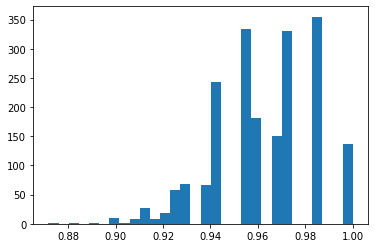

In [ ]:
array = [0.9848527349228611, 0.9861409796893668, 0.9862068965517242, 0.9710596314745853, 0.9572336873038136, 0.9532467532467532, 0.9848527349228611, 0.9263519668737061, 0.9269391571495358, 0.9137332838956865, 0.9424540976265116, 0.9429041546688606, 0.9848527349228611, 0.9394536497984773, 0.9576220818162348, 0.9407651013203076, 0.9572813593203398, 0.9710596314745853, 0.9572336873038136, 0.9710596314745853, 1.0, 0.9862068965517242, 0.9416991341991341, 0.9562068965517241, 1.0, 0.97, 0.9862068965517242, 0.944330461497362, 0.9574844006568146, 0.9576220818162348, 0.9427962286138036, 0.9286609941782356, 0.9555250783699061, 0.9545582047685833, 0.9693181818181819, 1.0, 0.9435263873439623, 0.9562068965517241, 0.9545582047685833, 1.0, 0.9848527349228611, 1.0, 0.9710596314745853, 0.9572336873038136, 0.9277411208862821, 1.0, 0.9416991341991341, 0.9848527349228611, 0.9394536497984773, 0.9415172413793103, 0.9532467532467532, 0.9555667913843665, 0.9861409796893668, 0.9555250783699061, 0.9710596314745853, 0.9862068965517242, 0.9710744627686158, 0.9553103448275863, 1.0, 0.9532467532467532, 0.9555250783699061, 0.97, 0.9427962286138036, 0.943828978367959, 0.9555250783699061, 0.9394536497984773, 0.9088515406162465, 0.9394536497984773, 1.0, 0.9389242878560718, 0.985103448275862, 0.9415056360708535, 0.9394536497984773, 0.9848527349228611, 0.9848527349228611, 0.9423809523809524, 0.9693181818181819, 0.985103448275862, 0.9532467532467532, 0.9713103448275863, 0.9416991341991341, 0.9562289562289562, 0.9848527349228611, 0.944330461497362, 0.9424540976265116, 0.9574844006568146, 0.9415172413793103, 0.9545582047685833, 0.943828978367959, 0.9848527349228611, 1.0, 0.9572336873038136, 0.9861409796893668, 0.9532467532467532, 0.9848527349228611, 0.9139376740201328, 0.9576220818162348, 0.9572336873038136, 0.9576220818162348, 0.9277411208862821, 1.0, 0.9268662372110649, 0.9848527349228611, 0.9555250783699061, 0.9723809523809525, 0.9710596314745853, 0.9423809523809524, 0.9861409796893668, 0.9713103448275863, 0.9427962286138036, 0.9277307774684086, 1.0, 1.0, 0.9562289562289562, 0.9723809523809525, 0.9848527349228611, 0.97, 0.9848527349228611, 0.9848527349228611, 1.0, 0.9713103448275863, 0.9226774847870182, 0.9394536497984773, 0.9555250783699061, 0.9562068965517241, 0.9562068965517241, 0.9229657898323567, 0.985103448275862, 0.9576220818162348, 0.9425324675324676, 0.9861409796893668, 0.9862068965517242, 0.9435263873439623, 0.9594628952804705, 0.9576220818162348, 0.9712592592592593, 0.9710596314745853, 0.9574844006568146, 0.9415172413793103, 0.9713969404186795, 0.9565365668813944, 0.9572336873038136, 0.9723809523809525, 0.9713969404186795, 0.9256277056277057, 0.9261986863711001, 1.0, 0.9576220818162348, 0.9269391571495358, 0.9555250783699061, 0.985103448275862, 0.9862068965517242, 0.9694453275154539, 0.9693181818181819, 0.9862068965517242, 0.9532467532467532, 0.9861409796893668, 0.9555250783699061, 0.9572336873038136, 0.9545582047685833, 0.9562068965517241, 0.9848527349228611, 0.9279638460339722, 0.9862068965517242, 0.9693181818181819, 1.0, 0.9848527349228611, 0.9572336873038136, 0.9710744627686158, 0.9557471264367816, 0.9261986863711001, 0.9407651013203076, 0.9129237902057374, 0.9848527349228611, 0.9401779110444778, 0.9304920634920635, 0.9848527349228611, 0.9415172413793103, 0.9562068965517241, 0.9394536497984773, 0.9424137931034483, 0.9576220818162348, 0.9532467532467532, 0.9710596314745853, 0.9861409796893668, 0.9848527349228611, 0.9862068965517242, 0.9710596314745853, 0.9532467532467532, 0.9553103448275863, 0.9407651013203076, 0.97, 0.9710596314745853, 0.9226774847870182, 0.9296969696969697, 0.9394536497984773, 0.9562289562289562, 0.9848527349228611, 0.9415172413793103, 1.0, 0.9723809523809525, 0.9088515406162465, 0.9286609941782356, 0.9833043478260869, 0.9407651013203076, 0.9693181818181819, 1.0, 0.9364705882352939, 0.9861409796893668, 0.9693181818181819, 1.0, 0.9723661210869221, 0.9555250783699061, 0.9123809523809523, 0.9693181818181819, 0.9394536497984773, 0.9562068965517241, 0.9848527349228611, 0.9693181818181819, 0.9710596314745853, 0.9693181818181819, 0.9248432601880878, 0.9256277056277057, 0.9248432601880878, 1.0, 0.9862068965517242, 0.9576220818162348, 0.9401779110444778, 0.9553103448275863, 0.9532467532467532, 0.9848527349228611, 0.9572336873038136, 0.9414285714285715, 0.9848527349228611, 0.9419259259259259, 0.9286609941782356, 1.0, 0.9713103448275863, 0.9562068965517241, 0.9710596314745853, 0.97, 0.9713969404186795, 0.9277411208862821, 0.9532467532467532, 0.9848527349228611, 0.9713969404186795, 0.9848527349228611, 0.9532467532467532, 0.9862068965517242, 0.9555250783699061, 0.9386363636363637, 0.9532467532467532, 0.9862068965517242, 0.9555250783699061, 0.9576220818162348, 0.9555250783699061, 0.9576220818162348, 0.9693181818181819, 1.0, 0.9848527349228611, 0.911017316017316, 0.9555250783699061, 0.9394536497984773, 0.9555667913843665, 0.9576220818162348, 1.0, 0.9848527349228611, 0.9713969404186795, 0.9555250783699061, 0.9418181818181818, 0.9862068965517242, 0.9555250783699061, 0.9572336873038136, 0.9394536497984773, 0.9862068965517242, 0.97, 1.0, 0.9545582047685833, 0.9394536497984773, 0.9713969404186795, 0.97, 0.9562289562289562, 0.9532467532467532, 0.9562068965517241, 0.9394536497984773, 1.0, 0.9848527349228611, 0.9416991341991341, 0.9848527349228611, 0.9226774847870182, 1.0, 0.97, 0.9562068965517241, 0.9848527349228611, 0.9555250783699061, 0.9404917522564581, 0.9256277056277057, 0.9555250783699061, 0.9862068965517242, 0.943828978367959, 0.9555250783699061, 0.9555250783699061, 0.9848527349228611, 0.9710596314745853, 0.985103448275862, 0.9848527349228611, 0.9848527349228611, 0.9862068965517242, 0.9710596314745853, 0.9555250783699061, 0.9394536497984773, 0.9723809523809525, 0.9710596314745853, 0.9562289562289562, 0.9562068965517241, 0.9848527349228611, 0.9848527349228611, 0.9574844006568146, 0.9572336873038136, 0.9532467532467532, 0.9423809523809524, 0.9416991341991341, 0.9693181818181819, 1.0, 1.0, 0.9713103448275863, 0.9555250783699061, 0.9693181818181819, 0.9562289562289562, 0.9226774847870182, 0.9862068965517242, 0.9710596314745853, 0.9848527349228611, 0.9585730176386462, 0.9424540976265116, 0.985103448275862, 0.9269391571495358, 0.9713103448275863, 0.9710596314745853, 1.0, 0.9693181818181819, 0.9427962286138036, 0.9713969404186795, 0.9848527349228611, 0.9723809523809525, 0.9848527349228611, 0.9416991341991341, 0.9226774847870182, 0.9423809523809524, 0.9572336873038136, 0.9562068965517241, 0.9555250783699061, 0.9574844006568146, 0.9562068965517241, 0.9555250783699061, 0.9562068965517241, 0.9423809523809524, 0.9256277056277057, 0.9862068965517242, 0.9424540976265116, 0.9121510673234813, 0.9557471264367816, 0.9364705882352939, 1.0, 0.9417624521072797, 0.8983579638752053, 0.9562289562289562, 0.9862068965517242, 0.943828978367959, 0.9226774847870182, 0.911017316017316, 0.9574844006568146, 0.9723809523809525, 1.0, 0.9710744627686158, 0.9572336873038136, 0.9848527349228611, 0.9256277056277057, 0.9554966106690245, 0.9713103448275863, 1.0, 1.0, 0.9713103448275863, 0.9861409796893668, 0.985103448275862, 0.9565710872162485, 0.9415172413793103, 0.9286609941782356, 0.9427962286138036, 0.9403498250874562, 0.9555250783699061, 0.9364705882352939, 0.9423809523809524, 0.9572336873038136, 0.9532467532467532, 0.9723809523809525, 0.97, 0.9710596314745853, 0.9723661210869221, 0.9693181818181819, 0.9681860682561945, 0.9693181818181819, 0.9562289562289562, 0.9693181818181819, 0.9693181818181819, 0.9555250783699061, 0.9562068965517241, 1.0, 0.9574844006568146, 0.9394536497984773, 0.9723661210869221, 0.9532467532467532, 0.9710596314745853, 1.0, 0.9693181818181819, 0.9713969404186795, 0.9693181818181819, 1.0, 1.0, 0.9862068965517242, 0.9861409796893668, 0.9862068965517242, 0.95838122605364, 0.9555250783699061, 0.985103448275862, 0.9723661210869221, 0.9423809523809524, 0.9404917522564581, 0.9681860682561945, 0.9572336873038136, 0.9555250783699061, 0.985103448275862, 0.9862068965517242, 0.9713103448275863, 0.9416991341991341, 0.9574844006568146, 0.9848527349228611, 0.9848527349228611, 0.9693181818181819, 0.9565365668813944, 0.9710596314745853, 0.9562289562289562, 1.0, 0.9576220818162348, 0.9710596314745853, 0.9710596314745853, 1.0, 1.0, 0.9862068965517242, 0.9562068965517241, 1.0, 0.9394536497984773, 0.9590804597701151, 0.9862068965517242, 0.9848527349228611, 0.9267168936540134, 0.9416991341991341, 0.9710596314745853, 0.9394536497984773, 0.9422334580510332, 0.9713103448275863, 0.9416991341991341, 0.9713103448275863, 0.9713969404186795, 0.9562068965517241, 0.9423809523809524, 0.9710596314745853, 0.9693181818181819, 0.9693181818181819, 0.943828978367959, 0.9394536497984773, 0.9862068965517242, 1.0, 0.9710596314745853, 0.9574844006568146, 0.9545582047685833, 0.9394536497984773, 0.9290031251655279, 0.9848527349228611, 0.9693181818181819, 0.9862068965517242, 0.9710596314745853, 0.97, 0.97, 0.9572336873038136, 0.9710596314745853, 0.9555250783699061, 0.9861409796893668, 0.9710596314745853, 0.9862068965517242, 0.9562068965517241, 0.9713103448275863, 0.9256277056277057, 1.0, 0.9562068965517241, 0.9848527349228611, 0.9572336873038136, 0.9416991341991341, 0.9862068965517242, 1.0, 0.9576220818162348, 0.9576220818162348, 0.9710596314745853, 0.9710596314745853, 1.0, 0.9848527349228611, 1.0, 0.9424540976265116, 0.9562289562289562, 0.9562068965517241, 1.0, 0.9848527349228611, 0.9386363636363637, 0.9555250783699061, 0.9423809523809524, 0.9710596314745853, 1.0, 0.8716560768980124, 0.9532467532467532, 1.0, 0.9848527349228611, 0.9424540976265116, 0.9240211640211641, 0.9848527349228611, 0.9577411294352824, 0.9848527349228611, 0.9848527349228611, 0.9693181818181819, 0.9710596314745853, 0.9848527349228611, 0.9572336873038136, 0.9710596314745853, 0.9407651013203076, 0.9848527349228611, 0.9555250783699061, 1.0, 1.0, 0.9555250783699061, 0.9723809523809525, 0.9590804597701151, 0.9574844006568146, 0.9693181818181819, 0.9226774847870182, 0.9442307692307692, 0.9416991341991341, 0.9848527349228611, 0.9862068965517242, 0.9424540976265116, 0.9710596314745853, 0.9415172413793103, 0.9576220818162348, 0.97, 0.9723661210869221, 1.0, 0.9415056360708535, 0.9406593406593406, 0.9848527349228611, 0.9576220818162348, 0.9693181818181819, 0.9713103448275863, 0.9532467532467532, 0.9713969404186795, 1.0, 0.9555250783699061, 0.9713969404186795, 0.9389242878560718, 0.9276912972085386, 0.9143579638752053, 0.9710596314745853, 0.9394536497984773, 0.9572336873038136, 0.9848527349228611, 0.9572336873038136, 0.9713103448275863, 0.9432756739909616, 0.9713969404186795, 1.0, 0.97, 0.9848527349228611, 0.9129237902057374, 1.0, 0.9723661210869221, 0.9862068965517242, 0.9572336873038136, 0.915431627196333, 0.9562068965517241, 0.9693181818181819, 0.9555250783699061, 0.9286609941782356, 0.9555250783699061, 0.9723661210869221, 0.9423809523809524, 0.9572336873038136, 0.9710596314745853, 0.9572336873038136, 0.9562289562289562, 0.9576220818162348, 0.9862068965517242, 1.0, 0.9693181818181819, 0.97, 0.9693181818181819, 0.9693181818181819, 0.9277411208862821, 0.9848527349228611, 0.9226774847870182, 0.9574844006568146, 0.9436912972085387, 0.9364705882352939, 0.9416991341991341, 0.9848527349228611, 0.9848527349228611, 0.9416991341991341, 0.9848527349228611, 0.9848527349228611, 0.9555250783699061, 0.9284229390681004, 0.9555250783699061, 0.9848527349228611, 0.9862068965517242, 0.9572336873038136, 0.9862068965517242, 0.9545582047685833, 0.9848527349228611, 0.9848527349228611, 0.9693181818181819, 0.9555250783699061, 0.9723661210869221, 0.9574844006568146, 0.9555250783699061, 0.9577411294352824, 0.9309971281640286, 0.9284229390681004, 0.9713969404186795, 0.9562068965517241, 0.9394536497984773, 0.9416991341991341, 0.9848527349228611, 0.9723661210869221, 0.9129237902057374, 1.0, 0.9713969404186795, 1.0, 0.9710596314745853, 0.9555250783699061, 0.9713103448275863, 0.9562068965517241, 1.0, 0.9710596314745853, 0.9862068965517242, 0.9532467532467532, 0.9713969404186795, 0.9710744627686158, 0.9862068965517242, 0.9226774847870182, 0.9259259259259259, 0.9693181818181819, 0.9848527349228611, 0.985103448275862, 0.985103448275862, 1.0, 0.9710744627686158, 0.9862068965517242, 0.9710596314745853, 0.9096794273264861, 0.9723809523809525, 0.9416991341991341, 0.9555250783699061, 1.0, 0.9572336873038136, 0.9572336873038136, 0.9226774847870182, 0.9693181818181819, 0.9555250783699061, 0.9848527349228611, 0.9562068965517241, 0.9848527349228611, 0.9532467532467532, 0.9848527349228611, 0.9862068965517242, 0.9713103448275863, 0.9545582047685833, 0.9710596314745853, 0.9848527349228611, 0.9404917522564581, 0.9261986863711001, 0.9416991341991341, 1.0, 0.9394536497984773, 0.9555250783699061, 1.0, 0.9424137931034483, 0.9394536497984773, 1.0, 0.9150896057347669, 0.9848527349228611, 0.9532467532467532, 0.9562068965517241, 0.9862068965517242, 0.9553103448275863, 0.9404917522564581, 0.9576220818162348, 0.9269391571495358, 0.9713103448275863, 0.9424540976265116, 0.955670468913009, 1.0, 0.9150368405540819, 0.9414285714285715, 0.9424540976265116, 0.9710596314745853, 1.0, 0.9267168936540134, 0.9256277056277057, 0.9848527349228611, 0.9584229390681003, 0.97, 0.9555250783699061, 1.0, 0.9271986863711001, 0.9562289562289562, 0.9861409796893668, 0.9557471264367816, 0.92923197492163, 0.9693181818181819, 0.9553103448275863, 0.9713103448275863, 0.9577411294352824, 0.9565365668813944, 0.9562289562289562, 0.9693181818181819, 0.9562068965517241, 0.9555250783699061, 0.9416991341991341, 0.9861409796893668, 0.9562068965517241, 0.9710596314745853, 1.0, 1.0, 0.9848527349228611, 0.9423809523809524, 1.0, 0.9555250783699061, 0.9693181818181819, 0.9555250783699061, 0.9124168374869637, 0.9848527349228611, 0.9862068965517242, 0.9713969404186795, 0.9545582047685833, 0.9723809523809525, 0.985103448275862, 0.9552300772690577, 0.9555250783699061, 1.0, 0.9862068965517242, 0.9532467532467532, 0.9417989417989417, 0.9862068965517242, 0.9584229390681003, 0.9693181818181819, 0.9576220818162348, 1.0, 0.9404917522564581, 0.9555250783699061, 0.9394536497984773, 0.9565710872162485, 0.9710744627686158, 1.0, 0.9572336873038136, 0.9695112443778111, 0.9862068965517242, 0.9432756739909616, 0.9710596314745853, 0.9427962286138036, 0.9407651013203076, 0.9562068965517241, 1.0, 1.0, 0.9555250783699061, 0.9710596314745853, 0.9693181818181819, 0.9710596314745853, 0.8976637948306954, 0.9286609941782356, 0.9555250783699061, 0.9713969404186795, 0.9710596314745853, 0.9710596314745853, 0.9723661210869221, 0.8928528217094461, 0.9713969404186795, 0.9574844006568146, 0.9848527349228611, 0.9576220818162348, 1.0, 0.9555250783699061, 0.9553103448275863, 0.9574844006568146, 0.9427962286138036, 0.9861409796893668, 0.9407651013203076, 0.9562289562289562, 0.9848527349228611, 0.9833043478260869, 0.943828978367959, 0.9565183220355633, 1.0, 0.9848527349228611, 0.9574844006568146, 0.9269391571495358, 0.9532467532467532, 0.9710744627686158, 0.9364705882352939, 0.9532467532467532, 0.9576637948306953, 0.9555250783699061, 0.9862068965517242, 0.9693181818181819, 0.9713969404186795, 0.9848527349228611, 0.9555250783699061, 0.8844444444444445, 0.9394536497984773, 0.9693181818181819, 0.9415172413793103, 0.9723661210869221, 0.9713103448275863, 0.9713969404186795, 0.9394536497984773, 0.9562068965517241, 1.0, 0.9710596314745853, 1.0, 0.985103448275862, 0.9723809523809525, 0.9848527349228611, 0.9576220818162348, 0.9248432601880878, 0.9713969404186795, 0.9862068965517242, 0.9555250783699061, 0.9862068965517242, 0.9394536497984773, 0.9710596314745853, 0.9407651013203076, 0.9576220818162348, 0.9142309797482213, 0.9693181818181819, 0.9405670206371468, 0.9565365668813944, 0.911017316017316, 0.9710596314745853, 0.911017316017316, 0.9416991341991341, 0.9713103448275863, 0.9424540976265116, 0.9594628952804705, 0.9555250783699061, 1.0, 0.9710596314745853, 0.97, 0.9723809523809525, 0.9562068965517241, 0.9713969404186795, 0.8994332326924095, 0.9565365668813944, 0.9862068965517242, 0.943828978367959, 0.9710596314745853, 0.985103448275862, 0.9576220818162348, 0.9710744627686158, 0.97, 0.9713103448275863, 0.943828978367959, 0.9244817473960968, 0.9576220818162348, 0.9710596314745853, 0.9572336873038136, 0.9713103448275863, 0.9562068965517241, 0.9713103448275863, 0.9424540976265116, 0.9555250783699061, 0.9565710872162485, 0.9713103448275863, 0.9424540976265116, 0.9848527349228611, 0.9286609941782356, 1.0, 0.9710596314745853, 0.9532467532467532, 0.9848527349228611, 0.9555250783699061, 1.0, 0.9862068965517242, 0.9848527349228611, 0.9728735632183909, 0.9861409796893668, 0.9862068965517242, 0.9710596314745853, 0.97, 0.9555250783699061, 0.9861409796893668, 0.9574844006568146, 0.9416991341991341, 0.9405670206371468, 0.9555250783699061, 0.9440037556979087, 1.0, 0.9712592592592593, 0.9572336873038136, 0.9710596314745853, 0.9710596314745853, 0.9723809523809525, 0.9693181818181819, 0.9577411294352824, 0.92923197492163, 0.9555250783699061, 0.9710596314745853, 0.9416991341991341, 0.9364705882352939, 0.9562068965517241, 0.9572336873038136, 0.9862068965517242, 1.0, 0.9693181818181819, 0.9424540976265116, 0.9545582047685833, 0.9693181818181819, 0.9862068965517242, 0.9693181818181819, 0.9562068965517241, 0.9848527349228611, 0.9562068965517241, 0.9862068965517242, 0.9066276803118909, 0.985103448275862, 0.9848527349228611, 0.9291699961071158, 0.9277411208862821, 0.9562068965517241, 0.9576220818162348, 0.9432756739909616, 0.9565710872162485, 0.9848527349228611, 0.9562068965517241, 0.9861409796893668, 0.9555250783699061, 0.97, 0.9394536497984773, 0.9267168936540134, 0.9562068965517241, 0.9440737327188942, 0.9862068965517242, 0.9562068965517241, 0.9693181818181819, 0.9693181818181819, 0.9574844006568146, 0.9848527349228611, 0.9710596314745853, 0.9862068965517242, 0.9574844006568146, 0.9710596314745853, 0.9111484140627635, 0.9394536497984773, 0.9713103448275863, 0.9723661210869221, 0.9394536497984773, 0.9532467532467532, 0.9862068965517242, 0.9848527349228611, 0.9572336873038136, 0.9424540976265116, 0.9419259259259259, 0.9710596314745853, 0.9862068965517242, 0.9139784946236558, 0.9710596314745853, 0.9407651013203076, 0.9416991341991341, 0.9693181818181819, 0.9848527349228611, 0.9562289562289562, 0.9562068965517241, 0.9710596314745853, 0.9116696923148536, 0.9710596314745853, 0.9424540976265116, 0.9555250783699061, 0.9277307774684086, 0.9710596314745853, 0.9407651013203076, 0.9862068965517242, 0.9713969404186795, 0.9423809523809524, 0.9415056360708535, 0.9862068965517242, 0.9693181818181819, 0.985103448275862, 0.9416991341991341, 1.0, 0.9289503599848427, 0.9693181818181819, 0.9555250783699061, 0.9562289562289562, 0.9862068965517242, 0.9585730176386462, 0.9256277056277057, 0.9693181818181819, 0.9532467532467532, 0.9703296703296702, 0.9562068965517241, 0.9555250783699061, 0.9562289562289562, 0.9723809523809525, 1.0, 0.9710596314745853, 0.9576220818162348, 0.985103448275862, 0.9723809523809525, 0.9404917522564581, 0.9576220818162348, 0.9226774847870182, 0.9562068965517241, 0.9543929648079186, 0.9277307774684086, 0.9693181818181819, 0.9562068965517241, 0.9545582047685833, 0.9286609941782356, 0.9848527349228611, 0.9269391571495358, 0.9553103448275863, 0.9585730176386462, 0.9848527349228611, 0.9555250783699061, 0.9572336873038136, 0.97, 0.9693181818181819, 0.9848527349228611, 0.9710596314745853, 0.97, 0.9574844006568146, 0.97, 0.9862068965517242, 1.0, 0.9585730176386462, 0.9407651013203076, 0.9848527349228611, 0.9572336873038136, 0.9710744627686158, 0.9693181818181819, 0.955670468913009, 0.9723809523809525, 0.9562068965517241, 0.9848527349228611, 0.9848527349228611, 0.9703296703296702, 0.9154761904761906, 0.9259259259259259, 0.9693181818181819, 0.9088515406162465, 0.9723809523809525, 0.943828978367959, 0.95838122605364, 0.9256277056277057, 0.9576220818162348, 0.9289001247176998, 0.9545582047685833, 0.9710596314745853, 1.0, 0.9693181818181819, 0.9427434634331187, 0.9861409796893668, 0.9848527349228611, 0.9693181818181819, 0.9713969404186795, 0.9555250783699061, 0.9276912972085386, 0.9572336873038136, 0.9562068965517241, 0.9432756739909616, 0.9693181818181819, 0.9713969404186795, 0.9574844006568146, 0.9139310344827585, 0.9547302737520129, 0.9710596314745853, 0.9848527349228611, 0.9710596314745853, 0.9424540976265116, 0.9532467532467532, 0.9423809523809524, 0.9532467532467532, 0.9693181818181819, 0.9416991341991341, 1.0, 0.9862068965517242, 0.9565365668813944, 0.9282253977906152, 0.9416991341991341, 1.0, 0.9404917522564581, 0.9862068965517242, 0.9723661210869221, 0.9440737327188942, 0.9723809523809525, 0.9723809523809525, 0.9555250783699061, 0.9555250783699061, 0.9862068965517242, 0.9299154589371981, 0.9555250783699061, 0.9423809523809524, 0.9693181818181819, 0.97, 0.9693181818181819, 0.9407651013203076, 0.9710596314745853, 0.9090329835082459, 1.0, 0.9423809523809524, 0.9693181818181819, 0.9848527349228611, 0.9576220818162348, 0.9299154589371981, 0.9129237902057374, 0.9848527349228611, 1.0, 0.9848527349228611, 0.9713969404186795, 0.9862068965517242, 0.9723661210869221, 0.9299154589371981, 0.9037063492063492, 1.0, 0.9286609941782356, 0.97, 0.9415172413793103, 0.9848527349228611, 0.9572336873038136, 0.9574844006568146, 0.9532467532467532, 0.9713969404186795, 0.9416991341991341, 0.9710596314745853, 0.9862068965517242, 0.9848527349228611, 0.9299154589371981, 0.9710596314745853, 0.9416991341991341, 0.9848527349228611, 1.0, 0.9416991341991341, 0.9424137931034483, 0.9557471264367816, 0.9848527349228611, 0.9111403303724481, 0.922077922077922, 0.985103448275862, 0.9710596314745853, 0.9555667913843665, 0.9572336873038136, 0.9848527349228611, 0.901583789210564, 0.9299154589371981, 0.9555250783699061, 0.9565710872162485, 0.9713969404186795, 1.0, 0.9848527349228611, 0.9424540976265116, 0.9576220818162348, 0.9281510673234811, 0.9532467532467532, 0.9861409796893668, 0.9394536497984773, 0.9710596314745853, 0.9723661210869221, 0.9713103448275863, 0.9862068965517242, 0.9848527349228611, 0.9848527349228611, 0.9862068965517242, 0.9268398268398268, 0.9848527349228611, 0.97, 0.9862068965517242, 0.97, 0.9407651013203076, 0.9416991341991341, 0.9394536497984773, 0.9862068965517242, 0.9710596314745853, 0.9562068965517241, 0.9710596314745853, 0.9861409796893668, 0.9710596314745853, 0.9577411294352824, 0.9848527349228611, 0.9713103448275863, 0.9572336873038136, 0.9710596314745853, 0.9710596314745853, 0.8974775224775225, 0.9256277056277057, 0.9416991341991341, 1.0, 0.9394536497984773, 0.9269391571495358, 0.9848527349228611, 0.9693181818181819, 0.9562068965517241, 0.9693181818181819, 0.9713103448275863, 0.9723809523809525, 0.9710596314745853, 0.9228004179728317, 0.9723809523809525, 0.9693181818181819, 0.9710596314745853, 0.9555250783699061, 0.9862068965517242, 0.9424540976265116, 0.9277411208862821, 0.9555250783699061, 0.9710596314745853, 0.9703296703296702, 0.9848527349228611, 0.941404133098286, 0.9135393342289895, 0.9848527349228611, 0.97, 0.9273370890312419, 0.9713969404186795, 0.9848527349228611, 0.9555250783699061, 0.9565710872162485, 0.9553103448275863, 0.9394536497984773, 0.9862068965517242, 0.9407651013203076, 0.9424540976265116, 0.9576220818162348, 0.9574844006568146, 0.9703296703296702, 0.9710596314745853, 0.9848527349228611, 0.9862068965517242, 0.9288227901131126, 0.9269391571495358, 0.9723809523809525, 0.9710596314745853, 0.9532467532467532, 0.9394536497984773, 0.9710596314745853, 0.9416991341991341, 0.97, 0.9427106227106228, 0.9248432601880878, 0.9424540976265116, 0.9256277056277057, 0.9423809523809524, 0.9407651013203076, 0.9585730176386462, 0.9277307774684086, 1.0, 0.9693181818181819, 0.985103448275862, 0.9555250783699061, 0.9574844006568146, 0.9713969404186795, 0.9574844006568146, 0.9862068965517242, 0.9439480259870064, 0.9572336873038136, 0.9861409796893668, 0.9532467532467532, 0.9574844006568146, 0.9562068965517241, 0.9710596314745853, 0.9403498250874562, 0.9862068965517242, 0.9848527349228611, 0.9862068965517242, 0.9862068965517242, 0.9532467532467532, 0.9848527349228611, 0.9848527349228611, 1.0, 0.9848527349228611, 0.9713969404186795, 0.9415172413793103, 0.9710596314745853, 0.9710596314745853, 0.9574844006568146, 0.9572336873038136, 0.9555250783699061, 0.9693181818181819, 0.9404917522564581, 0.9848527349228611, 0.9710596314745853, 0.9436912972085387, 0.9862068965517242, 0.9862068965517242, 1.0, 0.9394536497984773, 0.9435263873439623, 0.9721153846153847, 0.9848527349228611, 0.9532467532467532, 0.9723809523809525, 0.985103448275862, 0.9555250783699061, 0.9419259259259259, 0.9723809523809525, 0.9416991341991341, 0.9432756739909616, 1.0, 0.9364705882352939, 0.9723661210869221, 0.9565365668813944, 1.0, 0.9577411294352824, 0.9713969404186795, 0.9574844006568146, 0.9572336873038136, 0.9848527349228611, 0.9693181818181819, 0.9576220818162348, 1.0, 0.9848527349228611, 0.9394536497984773, 0.9555250783699061, 0.9555250783699061, 0.9269391571495358, 0.9710596314745853, 1.0, 0.97, 0.9694453275154539, 0.9848527349228611, 0.9299154589371981, 0.9862068965517242, 0.9848527349228611, 0.9710744627686158, 0.9862068965517242, 0.9532467532467532, 1.0, 0.9848527349228611, 0.9712592592592593, 0.9407651013203076, 0.9710596314745853, 1.0, 0.9555250783699061, 0.97, 0.9545582047685833, 0.9407651013203076, 0.9423809523809524, 0.9555250783699061, 0.9576220818162348, 0.9693181818181819, 0.985103448275862, 0.9693181818181819, 0.9424540976265116, 0.9723661210869221, 0.9848527349228611, 0.9576220818162348, 0.9833043478260869, 1.0, 0.9848527349228611, 0.9277411208862821, 0.9710596314745853, 0.9862068965517242, 0.9710596314745853, 0.9848527349228611, 0.9584229390681003, 1.0, 0.9555250783699061, 0.9394536497984773, 0.9723809523809525, 0.9424540976265116, 0.9256277056277057, 0.9088515406162465, 1.0, 0.9256277056277057, 1.0, 0.9848527349228611, 0.9848527349228611, 0.944330461497362, 0.9710596314745853, 0.9710596314745853, 0.9723809523809525, 0.9256277056277057, 0.9713103448275863, 1.0, 0.9260523584361666, 1.0, 0.9286609941782356, 0.9693181818181819, 0.9424540976265116, 1.0, 0.9404917522564581, 0.943828978367959, 0.9848527349228611, 0.9576220818162348, 0.9576220818162348, 0.9848527349228611, 0.9432756739909616, 0.9862068965517242, 0.9562068965517241, 0.927016491754123, 0.9576220818162348, 0.9555250783699061, 1.0, 0.985103448275862, 0.97, 0.9710596314745853, 0.9424540976265116, 0.9565710872162485, 0.9416991341991341, 0.9394536497984773, 0.9710596314745853, 0.9693181818181819, 0.9710596314745853, 0.943828978367959, 0.9572336873038136, 0.8990102707749766, 0.9713969404186795, 0.985103448275862, 0.9693181818181819, 0.9713103448275863, 0.9723809523809525, 0.985103448275862, 0.9713969404186795, 0.9576220818162348, 0.9555250783699061, 0.9713969404186795, 1.0, 0.9394536497984773, 0.9728735632183909, 0.9862068965517242, 0.9555250783699061, 0.9848527349228611, 0.97, 0.985103448275862, 0.9553103448275863, 0.9848527349228611, 0.9862068965517242, 0.9710596314745853, 0.9226774847870182, 0.9555250783699061, 1.0, 0.9394536497984773, 0.9848527349228611, 0.9713103448275863, 0.9848527349228611, 0.9576220818162348, 0.9712592592592593, 0.9723661210869221, 0.9848527349228611, 0.9723809523809525, 0.9424540976265116, 0.985103448275862, 0.9562289562289562, 0.9395320197044335, 0.9555250783699061, 0.9576220818162348, 0.9147474747474748, 0.9117887484829014, 0.9584229390681003, 0.9226774847870182, 0.9693181818181819, 0.9407651013203076, 0.9861409796893668, 0.9723661210869221, 1.0, 0.9555250783699061, 0.9407651013203076, 0.9710596314745853, 0.9015714170886584, 0.9555250783699061, 0.9248432601880878, 0.9147474747474748, 0.9862068965517242, 0.9862068965517242, 0.9565710872162485, 0.9723809523809525, 0.9710596314745853, 0.9713969404186795, 0.9713103448275863, 0.9576220818162348, 0.9693181818181819, 0.9572336873038136, 0.9848527349228611, 0.9532467532467532, 1.0, 0.9423809523809524, 0.9415172413793103, 0.9723809523809525, 0.9710596314745853, 0.912919116478627, 0.9574844006568146, 0.9267168936540134, 0.9710596314745853, 0.9277411208862821, 0.9407651013203076, 0.9862068965517242, 0.9532467532467532, 0.9848527349228611, 0.9290031251655279, 0.9555250783699061, 0.9710596314745853, 0.9427106227106228, 0.940955415149568, 0.9555250783699061, 0.9723661210869221, 0.9848527349228611, 0.9532467532467532, 0.9405670206371468, 1.0, 0.9723661210869221, 0.9848527349228611, 0.9703296703296702, 0.9424540976265116, 0.9703296703296702, 0.9713969404186795, 0.9848527349228611, 0.9555250783699061, 0.97, 0.9416991341991341, 0.9572336873038136, 0.9226774847870182, 0.9693181818181819, 0.9284229390681004, 0.9710596314745853, 0.9862068965517242, 0.9713103448275863, 0.9861409796893668, 0.9713969404186795, 0.9862068965517242, 0.9248432601880878, 0.9404917522564581, 0.9256277056277057, 0.9723809523809525, 0.9861409796893668, 0.9710596314745853, 0.985103448275862, 0.9576220818162348, 0.9562068965517241, 0.97, 0.9572336873038136, 0.9532467532467532, 0.9441523993248131, 0.9553103448275863, 0.9723809523809525, 0.9848527349228611, 0.9562068965517241, 0.9572336873038136, 0.9712592592592593, 0.9723809523809525, 0.9576220818162348, 0.9848527349228611, 0.9424540976265116, 0.9532467532467532, 0.9572336873038136, 0.9848527349228611, 0.9713103448275863, 0.985103448275862, 0.9416991341991341, 0.9562289562289562, 0.9713103448275863, 0.9710596314745853, 0.9555250783699061, 0.9848527349228611, 0.9400000000000001, 0.9862068965517242, 0.9848527349228611, 0.9562068965517241, 0.9862068965517242, 0.9710596314745853, 0.9723809523809525, 1.0, 0.9088515406162465, 0.9160483870967742, 0.9861409796893668, 0.9267168936540134, 0.9532467532467532, 0.9710596314745853, 0.9713103448275863, 0.9555250783699061, 0.9407651013203076, 0.9862068965517242, 0.9862068965517242, 0.9555250783699061, 0.9248432601880878, 0.9848527349228611, 0.9562289562289562, 0.9555250783699061, 0.9532467532467532, 1.0, 0.9576220818162348, 0.9407651013203076, 0.9565365668813944, 0.9862068965517242, 0.9562068965517241, 0.9723661210869221, 1.0, 0.9848527349228611, 0.9555250783699061, 0.9710596314745853, 0.9848527349228611, 0.9286609941782356, 0.9713969404186795, 0.9532467532467532, 0.9848527349228611, 1.0, 1.0, 0.9576220818162348, 0.943828978367959, 0.9572336873038136, 0.9728735632183909, 0.9545582047685833, 0.9710596314745853, 0.9424540976265116, 0.9693181818181819, 0.9723809523809525, 0.985103448275862, 0.9710596314745853, 0.9723661210869221, 0.9710596314745853, 0.9710596314745853, 0.9562068965517241, 0.985103448275862, 0.985103448275862, 0.9710596314745853, 0.9710744627686158, 0.9710596314745853, 0.9424540976265116, 1.0, 0.9416991341991341, 0.9713969404186795, 0.9710596314745853, 0.9693181818181819, 0.9713103448275863, 0.9710596314745853, 0.9862068965517242, 0.9555250783699061, 0.9862068965517242, 0.9532467532467532, 0.9848527349228611, 0.9574844006568146, 0.9555250783699061, 0.9693181818181819, 0.9693181818181819, 0.9713969404186795, 0.9848527349228611, 0.9713969404186795, 0.9415172413793103, 0.9532467532467532, 0.9710596314745853, 0.97, 0.9424540976265116, 0.9555250783699061, 0.9723809523809525, 0.9562068965517241, 0.9394536497984773, 0.9693181818181819, 0.8994332326924095, 0.9562068965517241, 0.9576220818162348, 0.9693181818181819, 0.9574844006568146, 0.9116696923148536, 0.9693181818181819, 0.985103448275862, 0.9574844006568146, 0.9555667913843665, 0.9386363636363637, 0.9861409796893668, 0.9710596314745853, 0.97, 0.9248432601880878, 0.9553103448275863, 0.9424540976265116, 0.9723809523809525, 0.9703296703296702, 0.9416991341991341, 0.9562068965517241, 0.9555250783699061, 0.9307487922705315, 0.9710596314745853, 0.9555250783699061, 0.97, 0.9562068965517241, 0.9395320197044335, 0.9576220818162348, 0.9394536497984773, 1.0, 0.9416991341991341, 0.931328978367959, 0.9710596314745853, 1.0, 0.9562068965517241, 0.9562068965517241, 0.9572336873038136, 0.9273692646764176, 0.97, 0.9562068965517241, 0.9710596314745853, 0.9545582047685833, 0.9555250783699061, 0.9290031251655279, 0.9427962286138036, 0.9555250783699061, 0.9532467532467532, 0.9436912972085387, 0.9555250783699061, 0.9713103448275863, 0.9713103448275863, 0.9555250783699061, 0.9562289562289562, 0.9555250783699061, 0.9577411294352824, 0.9555667913843665, 0.9407651013203076, 0.9407651013203076, 0.9416991341991341, 0.9432756739909616, 0.9545582047685833, 0.9848527349228611, 0.9286609941782356, 0.9848527349228611, 0.9713103448275863, 0.9404917522564581, 0.9693181818181819, 0.9545582047685833, 0.9394536497984773, 0.9723809523809525, 0.9423809523809524, 1.0, 0.9693181818181819, 0.9848527349228611, 0.9862068965517242, 0.9290031251655279, 0.9394536497984773, 0.9713103448275863, 0.9862068965517242, 1.0, 0.9693181818181819, 0.9555250783699061, 0.9555250783699061, 0.9562068965517241, 0.9712592592592593, 0.9576220818162348, 0.97, 0.9424137931034483, 0.9848527349228611, 0.9578181818181818, 0.9545582047685833, 0.9572336873038136, 0.9555250783699061, 0.9416991341991341, 0.9407651013203076, 0.9574844006568146, 0.9394536497984773, 0.9532467532467532, 0.9848527349228611, 0.9862068965517242, 0.9277411208862821, 0.9848527349228611, 0.9693181818181819, 0.9723661210869221, 0.9277411208862821, 0.97, 0.9574844006568146, 0.9710596314745853, 0.9286609941782356, 0.9576220818162348, 0.9848527349228611, 0.9432756739909616, 0.9116696923148536, 0.9710596314745853, 0.9862068965517242, 0.9710596314745853, 0.9427962286138036, 0.9284229390681004, 0.9147474747474748, 0.9713969404186795, 0.9710596314745853, 0.9693181818181819, 0.9267168936540134, 0.9404917522564581, 0.9576220818162348, 0.97, 0.9862068965517242, 0.9424137931034483, 0.97, 0.9712592592592593, 0.9562289562289562, 0.9277307774684086, 0.9848527349228611, 0.9555250783699061, 0.985103448275862, 0.9576220818162348, 0.9572336873038136, 0.9862068965517242, 0.9710596314745853, 0.9710596314745853, 0.985103448275862, 0.9532467532467532, 0.9555250783699061, 0.97, 0.9565710872162485, 0.9276912972085386, 1.0, 1.0, 0.9423809523809524, 0.9710596314745853, 0.9555250783699061, 0.9695112443778111, 0.9006090683510038, 0.97, 0.9862068965517242, 1.0, 0.9576220818162348, 0.9572336873038136, 0.9532467532467532, 0.9532467532467532, 0.9286609941782356, 0.9532467532467532, 0.9572336873038136, 0.9394536497984773, 0.9562068965517241, 0.9555250783699061, 0.9240211640211641, 0.9723661210869221, 0.9862068965517242, 0.9562289562289562, 0.9710596314745853, 0.9862068965517242, 0.9723809523809525, 0.9572336873038136, 0.9416991341991341, 0.9290835041536305, 0.9403498250874562, 0.9432756739909616, 0.9565710872162485, 1.0, 0.9440737327188942, 0.9286609941782356, 0.9116696923148536, 0.9404917522564581, 0.9710596314745853, 0.985103448275862, 0.9250983436853002, 0.9693181818181819, 0.9147474747474748, 0.9416991341991341, 0.97, 0.9286609941782356, 0.9848527349228611, 0.9543929648079186, 0.9286609941782356, 0.9713969404186795, 0.9572336873038136, 0.9562068965517241, 0.9862068965517242, 0.9562289562289562, 0.9129237902057374, 1.0, 0.9710596314745853, 0.9585730176386462, 0.9585730176386462, 0.97, 0.9710596314745853, 0.9416991341991341, 0.9562068965517241, 0.9713103448275863, 0.9424540976265116, 0.9584229390681003, 0.9723661210869221, 0.9713969404186795, 0.97, 0.9862068965517242, 0.9572336873038136, 0.9395320197044335, 0.9562289562289562, 0.9848527349228611, 0.9693181818181819, 0.9532467532467532, 0.985103448275862, 0.9407651013203076, 0.9710596314745853, 0.9267168936540134, 0.9848527349228611, 0.9271986863711001, 0.9555250783699061, 0.985103448275862, 0.9695112443778111, 0.9422334580510332, 0.9848527349228611, 0.985103448275862, 0.9404917522564581, 0.9693181818181819, 0.9713103448275863, 0.943828978367959, 0.9427962286138036, 0.9861409796893668, 0.9422334580510332, 0.9848527349228611, 0.9422334580510332, 0.9572336873038136, 0.9862068965517242, 0.9710596314745853, 1.0, 0.9693181818181819, 0.9862068965517242, 0.8996969696969698, 0.97, 0.9848527349228611, 0.9710596314745853, 0.9723661210869221, 0.9416991341991341, 0.9555250783699061, 0.9848527349228611, 0.9407651013203076, 0.9226774847870182, 0.9723661210869221, 0.9848527349228611, 1.0, 0.9710596314745853, 0.9416991341991341, 0.9416991341991341, 0.9555250783699061, 0.9553103448275863, 0.9848527349228611, 0.9565710872162485, 0.9562289562289562, 0.9407651013203076, 0.9416991341991341, 1.0, 0.9848527349228611, 0.9848527349228611, 0.9290835041536305, 0.9693181818181819, 0.9555250783699061, 0.9562068965517241, 0.9713969404186795, 0.9572336873038136, 0.9862068965517242, 0.9532467532467532, 0.9096794273264861, 0.9574844006568146, 0.9416991341991341, 0.9555250783699061, 0.944330461497362, 0.9562289562289562, 0.9848527349228611, 0.9309971281640286, 0.9862068965517242, 0.9693181818181819, 0.9574844006568146, 0.9572336873038136, 0.9713103448275863, 0.9572336873038136, 0.9266090073242947, 0.9576220818162348, 0.9404917522564581, 0.9440037556979087, 0.9710596314745853, 0.9710596314745853, 0.9553103448275863, 0.9256277056277057, 0.9584229390681003, 0.9394536497984773, 0.9862068965517242, 0.9440037556979087, 0.9848527349228611, 0.9862068965517242, 0.9576220818162348, 0.9364705882352939, 0.9585730176386462, 0.9555250783699061, 0.9261986863711001, 0.9710596314745853, 0.9574844006568146, 0.9693181818181819, 0.9424540976265116, 0.9424540976265116, 0.9710596314745853, 0.9394536497984773, 0.985103448275862, 1.0, 0.9562068965517241, 0.9562068965517241, 0.9574844006568146, 0.9226774847870182, 0.9693181818181819]

plt.hist(array, bins=30)

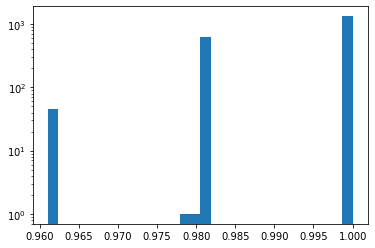

In [ ]:
array = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 0.9618181818181817, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9618181818181817, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 0.9618181818181819, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9618181818181817, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 0.980952380952381, 0.980952380952381, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 0.9618181818181817, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 0.980952380952381, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9618181818181817, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 0.980952380952381, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9789473684210528, 1.0, 1.0, 0.980952380952381, 0.980952380952381, 0.9807780320366133, 1.0, 0.9807780320366133, 0.9618181818181817, 0.9807780320366133, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9618181818181817, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 1.0, 0.9618181818181817, 0.980952380952381, 0.9807780320366133, 1.0, 0.9618181818181819, 1.0, 1.0, 0.980952380952381, 0.9618181818181817, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 0.980952380952381, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 0.9618181818181819, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 0.9618181818181817, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 1.0, 1.0, 0.9618181818181817, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 0.9618181818181817, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 0.9618181818181817, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 0.980952380952381, 0.980952380952381, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9618181818181817, 0.980952380952381, 0.9807780320366133, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 0.961111111111111, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9618181818181817, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 0.9618181818181817, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.979539641943734, 1.0, 0.9618181818181817, 0.980952380952381, 0.9807780320366133, 0.9618181818181817, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 0.980952380952381, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 0.9807780320366133, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 0.9807780320366133, 0.9618181818181817, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 0.9618181818181817, 0.980952380952381, 0.980952380952381, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 0.961111111111111, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9618181818181817, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9618181818181817, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9618181818181817, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 0.9807780320366133, 1.0, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 0.9618181818181817, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 0.9618181818181817, 0.980952380952381, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 0.980952380952381, 0.9807780320366133, 0.980952380952381, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9618181818181817, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9618181818181817, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 0.9618181818181817, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 0.9807780320366133, 0.9807780320366133, 0.980952380952381, 0.9807780320366133, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 0.9618181818181817, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9618181818181817, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.980952380952381, 0.9618181818181817, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 0.9618181818181817, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9618181818181817, 1.0, 0.980952380952381, 1.0, 1.0, 0.9618181818181817, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 0.9807780320366133, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 1.0, 0.9618181818181817, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 0.980952380952381, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 0.980952380952381, 0.9618181818181817, 0.9807780320366133, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9618181818181817, 1.0, 1.0, 0.980952380952381, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 0.9807780320366133, 0.980952380952381, 0.980952380952381, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133, 1.0, 0.9807780320366133, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 1.0, 0.9807780320366133, 0.9618181818181817, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 0.980952380952381, 0.9618181818181819, 0.9618181818181817, 0.9807780320366133, 0.9807780320366133, 0.980952380952381, 1.0, 0.980952380952381, 1.0, 0.9807780320366133, 0.980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9807780320366133]

plt.hist(array, bins=30)
plt.yscale('log')

In [ ]:
# for name in ['albumin', 'fibrinogen', 'fibrinogen&albumin']:
for name in names:
    for tag in ("before", "after"):
        print(name, tag, final_result[name][tag], "\n")

albumin before ({'LDA': 0.98, 'SVM': 0.99, 'RandomForest': 0.985}, {'LDA': 0.0404040404040404, 'SVM': 0.045405197328548724, 'RandomForest': 0.036067820346176005}) 

albumin after ({'LDA': 0.988, 'SVM': 1.0, 'RandomForest': 1.0}, {'LDA': 0.03506493506493508, 'SVM': 0.0, 'RandomForest': 0.0}) 

fibrinogen before ({'LDA': 0.973, 'SVM': 0.963, 'RandomForest': 0.949}, {'LDA': 0.014782099646422698, 'SVM': 0.016798900330892128, 'RandomForest': 0.025027726575800196}) 

fibrinogen after ({'LDA': 0.979, 'SVM': 0.989, 'RandomForest': 0.93}, {'LDA': 0.018516674510095546, 'SVM': 0.012684720127421726, 'RandomForest': 0.03721820961530691}) 



In [ ]:
file_name = "metrics/final_metrics_second_dataset.pickle"

with open(file_name, 'rb') as f:
    result = pickle.load(f)
    
names = ['fibrinogen']

for name in names:
    for tag in ("before", "after"):
        final_result[name][tag] = analyse_metrics(result[tag])
        print("--------------", name, tag, final_result[name][tag])

-------------- fibrinogen before ({'LDA': 0.944, 'SVM': 0.968, 'RandomForest': 0.838}, {'LDA': 0.045191646406910674, 'SVM': 0.0380791055486023, 'RandomForest': 0.07570848437244747})
-------------- fibrinogen after ({'LDA': 0.971, 'SVM': 0.995, 'RandomForest': 0.881}, {'LDA': 0.028780571197762752, 'SVM': 0.016037104106228196, 'RandomForest': 0.06607898985704362})


In [ ]:
result

{'before': [{'LDA': {'class 1.0': {'precision': 0.9090909090909091,
     'recall': 1.0,
     'f1-score': 0.9523809523809523,
     'support': 10},
    'class 2.0': {'precision': 1.0,
     'recall': 0.9,
     'f1-score': 0.9473684210526316,
     'support': 10},
    'class 3.0': {'precision': 1.0,
     'recall': 1.0,
     'f1-score': 1.0,
     'support': 10},
    'accuracy': 0.9666666666666667,
    'macro avg': {'precision': 0.9696969696969697,
     'recall': 0.9666666666666667,
     'f1-score': 0.9665831244778613,
     'support': 30},
    'weighted avg': {'precision': 0.9696969696969696,
     'recall': 0.9666666666666667,
     'f1-score': 0.9665831244778613,
     'support': 30},
    'confusion_matrix': array([[10,  0,  0],
           [ 1,  9,  0],
           [ 0,  0, 10]])},
   'SVM': {'class 1.0': {'precision': 1.0,
     'recall': 1.0,
     'f1-score': 1.0,
     'support': 10},
    'class 2.0': {'precision': 1.0,
     'recall': 0.9,
     'f1-score': 0.9473684210526316,
     'support': 1

In [ ]:
file_name = "metrics/final_metrics_first_dataset.pickle"

with open(file_name, 'wb') as f:
    pickle.dump(result, f)

In [ ]:
def make_confusion_matrix(
    cf,
    group_names=None,
    categories='auto',
    count=True,
    percent=True,
    cbar=True,
    xyticks=True,
    xyplotlabels=True,
    sum_stats=True,
    figsize=None,
    cmap='Blues',
    title=None,
    base_font_size=10,
):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.2f}".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
#         print(np.ones((cf.shape[0], cf.shape[0]))*np.sum(cf, axis=1).reshape(1, -1))
        new_cf = [
            value for value in cf.flatten()/(np.ones(cf.shape)*np.sum(cf, axis=1).reshape(1, -1)).flatten()
        ]
        group_percentages = ["{0:.2%}\n".format(value) for value in new_cf]
        new_cf = np.array(new_cf).reshape(cf.shape)
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_percentages,group_counts)]
#     print(box_labels)
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


#     # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
#     if figsize==None:
#         #Get default figure size if not set
#         figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize, dpi=300)
#     print(box_labels)
    res = sns.heatmap(
        new_cf,
        annot=box_labels,
        fmt='',
        cmap=cmap,
        cbar=cbar,
        xticklabels=categories,
        yticklabels=categories,
        annot_kws={
                'fontsize': base_font_size*1.6
        }
    )
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = base_font_size*1.3)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = base_font_size*1.3)

    if xyplotlabels:
        plt.ylabel('True label', fontsize=base_font_size*1.5)
        plt.xlabel('Predicted label' + stats_text, fontsize=base_font_size*1.5)
    else:
        plt.xlabel(stats_text, fontsize=base_font_size*1.5)
    
    if title:
        plt.title(title, fontsize=base_font_size*2.5)
        

In [ ]:
def get_confusion_matrix(
    metric_array,
    model,
    counts=20
):
#     print(len(metric_array), len(components))
    tags = ["before", "after"]
    result_dict = {
        tag: np.zeros_like(
            metric_array[tag][0][model]['confusion_matrix']
        ) for tag in tags
    }
#     print(len(metric_array), len(components))
    for tag in tags:
        for i in range(len(metric_array[tag])):
            np.add(
                result_dict[tag], 
                metric_array[tag][i][model]['confusion_matrix'], 
                out=result_dict[tag], 
                casting="unsafe"
            )
#         result_matrix += metric_array[component][model]['confusion_matrix']
        result_dict[tag] = result_dict[tag].astype('float64')
        result_dict[tag] /= counts
        result_dict[tag] = np.round(result_dict[tag], 3)
    
    return result_dict

In [ ]:
result['albumin']["before"][0]["LDA"]["confusion_matrix"]

array([[5, 0],
       [1, 4]])

In [ ]:
cfs = get_confusion_matrix(
    result['albumin'],
    "SVM"
)

[[4.9 0.1]
 [0.  5. ]]
[[5. 0.]
 [0. 4.]]


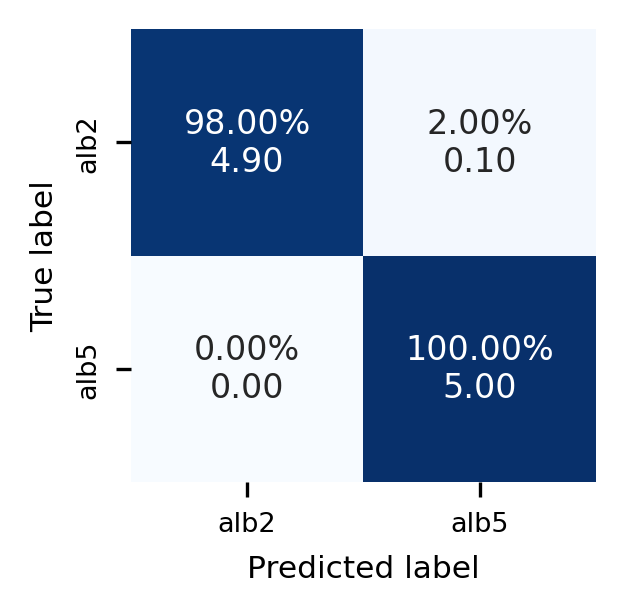

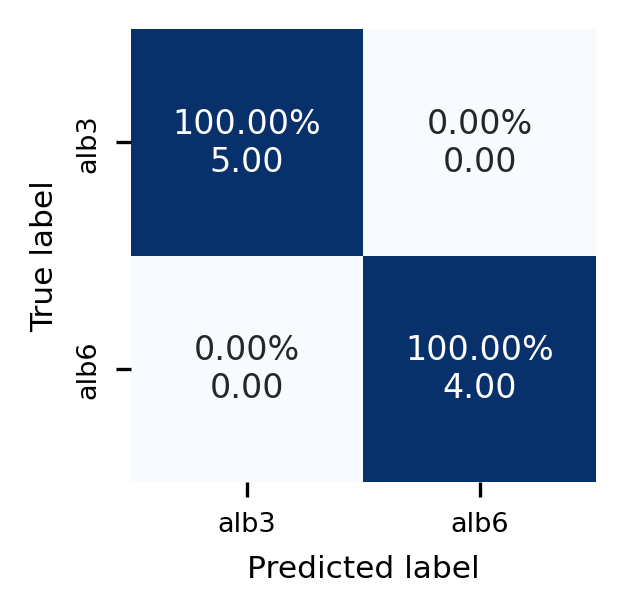

In [ ]:
classes_groups = [
    ["alb2", "alb5"],
    ["alb3", "alb6"],
#     ["fib1", "fib2", "fib3" ,"fib4" ,"fib5"],
#     ["fib7" ,"fib8" ,"fib9" ,"fib10" ,"fib11"],
#     ["fib1", "fib2", "fib3"],
#     ["fib4" ,"fib5" ,"fib6"],
]
datasets = [
    'albumin_before_hydrolysis', 
    'albumin_after_hydrolysis', 
#     'fibrinogen_before_hydrolysis', 
#     'fibrinogen_after_hydrolysis' 
]
multiplier = 2
syllable = 2
for dataset, group, cf in zip(datasets, classes_groups, list(cfs.values())):
#     print(key)
    print(cf)

    make_confusion_matrix(
        cf,
        group_names=None,
        categories=group,
        count=True,
        percent=True,
        cbar=False,
        xyticks=True,
        xyplotlabels=True,
        sum_stats=False,
        figsize=(len(group)*multiplier - syllable, len(group)*multiplier-syllable),
        cmap='Blues',
        title=False,
        base_font_size=2.5*len(group)
    )

In [ ]:
list(result_dict.values())

[array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]),
 array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])]

In [ ]:
# file_name = "metrics/raw_datasets_metrics.pickle"
# with open(file_name, 'rb') as f:
#     result = pickle.load(f)

In [ ]:
dicts = [
    {
        "n_estimators":200, 
        "n_jobs":-1, 
        "warm_start":False
    },
    {
        "n_estimators":200, 
        "eval_metric":'merror'
    },
    {
        "iterations":200, 
        "verbose":0,
    }
]

models=[
    ExtraTreesClassifier, 
    XGBClassifier, 
    CatBoostClassifier
]
results1 = []
for args, model in zip(dicts, models):
    results.append(
        ml_class_train_template(
            X=X, 
            y=y[:, 1], 
            model_class=model,
            args=args,
            k_folds=5,
            test_size=0.2,
            file_name=None,
            feature_importances=False,
        )
    )

In [ ]:
results1

[({'class 0.0': {'precision': 1.0,
    'recall': 0.9333333333333333,
    'f1-score': 0.9655172413793104,
    'support': 15},
   'class 1.0': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 12},
   'class 2.0': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 12},
   'class 3.0': {'precision': 0.9375,
    'recall': 1.0,
    'f1-score': 0.967741935483871,
    'support': 15},
   'class 4.0': {'precision': 0.9285714285714286,
    'recall': 0.9285714285714286,
    'f1-score': 0.9285714285714286,
    'support': 14},
   'class 10.0': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 5},
   'class 12.0': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 5},
   'accuracy': 0.9743589743589743,
   'macro avg': {'precision': 0.9808673469387755,
    'recall': 0.9802721088435374,
    'f1-score': 0.9802615150620871,
    'support': 78},
   'weighted avg': {'precision': 0.9751602564102564,
    'recall': 0

In [ ]:
X, y = second_x, second_y

dicts = [
    {
        "n_estimators":200, 
        "n_jobs":-1, 
        "warm_start":False
    },
    {
        "n_estimators":200, 
        "eval_metric":'merror'
    },
    {
        "iterations":200, 
        "verbose":0,
    }
]

models=[
    ExtraTreesClassifier, 
    XGBClassifier, 
    CatBoostClassifier
]
results2 = []
for args, model in zip(dicts, models):
    results2.append(
        ml_class_train_template(
            X=X, 
            y=y[:, 1], 
            model_class=model,
            args=args,
            k_folds=5,
            test_size=0.2,
            file_name=None,
            feature_importances=False,
        )
    )

In [ ]:
X, y = np.vstack((first_x, second_x)), np.vstack((first_y, second_y))

dicts = [
    {
        "n_estimators":200, 
        "n_jobs":-1, 
        "warm_start":False
    },
    {
        "n_estimators":200, 
        "eval_metric":'merror'
    },
    {
        "iterations":200, 
        "verbose":0,
    }
]

models=[
    ExtraTreesClassifier, 
    XGBClassifier, 
    CatBoostClassifier
]
results3 = []
for args, model in zip(dicts, models):
    results.append(
        ml_class_train_template(
            X=X, 
            y=y[:, 1], 
            model_class=model,
            args=args,
            k_folds=5,
            test_size=0.2,
            file_name=None,
            feature_importances=False,
        )
    )

In [ ]:
results3

[({'class 0.0': {'precision': 1.0,
    'recall': 0.8,
    'f1-score': 0.888888888888889,
    'support': 15},
   'class 1.0': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 12},
   'class 2.0': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 12},
   'class 3.0': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 15},
   'class 4.0': {'precision': 0.8235294117647058,
    'recall': 1.0,
    'f1-score': 0.9032258064516129,
    'support': 14},
   'class 5.0': {'precision': 0.8181818181818182,
    'recall': 0.9,
    'f1-score': 0.8571428571428572,
    'support': 10},
   'class 6.0': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 6},
   'class 7.0': {'precision': 1.0,
    'recall': 1.0,
    'f1-score': 1.0,
    'support': 10},
   'class 8.0': {'precision': 0.9,
    'recall': 1.0,
    'f1-score': 0.9473684210526316,
    'support': 9},
   'class 9.0': {'precision': 1.0,
    'recall': 0.8181818

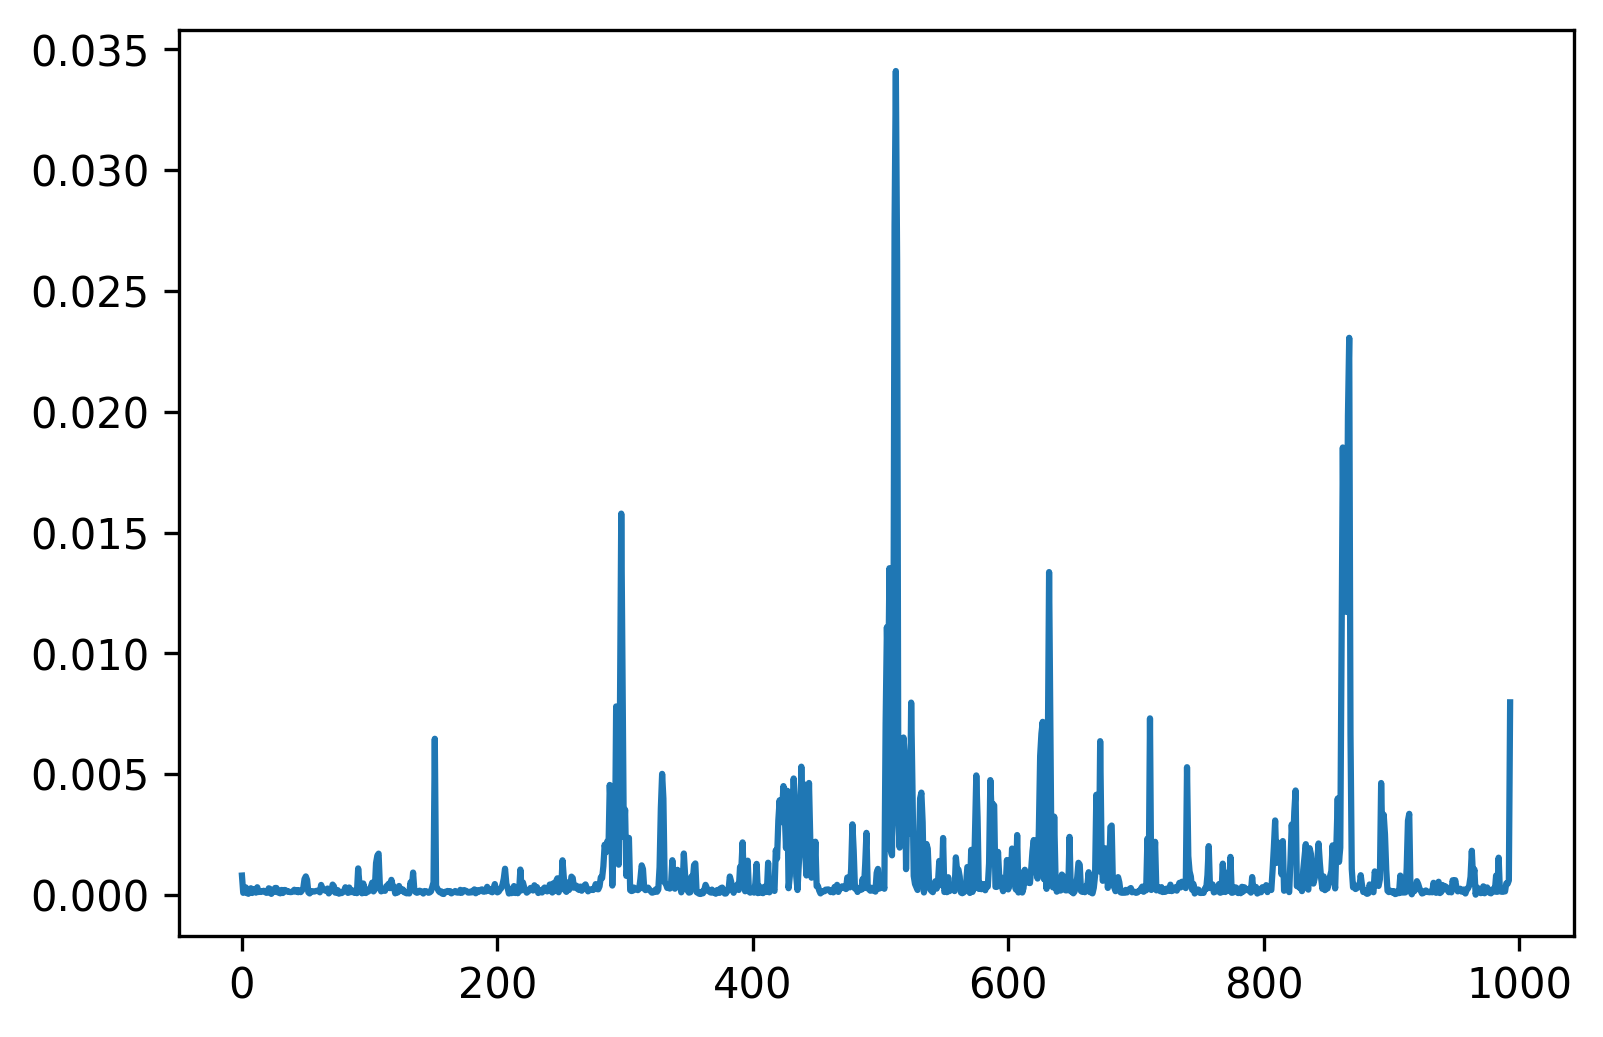

In [ ]:
plt.figure(dpi=300)
plt.plot(models['1 fold'].feature_importances_)

In [ ]:
feature_importances_

In [ ]:
X, y = data_loading(
    fg_file="dataSrc/fg_1-5_7-11.csv", 
    ga_file="dataSrc/ga_2_3_5_6.csv",
    header='infer'
)

first_x, first_y, second_x, second_y = split_dataset(X, y)
# X, y = first_x, first_y
X, y = second_x, second_y

old fg classes: {1, 2, 3, 4, 5, 7, 8, 9, 10, 11}
new fg classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

old ga classes: {2, 3, 5, 6}
new ga classes: {10, 11, 12, 13}
(388, 994) (388, 2) (270, 994) (270, 2)


In [ ]:
description_tuple=(
    'the second dataset using RandomForest', 
#     'the second dataset using XGBoost', 
    'the second dataset using CatBoost', 
) 
file_names_tuple=(
    "metrics/metrics_random_forest_second_dataset.txt",
#     "metrics/metrics_xgboost_second_dataset.txt",
    "metrics/metrics_catboost_second_dataset.txt",
)

def_tuple=(random_forest_train, catboost_train)

metrics_second_dataset = train_models(
    X, 
    y, 
    def_tuple=def_tuple, 
    description_tuple=description_tuple, 
    file_names_tuple=file_names_tuple
)

Metrics on the second dataset using RandomForest:
    mean accuracy           = 0.93 +- 0.022
    mean f1 weighted        = 0.929 +- 0.022
    mean precision weighted = 0.935 +- 0.019
    mean recall weighted    = 0.93 +- 0.022
    mean f1 macro           = 0.946 +- 0.017
    mean precision macro    = 0.949 +- 0.015
    mean recall macro       = 0.947 +- 0.016

        
Metrics on the second dataset using CatBoost:
    mean accuracy           = 0.944 +- 0.023
    mean f1 weighted        = 0.944 +- 0.024
    mean precision weighted = 0.949 +- 0.02
    mean recall weighted    = 0.944 +- 0.023
    mean f1 macro           = 0.958 +- 0.018
    mean precision macro    = 0.96 +- 0.017
    mean recall macro       = 0.959 +- 0.016

        


In [ ]:
metrics_second_dataset[0]

In [ ]:
def write_metrics_to_csv(
    metrics_arr, 
    columns=['Model', 'Accuracy', 'F1 score', 'Precision', 'Recall'],
    needed_metrics=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'], 
    models = ['Random Forest', 'XGBoost', 'CatBoost']
):
    result = [[] for i in range(len(metrics_arr))]
    for index, metrics in enumerate(metrics_arr):
        result[index][0] = models[index]
        result[index]

### Functions for spectra augmentation

In [ ]:
def add_gauss_noise(spectra, amplitude):
    new_amplitude = np.random.rand(1)[0] * (amplitude / 14)
#     print(new_amplitude)
    shape = [int(i) for i in spectra.shape]
#     print(shape)
    spectra += np.random.randn(*shape) * new_amplitude
    return spectra

In [ ]:
# add_gauss_noise(np.linspace(0, 10, 11), 4)

In [ ]:
def shift_spectra(spectra, max_shift_size=1):
#     shift size means number of elements of spectra array, not sm^-1
    shift_size = np.random.randint(0, max_shift_size+1)
    if shift_size == 0:
        return spectra
    if np.random.randint(0, 10) >= 5:
#         shift will be done to the left
        spectra = np.concatenate(
            (spectra[shift_size:], np.ones(shift_size) * spectra[-1]),
            axis=0
        )
    else:
#         shift will be done to the right
        spectra = np.concatenate(
            (np.ones(shift_size) * spectra[0], spectra[:spectra.shape[0]-shift_size]),
            axis=0
        )
    return spectra
    

### Data upsampling

In [ ]:
def how_much_elements_per_class(labels):
    unique_labels = np.unique(labels)
    elements_per_class = np.zeros_like(unique_labels)
    for index, class_i in enumerate(unique_labels):
#         print(labels[labels == int(class_i)], class_i)
        elements_per_class[index] = (labels == int(class_i)).sum()
    return unique_labels, elements_per_class

In [ ]:
def upsample_class(data, labels, class_label, elements_per_class, needed_elements_per_class):
#     print(labels[labels == class_label].shape, data[labels == class_label].shape)
    new_data = np.concatenate(
        (
            data[labels == class_label], 
            labels[labels == class_label].reshape(-1, 1)
        ), 
        axis=1
    )
#     print(labels[labels == class_label].shape, data[labels == class_label].shape, new_data.shape)
    indexes = np.random.randint(
        low=0,
        high=new_data.shape[0],
        size=needed_elements_per_class - elements_per_class
    )
#     print(indexes.shape)
    additional_data = new_data[indexes, :]
#     print(additional_data.shape)
    return (additional_data[:, :-1], additional_data[:, -1])

In [ ]:
# data = np.random.randint(0, 30, (60, 100))
# labels = np.random.randint(0, 10, 60)
# # upsample(data, labels, 5)
# new_data, new_labels = upsample_class(data, labels, 5, (labels==5).sum(), 40)
# new_data.shape, new_labels.shape

In [ ]:
def upsample(data, labels, needed_elements_per_class):
    unique_labels, elements_per_class = how_much_elements_per_class(labels)
    if needed_elements_per_class < elements_per_class.max():
        raise Exception(f"class elements must be bigger than maximal number of elements in class in dataset: {elements_per_class.max()}")
    additional_data = np.array([]).reshape(0, data.shape[1])
    additional_labels = np.array([])
    for index, label_i in enumerate(unique_labels):
        tmp_data, tmp_labels = upsample_class(
            data,
            labels,
            label_i,
            elements_per_class[index],
            needed_elements_per_class
        )
#         print(tmp_data.shape, tmp_labels.shape)
        additional_data = np.concatenate(
            (additional_data, tmp_data), 
        )
        
        additional_labels = np.concatenate(
            (additional_labels, tmp_labels), 
        )
    data = np.concatenate(
        (data, additional_data),
        axis=0
    )
    labels = np.concatenate(
        (labels, additional_labels),
    )
#     print(data.shape, labels.shape)
    return (data, labels.astype(int))
        
    

In [ ]:


def add_group(y, groups, add=0):
    new_y = np.zeros((y.shape[0], 2))
    new_y[:, 1] = y
    for group_num, group in enumerate(groups):
        for class_num in group:
            new_y[y==class_num] = np.array([group_num + add, class_num])
    return new_y

In [ ]:
def transform_class_into_group_and_class(labels):
    group1 = [0, 1, 2, 3, 4]
    group2 = [5, 6, 7, 8, 9]
    group3 = [10, 11]
    group4 = [12, 13]
    groups = [group1, group2, group3, group4]
    new_labels = np.zeros((labels.shape[0], 2))
    for group_number, group in enumerate(groups):
        for class_i in group:
#             print(new_labels[labels == class_i])
#             print(np.array([group_number, class_i]))
            new_labels[labels == class_i] = np.array([group_number, class_i])
    return new_labels

### Data augmentation

In [ ]:
def augment_data(data, labels, needed_elements_per_class):#, class_type='class'):
    new_labels = labels[:, 1].copy()
    data, new_labels = upsample(data, new_labels, needed_elements_per_class)
#     claculate max amplitude for every class
    amplitudes = []
    for class_i in np.unique(new_labels):
        amplitudes.append(data[new_labels == class_i].mean())
    amplitudes = np.array(amplitudes)
#     print(amplitudes)
#     print(amplitudes)
    for index in range(data.shape[0]):
#         print(shift_spectra(data[index]).shape)
#         data[index] = shift_spectra(data[index])
        data[index] = add_gauss_noise(data[index], amplitudes[new_labels[index]])
    new_labels = transform_class_into_group_and_class(new_labels)
    return data, new_labels

In [ ]:
# data = np.random.randint(0, 10, (80, 200))
# labels = np.random.randint(0, 10, 80)
# # print(labels)
# data, labels = augment_data(data, labels, 50)
# # upsample_class()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(X.shape[0], X.shape[-1]), y, test_size=0.2, stratify=y)
X_train.shape, X_test.shape

((526, 994), (132, 994))

In [ ]:
# array1, array2 = how_much_elements_per_class(y_train[:, 1])
# array1, array2

In [ ]:
X_augmented, y_augmented = augment_data(
    X_train.reshape(X_train.shape[0], -1), 
    y_train.astype(int), 
    100,
)
X_augmented.shape, y_augmented.shape

# X_augmented, y_augmented = augment_data(
#     X.reshape(X.shape[0], -1), 
#     y.astype(int), 
#     100,
# )
# X_augmented.shape, y_augmented.shape

((1400, 994), (1400, 2))

In [ ]:
_, _ = random_forest_train(
    data=X_augmented, 
    y=y_augmented, 
    k_folds=5, 
    num_estimators=num_estimators,
#     X_test=X_test,
#     y_test=y_test,
    class_type='group', 
    description='Full spectra using RandomForest for group prediction', 
    file_name='metrics/metrics_random_forest_full_spectra_augmented_groups.txt'
)

metric_dict, models = random_forest_train(
    X_augmented, 
    y_augmented, 
    k_folds=5, 
    num_estimators=num_estimators,
#     X_test=X_test,
#     y_test=y_test,
    class_type='class', 
    description='Full spectra using RandomForest for class prediction', 
    file_name='metrics/metrics_random_forest_full_spectra_augmented_classes.txt'
)

Metrics on Full spectra using RandomForest for group prediction:
mean accuracy           = 1.0 +- 0.0
mean f1 weighted        = 1.0 +- 0.0
mean precision weighted = 1.0 +- 0.0
mean recall weighted    = 1.0 +- 0.0
mean f1 macro           = 1.0 +- 0.0
mean precision macro    = 1.0 +- 0.0
mean recall macro       = 1.0 +- 0.0

    
Metrics on Full spectra using RandomForest for class prediction:
mean accuracy           = 0.986 +- 0.004
mean f1 weighted        = 0.986 +- 0.004
mean precision weighted = 0.988 +- 0.003
mean recall weighted    = 0.986 +- 0.004
mean f1 macro           = 0.986 +- 0.004
mean precision macro    = 0.988 +- 0.003
mean recall macro       = 0.986 +- 0.004

    


In [ ]:
# metric_dict

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

# _, _ = xgboost_train(
#     data=X_augmented, 
#     y=y_augmented, 
#     k_folds=5, 
#     num_estimators=num_estimators,
# #     X_test=X_test,
# #     y_test=y_test,
#     class_type='group', 
#     description='Full spectra using XGBoost for group prediction', 
#     file_name='metrics/metrics_xgboost_full_spectra_augmented_groups.txt'
# )

# _, _ = xgboost_train(
#     data=X_augmented, 
#     y=y_augmented, 
#     k_folds=5, 
#     num_estimators=num_estimators,
# #     X_test=X_test,
# #     y_test=y_test,
#     class_type='class', 
#     description='Full spectra using XGBoost for class prediction', 
#     file_name='metrics/metrics_xgboost_full_spectra_augmented_classes.txt'
# )

In [ ]:
# _, _ = catboost_train(
#     data=X_augmented, 
#     y=y_augmented, 
#     k_folds=5, 
#     num_estimators=num_estimators,
# #     X_test=X_test,
# #     y_test=y_test,
#     class_type='group', 
#     description='Full spectra using CatBoost for group prediction', 
#     file_name='metrics/metrics_catboost_full_spectra_augmented_groups.txt'
# )

# _, _ = catboost_train(
#     data=X_augmented, 
#     y=y_augmented, 
#     k_folds=5, 
#     num_estimators=num_estimators,
# #     X_test=X_test,
# #     y_test=y_test,
#     class_type='class', 
#     description='Full spectra using CatBoost for class prediction', 
#     file_name='metrics/metrics_catboost_full_spectra_augmented_classes.txt'
# )

In [ ]:
from sklearn.metrics import classification_report

def train_test_check(models_dict, X_test, y_test, class_type='class'):
    if class_type == 'group':
        new_y_test = y_test[:, 0].copy()
    elif class_type == 'class':
        new_y_test = y_test[:, 1].copy()
    else:
        raise Exception("Type of label: can be only 'group' or 'class'.")
        
        
    num_models = len(models_dict)
    metric_dict = {
        "accuracy": np.zeros(num_models),
        "f1_weighted": np.zeros(num_models),
        "precision_weighted": np.zeros(num_models),
        "recall_weighted": np.zeros(num_models),
        "f1_macro": np.zeros(num_models),
        "precision_macro": np.zeros(num_models),
        "recall_macro": np.zeros(num_models),
    }
    
    for i, model in enumerate(models_dict):
#         print(i)
#         print(len(models_dict))
        y_pred = models_dict[model].predict(X_test)
#         print(new_y_test.dtype, y_pred.dtype)
#         print((new_y_test == y_pred).mean())
        tmp_dict = classification_report(new_y_test, y_pred, output_dict = True)

        metric_dict['accuracy'][i] = tmp_dict['accuracy']
        metric_dict['f1_weighted'][i] = tmp_dict['weighted avg']['f1-score']
        metric_dict['precision_weighted'][i] = tmp_dict['weighted avg']['precision']
        metric_dict['recall_weighted'][i] = tmp_dict['weighted avg']['recall']
        metric_dict['f1_macro'][i] = tmp_dict['macro avg']['f1-score']
        metric_dict['precision_macro'][i] = tmp_dict['macro avg']['precision']
        metric_dict['recall_macro'][i] = tmp_dict['macro avg']['recall']
    print(f'''Metrics:
mean accuracy           = {metric_dict['accuracy'].mean().round(3)} +- {metric_dict['accuracy'].std().round(3)}
mean f1 weighted        = {metric_dict['f1_weighted'].mean().round(3)} +- {metric_dict['f1_weighted'].std().round(3)}
mean precision weighted = {metric_dict['precision_weighted'].mean().round(3)} +- {metric_dict['precision_weighted'].std().round(3)}
mean recall weighted    = {metric_dict['recall_weighted'].mean().round(3)} +- {metric_dict['recall_weighted'].std().round(3)}
mean f1 macro           = {metric_dict['f1_macro'].mean().round(3)} +- {metric_dict['f1_macro'].std().round(3)}
mean precision macro    = {metric_dict['precision_macro'].mean().round(3)} +- {metric_dict['precision_macro'].std().round(3)}
mean recall macro       = {metric_dict['recall_macro'].mean().round(3)} +- {metric_dict['recall_macro'].std().round(3)}\n
    ''')
    return metric_dict
        
        
array = train_test_check(models, X_test, y_test )
None

Metrics:
mean accuracy           = 0.924 +- 0.0
mean f1 weighted        = 0.921 +- 0.0
mean precision weighted = 0.938 +- 0.0
mean recall weighted    = 0.924 +- 0.0
mean f1 macro           = 0.928 +- 0.0
mean precision macro    = 0.941 +- 0.0
mean recall macro       = 0.933 +- 0.0

    


In [ ]:
models['1 fold'].estimators_[0].feature_importances_

array([0.        , 0.        , 0.00048077, 0.        , 0.        ,
       0.        , 0.00153846, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00118007, 0.        ,
       0.        , 0.00048077, 0.        , 0.        , 0.        ,
       0.        , 0.00048077, 0.        , 0.00088141, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00064103, 0.        , 0.00093623,
       0.        , 0.00153846, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00166831, 0.        ,
       0.        , 0.00472945, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00091288, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00094937, 0.        , 0.     

In [ ]:
models['5 fold'].estimators_[0].feature_importances_

array([0.        , 0.        , 0.00048077, 0.        , 0.        ,
       0.        , 0.00153846, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00118007, 0.        ,
       0.        , 0.00048077, 0.        , 0.        , 0.        ,
       0.        , 0.00048077, 0.        , 0.00088141, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00064103, 0.        , 0.00093623,
       0.        , 0.00153846, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00166831, 0.        ,
       0.        , 0.00472945, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00091288, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00094937, 0.        , 0.     

In [ ]:
array

{'accuracy': array([0.93181818, 0.93181818, 0.93181818, 0.93181818, 0.93181818]),
 'f1_weighted': array([0.93218008, 0.93218008, 0.93218008, 0.93218008, 0.93218008]),
 'precision_weighted': array([0.93442996, 0.93442996, 0.93442996, 0.93442996, 0.93442996]),
 'recall_weighted': array([0.93181818, 0.93181818, 0.93181818, 0.93181818, 0.93181818]),
 'f1_macro': array([0.94569663, 0.94569663, 0.94569663, 0.94569663, 0.94569663]),
 'precision_macro': array([0.94646306, 0.94646306, 0.94646306, 0.94646306, 0.94646306]),
 'recall_macro': array([0.94659349, 0.94659349, 0.94659349, 0.94659349, 0.94659349])}

In [ ]:
Metrics on Full spectra using RandomForest for class prediction:
mean accuracy           = 0.936 +- 0.013
mean f1 weighted        = 0.935 +- 0.014
mean precision weighted = 0.942 +- 0.01
mean recall weighted    = 0.936 +- 0.013
mean f1 macro           = 0.944 +- 0.014
mean precision macro    = 0.95 +- 0.011
mean recall macro       = 0.945 +- 0.013

In [ ]:
# class block1d(nn.Module):
#     def __init__(
#         self,
#         in_channels, 
#         out_channels,
#         downsample=None,
#         stride=1,
#         kernel_size=3, 
#         padding=1
#     ):
#         super(block1d, self).__init__()
# #         the last convolution outputs out_channels * self.expansion channels
# #         It is done in order to save number of parameters. 
# #         self.expansion = dimension * 2
#         self.expansion = 2
#         self.conv1 = nn.Conv1d(
#             in_channels, 
#             out_channels,
#             kernel_size=1 ,
#             stride=1,
#             padding=0,
#             bias=False
#         )
#         self.bn1 = nn.BatchNorm1d(out_channels)
        
#         self.conv2 = nn.Conv1d(
#             out_channels, 
#             out_channels,
#             kernel_size=kernel_size,
#             stride=stride,
#             padding=padding,
#             bias=False
#         )
#         self.bn2 = nn.BatchNorm1d(out_channels)
        
#         self.conv3 = nn.Conv1d(
#             out_channels, 
#             out_channels*self.expansion,
#             kernel_size=1 ,
#             stride=1,
#             padding=0,
#             bias=False
#         )
#         self.bn3 = nn.BatchNorm1d(out_channels*self.expansion)
        
#         self.relu = nn.ReLU()
# #         all the blocks in ResNet is devided by four groups, every next group is downsampled
# #         in relation to previous one. This field is responsible for that
#         self.downsample=downsample
    
    
#     def forward(self, x):
# #         in order to perform skip connection
#         identity = x.clone()
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
        
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
        
#         x = self.conv3(x)
#         x = self.bn3(x)
        
#         if self.downsample is not None:
#             identity = self.downsample(identity)
        
#         x += identity
#         x = self.relu(x)
#         return x
        

# class ResNet1d(nn.Module):
#     def __init__(
#         self,
#         block,
#         layers,
#         num_classes,
#         num_groups
#     ):
#         super(ResNet1d, self).__init__()
#         self.expansion = 2
#         self.in_channels = 64
#         self.p = 0.02
        
#         self.conv1 = nn.Conv1d(
#             in_channels=1,
#             out_channels=self.in_channels, 
#             kernel_size=7, 
#             stride=2, 
#             padding=3, 
#             bias=False
#         )
#         self.bn1 = nn.BatchNorm1d(64)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
#         self.layer1 = self._make_layer(
#             block1d, layers[0], out_channels=64, stride=1
#         )
#         self.layer2 = self._make_layer(
#             block1d, layers[1], out_channels=128, stride=2
#         )
#         self.layer3 = self._make_layer(
#             block1d, layers[2], out_channels=256, stride=2
#         )
#         self.layer4 = self._make_layer(
#             block1d, layers[3], out_channels=512, stride=2
#         )
        
#         self.avgpool = nn.AdaptiveAvgPool1d(8)
#         self.fc_class = nn.Sequential(
#             nn.Linear(8192, num_classes),
#             nn.Dropout(p=self.p)
#         )
#         self.fc_group = nn.Sequential(
#             nn.Linear(8192, num_groups),
#             nn.Dropout(p=self.p)
#         )
#         self.softmax = nn.Softmax(dim=-1)
        
        
#     def _make_layer(self, block, num_residual_blocks, out_channels, stride):
#         downsample = None
#         layers = []
        
# #         in order to adopt skip connection, we add downsample to the end of block group
#         if stride != 1 or self.in_channels != out_channels * self.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv1d(
#                     self.in_channels, 
#                     out_channels*self.expansion,
#                     kernel_size=1,
#                     stride=stride,
#                     bias=False
#                 ),
#                 nn.BatchNorm1d(out_channels*self.expansion)
#             )
        
#         layers.append(
#             block1d(
#                 self.in_channels, 
#                 out_channels, 
#                 downsample, 
#                 stride
#             )
#         )
        
#         self.in_channels = out_channels * self.expansion
        
#         for i in range(num_residual_blocks - 1):
#             layers.append(
#                 block1d(self.in_channels, out_channels)
#             )
        
#         return nn.Sequential(*layers)
    

#     def get_features(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
# #         x = self.avgpool(x)
#         x = x.reshape(x.shape[0], -1)
#         return x


#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
        
#         x = self.avgpool(x)
#         # print(x.shape)
#         x = x.reshape(x.shape[0], -1)
#         # print(x.shape)

#         groups = self.fc_group(x)
#         classes = self.fc_class(x)
        
#         return (self.softmax(groups), self.softmax(classes))
# #         return (groups, classes)


# def ResNet50_1d(num_classes=14, num_groups=4):
#     return ResNet1d(block1d, [3, 4, 6, 3], num_classes, num_groups)


# def ResNet101_1d(num_classes=14, num_groups=4):
#     return ResNet1d(block1d, [3, 4, 23, 3], num_classes, num_groups)


# def ResNet152_1d(num_classes=14, num_groups=4):
#     return ResNet1d(block1d, [3, 8, 36, 3], num_classes, num_groups)

In [ ]:
# def test():
#     net = ResNet101_1d(num_classes=14, num_groups=4)
#     y = net(torch.randn(4, 1, 994))
#     return y


# y = test()

# y[0].size(), y[1].size()

In [ ]:
# len(data_loader_train)

In [ ]:
# def train(model, optimizer, loss_func, epochs, train_loader, val_loader):
#     train_history = []
#     test_history = []
    
#     for epoch in tqdm(range(epochs)):
#         model.train()
#         avg_train_loss = 0
#         avg_test_loss = 0
#         right_preds_group = 0
#         right_preds_classes = 0
#         size_group = 0
#         size_classes = 0
#         for X_batch, y_batch in tqdm(train_loader):
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             outputs_groups, outputs_classes = model(X_batch)
# #             print(y_batch[:, 0].shape)
# #             print(outputs_groups.shape)
#             loss_group = loss_func(outputs_groups, y_batch[:, 0])
#             loss_classes = loss_func(outputs_classes, y_batch[:, 1])
#             loss = loss_group + loss_classes
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad
#             avg_train_loss += loss / len(train_loader)
            
#             y_pred_group = torch.argmax(outputs_groups, dim = 1)
#             right_preds_group += torch.sum(y_pred_group == y_batch[:, 0])
#             size_group += y_pred_group.size()[0]
            
#             y_pred_classes = torch.argmax(outputs_classes, dim = 1)
# #             print(y_pred_classes,y_batch[:, 1])
#             right_preds_classes += torch.sum(y_pred_classes == y_batch[:, 1])
#             size_classes += y_pred_classes.size()[0]
            
#         train_acc_group = right_preds_group / size_group
#         train_acc_classes = right_preds_classes / size_classes
#         train_history.append(avg_train_loss)
        
#         model.eval()
#         right_preds_group = 0
#         right_preds_classes = 0
#         size_group = 0
#         size_classes = 0
#         for X_batch, y_batch in tqdm(val_loader):
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             with torch.no_grad():
#                 outputs_groups, outputs_classes = model(X_batch)
#                 loss_group = loss_func(outputs_groups, y_batch[:, 0])
#                 loss_classes = loss_func(outputs_classes, y_batch[:, 1])
#                 loss = loss_group + loss_classes
#     # outputs неправильный!!
#                 avg_test_loss += loss / len(val_loader)
# #                 y_pred = torch.argmax(outputs, dim = 1)
# #                 right_preds += torch.sum(y_pred == y_batch)
# #                 size += y_pred.size()[0]
# #         test_acc = right_preds / size
#                 y_pred_group = torch.argmax(outputs_groups, dim = 1)
#                 right_preds_group += torch.sum(y_pred_group == y_batch[:, 0])
#                 size_group += y_pred_group.size()[0]

#                 y_pred_classes = torch.argmax(outputs_classes, dim = 1)
#                 right_preds_classes += torch.sum(y_pred_classes == y_batch[:, 1])
#                 size_classes += y_pred_classes.size()[0]
            
#         test_acc_group = right_preds_group / size_group
#         test_acc_classes = right_preds_classes / size_classes
        
#         test_history.append(avg_test_loss)
#         print(f"""epochs: {epoch + 1}/{epochs}, 
#         train loss: {round(avg_train_loss.item(), 3)}, test loss: {round(avg_test_loss.item(), 3)}
#         train group accuracy: {round(train_acc_group.item() * 100, 2)}, test group accuracy: {round(test_acc_group.item() * 100, 2)}
#         train class accuracy: {round(train_acc_classes.item() * 100, 2)}, test class accuracy: {round(test_acc_classes.item() * 100, 2)}""")
#         torch.cuda.empty_cache()
# #     
#     return train_history, test_history

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = ResNet50_1d().to(device)
# optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 0.01)
# # scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.75)
# loss_function = nn.CrossEntropyLoss()
# max_epochs = 5
# train_hist, test_hist = train(
#     model, 
#     optimizer,
#     loss_function,
#     max_epochs,
#     data_loader_train, 
#     data_loader_test,
# )

In [ ]:
# def visualise_loss(train_hisoryt, test_history):
#     pass

In [ ]:
# visualise_loss(train_hist, test_hist)

### Base approach

In [ ]:
# from sklearn.manifold import TSNE, MDS
# from sklearn.decomposition import PCA, NMF, SparsePCA, TruncatedSVD, FastICA, FactorAnalysis
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.pipeline import make_pipeline


# # random_state = 42
# cdict = {0: 'red',1: 'blue', 2: 'green', 3: 'orange'}

# def plot_destribution(X_embedded, y, titleName):
#     fig, ax = plt.subplots(figsize=(8,4))
#     for iy in np.unique(y):
#         ix = np.where(y == iy)
#         x1data = X_embedded[:, 0]
#         x2data = X_embedded[:, 1]
#         ax.scatter(x1data[ix], x2data[ix], c = cdict[iy], label = str(int(iy)), s = 15)
#     ax.legend(fontsize=11, markerscale=3)
#     ax.set_title(titleName, size=22)
#     plt.tight_layout()
#     plt.show()  

# # sklearn.manifold:
# X_tsne = TSNE(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_tsne, y[:, 0], 'TSNE')

# X_pca = MDS(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 0], 'MDS')

# # sklearn.decomposition
# X_pca = NMF(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 0], 'NMF')

# X_pca = PCA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 0], 'PCA')

# X_pca = SparsePCA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 0], 'SparsePCA')

# X_pca = TruncatedSVD(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 0], 'TruncatedSVD')

# X_pca = FastICA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 0], 'FastICA')

# X_pca = FactorAnalysis(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 0], 'FactorAnalysis')

In [ ]:
# cdict = {
#     0: 'red',
#     1: 'blue', 
#     2: 'green', 
#     3: 'orange',
#     4: 'purple',
#     5: 'brown',
#     6: 'pink',
#     7: 'gray',
#     8: 'olive',
#     9: 'cyan',
#     10: 'black',
#     11: 'yellow',
#     12: 'fuchsia',
#     13: 'navy' 
#     }

# # sklearn.manifold:
# X_tsne = TSNE(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_tsne, y[:, 1], 'TSNE')

# X_pca = MDS(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 1], 'MDS')

# # sklearn.decomposition
# X_pca = PCA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 1], 'PCA')

# X_pca = NMF(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 1], 'NMF')

# X_pca = SparsePCA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 1], 'SparsePCA')

# X_pca = TruncatedSVD(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 1], 'TruncatedSVD')

# X_pca = FastICA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 1], 'FastICA')

# X_pca = FactorAnalysis(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
# plot_destribution(X_pca, y[:, 1], 'FactorAnalysis')

### CNN aproach

In [ ]:
# def make_features(model, X):
#     result = []
#     data_loader = DataLoader(
#         torch.tensor(X).float(), 
#         batch_size=16, 
#         shuffle=True
#     )
#     model.eval()
#     with torch.no_grad():
#         for data in data_loader:
#             # print(data.shape)
#             # print(model.get_features(data).shape)
#             result.append(model.get_features(data))
#     return torch.cat(result, dim=0).numpy()

In [ ]:
# cdict = {
#     0: 'red',
#     1: 'blue', 
#     2: 'green', 
#     3: 'orange',
#     }

# X_features = make_features(model, X)

# X_tsne = TSNE(n_components=2).fit_transform(X_features)
# plot_destribution(X_tsne, y[:, 0], 'TSNE')

# X_pca = PCA(n_components=2).fit_transform(X_features)
# plot_destribution(X_pca, y[:, 0], 'PCA')